[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/AlbertoGCID/Antiviral/blob/main/Antiviralautoencoder.ipynb)

condensacion de hart
6vs1

aplicar la extracción de características directamente a los previo de los smiles, sacar la fórmula, de la fórmula obtener una "imagen", una "matriz" para meterla dentro de una red convolucional, una vez está dentro de la red convolucional quitar la parte del clasificador (la salida del flatten) y esa salida será la selectora de características para aplicar las distintas técnicas de ML (la continuación del trabajo de Adriana pero con otro enfoque).

primero PCA o ANOVA

# Código extraído del trabajo de Adriana Anido Alonso
## https://github.com/adrania/COVID19-Drugs-repurposing/blob/main/Mordred_ML.ipynb

In [1]:
%matplotlib inline

import os
path = os.getcwd()
os.chdir(path)
import time
import pyqsar
import pickle
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt

# Descriptors
from pandas import read_csv
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

#Processing
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold

# Metrics
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score, recall_score, precision_score, classification_report
from sklearn.utils import class_weight

# Machine learning
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier, StackingClassifier, RandomTreesEmbedding
from sklearn.neural_network import MLPClassifier

In [2]:
def GetRdkitFeatures (descriptors, data):
    '''Gives a table of features from a smile. Descriptor's list is given by the user.'''

    calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptors) # first it creates a calculator object with the descriptors
    #print(calculator.GetDescriptorSummaries()) # if we want to get a calculator summary
    values = [] # creates a list to append each value
    
    for smile in data.smiles:
        mol = Chem.MolFromSmiles(smile) # it creates a rdkit molecule object for each smile data
        if mol is None: continue
        desc = calculator.CalcDescriptors(mol) # generates a tuple with the features for each smile
        values.append(desc) # it accumulates each tuple in a list
        features = pd.DataFrame(values, columns = descriptors) # transform the list into a dataframe
    
    return features

def ProcessData(i):
    '''Replace not float values with NaN.'''
    try: 
        return float(i)
    except:
        return np.nan
    
def GetColumns (data):
    '''Gets those columns with a percentage of cells with NaN values >= 50%.'''
    columns = []
    for col in data:
        percent = data[col].isnull().sum()/data[col].isnull().count()
        if percent >= 0.5:
            columns.append(col)
    return columns

def ML_score (models, X_train, Y_train, X_test, Y_test, seed, classes = ['0','1']):
    '''Fit diferent models, predict and return models' scores'''
    ACC = 0
    AUROC = 0
    precision = 0 
    recall = 0
    f1score = 0
    
    model_name = type(models).__name__ # get model name
    start_time = time.time()
    
    # Train different models using cross validation 
    print('> Training time: %0.2f mins'% ((time.time()-start_time)/60))
        
    models.fit(X_train, Y_train)
    
    # Predict
    y_pred = models.predict(X_test)
    y_probs = models.predict_proba(X_test)[:, 1]
    model_report = classification_report(Y_test, y_pred, target_names=classes, output_dict=True, digits=3)
     
    # Scores
    ACC = accuracy_score(Y_test, y_pred)
    AUROC = roc_auc_score(Y_test, y_probs)
    precision = model_report['weighted avg']['precision']
    recall = model_report['weighted avg']['recall']
    f1score = model_report['weighted avg']['f1-score']
    
    return ACC, AUROC, precision, recall, f1score

In [3]:

# Load datasets
antiv = read_csv('antivirals_SMILES.csv')
drugs = read_csv('DB_SMILES4prediction.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'antivirals_SMILES.csv'

In [ ]:

# Get RDKIT descriptors from smiles
des_list = [x[0] for x in Descriptors._descList] # get all rdkit posible descriptors

antiv_rdkit = pd.concat([antiv, GetRdkitFeatures(des_list, antiv)], axis=1)
drugs_rdkit = pd.concat([drugs, GetRdkitFeatures(des_list, drugs)], axis=1)

In [ ]:

# Save descriptors 
antiv_rdkit.to_csv('antiv_rdkit.csv', index_label=False)
drugs_rdkit.to_csv('drugs_rdkit.csv', index_label=False)

In [ ]:
# Load feature datasets
antiv_rdkit = read_csv('antiv_rdkit.csv', low_memory=False) #to solve different column types
antiv = antiv_rdkit.copy() # train

drugs_rdkit = read_csv('drugs_rdkit.csv', low_memory=False) #to solve different column types
drugs = drugs_rdkit.copy() # predict

In [ ]:
# Split ids and features
a = antiv.iloc[:,2:]
id_a = antiv.loc[:,:'Class']

d = drugs.iloc[:,3:]
id_d = drugs.loc[:,:'Class']

# Replace different column types with NaN values
a = a.applymap(ProcessData)
d = d.applymap(ProcessData)

# Restore datasets
antiv = pd.concat([id_a, a], axis=1)
drugs = pd.concat([id_d, d], axis=1)

In [ ]:
# First aproximation: any NaN value?
print('Has Antivirals dataset NaN values?', antiv.isnull().values.any()) #true
print('>> Columns with NaN: ', antiv.isnull().any().sum(), ' / ', len(antiv.columns))
print('>> Number of data points with NaN: ', antiv.isnull().any(axis=1).sum(), ' / ', len(antiv))
print('>> Number of rows with all NaN values: ', antiv.loc[:,'MaxEStateIndex':].isnull().all(axis=1).sum())

print('\nHas Drugs dataset NaN values?', drugs.isnull().values.any()) #true
print('>> Columns with NaN: ', drugs.isnull().any().sum(), ' / ', len(drugs.columns))
print('>> Number of data points with NaN: ', drugs.isnull().any(axis=1).sum(), ' / ', len(drugs))
print('>> Number of rows with all NaN values: ', drugs.loc[:,'MaxEStateIndex':].isnull().all(axis=1).sum())

In [ ]:
# Remove 8 rows with all NaN values in drugs dataset
all_NA = [10246,10247,10248,10249,10250,10251,10252,10253] # all nan values from 10246 till 10253
drugs = drugs.drop(all_NA) # remove 8 drugs from the drug dataset

In [ ]:

# Select columns to drop from antivirals dataset
to_drop = GetColumns(antiv)

# Drop the same columns in each dataset
antiv.drop(to_drop, axis=1, inplace=True) #same columns are removed
drugs.drop(to_drop, axis=1, inplace=True) #same columns are removed

In [ ]:
# Second aproximation 
print('Has Antivirals NaN values?', antiv.isnull().values.any()) #false
print('Has Drugs NaN values?', drugs.isnull().values.any()) #true

# Replace any NaN value with 0
antiv = antiv.fillna(0)
drugs = drugs.fillna(0)

print('Has Antivirals NaN values?', antiv.isnull().values.any()) #false
print('Has Drugs NaN values?', drugs.isnull().values.any()) #false

In [ ]:
# Save preprocessed files
antiv.to_csv('antiv_prepro_rdkit.csv', index_label=False)
drugs.to_csv('drugs_prepro_rdkit.csv', index_label=False)

# Ejecutar siempre a partir de aquí

In [3]:

# Load dataset
input_data = read_csv('archivos/antiv_prepro_rdkit.csv')

In [4]:
# Remove smiles from dataset
input_data = input_data.loc[:,'Class':]

In [5]:
# Set categoricals
input_data['Class'] = pd.Categorical(input_data['Class'])

# Train and test dataset, one split 0.8 train, 0.2 test. Random_state=80
x = input_data[input_data.iloc[:,1:].columns] 
y = input_data['Class']

x_train_prev, x_test_prev, y_train, y_test = train_test_split(x.values, y.values, test_size=0.2, random_state=80)

print('Full dataset samples: {}'.format(input_data.shape[0]))
print('Train dataset samples: {}'.format(x_train_prev.shape[0]))
print('Test dataset samples: {}'.format(x_test_prev.shape[0]))

Full dataset samples: 229
Train dataset samples: 183
Test dataset samples: 46


In [6]:
# Standardize data using only train set
sc = StandardScaler().fit(x_train_prev)
sc.get_params();

In [7]:
x_train_std = sc.transform(x_train_prev)
x_test_std = sc.transform(x_test_prev)

x_train_std.mean(axis=0);
x_train_std.std(axis=0);

In [8]:
# Transform splits from arrays into DataFrames
df_train = pd.DataFrame(x_train_std, columns=list(input_data.iloc[:,1:].columns))
df_train['Class'] = y_train

df_test = pd.DataFrame(x_test_std, columns=list(input_data.iloc[:,1:].columns))
df_test['Class'] = y_test

In [9]:
# FEATURE SELECTION - THRESHOLD
# Remove features with low variance - th=0.0001
featFilter = VarianceThreshold(threshold=0.0001) 

X_high_variance_train = featFilter.fit_transform(x_train_std) # fit and transform train dataset

selected_features = set(list(df_train.columns[featFilter.get_support(indices=True)])) # features with high variance

print('Features with high variance: {}'.format(len(featFilter.get_support(indices=True)))) # how many with high variance

pool_features = set(list(df_train.columns)[:-1]) # all features
print('Total number of features: ', len(pool_features))

eliminated_feats = list(pool_features-selected_features)[:-1] # eliminated features
print('Eliminated features: ', len(eliminated_feats))

X_high_variance_test = featFilter.transform(x_test_std) # transform test dataset

## aplicar laboratorio2 


Features with high variance: 177
Total number of features:  208
Eliminated features:  30


# HASTA AQUÍ EL CÓDIGO DEL TFG DE ADRIANA
## A partir de aquí, parto de los CSV generados para generar el modelo con autoencoder

In [14]:
print(df_train.shape)
#183 muestras con 209 características
# pero este dataset tiene las etiquetas
# para la seleccion de características me quedo únicamente con las variables sin la etiqueta (que es la última)
df_train_se = df_train.iloc[:,:-1] #dataset sin etiqueta (train_x)
df_train_e = df_train.iloc[:,-1] # etiquetas del dataset (train_y)
print(df_train_se.shape)
df_train_se.head()

(183, 209)
(183, 208)


MaxEStateIndex  MinEStateIndex  MaxAbsEStateIndex  MinAbsEStateIndex  \
0        0.039730        0.795004           0.039730          -0.347689   
1        0.243550        0.684399           0.243550          -0.507950   
2        0.639337        0.296942           0.639337          -0.601503   
3        0.512692        0.655023           0.512692          -0.683701   
4        0.123440        0.771337           0.123440          -0.609176   

        qed     MolWt  HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  \
0  0.109341  0.012647       -0.054600    0.013548             0.116396   
1  1.475144 -1.037036       -1.086733   -1.035403            -0.776706   
2 -0.752071  0.824439        0.930773    0.821683             0.652258   
3 -1.193726  1.446045        1.531216    1.447521             1.411394   
4  1.024848 -0.999173       -1.165782   -0.997665            -0.598086   

   NumRadicalElectrons  ...  fr_sulfide  fr_sulfonamd  fr_sulfone  \
0                  0.0  ...    2.258318     -0.433949    -0.25289   
1                  0.0  ...   -0.442807     -0.433949    -0.25289   
2                  0.0  ...   -0.442807     -0.433949    -0.25289   
3                  0.0  ...   -0.442807     -0.433949    -0.25289   
4                  0.0  ...   -0.442807     -0.433949    -0.25289   

   fr_term_acetylene  fr_tetrazole  fr_thiazole  fr_thiocyan  fr_thiophene  \
0                0.0           0.0    -0.227429          0.0     -0.311645   
1                0.0           0.0    -0.227429          0.0     -0.311645   
2                0.0           0.0    -0.227429          0.0     -0.311645   
3                0.0           0.0    -0.227429          0.0     -0.311645   
4                0.0           0.0    -0.227429          0.0     -0.311645   

   fr_unbrch_alkane  fr_urea  
0         -0.100082      0.0  
1         -0.100082      0.0  
2         -0.100082      0.0  
3         -0.100082      0.0  
4         -0.100082      0.0  

[5 rows x 208 columns]

In [15]:
print(df_test.shape)
df_test_se = df_test.iloc[:,:-1] # dataset sin etiqueta (test_x)
df_test_e = df_test.iloc[:,-1] # etiquetas del dataset (test_y)
print(df_test_se.shape)
df_test_se.head()
#46 muestras con 209 características

(46, 209)
(46, 208)


MaxEStateIndex  MinEStateIndex  MaxAbsEStateIndex  MinAbsEStateIndex  \
0        0.696203        0.159864           0.696203           0.115840   
1       -0.280431        0.846388          -0.280431          -0.581039   
2        0.625427        0.335273           0.625427          -0.190117   
3        0.106775        0.798175           0.106775           0.114934   
4       -3.431360        1.321082          -3.431360           3.006597   

        qed     MolWt  HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  \
0 -1.730217  1.962905        1.808900    1.964641             2.259842   
1  1.390979 -1.128080       -1.284822   -1.126545            -0.732051   
2 -0.619942  0.471647        0.500352    0.472996             0.518292   
3 -0.293715  0.141554        0.064440    0.142428             0.250361   
4 -0.423819 -0.070274       -0.034134   -0.070138            -0.240845   

   NumRadicalElectrons  ...  fr_sulfide  fr_sulfonamd  fr_sulfone  \
0                  0.0  ...   -0.442807     -0.433949    -0.25289   
1                  0.0  ...   -0.442807     -0.433949    -0.25289   
2                  0.0  ...   -0.442807     -0.433949    -0.25289   
3                  0.0  ...    2.258318     -0.433949    -0.25289   
4                  0.0  ...    2.258318     -0.433949    -0.25289   

   fr_term_acetylene  fr_tetrazole  fr_thiazole  fr_thiocyan  fr_thiophene  \
0                0.0           0.0    -0.227429          0.0     -0.311645   
1                0.0           0.0    -0.227429          0.0     -0.311645   
2                0.0           0.0    -0.227429          0.0     -0.311645   
3                0.0           0.0    -0.227429          0.0     -0.311645   
4                0.0           0.0     3.240869          0.0     -0.311645   

   fr_unbrch_alkane  fr_urea  
0         -0.100082      0.0  
1         -0.100082      0.0  
2         -0.100082      0.0  
3         -0.100082      0.0  
4         -0.100082      0.0  

[5 rows x 208 columns]

<del>Los datos que ella utiliza no están entre 0 y 1, lo que podría ser un problema a la hora de reconstruirlos, primero vamos a aumentar los datos añadiendo ruido a las muestras. Este ruido se añadirá a todas las muestras por igual, no sabemos si esto va a afectar a las etiquetas, es posible que al modificar los parámetros de una muestra esta debería cambiar de etiqueta pero esto nos será indiferente si conseguimos reconstruir bien el conjunto de test, después vamos a normalizar los datos usando min-max.</del>

In [16]:
# voy a probar a clasificar sin esto, ella usa media-varianza para la selección, así que le aplicaré media
# varianza también a los datos

def add_noise(df):
    noised_rows = []
    for i, row in df.iterrows():
        noised_row = row + np.random.normal(loc=0, scale=0.2, size=len(row))
        noised_row2 = row - np.random.normal(loc=0, scale=0.2, size=len(row))
        noised_rows.append(noised_row)
        noised_rows.append(noised_row2)
        noised_row = row + np.random.normal(loc=0, scale=0.2, size=len(row))
        noised_row2 = row - np.random.normal(loc=0, scale=0.2, size=len(row))
        noised_rows.append(noised_row)
        noised_rows.append(noised_row2)
    noised_df = pd.concat([df, pd.DataFrame(noised_rows, columns=df.columns)], ignore_index=True)
    return noised_df

def min_max_scaling(df):
    df_scaled = (df - df.min()) / (df.max() - df.min())
    df_scaled = df_scaled.where((df_scaled >= 0), 0)
    return df_scaled.where(~(df_scaled.eq(0).all(axis=0)), df_scaled + 1e-10)

def non_zero_mean_std(df):
    df = df.loc[:, (df != 0).any(axis=0)]
    df_scaled = (df-df.mean())/(df.std())
    return df_scaled

#df_train_se_aug= add_noise(df_train_se) - no aplico data augmentation

#df_train_se_stand = non_zero_mean_std(df_train_se) # estandarizo por mean_std eliminando columnas que son todo 0
#df_test_se_stand = non_zero_mean_std(df_test_se) 
#df_test_se_stand.head()

## Creo el Autoencoder

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, optimizers,losses
from random import seed
from matplotlib import pyplot
from keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

seed(90) # Fijamos una semilla para que las pruebas sean reproducibles

2023-02-08 18:44:35.954372: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-08 18:44:37.428150: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /tmp/.mount_edex.ARGhXtT/usr/lib:
2023-02-08 18:44:37.428313: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /tmp/.mount_edex.ARGhXtT/usr/lib:
2023-02-08 18:44:37.428322: W tensorflow/compiler/tf2tensorrt/

In [18]:
# la entrada es un vector de (1x209)


#TODO: modificar la arquitectura, añadir más capas

def crearencoder(entradas,dimension,l2_value):
    encoder = tf.keras.Sequential()
    dim = entradas.shape[1] # cogemos el número de características
    encoder.add(tf.keras.layers.InputLayer(dim))
    encoder.add(tf.keras.layers.Dense(dim,activation='relu',kernel_regularizer=l2(l2_value)))
    encoder.add(tf.keras.layers.BatchNormalization(axis=1,epsilon=0.001))
    #encoder.add(tf.keras.layers.Dense(dim//1.5,activation='relu',kernel_regularizer=l2(l2_value)))
    #encoder.add(tf.keras.layers.BatchNormalization(axis=1,epsilon=0.001))  
    encoder.add(tf.keras.layers.Dense(dim//2,activation='relu',kernel_regularizer=l2(l2_value)))
    encoder.add(tf.keras.layers.BatchNormalization(axis=1,epsilon=0.001))
    #encoder.add(tf.keras.layers.Dense(dim//3,activation='relu',kernel_regularizer=l2(l2_value)))
    #encoder.add(tf.keras.layers.BatchNormalization(axis=1,epsilon=0.001))  
    encoder.add(tf.keras.layers.Dense(dim//4,activation='relu',kernel_regularizer=l2(l2_value)))
    encoder.add(tf.keras.layers.BatchNormalization(axis=1,epsilon=0.001))  
    encoder.add(tf.keras.layers.Dense(dimension,activation='softmax'))
    encoder.build()
    return encoder

def creardecoder(entradas,dimension,l2_value):
    dim = entradas.shape[1]
    decoder = tf.keras.Sequential()
    decoder.add(tf.keras.layers.InputLayer(dimension))  
    decoder.add(tf.keras.layers.Dense(dim,activation='relu',kernel_regularizer=l2(l2_value)))
    decoder.add(tf.keras.layers.BatchNormalization(axis=1,epsilon=0.001))
    decoder.add(tf.keras.layers.Dense(dim//4,activation='relu',kernel_regularizer=l2(l2_value)))
    decoder.add(tf.keras.layers.BatchNormalization(axis=1,epsilon=0.001))
    #decoder.add(tf.keras.layers.Dense(dim//3,activation='relu',kernel_regularizer=l2(l2_value)))
    #decoder.add(tf.keras.layers.BatchNormalization(axis=1,epsilon=0.001))
    decoder.add(tf.keras.layers.Dense(dim//2,activation='relu',kernel_regularizer=l2(l2_value)))
    decoder.add(tf.keras.layers.BatchNormalization(axis=1,epsilon=0.001))
    #decoder.add(tf.keras.layers.Dense(dim//1.5,activation='relu',kernel_regularizer=l2(l2_value)))
    #decoder.add(tf.keras.layers.BatchNormalization(axis=1,epsilon=0.001))
    decoder.add(tf.keras.layers.Dense(dim,activation='linear'))
    decoder.build()
    return decoder

def buildautoencoder(entradas,dimension,l2_value):
    encoder = crearencoder(entradas,dimension,l2_value)
    decoder = creardecoder(entradas,dimension,l2_value)
    autoencoder = tf.keras.Sequential([encoder,decoder])
    autoencoder.build(entradas.shape)
    autoencoder.compile(loss=fn_perdida,optimizer='Adam',metrics="mse")
    return autoencoder,decoder,encoder

def plottrain(historico):
    pyplot.plot(historico.history['loss'], label='train')
    #pyplot.plot(historico.history['val_loss'], label='val')
    pyplot.legend()
    pyplot.show()
    
def probarmodelo(train,val,dimension,test,Epochs,batchs,l2_value):
    #validation_data=(val,val)
    modelocreado,decoder,encoder = buildautoencoder(train,dimension,l2_value)
    #early_stop = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)
    historico = modelocreado.fit(train,train,shuffle=True,batch_size=batchs, epochs= Epochs,verbose=False)#callbacks=[early_stop]
    plottrain(historico)
    epochs_done = 500 #early_stop.stopped_epoch + 1
    latente = encoder.predict(test,verbose=False)
    #print("esto es latente",latente)
    reconstruidos = decoder.predict(latente,verbose=False)
    #print("esto es reconstruidos",reconstruidos)
    #ahora tengo que calcular la pérdida entre las entradas y los reconstuidos
    return fn_perdida(test, reconstruidos),epochs_done,encoder

2023-02-08 18:44:39.298536: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-08 18:44:39.298558: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (afslinux): /proc/driver/nvidia/version does not exist
2023-02-08 18:44:39.299779: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


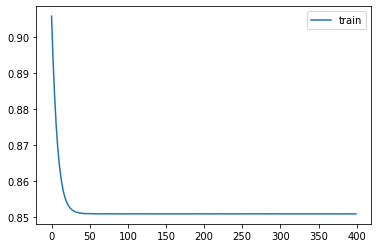

El error con espacio latente de 1 dimensiones da un mse de 0.83 


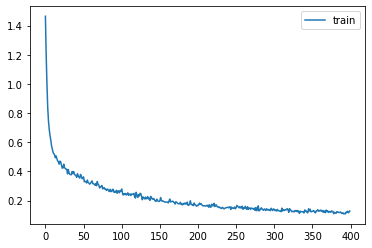

El error con espacio latente de 11 dimensiones da un mse de 0.25 


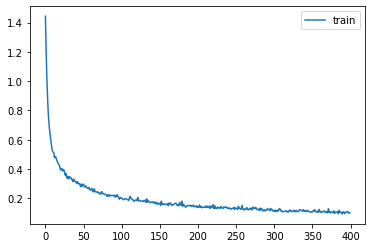

El error con espacio latente de 21 dimensiones da un mse de 0.24 


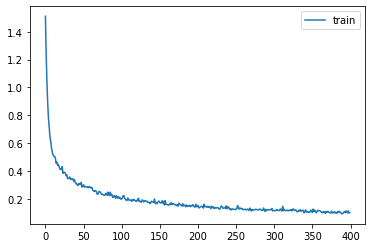

El error con espacio latente de 31 dimensiones da un mse de 0.24 


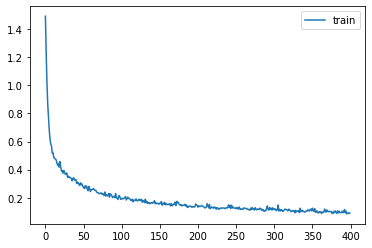

El error con espacio latente de 41 dimensiones da un mse de 0.23 


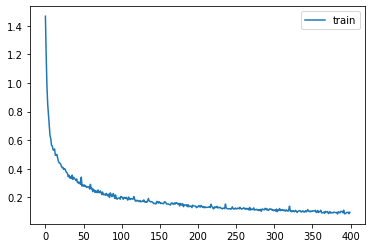

El error con espacio latente de 51 dimensiones da un mse de 0.21 


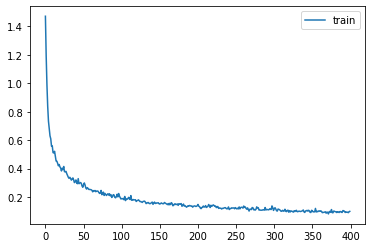

El error con espacio latente de 61 dimensiones da un mse de 0.21 


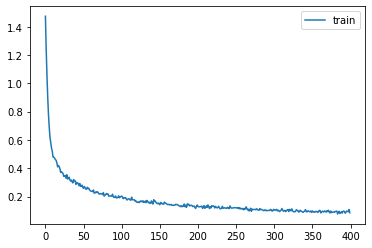

El error con espacio latente de 71 dimensiones da un mse de 0.23 


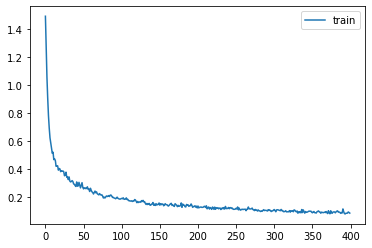

El error con espacio latente de 81 dimensiones da un mse de 0.20 


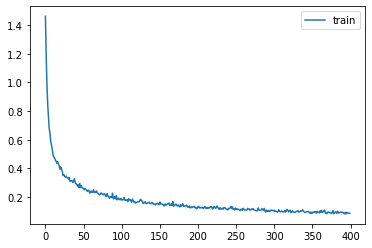

El error con espacio latente de 91 dimensiones da un mse de 0.22 


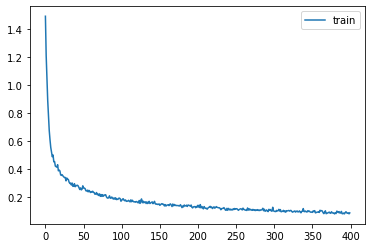

El error con espacio latente de 101 dimensiones da un mse de 0.20 


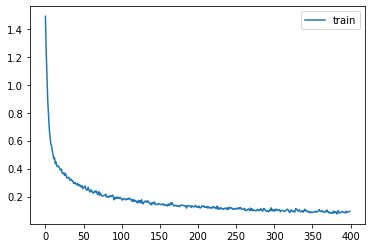

El error con espacio latente de 111 dimensiones da un mse de 0.22 


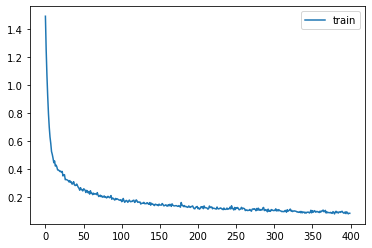

El error con espacio latente de 121 dimensiones da un mse de 0.20 


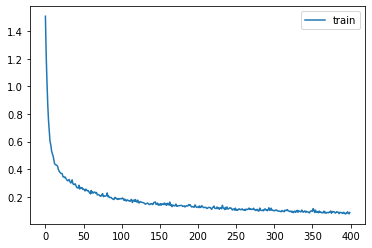

El error con espacio latente de 131 dimensiones da un mse de 0.21 


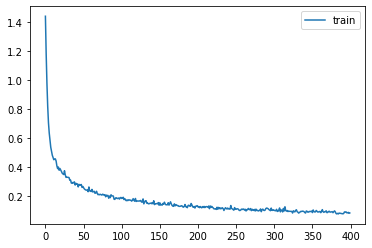

El error con espacio latente de 141 dimensiones da un mse de 0.20 


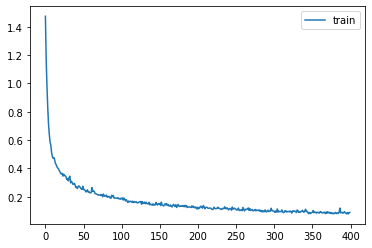

El error con espacio latente de 151 dimensiones da un mse de 0.22 


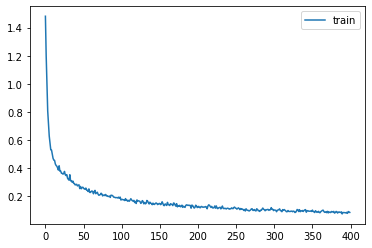

El error con espacio latente de 161 dimensiones da un mse de 0.20 


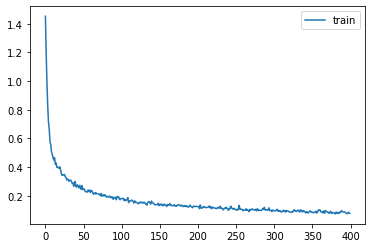

El error con espacio latente de 171 dimensiones da un mse de 0.22 


In [19]:
# Ella lo hace con 70, así que yo también lo voy a hacer con 70
df_val_se_stand = None
#lo junto todo para probar parámetros
dimension_h = [x for x in range(1,180,10)]
fn_perdida = tf.keras.losses.MeanSquaredError()
Epochs = 400
batchs = 32
l2_lista = 1e-4 #lo último que hice fue jugar con esto y los mejores resultados 1e-5/1e-7
listamse = []
for i in dimension_h:
    precisiontest = probarmodelo(df_train_se,df_val_se_stand,i,df_test_se,Epochs,batchs,l2_lista)
    listamse.append([i,precisiontest[0].numpy()])
    print("El error con espacio latente de {} dimensiones da un mse de {:.2f} ".format(i,precisiontest[0].numpy()))



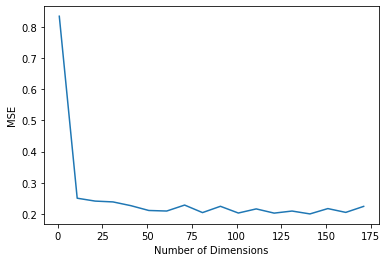

In [20]:
x = [i[0] for i in listamse]
y = [i[1] for i in listamse]

# Plot the data
plt.plot(x, y)

# Add x and y axis labels
plt.xlabel('Number of Dimensions')
plt.ylabel('MSE')

# Show the plot
plt.show()

In [21]:
encoder = precisiontest[2]

Ya tenemos el encoder entrenado, ahora procedemos a extraer las características con él.

In [22]:
# esta celda no es exactamente igual a la de ella, en lugar de usar sus dataset con las características extraídas
# por ella, usamos los nuestros
X_train = encoder.predict(df_train_se,verbose=False)
X_test = encoder.predict(df_test_se,verbose=False)
Y_train = df_train_e
Y_test = df_test_e


# A partir de aquí volvemos a usar el código del TFG para comparar los resultados

In [23]:
out = 'Class'
seed = 42 
np.random.seed(seed)

In [24]:
# Tested models (baseline)
models =  [LogisticRegression(random_state=seed, n_jobs=-1),
          LinearDiscriminantAnalysis(),
          QuadraticDiscriminantAnalysis(),
          
          DecisionTreeClassifier(random_state=seed),
                     
          SGDClassifier(loss='log',random_state=seed, n_jobs=-1),
          NuSVC(random_state=seed, probability=True),
          SVC(random_state=seed, probability=True),
          
          KNeighborsClassifier(n_jobs=-1),
          GaussianProcessClassifier(random_state=seed, n_jobs=-1),
          GaussianNB(),
          
          GradientBoostingClassifier(),
          BaggingClassifier(random_state=seed),
          AdaBoostClassifier(random_state=seed),
          RandomForestClassifier(n_jobs=-1, random_state=seed),
           
          MLPClassifier(random_state=seed),
          ]

In [25]:
# Create a dataframe for ML scores
df_ML = pd.DataFrame(columns=['Method', 'ACC', 'AUROC', 'Precision', 'Recall', 'F1-score'])

In [26]:
# Fit each model
for model in models:
    print("\n***", model)
    ACC, AUROC, precision, recall, f1score = ML_score(model, X_train, Y_train, X_test, Y_test, seed)
    df_ML = df_ML.append({'Method': str(type(model).__name__),
                          'ACC': float(ACC),
                          'AUROC': float(AUROC),
                          'Precision': float(precision),
                          'Recall': float(recall),
                          'F1-score': float(f1score)}, ignore_index=True)
df_ML


*** LogisticRegression(n_jobs=-1, random_state=42)
> Training time: 0.00 mins


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/


*** LinearDiscriminantAnalysis()
> Training time: 0.00 mins

*** QuadraticDiscriminantAnalysis()
> Training time: 0.00 mins

*** DecisionTreeClassifier(random_state=42)
> Training time: 0.00 mins


/tmp/ipykernel_2062797/2978086970.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_ML = df_ML.append({'Method': str(type(model).__name__),
/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/tmp/ipykernel_2062797/2978086970.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_ML = df_ML.append({'Method': str(type(model).__name__),
/tmp/ipykernel_2062797/2978086970.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_ML = df_ML.append({'Method': str(type(model).__name__),
/tmp/ipykernel_2062797/2978086970.py:5


*** SGDClassifier(loss='log', n_jobs=-1, random_state=42)
> Training time: 0.00 mins

*** NuSVC(probability=True, random_state=42)
> Training time: 0.00 mins

*** SVC(probability=True, random_state=42)
> Training time: 0.00 mins

*** KNeighborsClassifier(n_jobs=-1)
> Training time: 0.00 mins

*** GaussianProcessClassifier(n_jobs=-1, random_state=42)
> Training time: 0.00 mins


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/


*** GaussianNB()
> Training time: 0.00 mins

*** GradientBoostingClassifier()
> Training time: 0.00 mins


/tmp/ipykernel_2062797/2978086970.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_ML = df_ML.append({'Method': str(type(model).__name__),
/tmp/ipykernel_2062797/2978086970.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_ML = df_ML.append({'Method': str(type(model).__name__),



*** BaggingClassifier(random_state=42)
> Training time: 0.00 mins

*** AdaBoostClassifier(random_state=42)
> Training time: 0.00 mins


/tmp/ipykernel_2062797/2978086970.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_ML = df_ML.append({'Method': str(type(model).__name__),
/tmp/ipykernel_2062797/2978086970.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_ML = df_ML.append({'Method': str(type(model).__name__),



*** RandomForestClassifier(n_jobs=-1, random_state=42)
> Training time: 0.00 mins

*** MLPClassifier(random_state=42)
> Training time: 0.00 mins


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/tmp/ipykernel_2062797/2978086970.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_ML = df_ML.append({'Method': str(type(model).__name__),


Method       ACC     AUROC  Precision    Recall  \
0              LogisticRegression  0.782609  0.761111   0.612476  0.782609   
1      LinearDiscriminantAnalysis  0.543478  0.591667   0.677847  0.543478   
2   QuadraticDiscriminantAnalysis  0.717391  0.783333   0.844472  0.717391   
3          DecisionTreeClassifier  0.782609  0.680556   0.782609  0.782609   
4                   SGDClassifier  0.760870  0.783333   0.808322  0.760870   
5                           NuSVC  0.891304  0.869444   0.895991  0.891304   
6                             SVC  0.869565  0.861111   0.863272  0.869565   
7            KNeighborsClassifier  0.847826  0.762500   0.842930  0.847826   
8       GaussianProcessClassifier  0.782609  0.755556   0.612476  0.782609   
9                      GaussianNB  0.739130  0.827778   0.823326  0.739130   
10     GradientBoostingClassifier  0.826087  0.863889   0.826087  0.826087   
11              BaggingClassifier  0.847826  0.779167   0.837554  0.847826   
12             AdaBoostClassifier  0.804348  0.761111   0.811745  0.804348   
13         RandomForestClassifier  0.869565  0.891667   0.869565  0.869565   
14                  MLPClassifier  0.804348  0.722222   0.843478  0.804348   

    F1-score  
0   0.687169  
1   0.583312  
2   0.742050  
3   0.782609  
4   0.775860  
5   0.893127  
6   0.864081  
7   0.844864  
8   0.687169  
9   0.760093  
10  0.826087  
11  0.837442  
12  0.807628  
13  0.869565  
14  0.735178

In [27]:

# Save results
df_ML.to_csv('Scores_rdkit.csv', index_label=False)

In [28]:

mlp = MLPClassifier(random_state=seed)

In [29]:
# GRIDSEARCH SELECTION
# GridSearchCV parameters
params = {
    'activation' : ['identity','logistic', 'tanh', 'relu'],
    'hidden_layer_sizes': [100, 150, 200],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'solver' : ['lbfgs', 'sgd', 'adam'],
    'beta_1': [0.5, 0.7, 0.9],
    'beta_2': [0.5, 0.7, 0.9],
    'epsilon':[0.00001, 0.0001, 0.001]
    
}

In [30]:
# GridSearch fit
gs = GridSearchCV(estimator=mlp, param_grid=params, verbose=10, scoring ='roc_auc', cv=3)

gs.fit(X_train, Y_train)

Fitting 3 folds for each of 2916 candidates, totalling 8748 fits
[CV 1/3; 1/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.738 total time=   2.1s
[CV 2/3; 1/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   1.8s
[CV 3/3; 1/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.642 total time=   1.8s
[CV 1/3; 2/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 2/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.623 total time=   0.2s
[CV 2/3; 2/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 2/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.556 total time=   0.3s
[CV 3/3; 2/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 2/2916] END activation=identity, beta_1=0.5,

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 3/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.666 total time=   0.6s
[CV 2/3; 3/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 3/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.723 total time=   0.5s
[CV 3/3; 3/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 3/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.680 total time=   0.4s
[CV 1/3; 4/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 4/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.738 total time=   3.2s
[CV 2/3; 4/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 4/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   1.6s
[CV 3/3; 4/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 4/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.642 total time=   1.8s
[CV 1/3; 5/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 5/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.1s
[CV 2/3; 5/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 5/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.551 total time=   0.0s
[CV 3/3; 5/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 5/2916] END activation=identity,

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 6/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.666 total time=   0.4s
[CV 2/3; 6/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 6/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.723 total time=   0.4s
[CV 3/3; 6/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 6/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.680 total time=   0.3s
[CV 1/3; 7/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 7/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.738 total time=   1.6s
[CV 2/3; 7/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 7/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   1.6s
[CV 3/3; 7/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 7/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.642 total time=   2.0s
[CV 1/3; 8/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 8/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.623 total time=   0.3s
[CV 2/3; 8/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 8/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.555 total time=   0.4s
[CV 3/3; 8/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 8/2916] END activation=identity, beta_1=0.5,

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 9/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.666 total time=   0.8s
[CV 2/3; 9/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 9/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.723 total time=   0.7s
[CV 3/3; 9/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 9/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.680 total time=   0.6s
[CV 1/3; 10/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 10/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.722 total time=   3.9s
[CV 2/3; 10/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 2/3; 10/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.823 total time=   2.9s
[CV 3/3; 10/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 10/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.630 total time=   2.8s
[CV 1/3; 11/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 11/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.568 total time=   0.5s
[CV 2/3; 11/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 11/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.578 total time=   0.7s
[CV 3/3; 11/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 11/2916] END activation=identity, beta

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 12/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.667 total time=   0.5s
[CV 2/3; 12/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 12/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.730 total time=   0.6s
[CV 3/3; 12/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 12/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.691 total time=   0.8s
[CV 1/3; 13/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 13/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.722 total time=   3.7s
[CV 2/3; 13/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 13/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.823 total time=   3.3s
[CV 3/3; 13/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 13/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.630 total time=   3.6s
[CV 1/3; 14/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 14/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.1s
[CV 2/3; 14/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 14/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.570 total time=   0.0s
[CV 3/3; 14/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 14/2916] END activation=id

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 15/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.667 total time=   1.0s
[CV 2/3; 15/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 15/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.730 total time=   0.7s
[CV 3/3; 15/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 15/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.691 total time=   0.4s
[CV 1/3; 16/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 16/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.722 total time=   2.9s
[CV 2/3; 16/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 16/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.823 total time=   2.6s
[CV 3/3; 16/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 16/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.630 total time=   2.4s
[CV 1/3; 17/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 17/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.571 total time=   0.9s
[CV 2/3; 17/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 17/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   0.5s
[CV 3/3; 17/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 17/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.313 total time=   0.4s
[CV 1/3; 18/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 18/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.667 total time=   0.4s
[CV 2/3; 18/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 18/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.730 total time=   0.9s
[CV 3/3; 18/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 18/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.691 total time=   0.5s
[CV 1/3; 19/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 19/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.745 total time=   2.8s
[CV 2/3; 19/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 19/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.791 total time=   5.1s
[CV 3/3; 19/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 19/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.625 total time=   1.8s
[CV 1/3; 20/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 20/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   0.4s
[CV 2/3; 20/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 20/2916] END activation=identity, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 21/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.678 total time=   0.8s
[CV 2/3; 21/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 21/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.735 total time=   0.6s
[CV 3/3; 21/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 21/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.701 total time=   0.8s
[CV 1/3; 22/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 22/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.745 total time=   3.2s
[CV 2/3; 22/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 22/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.791 total time=   3.7s
[CV 3/3; 22/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 22/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.625 total time=   2.1s
[CV 1/3; 23/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 23/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.1s
[CV 2/3; 23/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 23/2916] END activatio

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 24/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.678 total time=   0.4s
[CV 2/3; 24/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 24/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.735 total time=   0.8s
[CV 3/3; 24/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 24/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.701 total time=   0.6s
[CV 1/3; 25/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 25/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.745 total time=   4.2s
[CV 2/3; 25/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 25/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.791 total time=   3.0s
[CV 3/3; 25/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 25/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.625 total time=   2.5s
[CV 1/3; 26/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 26/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.484 total time=   0.4s
[CV 2/3; 26/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 26/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.580 total time=   0.4s
[CV 3/3; 26/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 26/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.424 total time=   0.7s
[CV 1/3; 27/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 27/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.678 total time=   0.7s
[CV 2/3; 27/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 27/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.735 total time=   0.8s
[CV 3/3; 27/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 27/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.701 total time=   0.9s
[CV 1/3; 28/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 28/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.738 total time=   2.4s
[CV 2/3; 28/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 28/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   2.4s
[CV 3/3; 28/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 28/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.642 total time=   2.5s
[CV 1/3; 29/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 29/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.623 total time=   0.4s
[CV 2/3; 29/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 29/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.556 total time=   0.2s
[CV 3/3; 29/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 29/2916] END activation=identity

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 30/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.688 total time=   0.4s
[CV 2/3; 30/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 30/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.673 total time=   0.4s
[CV 3/3; 30/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 30/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.645 total time=   0.8s
[CV 1/3; 31/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 31/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.738 total time=   2.5s
[CV 2/3; 31/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 31/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   3.0s
[CV 3/3; 31/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 31/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.642 total time=   2.6s
[CV 1/3; 32/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 32/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.1s
[CV 2/3; 32/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 32/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.551 total time=   0.0s
[CV 3/3; 32/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 32/2916] END activat

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 33/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.688 total time=   0.5s
[CV 2/3; 33/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 33/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.673 total time=   0.4s
[CV 3/3; 33/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 33/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.645 total time=   0.9s
[CV 1/3; 34/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 34/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.738 total time=   2.4s
[CV 2/3; 34/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 34/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   2.3s
[CV 3/3; 34/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 34/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.642 total time=   3.3s
[CV 1/3; 35/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 35/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.623 total time=   0.4s
[CV 2/3; 35/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 35/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.555 total time=   0.3s
[CV 3/3; 35/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 35/2916] END activation=identity

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 36/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.688 total time=   1.0s
[CV 2/3; 36/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 36/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.673 total time=   0.5s
[CV 3/3; 36/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 36/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.645 total time=   0.4s
[CV 1/3; 37/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 37/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.722 total time=   2.5s
[CV 2/3; 37/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 2/3; 37/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.823 total time=   2.9s
[CV 3/3; 37/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 37/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.630 total time=   2.4s
[CV 1/3; 38/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 38/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.568 total time=   0.9s
[CV 2/3; 38/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 38/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.578 total time=   0.5s
[CV 3/3; 38/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 38/2916] END activation=identity

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 39/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.698 total time=   0.5s
[CV 2/3; 39/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 39/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.678 total time=   0.8s
[CV 3/3; 39/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 39/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.643 total time=   0.5s
[CV 1/3; 40/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 40/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.722 total time=   3.1s
[CV 2/3; 40/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 40/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.823 total time=   2.7s
[CV 3/3; 40/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 40/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.630 total time=   3.3s
[CV 1/3; 41/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 41/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.1s
[CV 2/3; 41/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 41/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.570 total time=   0.1s
[CV 3/3; 41/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 41/2916] END activat

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 42/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.698 total time=   0.6s
[CV 2/3; 42/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 42/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.678 total time=   0.9s
[CV 3/3; 42/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 42/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.643 total time=   0.8s
[CV 1/3; 43/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 43/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.722 total time=   2.7s
[CV 2/3; 43/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 43/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.823 total time=   2.9s
[CV 3/3; 43/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 43/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.630 total time=   3.4s
[CV 1/3; 44/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 44/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.571 total time=   0.6s
[CV 2/3; 44/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 44/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   0.6s
[CV 3/3; 44/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 44/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.313 total time=   0.4s
[CV 1/3; 45/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 45/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.698 total time=   0.7s
[CV 2/3; 45/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 45/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.678 total time=   0.6s
[CV 3/3; 45/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 45/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.643 total time=   0.5s
[CV 1/3; 46/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 46/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.745 total time=   5.1s
[CV 2/3; 46/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 46/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.791 total time=   4.2s
[CV 3/3; 46/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 46/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.625 total time=   2.3s
[CV 1/3; 47/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 47/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   0.4s
[CV 2/3; 47/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 47/2916] END activation=iden

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 48/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.696 total time=   0.7s
[CV 2/3; 48/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 48/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.685 total time=   0.9s
[CV 3/3; 48/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 48/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.652 total time=   0.7s
[CV 1/3; 49/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 49/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.745 total time=   2.8s
[CV 2/3; 49/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 49/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.791 total time=   2.8s
[CV 3/3; 49/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 49/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.625 total time=   2.6s
[CV 1/3; 50/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 50/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.1s
[CV 2/3; 50/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 50/2916] END act

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 51/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.696 total time=   0.5s
[CV 2/3; 51/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 51/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.685 total time=   0.8s
[CV 3/3; 51/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 51/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.652 total time=   0.5s
[CV 1/3; 52/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 52/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.745 total time=   3.8s
[CV 2/3; 52/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 52/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.791 total time=   3.0s
[CV 3/3; 52/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 52/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.625 total time=   2.3s
[CV 1/3; 53/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 53/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.484 total time=   0.6s
[CV 2/3; 53/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 53/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.580 total time=   0.4s
[CV 3/3; 53/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 53/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.424 total time=   0.6s
[CV 1/3; 54/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 54/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.696 total time=   0.7s
[CV 2/3; 54/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 54/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.685 total time=   0.8s
[CV 3/3; 54/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 54/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.652 total time=   0.8s
[CV 1/3; 55/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 55/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.738 total time=   2.3s
[CV 2/3; 55/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 55/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   2.8s
[CV 3/3; 55/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 55/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.642 total time=   2.9s
[CV 1/3; 56/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 56/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.623 total time=   0.3s
[CV 2/3; 56/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 56/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.556 total time=   0.3s
[CV 3/3; 56/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 56/2916] END activation=identity, beta

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 58/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.738 total time=   1.9s
[CV 2/3; 58/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 58/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   1.8s
[CV 3/3; 58/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 58/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.642 total time=   1.9s
[CV 1/3; 59/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 59/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.0s
[CV 2/3; 59/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 59/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.551 total time=   0.0s
[CV 3/3; 59/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 59/2916] END activation=id

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 61/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.738 total time=   2.1s
[CV 2/3; 61/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 61/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   2.8s
[CV 3/3; 61/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 61/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.642 total time=   2.5s
[CV 1/3; 62/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 62/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.623 total time=   0.3s
[CV 2/3; 62/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 62/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.555 total time=   0.3s
[CV 3/3; 62/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 62/2916] END activation=identity, beta

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 64/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.722 total time=   2.7s
[CV 2/3; 64/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 2/3; 64/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.823 total time=   3.0s
[CV 3/3; 64/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 64/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.630 total time=   2.8s
[CV 1/3; 65/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 65/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.568 total time=   0.5s
[CV 2/3; 65/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 65/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.578 total time=   0.8s
[CV 3/3; 65/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 65/2916] END activation=identity, beta

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 67/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.722 total time=   2.8s
[CV 2/3; 67/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 67/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.823 total time=   2.2s
[CV 3/3; 67/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 67/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.630 total time=   3.0s
[CV 1/3; 68/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 68/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.1s
[CV 2/3; 68/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 68/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.570 total time=   0.0s
[CV 3/3; 68/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 68/2916] END activation=id

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 70/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.722 total time=   2.4s
[CV 2/3; 70/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 70/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.823 total time=   2.2s
[CV 3/3; 70/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 70/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.630 total time=   3.1s
[CV 1/3; 71/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 71/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.571 total time=   0.5s
[CV 2/3; 71/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 71/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   0.3s
[CV 3/3; 71/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 71/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.313 total time=   0.7s
[CV 1/3; 72/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 1/3; 72/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.732 total time=   0.2s
[CV 2/3; 72/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 2/3; 72/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.665 total time=   0.2s
[CV 3/3; 72/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 3/3; 72/2916] END activation=identity, b

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 73/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.745 total time=   3.7s
[CV 2/3; 73/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 73/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.791 total time=   3.0s
[CV 3/3; 73/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 73/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.625 total time=   1.7s
[CV 1/3; 74/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 74/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   0.4s
[CV 2/3; 74/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 74/2916] END activation=identity, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 75/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.661 total time=   0.5s
[CV 3/3; 75/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam
[CV 3/3; 75/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.524 total time=   0.3s
[CV 1/3; 76/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 76/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.745 total time=   3.9s
[CV 2/3; 76/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 76/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.791 total time=   3.6s
[CV 3/3; 76/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 76/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.625 total time=   3.2s
[CV 1/3; 77/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 77/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.1s
[CV 2/3; 77/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 77/2916] END activatio

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 78/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.661 total time=   0.5s
[CV 3/3; 78/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam
[CV 3/3; 78/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.524 total time=   0.1s
[CV 1/3; 79/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 79/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.745 total time=   4.9s
[CV 2/3; 79/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 79/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.791 total time=   4.4s
[CV 3/3; 79/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 79/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.625 total time=   2.3s
[CV 1/3; 80/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 80/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.484 total time=   0.4s
[CV 2/3; 80/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 80/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.580 total time=   0.5s
[CV 3/3; 80/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 80/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.424 total time=   0.4s
[CV 1/3; 81/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 1/3; 81/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.634 total time=   0.1s
[CV 2/3; 81/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 81/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.661 total time=   0.6s
[CV 3/3; 81/2916] START activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 3/3; 81/2916] END activation=identity, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.524 total time=   0.1s
[CV 1/3; 82/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 82/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.738 total time=   2.8s
[CV 2/3; 82/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 82/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   3.3s
[CV 3/3; 82/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 82/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.642 total time=   3.4s
[CV 1/3; 83/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 83/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.623 total time=   0.2s
[CV 2/3; 83/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 83/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.556 total time=   0.2s
[CV 3/3; 83/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 83/2916] END activation=identity, beta

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 84/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.668 total time=   0.7s
[CV 2/3; 84/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 84/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.724 total time=   0.4s
[CV 3/3; 84/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 84/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.680 total time=   0.5s
[CV 1/3; 85/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 85/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.738 total time=   2.2s
[CV 2/3; 85/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 85/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   1.8s
[CV 3/3; 85/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 85/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.642 total time=   1.6s
[CV 1/3; 86/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 86/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.0s
[CV 2/3; 86/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 86/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.551 total time=   0.0s
[CV 3/3; 86/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 86/2916] END activation=id

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 87/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.668 total time=   0.4s
[CV 2/3; 87/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 87/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.724 total time=   0.4s
[CV 3/3; 87/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 87/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.680 total time=   0.9s
[CV 1/3; 88/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 88/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.738 total time=   2.2s
[CV 2/3; 88/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 88/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   2.1s
[CV 3/3; 88/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 88/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.642 total time=   2.9s
[CV 1/3; 89/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 89/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.623 total time=   0.5s
[CV 2/3; 89/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 89/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.555 total time=   0.4s
[CV 3/3; 89/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 89/2916] END activation=identity, beta

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 90/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.668 total time=   0.5s
[CV 2/3; 90/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 90/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.724 total time=   1.0s
[CV 3/3; 90/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 90/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.680 total time=   0.5s
[CV 1/3; 91/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 91/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.722 total time=   2.5s
[CV 2/3; 91/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 2/3; 91/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.823 total time=   3.5s
[CV 3/3; 91/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 91/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.630 total time=   3.3s
[CV 1/3; 92/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 92/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.568 total time=   0.5s
[CV 2/3; 92/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 92/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.578 total time=   0.3s
[CV 3/3; 92/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 92/2916] END activation=identity, beta

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 93/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.671 total time=   0.7s
[CV 2/3; 93/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 93/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.730 total time=   0.4s
[CV 3/3; 93/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 93/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.691 total time=   0.5s
[CV 1/3; 94/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 94/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.722 total time=   4.0s
[CV 2/3; 94/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 94/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.823 total time=   3.4s
[CV 3/3; 94/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 94/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.630 total time=   2.5s
[CV 1/3; 95/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 95/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.1s
[CV 2/3; 95/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 95/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.570 total time=   0.0s
[CV 3/3; 95/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 95/2916] END activation=id

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 96/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.671 total time=   0.8s
[CV 2/3; 96/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 96/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.730 total time=   1.0s
[CV 3/3; 96/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 96/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.691 total time=   0.5s
[CV 1/3; 97/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 97/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.722 total time=   2.2s
[CV 2/3; 97/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 97/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.823 total time=   2.8s
[CV 3/3; 97/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 97/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.630 total time=   2.3s
[CV 1/3; 98/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 98/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.571 total time=   0.5s
[CV 2/3; 98/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 98/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   0.7s
[CV 3/3; 98/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 98/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.313 total time=   0.7s
[CV 1/3; 99/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 99/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.671 total time=   0.5s
[CV 2/3; 99/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 99/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.730 total time=   0.5s
[CV 3/3; 99/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 99/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.691 total time=   0.9s
[CV 1/3; 100/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 100/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.745 total time=   4.0s
[CV 2/3; 100/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 100/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.791 total time=   3.4s
[CV 3/3; 100/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 100/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.625 total time=   2.8s
[CV 1/3; 101/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 101/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   0.3s
[CV 2/3; 101/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 101/2916] END activation=ide

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 102/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.677 total time=   0.4s
[CV 2/3; 102/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 102/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.735 total time=   0.6s
[CV 3/3; 102/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 102/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.701 total time=   0.5s
[CV 1/3; 103/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 103/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.745 total time=   3.7s
[CV 2/3; 103/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 103/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.791 total time=   4.1s
[CV 3/3; 103/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 103/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.625 total time=   3.1s
[CV 1/3; 104/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 104/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.1s
[CV 2/3; 104/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 104/2916] END ac

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 105/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.677 total time=   0.4s
[CV 2/3; 105/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 105/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.735 total time=   0.7s
[CV 3/3; 105/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 105/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.701 total time=   0.6s
[CV 1/3; 106/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 106/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.745 total time=   3.2s
[CV 2/3; 106/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 106/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.791 total time=   3.0s
[CV 3/3; 106/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 106/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.625 total time=   2.4s
[CV 1/3; 107/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 107/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.484 total time=   0.5s
[CV 2/3; 107/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 107/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.580 total time=   1.0s
[CV 3/3; 107/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 107/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.424 total time=   0.6s
[CV 1/3; 108/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 108/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.677 total time=   0.4s
[CV 2/3; 108/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 108/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.735 total time=   0.9s
[CV 3/3; 108/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 108/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.701 total time=   0.6s
[CV 1/3; 109/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 109/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.738 total time=   3.0s
[CV 2/3; 109/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 109/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   2.5s
[CV 3/3; 109/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 109/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.642 total time=   2.4s
[CV 1/3; 110/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 110/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.623 total time=   0.2s
[CV 2/3; 110/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 110/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.556 total time=   0.3s
[CV 3/3; 110/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 110/2916] END activation=i

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 111/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.688 total time=   1.0s
[CV 2/3; 111/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 111/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.673 total time=   0.6s
[CV 3/3; 111/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 111/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.645 total time=   0.6s
[CV 1/3; 112/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 112/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.738 total time=   2.2s
[CV 2/3; 112/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 112/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   2.6s
[CV 3/3; 112/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 112/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.642 total time=   2.7s
[CV 1/3; 113/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 113/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.1s
[CV 2/3; 113/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 113/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.551 total time=   0.0s
[CV 3/3; 113/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 113/2916] END 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 114/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.688 total time=   1.1s
[CV 2/3; 114/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 114/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.673 total time=   0.5s
[CV 3/3; 114/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 114/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.645 total time=   0.6s
[CV 1/3; 115/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 115/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.738 total time=   1.9s
[CV 2/3; 115/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 115/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   2.4s
[CV 3/3; 115/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 115/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.642 total time=   2.1s
[CV 1/3; 116/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 116/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.623 total time=   0.3s
[CV 2/3; 116/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 116/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.555 total time=   0.2s
[CV 3/3; 116/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 116/2916] END activation=i

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 117/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.688 total time=   0.4s
[CV 2/3; 117/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 117/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.673 total time=   0.8s
[CV 3/3; 117/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 117/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.645 total time=   0.6s
[CV 1/3; 118/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 118/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.722 total time=   3.3s
[CV 2/3; 118/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 2/3; 118/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.823 total time=   2.6s
[CV 3/3; 118/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 118/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.630 total time=   2.8s
[CV 1/3; 119/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 119/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.568 total time=   0.9s
[CV 2/3; 119/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 119/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.578 total time=   0.5s
[CV 3/3; 119/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 119/2916] END activation=i

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 120/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.698 total time=   0.8s
[CV 2/3; 120/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 120/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.678 total time=   0.6s
[CV 3/3; 120/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 120/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.643 total time=   0.5s
[CV 1/3; 121/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 121/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.722 total time=   4.1s
[CV 2/3; 121/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 121/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.823 total time=   3.4s
[CV 3/3; 121/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 121/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.630 total time=   2.2s
[CV 1/3; 122/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 122/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.1s
[CV 2/3; 122/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 122/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.570 total time=   0.1s
[CV 3/3; 122/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 122/2916] END 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 123/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.698 total time=   0.9s
[CV 2/3; 123/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 123/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.678 total time=   0.7s
[CV 3/3; 123/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 123/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.643 total time=   0.7s
[CV 1/3; 124/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 124/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.722 total time=   3.5s
[CV 2/3; 124/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 124/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.823 total time=   2.3s
[CV 3/3; 124/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 124/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.630 total time=   3.2s
[CV 1/3; 125/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 125/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.571 total time=   0.5s
[CV 2/3; 125/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 125/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   0.4s
[CV 3/3; 125/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 125/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.313 total time=   0.9s
[CV 1/3; 126/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 126/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.698 total time=   0.4s
[CV 2/3; 126/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 126/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.678 total time=   0.4s
[CV 3/3; 126/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 126/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.643 total time=   0.9s
[CV 1/3; 127/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 127/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.745 total time=   3.6s
[CV 2/3; 127/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 127/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.791 total time=   3.9s
[CV 3/3; 127/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 127/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.625 total time=   3.0s
[CV 1/3; 128/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 128/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   0.4s
[CV 2/3; 128/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 128/2916] END activati

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 129/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.698 total time=   0.7s
[CV 2/3; 129/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 129/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.684 total time=   0.9s
[CV 3/3; 129/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 129/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.651 total time=   0.5s
[CV 1/3; 130/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 130/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.745 total time=   2.8s
[CV 2/3; 130/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 130/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.791 total time=   2.7s
[CV 3/3; 130/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 130/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.625 total time=   1.4s
[CV 1/3; 131/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 131/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.1s
[CV 2/3; 131/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 131/2916] 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 132/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.698 total time=   1.0s
[CV 2/3; 132/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 132/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.684 total time=   0.5s
[CV 3/3; 132/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 132/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.651 total time=   0.8s
[CV 1/3; 133/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 133/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.745 total time=   4.4s
[CV 2/3; 133/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 133/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.791 total time=   7.0s
[CV 3/3; 133/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 133/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.625 total time=   3.3s
[CV 1/3; 134/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 134/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.484 total time=   0.6s
[CV 2/3; 134/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 134/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.580 total time=   1.0s
[CV 3/3; 134/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 134/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.424 total time=   0.6s
[CV 1/3; 135/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 135/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.698 total time=   0.5s
[CV 2/3; 135/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 135/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.684 total time=   1.3s
[CV 3/3; 135/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 135/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.651 total time=   0.5s
[CV 1/3; 136/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 136/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.738 total time=   3.0s
[CV 2/3; 136/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 136/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   2.6s
[CV 3/3; 136/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 136/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.642 total time=   2.7s
[CV 1/3; 137/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 137/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.623 total time=   0.4s
[CV 2/3; 137/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 137/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.556 total time=   0.5s
[CV 3/3; 137/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 137/2916] END activation=identit

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 139/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.738 total time=   3.4s
[CV 2/3; 139/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 139/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   3.0s
[CV 3/3; 139/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 139/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.642 total time=   3.4s
[CV 1/3; 140/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 140/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.1s
[CV 2/3; 140/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 140/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.551 total time=   0.1s
[CV 3/3; 140/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 140/2916] END activa

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 142/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.738 total time=   2.9s
[CV 2/3; 142/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 142/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   2.5s
[CV 3/3; 142/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 142/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.642 total time=   3.4s
[CV 1/3; 143/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 143/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.623 total time=   0.4s
[CV 2/3; 143/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 143/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.555 total time=   0.3s
[CV 3/3; 143/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 143/2916] END activation=identit

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 145/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.722 total time=   2.2s
[CV 2/3; 145/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 2/3; 145/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.823 total time=   3.2s
[CV 3/3; 145/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 145/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.630 total time=   4.0s
[CV 1/3; 146/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 146/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.568 total time=   0.8s
[CV 2/3; 146/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 146/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.578 total time=   0.6s
[CV 3/3; 146/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 146/2916] END activation=identit

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 148/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.722 total time=   3.4s
[CV 2/3; 148/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 148/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.823 total time=   2.0s
[CV 3/3; 148/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 148/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.630 total time=   3.7s
[CV 1/3; 149/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 149/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.1s
[CV 2/3; 149/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 149/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.570 total time=   0.1s
[CV 3/3; 149/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 149/2916] END activa

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 151/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.722 total time=   3.7s
[CV 2/3; 151/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 151/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.823 total time=   2.1s
[CV 3/3; 151/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 151/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.630 total time=   3.3s
[CV 1/3; 152/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 152/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.571 total time=   0.5s
[CV 2/3; 152/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 152/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   0.4s
[CV 3/3; 152/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 152/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.313 total time=   0.7s
[CV 1/3; 153/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 1/3; 153/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.735 total time=   0.2s
[CV 2/3; 153/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 2/3; 153/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.668 total time=   0.2s
[CV 3/3; 153/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 3/3; 153/2916] END activation=iden

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 154/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.745 total time=   3.0s
[CV 2/3; 154/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 154/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.791 total time=   5.2s
[CV 3/3; 154/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 154/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.625 total time=   1.8s
[CV 1/3; 155/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 155/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   0.3s
[CV 2/3; 155/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 155/2916] END activation=ide

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 156/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.661 total time=   0.6s
[CV 3/3; 156/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam
[CV 3/3; 156/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.529 total time=   0.1s
[CV 1/3; 157/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 157/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.745 total time=   3.6s
[CV 2/3; 157/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 157/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.791 total time=   4.3s
[CV 3/3; 157/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 157/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.625 total time=   2.0s
[CV 1/3; 158/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 158/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.1s
[CV 2/3; 158/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 158/2916] END ac

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 159/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.661 total time=   0.9s
[CV 3/3; 159/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam
[CV 3/3; 159/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.529 total time=   0.2s
[CV 1/3; 160/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 160/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.745 total time=   3.8s
[CV 2/3; 160/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 160/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.791 total time=   3.7s
[CV 3/3; 160/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 160/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.625 total time=   1.7s
[CV 1/3; 161/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 161/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.484 total time=   0.7s
[CV 2/3; 161/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 161/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.580 total time=   0.5s
[CV 3/3; 161/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 161/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.424 total time=   0.5s
[CV 1/3; 162/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 1/3; 162/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.639 total time=   0.1s
[CV 2/3; 162/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 162/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.661 total time=   1.0s
[CV 3/3; 162/2916] START activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 3/3; 162/2916] END activation=identity, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.529 total time=   0.1s
[CV 1/3; 163/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 163/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.738 total time=   2.1s
[CV 2/3; 163/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 163/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   1.6s
[CV 3/3; 163/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 163/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.642 total time=   2.1s
[CV 1/3; 164/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 164/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.623 total time=   0.2s
[CV 2/3; 164/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 164/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.556 total time=   0.2s
[CV 3/3; 164/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 164/2916] END activation=identit

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 165/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.667 total time=   0.4s
[CV 2/3; 165/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 165/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.726 total time=   0.8s
[CV 3/3; 165/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 165/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.679 total time=   0.3s
[CV 1/3; 166/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 166/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.738 total time=   2.2s
[CV 2/3; 166/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 166/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   2.0s
[CV 3/3; 166/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 166/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.642 total time=   2.0s
[CV 1/3; 167/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 167/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.0s
[CV 2/3; 167/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 167/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.551 total time=   0.0s
[CV 3/3; 167/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 167/2916] END activa

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 168/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.667 total time=   0.6s
[CV 2/3; 168/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 168/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.726 total time=   0.8s
[CV 3/3; 168/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 168/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.679 total time=   0.4s
[CV 1/3; 169/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 169/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.738 total time=   2.5s
[CV 2/3; 169/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 169/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   3.4s
[CV 3/3; 169/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 169/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.642 total time=   2.1s
[CV 1/3; 170/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 170/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.623 total time=   0.4s
[CV 2/3; 170/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 170/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.555 total time=   0.4s
[CV 3/3; 170/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 170/2916] END activation=identit

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 171/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.667 total time=   0.7s
[CV 2/3; 171/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 171/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.726 total time=   0.4s
[CV 3/3; 171/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 171/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.679 total time=   0.5s
[CV 1/3; 172/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 172/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.722 total time=   3.3s
[CV 2/3; 172/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 2/3; 172/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.823 total time=   3.2s
[CV 3/3; 172/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 172/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.630 total time=   2.6s
[CV 1/3; 173/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 173/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.568 total time=   0.4s
[CV 2/3; 173/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 173/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.578 total time=   0.4s
[CV 3/3; 173/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 173/2916] END activation=identit

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 174/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.679 total time=   0.5s
[CV 2/3; 174/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 174/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.730 total time=   0.5s
[CV 3/3; 174/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 174/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.687 total time=   0.9s
[CV 1/3; 175/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 175/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.722 total time=   2.6s
[CV 2/3; 175/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 175/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.823 total time=   1.8s
[CV 3/3; 175/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 175/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.630 total time=   3.3s
[CV 1/3; 176/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 176/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.1s
[CV 2/3; 176/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 176/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.570 total time=   0.1s
[CV 3/3; 176/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 176/2916] END activa

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 177/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.679 total time=   0.6s
[CV 2/3; 177/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 177/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.730 total time=   0.5s
[CV 3/3; 177/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 177/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.687 total time=   1.0s
[CV 1/3; 178/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 178/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.722 total time=   3.0s
[CV 2/3; 178/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 178/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.823 total time=   2.7s
[CV 3/3; 178/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 178/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.630 total time=   3.0s
[CV 1/3; 179/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 179/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.571 total time=   0.4s
[CV 2/3; 179/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 179/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   0.8s
[CV 3/3; 179/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 179/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.313 total time=   0.7s
[CV 1/3; 180/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 180/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.679 total time=   0.5s
[CV 2/3; 180/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 180/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.730 total time=   0.9s
[CV 3/3; 180/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 180/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.687 total time=   0.5s
[CV 1/3; 181/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 181/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.745 total time=   3.6s
[CV 2/3; 181/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 181/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.791 total time=   3.3s
[CV 3/3; 181/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 181/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.625 total time=   2.7s
[CV 1/3; 182/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 182/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   0.3s
[CV 2/3; 182/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 182/2916] END activation=ide

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 183/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.678 total time=   0.9s
[CV 2/3; 183/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 183/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.738 total time=   0.9s
[CV 3/3; 183/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 183/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.698 total time=   0.7s
[CV 1/3; 184/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 184/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.745 total time=   4.1s
[CV 2/3; 184/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 184/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.791 total time=   3.0s
[CV 3/3; 184/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 184/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.625 total time=   2.8s
[CV 1/3; 185/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 185/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.2s
[CV 2/3; 185/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 185/2916] END ac

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 186/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.678 total time=   0.6s
[CV 2/3; 186/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 186/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.738 total time=   0.4s
[CV 3/3; 186/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 186/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.698 total time=   0.7s
[CV 1/3; 187/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 187/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.745 total time=   4.0s
[CV 2/3; 187/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 187/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.791 total time=   4.3s
[CV 3/3; 187/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 187/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.625 total time=   1.9s
[CV 1/3; 188/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 188/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.484 total time=   0.6s
[CV 2/3; 188/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 188/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.580 total time=   0.4s
[CV 3/3; 188/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 188/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.424 total time=   0.3s
[CV 1/3; 189/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 189/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.678 total time=   0.9s
[CV 2/3; 189/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 189/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.738 total time=   0.7s
[CV 3/3; 189/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 189/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.698 total time=   0.5s
[CV 1/3; 190/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 190/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.738 total time=   3.1s
[CV 2/3; 190/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 190/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   2.8s
[CV 3/3; 190/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 190/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.642 total time=   2.6s
[CV 1/3; 191/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 191/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.623 total time=   0.3s
[CV 2/3; 191/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 191/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.556 total time=   0.3s
[CV 3/3; 191/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 191/2916] END activation=i

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 192/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.690 total time=   0.5s
[CV 2/3; 192/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 192/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.668 total time=   0.7s
[CV 3/3; 192/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 192/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.644 total time=   0.6s
[CV 1/3; 193/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 193/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.738 total time=   3.4s
[CV 2/3; 193/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 193/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   2.5s
[CV 3/3; 193/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 193/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.642 total time=   3.1s
[CV 1/3; 194/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 194/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.0s
[CV 2/3; 194/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 194/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.551 total time=   0.0s
[CV 3/3; 194/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 194/2916] END 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 195/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.690 total time=   0.6s
[CV 2/3; 195/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 195/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.668 total time=   0.4s
[CV 3/3; 195/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 195/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.644 total time=   0.5s
[CV 1/3; 196/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 196/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.738 total time=   2.0s
[CV 2/3; 196/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 196/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   2.4s
[CV 3/3; 196/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 196/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.642 total time=   1.9s
[CV 1/3; 197/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 197/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.623 total time=   0.9s
[CV 2/3; 197/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 197/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.555 total time=   0.5s
[CV 3/3; 197/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 197/2916] END activation=i

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 198/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.690 total time=   0.6s
[CV 2/3; 198/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 198/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.668 total time=   0.7s
[CV 3/3; 198/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 198/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.644 total time=   0.5s
[CV 1/3; 199/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 199/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.722 total time=   4.4s
[CV 2/3; 199/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 2/3; 199/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.823 total time=   3.6s
[CV 3/3; 199/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 199/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.630 total time=   2.7s
[CV 1/3; 200/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 200/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.568 total time=   0.6s
[CV 2/3; 200/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 200/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.578 total time=   0.3s
[CV 3/3; 200/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 200/2916] END activation=i

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 201/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.699 total time=   0.8s
[CV 2/3; 201/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 201/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.673 total time=   0.5s
[CV 3/3; 201/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 201/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.641 total time=   0.6s
[CV 1/3; 202/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 202/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.722 total time=   3.9s
[CV 2/3; 202/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 202/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.823 total time=   3.1s
[CV 3/3; 202/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 202/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.630 total time=   2.7s
[CV 1/3; 203/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 203/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.1s
[CV 2/3; 203/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 203/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.570 total time=   0.1s
[CV 3/3; 203/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 203/2916] END 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 204/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.699 total time=   0.5s
[CV 2/3; 204/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 204/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.673 total time=   1.0s
[CV 3/3; 204/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 204/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.641 total time=   0.5s
[CV 1/3; 205/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 205/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.722 total time=   3.3s
[CV 2/3; 205/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 205/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.823 total time=   2.2s
[CV 3/3; 205/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 205/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.630 total time=   2.5s
[CV 1/3; 206/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 206/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.571 total time=   0.5s
[CV 2/3; 206/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 206/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   0.7s
[CV 3/3; 206/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 206/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.313 total time=   0.5s
[CV 1/3; 207/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 207/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.699 total time=   0.4s
[CV 2/3; 207/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 207/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.673 total time=   1.0s
[CV 3/3; 207/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 207/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.641 total time=   0.6s
[CV 1/3; 208/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 208/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.745 total time=   3.8s
[CV 2/3; 208/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 208/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.791 total time=   2.8s
[CV 3/3; 208/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 208/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.625 total time=   2.0s
[CV 1/3; 209/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 209/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   0.6s
[CV 2/3; 209/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 209/2916] END activati

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 210/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.691 total time=   0.5s
[CV 2/3; 210/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 210/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.683 total time=   1.0s
[CV 3/3; 210/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 210/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.650 total time=   0.5s
[CV 1/3; 211/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 211/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.745 total time=   4.1s
[CV 2/3; 211/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 211/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.791 total time=   3.2s
[CV 3/3; 211/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 211/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.625 total time=   2.3s
[CV 1/3; 212/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 212/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.1s
[CV 2/3; 212/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 212/2916] 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 213/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.691 total time=   0.5s
[CV 2/3; 213/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 213/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.683 total time=   0.9s
[CV 3/3; 213/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 213/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.650 total time=   0.6s
[CV 1/3; 214/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 214/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.745 total time=   3.7s
[CV 2/3; 214/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 214/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.791 total time=   3.3s
[CV 3/3; 214/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 214/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.625 total time=   1.7s
[CV 1/3; 215/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 215/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.484 total time=   0.7s
[CV 2/3; 215/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 215/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.580 total time=   0.5s
[CV 3/3; 215/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 215/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.424 total time=   0.7s
[CV 1/3; 216/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 216/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.691 total time=   1.0s
[CV 2/3; 216/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 216/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.683 total time=   0.5s
[CV 3/3; 216/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 216/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.650 total time=   0.4s
[CV 1/3; 217/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 217/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.738 total time=   2.8s
[CV 2/3; 217/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 217/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   2.2s
[CV 3/3; 217/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 217/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.642 total time=   2.6s
[CV 1/3; 218/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 218/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.623 total time=   0.3s
[CV 2/3; 218/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 218/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.556 total time=   0.6s
[CV 3/3; 218/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 218/2916] END activation=identit

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 220/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.738 total time=   2.5s
[CV 2/3; 220/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 220/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   2.5s
[CV 3/3; 220/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 220/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.642 total time=   1.9s
[CV 1/3; 221/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 221/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.2s
[CV 2/3; 221/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 221/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.551 total time=   0.2s
[CV 3/3; 221/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 221/2916] END activa

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 223/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.738 total time=   2.9s
[CV 2/3; 223/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 223/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   1.9s
[CV 3/3; 223/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 223/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.642 total time=   2.5s
[CV 1/3; 224/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 224/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.623 total time=   0.5s
[CV 2/3; 224/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 224/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.555 total time=   0.3s
[CV 3/3; 224/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 224/2916] END activation=identit

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 226/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.722 total time=   3.2s
[CV 2/3; 226/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 2/3; 226/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.823 total time=   2.1s
[CV 3/3; 226/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 226/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.630 total time=   3.7s
[CV 1/3; 227/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 227/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.568 total time=   0.4s
[CV 2/3; 227/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 227/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.578 total time=   0.4s
[CV 3/3; 227/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 227/2916] END activation=identit

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 229/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.722 total time=   3.4s
[CV 2/3; 229/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 229/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.823 total time=   3.6s
[CV 3/3; 229/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 229/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.630 total time=   4.0s
[CV 1/3; 230/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 230/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.1s
[CV 2/3; 230/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 230/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.570 total time=   0.1s
[CV 3/3; 230/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 230/2916] END activa

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 232/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.722 total time=   4.1s
[CV 2/3; 232/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 232/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.823 total time=   3.4s
[CV 3/3; 232/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 232/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.630 total time=   2.6s
[CV 1/3; 233/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 233/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.571 total time=   0.4s
[CV 2/3; 233/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 233/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   0.8s
[CV 3/3; 233/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 233/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.313 total time=   0.5s
[CV 1/3; 234/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 1/3; 234/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.743 total time=   0.1s
[CV 2/3; 234/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 2/3; 234/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.677 total time=   0.2s
[CV 3/3; 234/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 3/3; 234/2916] END activation=iden

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 235/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.745 total time=   3.0s
[CV 2/3; 235/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 235/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.791 total time=   4.2s
[CV 3/3; 235/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 235/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.625 total time=   1.9s
[CV 1/3; 236/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 236/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   0.3s
[CV 2/3; 236/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 236/2916] END activation=ide

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 238/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.745 total time=   4.6s
[CV 2/3; 238/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 238/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.791 total time=   3.6s
[CV 3/3; 238/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 238/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.625 total time=   2.6s
[CV 1/3; 239/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 239/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.1s
[CV 2/3; 239/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 239/2916] END ac

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 241/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.745 total time=   3.2s
[CV 2/3; 241/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 241/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.791 total time=   2.7s
[CV 3/3; 241/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 241/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.625 total time=   2.2s
[CV 1/3; 242/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 242/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.484 total time=   0.4s
[CV 2/3; 242/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 242/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.580 total time=   0.6s
[CV 3/3; 242/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 242/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.424 total time=   0.8s
[CV 1/3; 243/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 1/3; 243/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.640 total time=   0.1s
[CV 2/3; 243/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 2/3; 243/2916] END activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.696 total time=   0.2s
[CV 3/3; 243/2916] START activation=identity, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 3/3; 243/2916] END activation=iden

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 244/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.738 total time=   2.3s
[CV 2/3; 244/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 244/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   3.0s
[CV 3/3; 244/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 244/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.642 total time=   1.9s
[CV 1/3; 245/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 245/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.623 total time=   0.3s
[CV 2/3; 245/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 245/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.556 total time=   0.5s
[CV 3/3; 245/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 245/2916] END activation=identit

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 246/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.665 total time=   0.5s
[CV 2/3; 246/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 246/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.721 total time=   0.7s
[CV 3/3; 246/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 246/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.678 total time=   0.4s
[CV 1/3; 247/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 247/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.738 total time=   2.5s
[CV 2/3; 247/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 247/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   1.9s
[CV 3/3; 247/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 247/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.642 total time=   1.9s
[CV 1/3; 248/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 248/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.0s
[CV 2/3; 248/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 248/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.551 total time=   0.0s
[CV 3/3; 248/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 248/2916] END activa

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 249/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.665 total time=   0.9s
[CV 2/3; 249/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 249/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.721 total time=   0.6s
[CV 3/3; 249/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 249/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.678 total time=   0.4s
[CV 1/3; 250/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 250/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.738 total time=   2.0s
[CV 2/3; 250/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 250/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   2.6s
[CV 3/3; 250/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 250/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.642 total time=   2.3s
[CV 1/3; 251/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 251/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.623 total time=   0.3s
[CV 2/3; 251/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 251/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.555 total time=   0.4s
[CV 3/3; 251/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 251/2916] END activation=identit

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 252/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.665 total time=   1.0s
[CV 2/3; 252/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 252/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.721 total time=   0.6s
[CV 3/3; 252/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 252/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.678 total time=   0.5s
[CV 1/3; 253/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 253/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.722 total time=   3.9s
[CV 2/3; 253/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 2/3; 253/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.823 total time=   2.1s
[CV 3/3; 253/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 253/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.630 total time=   3.2s
[CV 1/3; 254/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 254/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.568 total time=   0.4s
[CV 2/3; 254/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 254/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.578 total time=   0.4s
[CV 3/3; 254/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 254/2916] END activation=identit

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 255/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.666 total time=   0.6s
[CV 2/3; 255/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 255/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.730 total time=   0.5s
[CV 3/3; 255/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 255/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.685 total time=   0.4s
[CV 1/3; 256/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 256/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.722 total time=   3.7s
[CV 2/3; 256/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 256/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.823 total time=   2.3s
[CV 3/3; 256/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 256/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.630 total time=   2.9s
[CV 1/3; 257/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 257/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.1s
[CV 2/3; 257/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 257/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.570 total time=   0.1s
[CV 3/3; 257/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 257/2916] END activa

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 258/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.666 total time=   0.5s
[CV 2/3; 258/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 258/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.730 total time=   0.5s
[CV 3/3; 258/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 258/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.685 total time=   0.8s
[CV 1/3; 259/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 259/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.722 total time=   3.5s
[CV 2/3; 259/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 259/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.823 total time=   2.2s
[CV 3/3; 259/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 259/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.630 total time=   2.5s
[CV 1/3; 260/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 260/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.571 total time=   0.4s
[CV 2/3; 260/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 260/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   0.4s
[CV 3/3; 260/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 260/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.313 total time=   0.9s
[CV 1/3; 261/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 261/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.666 total time=   0.7s
[CV 2/3; 261/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 261/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.730 total time=   0.7s
[CV 3/3; 261/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 261/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.685 total time=   0.8s
[CV 1/3; 262/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 262/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.745 total time=   4.8s
[CV 2/3; 262/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 262/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.791 total time=   3.7s
[CV 3/3; 262/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 262/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.625 total time=   2.3s
[CV 1/3; 263/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 263/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   0.7s
[CV 2/3; 263/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 263/2916] END activation=ide

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 264/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.678 total time=   0.6s
[CV 2/3; 264/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 264/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.730 total time=   1.0s
[CV 3/3; 264/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 264/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.698 total time=   0.8s
[CV 1/3; 265/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 265/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.745 total time=   4.4s
[CV 2/3; 265/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 265/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.791 total time=   3.5s
[CV 3/3; 265/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 265/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.625 total time=   2.6s
[CV 1/3; 266/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 266/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.1s
[CV 2/3; 266/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 266/2916] END ac

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 267/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.678 total time=   0.7s
[CV 2/3; 267/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 267/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.730 total time=   0.5s
[CV 3/3; 267/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 267/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.698 total time=   0.5s
[CV 1/3; 268/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 268/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.745 total time=   3.5s
[CV 2/3; 268/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 268/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.791 total time=   4.4s
[CV 3/3; 268/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 268/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.625 total time=   3.0s
[CV 1/3; 269/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 269/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.484 total time=   0.6s
[CV 2/3; 269/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 269/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.580 total time=   0.6s
[CV 3/3; 269/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 269/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.424 total time=   0.9s
[CV 1/3; 270/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 270/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.678 total time=   0.5s
[CV 2/3; 270/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 270/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.730 total time=   0.5s
[CV 3/3; 270/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 270/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.698 total time=   0.9s
[CV 1/3; 271/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 271/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.738 total time=   2.5s
[CV 2/3; 271/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 271/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   2.0s
[CV 3/3; 271/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 271/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.642 total time=   1.5s
[CV 1/3; 272/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 272/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.623 total time=   0.2s
[CV 2/3; 272/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 272/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.556 total time=   0.6s
[CV 3/3; 272/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 272/2916] END activation=i

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 273/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.690 total time=   0.9s
[CV 2/3; 273/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 273/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.672 total time=   0.5s
[CV 3/3; 273/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 273/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.644 total time=   0.5s
[CV 1/3; 274/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 274/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.738 total time=   2.9s
[CV 2/3; 274/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 274/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   2.8s
[CV 3/3; 274/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 274/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.642 total time=   2.4s
[CV 1/3; 275/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 275/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.0s
[CV 2/3; 275/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 275/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.551 total time=   0.0s
[CV 3/3; 275/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 275/2916] END 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 276/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.690 total time=   0.7s
[CV 2/3; 276/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 276/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.672 total time=   0.5s
[CV 3/3; 276/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 276/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.644 total time=   0.4s
[CV 1/3; 277/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 277/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.738 total time=   3.6s
[CV 2/3; 277/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 277/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   2.0s
[CV 3/3; 277/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 277/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.642 total time=   2.2s
[CV 1/3; 278/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 278/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.623 total time=   0.6s
[CV 2/3; 278/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 278/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.555 total time=   0.8s
[CV 3/3; 278/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 278/2916] END activation=i

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 279/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.690 total time=   0.4s
[CV 2/3; 279/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 279/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.672 total time=   0.4s
[CV 3/3; 279/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 279/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.644 total time=   0.9s
[CV 1/3; 280/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 280/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.722 total time=   3.6s
[CV 2/3; 280/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 2/3; 280/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.823 total time=   2.5s
[CV 3/3; 280/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 280/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.630 total time=   3.9s
[CV 1/3; 281/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 281/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.568 total time=   0.4s
[CV 2/3; 281/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 281/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.578 total time=   0.3s
[CV 3/3; 281/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 281/2916] END activation=i

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 282/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.698 total time=   1.0s
[CV 2/3; 282/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 282/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.674 total time=   0.5s
[CV 3/3; 282/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 282/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.641 total time=   0.8s
[CV 1/3; 283/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 283/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.722 total time=   2.3s
[CV 2/3; 283/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 283/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.823 total time=   2.4s
[CV 3/3; 283/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 283/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.630 total time=   2.4s
[CV 1/3; 284/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 284/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.1s
[CV 2/3; 284/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 284/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.570 total time=   0.0s
[CV 3/3; 284/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 284/2916] END 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 285/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.698 total time=   1.1s
[CV 2/3; 285/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 285/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.674 total time=   0.6s
[CV 3/3; 285/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 285/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.641 total time=   0.7s
[CV 1/3; 286/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 286/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.722 total time=   4.3s
[CV 2/3; 286/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 286/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.823 total time=   2.3s
[CV 3/3; 286/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 286/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.630 total time=   2.9s
[CV 1/3; 287/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 287/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.571 total time=   0.8s
[CV 2/3; 287/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 287/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   0.4s
[CV 3/3; 287/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 287/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.313 total time=   0.4s
[CV 1/3; 288/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 288/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.698 total time=   0.6s
[CV 2/3; 288/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 288/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.674 total time=   0.7s
[CV 3/3; 288/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 288/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.641 total time=   0.6s
[CV 1/3; 289/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 289/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.745 total time=   4.5s
[CV 2/3; 289/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 289/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.791 total time=   4.6s
[CV 3/3; 289/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 289/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.625 total time=   2.6s
[CV 1/3; 290/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 290/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   0.6s
[CV 2/3; 290/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 290/2916] END activati

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 291/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.696 total time=   0.6s
[CV 2/3; 291/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 291/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.679 total time=   1.0s
[CV 3/3; 291/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 291/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.652 total time=   1.1s
[CV 1/3; 292/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 292/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.745 total time=   3.8s
[CV 2/3; 292/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 292/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.791 total time=   3.3s
[CV 3/3; 292/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 292/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.625 total time=   2.0s
[CV 1/3; 293/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 293/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.1s
[CV 2/3; 293/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 293/2916] 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 294/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.696 total time=   0.5s
[CV 2/3; 294/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 294/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.679 total time=   0.8s
[CV 3/3; 294/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 294/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.652 total time=   0.6s
[CV 1/3; 295/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 295/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.745 total time=   4.1s
[CV 2/3; 295/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 295/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.791 total time=   2.7s
[CV 3/3; 295/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 295/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.625 total time=   1.7s
[CV 1/3; 296/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 296/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.484 total time=   0.4s
[CV 2/3; 296/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 296/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.580 total time=   0.9s
[CV 3/3; 296/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 296/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.424 total time=   0.5s
[CV 1/3; 297/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 297/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.696 total time=   0.6s
[CV 2/3; 297/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 297/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.679 total time=   1.0s
[CV 3/3; 297/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 297/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.652 total time=   0.9s
[CV 1/3; 298/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 298/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.738 total time=   3.2s
[CV 2/3; 298/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 298/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   2.5s
[CV 3/3; 298/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 298/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.642 total time=   1.9s
[CV 1/3; 299/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 299/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.623 total time=   0.3s
[CV 2/3; 299/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 299/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.556 total time=   0.5s
[CV 3/3; 299/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 299/2916] END activation=identit

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 301/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.738 total time=   2.8s
[CV 2/3; 301/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 301/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   2.4s
[CV 3/3; 301/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 301/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.642 total time=   2.7s
[CV 1/3; 302/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 302/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.1s
[CV 2/3; 302/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 302/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.551 total time=   0.0s
[CV 3/3; 302/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 302/2916] END activa

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 304/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.738 total time=   2.7s
[CV 2/3; 304/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 304/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   1.6s
[CV 3/3; 304/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 304/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.642 total time=   2.3s
[CV 1/3; 305/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 305/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.623 total time=   0.5s
[CV 2/3; 305/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 305/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.555 total time=   0.3s
[CV 3/3; 305/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 305/2916] END activation=identit

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 307/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.722 total time=   3.2s
[CV 2/3; 307/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 2/3; 307/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.823 total time=   2.4s
[CV 3/3; 307/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 307/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.630 total time=   3.7s
[CV 1/3; 308/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 308/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.568 total time=   0.5s
[CV 2/3; 308/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 308/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.578 total time=   0.4s
[CV 3/3; 308/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 308/2916] END activation=identit

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 310/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.722 total time=   3.3s
[CV 2/3; 310/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 310/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.823 total time=   3.5s
[CV 3/3; 310/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 310/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.630 total time=   3.5s
[CV 1/3; 311/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 311/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.1s
[CV 2/3; 311/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 311/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.570 total time=   0.0s
[CV 3/3; 311/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 311/2916] END activa

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 313/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.722 total time=   3.1s
[CV 2/3; 313/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 313/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.823 total time=   2.3s
[CV 3/3; 313/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 313/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.630 total time=   3.1s
[CV 1/3; 314/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 314/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.571 total time=   0.3s
[CV 2/3; 314/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 314/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   0.4s
[CV 3/3; 314/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 314/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.313 total time=   0.4s
[CV 1/3; 315/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 1/3; 315/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.737 total time=   0.4s
[CV 2/3; 315/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 2/3; 315/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.672 total time=   0.5s
[CV 3/3; 315/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 3/3; 315/2916] END activation=iden

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 316/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.745 total time=   3.2s
[CV 2/3; 316/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 316/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.791 total time=   3.5s
[CV 3/3; 316/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 316/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.625 total time=   2.4s
[CV 1/3; 317/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 317/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   0.8s
[CV 2/3; 317/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 317/2916] END activation=ide

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 318/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.660 total time=   0.7s
[CV 3/3; 318/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam
[CV 3/3; 318/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.534 total time=   0.2s
[CV 1/3; 319/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 319/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.745 total time=   3.9s
[CV 2/3; 319/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 319/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.791 total time=   4.3s
[CV 3/3; 319/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 319/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.625 total time=   2.4s
[CV 1/3; 320/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 320/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.1s
[CV 2/3; 320/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 320/2916] END ac

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 321/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.660 total time=   0.6s
[CV 3/3; 321/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam
[CV 3/3; 321/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.534 total time=   0.1s
[CV 1/3; 322/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 322/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.745 total time=   3.6s
[CV 2/3; 322/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 322/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.791 total time=   4.1s
[CV 3/3; 322/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 322/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.625 total time=   1.8s
[CV 1/3; 323/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 323/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.484 total time=   0.5s
[CV 2/3; 323/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 323/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.580 total time=   0.9s
[CV 3/3; 323/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 323/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.424 total time=   0.9s
[CV 1/3; 324/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 1/3; 324/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.640 total time=   0.1s
[CV 2/3; 324/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 324/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.660 total time=   0.6s
[CV 3/3; 324/2916] START activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 3/3; 324/2916] END activation=identity, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.534 total time=   0.4s
[CV 1/3; 325/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 325/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.738 total time=   2.5s
[CV 2/3; 325/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 325/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   2.3s
[CV 3/3; 325/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 325/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.642 total time=   2.6s
[CV 1/3; 326/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 326/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.623 total time=   0.6s
[CV 2/3; 326/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 326/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.556 total time=   0.5s
[CV 3/3; 326/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 326/2916] END activation=identit

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 327/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.665 total time=   0.5s
[CV 2/3; 327/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 327/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.722 total time=   0.8s
[CV 3/3; 327/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 327/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.679 total time=   0.6s
[CV 1/3; 328/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 328/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.738 total time=   2.8s
[CV 2/3; 328/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 328/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   2.9s
[CV 3/3; 328/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 328/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.642 total time=   1.7s
[CV 1/3; 329/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 329/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.1s
[CV 2/3; 329/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 329/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.551 total time=   0.0s
[CV 3/3; 329/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 329/2916] END activa

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 330/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.665 total time=   0.4s
[CV 2/3; 330/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 330/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.722 total time=   0.4s
[CV 3/3; 330/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 330/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.679 total time=   0.4s
[CV 1/3; 331/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 331/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.738 total time=   2.1s
[CV 2/3; 331/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 331/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   2.6s
[CV 3/3; 331/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 331/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.642 total time=   2.5s
[CV 1/3; 332/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 332/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.623 total time=   0.4s
[CV 2/3; 332/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 332/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.555 total time=   0.4s
[CV 3/3; 332/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 332/2916] END activation=identit

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 333/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.665 total time=   0.8s
[CV 2/3; 333/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 333/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.722 total time=   0.5s
[CV 3/3; 333/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 333/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.679 total time=   1.0s
[CV 1/3; 334/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 334/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.722 total time=   2.8s
[CV 2/3; 334/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 2/3; 334/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.823 total time=   2.1s
[CV 3/3; 334/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 334/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.630 total time=   2.2s
[CV 1/3; 335/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 335/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.568 total time=   0.6s
[CV 2/3; 335/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 335/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.578 total time=   0.5s
[CV 3/3; 335/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 335/2916] END activation=identit

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 336/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.670 total time=   0.4s
[CV 2/3; 336/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 336/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.729 total time=   1.0s
[CV 3/3; 336/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 336/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.688 total time=   0.5s
[CV 1/3; 337/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 337/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.722 total time=   3.2s
[CV 2/3; 337/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 337/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.823 total time=   2.7s
[CV 3/3; 337/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 337/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.630 total time=   2.6s
[CV 1/3; 338/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 338/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.1s
[CV 2/3; 338/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 338/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.570 total time=   0.1s
[CV 3/3; 338/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 338/2916] END activa

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 339/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.670 total time=   0.6s
[CV 2/3; 339/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 339/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.729 total time=   0.5s
[CV 3/3; 339/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 339/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.688 total time=   0.4s
[CV 1/3; 340/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 340/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.722 total time=   3.3s
[CV 2/3; 340/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 340/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.823 total time=   2.9s
[CV 3/3; 340/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 340/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.630 total time=   2.9s
[CV 1/3; 341/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 341/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.571 total time=   0.5s
[CV 2/3; 341/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 341/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   0.5s
[CV 3/3; 341/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 341/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.313 total time=   0.7s
[CV 1/3; 342/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 342/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.670 total time=   0.6s
[CV 2/3; 342/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 342/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.729 total time=   0.6s
[CV 3/3; 342/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 342/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.688 total time=   1.0s
[CV 1/3; 343/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 343/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.745 total time=   3.1s
[CV 2/3; 343/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 343/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.791 total time=   3.4s
[CV 3/3; 343/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 343/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.625 total time=   2.2s
[CV 1/3; 344/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 344/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   0.5s
[CV 2/3; 344/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 344/2916] END activation=ide

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 345/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.677 total time=   0.5s
[CV 2/3; 345/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 345/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.732 total time=   0.5s
[CV 3/3; 345/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 345/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.699 total time=   0.9s
[CV 1/3; 346/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 346/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.745 total time=   4.2s
[CV 2/3; 346/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 346/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.791 total time=   3.1s
[CV 3/3; 346/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 346/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.625 total time=   3.1s
[CV 1/3; 347/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 347/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.1s
[CV 2/3; 347/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 347/2916] END ac

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 348/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.677 total time=   0.5s
[CV 2/3; 348/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 348/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.732 total time=   0.9s
[CV 3/3; 348/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 348/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.699 total time=   0.6s
[CV 1/3; 349/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 349/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.745 total time=   3.6s
[CV 2/3; 349/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 349/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.791 total time=   3.3s
[CV 3/3; 349/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 349/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.625 total time=   3.0s
[CV 1/3; 350/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 350/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.484 total time=   0.4s
[CV 2/3; 350/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 350/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.580 total time=   0.6s
[CV 3/3; 350/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 350/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.424 total time=   0.7s
[CV 1/3; 351/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 351/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.677 total time=   0.4s
[CV 2/3; 351/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 351/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.732 total time=   0.4s
[CV 3/3; 351/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 351/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.699 total time=   0.7s
[CV 1/3; 352/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 352/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.738 total time=   2.7s
[CV 2/3; 352/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 352/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   1.7s
[CV 3/3; 352/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 352/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.642 total time=   2.0s
[CV 1/3; 353/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 353/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.623 total time=   0.3s
[CV 2/3; 353/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 353/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.556 total time=   0.3s
[CV 3/3; 353/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 353/2916] END activation=i

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 354/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.689 total time=   0.7s
[CV 2/3; 354/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 354/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.672 total time=   0.7s
[CV 3/3; 354/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 354/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.644 total time=   0.5s
[CV 1/3; 355/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 355/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.738 total time=   2.7s
[CV 2/3; 355/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 355/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   2.3s
[CV 3/3; 355/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 355/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.642 total time=   2.4s
[CV 1/3; 356/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 356/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.0s
[CV 2/3; 356/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 356/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.551 total time=   0.0s
[CV 3/3; 356/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 356/2916] END 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 357/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.689 total time=   0.4s
[CV 2/3; 357/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 357/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.672 total time=   0.4s
[CV 3/3; 357/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 357/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.644 total time=   0.7s
[CV 1/3; 358/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 358/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.738 total time=   1.4s
[CV 2/3; 358/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 358/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   2.9s
[CV 3/3; 358/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 358/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.642 total time=   2.5s
[CV 1/3; 359/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 359/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.623 total time=   0.4s
[CV 2/3; 359/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 359/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.555 total time=   0.9s
[CV 3/3; 359/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 359/2916] END activation=i

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 360/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.689 total time=   0.3s
[CV 2/3; 360/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 360/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.672 total time=   0.8s
[CV 3/3; 360/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 360/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.644 total time=   0.6s
[CV 1/3; 361/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 361/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.722 total time=   3.6s
[CV 2/3; 361/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 2/3; 361/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.823 total time=   2.1s
[CV 3/3; 361/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 361/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.630 total time=   3.8s
[CV 1/3; 362/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 362/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.568 total time=   0.4s
[CV 2/3; 362/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 362/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.578 total time=   0.5s
[CV 3/3; 362/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 362/2916] END activation=i

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 363/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.696 total time=   0.8s
[CV 2/3; 363/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 363/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.673 total time=   0.9s
[CV 3/3; 363/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 363/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.640 total time=   0.8s
[CV 1/3; 364/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 364/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.722 total time=   3.6s
[CV 2/3; 364/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 364/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.823 total time=   3.6s
[CV 3/3; 364/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 364/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.630 total time=   3.3s
[CV 1/3; 365/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 365/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.1s
[CV 2/3; 365/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 365/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.570 total time=   0.0s
[CV 3/3; 365/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 365/2916] END 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 366/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.696 total time=   0.5s
[CV 2/3; 366/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 366/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.673 total time=   0.5s
[CV 3/3; 366/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 366/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.640 total time=   1.0s
[CV 1/3; 367/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 367/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.722 total time=   2.8s
[CV 2/3; 367/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 367/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.823 total time=   3.3s
[CV 3/3; 367/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 367/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.630 total time=   2.9s
[CV 1/3; 368/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 368/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.571 total time=   0.9s
[CV 2/3; 368/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 368/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   0.5s
[CV 3/3; 368/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 368/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.313 total time=   0.4s
[CV 1/3; 369/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 369/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.696 total time=   0.9s
[CV 2/3; 369/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 369/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.673 total time=   0.7s
[CV 3/3; 369/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 369/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.640 total time=   0.4s
[CV 1/3; 370/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 370/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.745 total time=   3.2s
[CV 2/3; 370/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 370/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.791 total time=   4.9s
[CV 3/3; 370/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 370/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.625 total time=   2.8s
[CV 1/3; 371/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 371/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   0.4s
[CV 2/3; 371/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 371/2916] END activati

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 372/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.696 total time=   1.0s
[CV 2/3; 372/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 372/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.682 total time=   0.8s
[CV 3/3; 372/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 372/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.652 total time=   0.8s
[CV 1/3; 373/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 373/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.745 total time=   5.1s
[CV 2/3; 373/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 373/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.791 total time=   4.1s
[CV 3/3; 373/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 373/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.625 total time=   2.1s
[CV 1/3; 374/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 374/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.1s
[CV 2/3; 374/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 374/2916] 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 375/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.696 total time=   0.9s
[CV 2/3; 375/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 375/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.682 total time=   0.6s
[CV 3/3; 375/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 375/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.652 total time=   0.6s
[CV 1/3; 376/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 376/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.745 total time=   3.8s
[CV 2/3; 376/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 376/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.791 total time=   4.3s
[CV 3/3; 376/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 376/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.625 total time=   1.8s
[CV 1/3; 377/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 377/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.484 total time=   0.8s
[CV 2/3; 377/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 377/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.580 total time=   0.7s
[CV 3/3; 377/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 377/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.424 total time=   0.4s
[CV 1/3; 378/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 378/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.696 total time=   0.8s
[CV 2/3; 378/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 378/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.682 total time=   0.4s
[CV 3/3; 378/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 378/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.652 total time=   0.6s
[CV 1/3; 379/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 379/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.738 total time=   3.2s
[CV 2/3; 379/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 379/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   2.6s
[CV 3/3; 379/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 379/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.642 total time=   2.8s
[CV 1/3; 380/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 380/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.623 total time=   0.5s
[CV 2/3; 380/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 380/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.556 total time=   0.3s
[CV 3/3; 380/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 380/2916] END activation=identit

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 382/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.738 total time=   3.0s
[CV 2/3; 382/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 382/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   2.8s
[CV 3/3; 382/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 382/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.642 total time=   2.7s
[CV 1/3; 383/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 383/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.1s
[CV 2/3; 383/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 383/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.551 total time=   0.0s
[CV 3/3; 383/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 383/2916] END activa

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 385/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.738 total time=   2.0s
[CV 2/3; 385/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 385/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   2.1s
[CV 3/3; 385/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 385/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.642 total time=   1.7s
[CV 1/3; 386/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 386/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.623 total time=   0.3s
[CV 2/3; 386/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 386/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.555 total time=   0.3s
[CV 3/3; 386/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 386/2916] END activation=identit

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 388/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.722 total time=   3.1s
[CV 2/3; 388/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 2/3; 388/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.823 total time=   2.9s
[CV 3/3; 388/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 388/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.630 total time=   3.7s
[CV 1/3; 389/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 389/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.568 total time=   0.3s
[CV 2/3; 389/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 389/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.578 total time=   0.9s
[CV 3/3; 389/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 389/2916] END activation=identit

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 391/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.722 total time=   3.7s
[CV 2/3; 391/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 391/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.823 total time=   3.3s
[CV 3/3; 391/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 391/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.630 total time=   2.7s
[CV 1/3; 392/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 392/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.1s
[CV 2/3; 392/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 392/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.570 total time=   0.0s
[CV 3/3; 392/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 392/2916] END activa

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 394/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.722 total time=   2.4s
[CV 2/3; 394/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 394/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.823 total time=   2.5s
[CV 3/3; 394/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 394/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.630 total time=   2.7s
[CV 1/3; 395/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 395/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.571 total time=   0.9s
[CV 2/3; 395/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 395/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   0.7s
[CV 3/3; 395/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 395/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.313 total time=   0.5s
[CV 1/3; 396/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 1/3; 396/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.728 total time=   0.4s
[CV 2/3; 396/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 2/3; 396/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.676 total time=   0.1s
[CV 3/3; 396/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 3/3; 396/2916] END activation=iden

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 397/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.745 total time=   4.0s
[CV 2/3; 397/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 397/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.791 total time=   4.2s
[CV 3/3; 397/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 397/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.625 total time=   2.3s
[CV 1/3; 398/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 398/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   0.3s
[CV 2/3; 398/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 398/2916] END activation=ide

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 399/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.661 total time=   0.8s
[CV 3/3; 399/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam
[CV 3/3; 399/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.534 total time=   0.1s
[CV 1/3; 400/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 400/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.745 total time=   3.6s
[CV 2/3; 400/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 400/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.791 total time=   2.9s
[CV 3/3; 400/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 400/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.625 total time=   2.5s
[CV 1/3; 401/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 401/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.1s
[CV 2/3; 401/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 401/2916] END ac

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 402/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.661 total time=   0.7s
[CV 3/3; 402/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam
[CV 3/3; 402/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.534 total time=   0.1s
[CV 1/3; 403/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 403/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.745 total time=   4.0s
[CV 2/3; 403/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 403/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.791 total time=   4.1s
[CV 3/3; 403/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 403/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.625 total time=   2.8s
[CV 1/3; 404/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 404/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.484 total time=   0.6s
[CV 2/3; 404/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 404/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.580 total time=   0.5s
[CV 3/3; 404/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 404/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.424 total time=   0.9s
[CV 1/3; 405/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 1/3; 405/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.641 total time=   0.4s
[CV 2/3; 405/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 405/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.661 total time=   0.5s
[CV 3/3; 405/2916] START activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 3/3; 405/2916] END activation=identity, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.534 total time=   0.1s
[CV 1/3; 406/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 406/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.738 total time=   3.1s
[CV 2/3; 406/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 406/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   2.7s
[CV 3/3; 406/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 406/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.642 total time=   2.6s
[CV 1/3; 407/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 407/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.623 total time=   0.3s
[CV 2/3; 407/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 407/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.556 total time=   0.2s
[CV 3/3; 407/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 407/2916] END activation=identit

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 408/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.667 total time=   0.6s
[CV 2/3; 408/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 408/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.724 total time=   0.4s
[CV 3/3; 408/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 408/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.679 total time=   0.9s
[CV 1/3; 409/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 409/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.738 total time=   2.8s
[CV 2/3; 409/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 409/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   2.9s
[CV 3/3; 409/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 409/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.642 total time=   1.4s
[CV 1/3; 410/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 410/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.0s
[CV 2/3; 410/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 410/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.551 total time=   0.1s
[CV 3/3; 410/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 410/2916] END activa

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 411/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.667 total time=   0.6s
[CV 2/3; 411/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 411/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.724 total time=   0.5s
[CV 3/3; 411/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 411/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.679 total time=   0.6s
[CV 1/3; 412/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 412/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.738 total time=   3.1s
[CV 2/3; 412/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 412/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   2.0s
[CV 3/3; 412/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 412/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.642 total time=   2.2s
[CV 1/3; 413/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 413/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.623 total time=   0.3s
[CV 2/3; 413/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 413/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.555 total time=   0.5s
[CV 3/3; 413/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 413/2916] END activation=identit

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 414/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.667 total time=   0.5s
[CV 2/3; 414/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 414/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.724 total time=   0.4s
[CV 3/3; 414/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 414/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.679 total time=   1.0s
[CV 1/3; 415/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 415/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.722 total time=   3.8s
[CV 2/3; 415/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 2/3; 415/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.823 total time=   4.5s
[CV 3/3; 415/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 415/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.630 total time=   3.1s
[CV 1/3; 416/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 416/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.568 total time=   0.6s
[CV 2/3; 416/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 416/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.578 total time=   0.5s
[CV 3/3; 416/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 416/2916] END activation=identit

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 417/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.676 total time=   0.9s
[CV 2/3; 417/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 417/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.732 total time=   0.7s
[CV 3/3; 417/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 417/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.685 total time=   0.6s
[CV 1/3; 418/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 418/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.722 total time=   3.8s
[CV 2/3; 418/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 418/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.823 total time=   3.5s
[CV 3/3; 418/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 418/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.630 total time=   2.7s
[CV 1/3; 419/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 419/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.0s
[CV 2/3; 419/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 419/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.570 total time=   0.1s
[CV 3/3; 419/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 419/2916] END activa

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 420/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.676 total time=   0.7s
[CV 2/3; 420/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 420/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.732 total time=   0.5s
[CV 3/3; 420/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 420/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.685 total time=   0.4s
[CV 1/3; 421/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 421/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.722 total time=   2.8s
[CV 2/3; 421/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 421/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.823 total time=   2.1s
[CV 3/3; 421/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 421/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.630 total time=   2.1s
[CV 1/3; 422/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 422/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.571 total time=   0.5s
[CV 2/3; 422/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 422/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   0.4s
[CV 3/3; 422/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 422/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.313 total time=   0.6s
[CV 1/3; 423/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 423/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.676 total time=   0.5s
[CV 2/3; 423/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 423/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.732 total time=   0.6s
[CV 3/3; 423/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 423/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.685 total time=   0.4s
[CV 1/3; 424/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 424/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.745 total time=   3.9s
[CV 2/3; 424/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 424/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.791 total time=   3.6s
[CV 3/3; 424/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 424/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.625 total time=   2.1s
[CV 1/3; 425/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 425/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   0.3s
[CV 2/3; 425/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 425/2916] END activation=ide

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 426/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.677 total time=   0.4s
[CV 2/3; 426/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 426/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.734 total time=   0.5s
[CV 3/3; 426/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 426/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.696 total time=   0.7s
[CV 1/3; 427/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 427/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.745 total time=   3.2s
[CV 2/3; 427/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 427/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.791 total time=   4.0s
[CV 3/3; 427/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 427/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.625 total time=   2.5s
[CV 1/3; 428/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 428/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.2s
[CV 2/3; 428/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 428/2916] END ac

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 429/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.677 total time=   0.7s
[CV 2/3; 429/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 429/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.734 total time=   0.5s
[CV 3/3; 429/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 429/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.696 total time=   1.0s
[CV 1/3; 430/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 430/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.745 total time=   4.6s
[CV 2/3; 430/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 430/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.791 total time=   4.1s
[CV 3/3; 430/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 430/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.625 total time=   1.9s
[CV 1/3; 431/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 431/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.484 total time=   0.3s
[CV 2/3; 431/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 431/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.580 total time=   0.7s
[CV 3/3; 431/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 431/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.424 total time=   0.5s
[CV 1/3; 432/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 432/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.677 total time=   0.8s
[CV 2/3; 432/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 432/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.734 total time=   1.0s
[CV 3/3; 432/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 432/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.696 total time=   0.6s
[CV 1/3; 433/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 433/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.738 total time=   3.1s
[CV 2/3; 433/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 433/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   2.9s
[CV 3/3; 433/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 433/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.642 total time=   1.9s
[CV 1/3; 434/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 434/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.623 total time=   0.3s
[CV 2/3; 434/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 434/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.556 total time=   0.3s
[CV 3/3; 434/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 434/2916] END activation=i

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 435/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.690 total time=   0.5s
[CV 2/3; 435/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 435/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.668 total time=   0.5s
[CV 3/3; 435/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 435/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.644 total time=   0.3s
[CV 1/3; 436/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 436/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.738 total time=   1.8s
[CV 2/3; 436/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 436/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   1.9s
[CV 3/3; 436/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 436/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.642 total time=   2.0s
[CV 1/3; 437/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 437/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.0s
[CV 2/3; 437/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 437/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.551 total time=   0.0s
[CV 3/3; 437/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 437/2916] END 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 438/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.690 total time=   0.5s
[CV 2/3; 438/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 438/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.668 total time=   0.6s
[CV 3/3; 438/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 438/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.644 total time=   0.4s
[CV 1/3; 439/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 439/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.738 total time=   3.1s
[CV 2/3; 439/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 439/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   2.4s
[CV 3/3; 439/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 439/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.642 total time=   2.0s
[CV 1/3; 440/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 440/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.623 total time=   0.3s
[CV 2/3; 440/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 440/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.555 total time=   0.4s
[CV 3/3; 440/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 440/2916] END activation=i

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 441/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.690 total time=   0.7s
[CV 2/3; 441/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 441/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.668 total time=   0.5s
[CV 3/3; 441/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 441/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.644 total time=   0.6s
[CV 1/3; 442/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 442/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.722 total time=   3.6s
[CV 2/3; 442/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 2/3; 442/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.823 total time=   2.8s
[CV 3/3; 442/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 442/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.630 total time=   2.6s
[CV 1/3; 443/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 443/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.568 total time=   0.4s
[CV 2/3; 443/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 443/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.578 total time=   0.5s
[CV 3/3; 443/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 443/2916] END activation=i

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 444/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.698 total time=   1.1s
[CV 2/3; 444/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 444/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.671 total time=   0.5s
[CV 3/3; 444/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 444/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.641 total time=   0.4s
[CV 1/3; 445/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 445/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.722 total time=   3.1s
[CV 2/3; 445/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 445/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.823 total time=   2.8s
[CV 3/3; 445/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 445/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.630 total time=   3.1s
[CV 1/3; 446/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 446/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.1s
[CV 2/3; 446/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 446/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.570 total time=   0.1s
[CV 3/3; 446/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 446/2916] END 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 447/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.698 total time=   0.5s
[CV 2/3; 447/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 447/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.671 total time=   0.5s
[CV 3/3; 447/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 447/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.641 total time=   0.8s
[CV 1/3; 448/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 448/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.722 total time=   2.9s
[CV 2/3; 448/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 448/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.823 total time=   3.0s
[CV 3/3; 448/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 448/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.630 total time=   4.9s
[CV 1/3; 449/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 449/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.571 total time=   1.2s
[CV 2/3; 449/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 449/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   1.1s
[CV 3/3; 449/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 449/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.313 total time=   0.8s
[CV 1/3; 450/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 450/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.698 total time=   0.6s
[CV 2/3; 450/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 450/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.671 total time=   0.4s
[CV 3/3; 450/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 450/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.641 total time=   0.7s
[CV 1/3; 451/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 451/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.745 total time=   4.5s
[CV 2/3; 451/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 451/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.791 total time=   4.2s
[CV 3/3; 451/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 451/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.625 total time=   2.3s
[CV 1/3; 452/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 452/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   0.4s
[CV 2/3; 452/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 452/2916] END activati

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 453/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.691 total time=   0.6s
[CV 2/3; 453/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 453/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.683 total time=   0.5s
[CV 3/3; 453/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 453/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.649 total time=   0.7s
[CV 1/3; 454/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 454/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.745 total time=   3.3s
[CV 2/3; 454/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 454/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.791 total time=   3.5s
[CV 3/3; 454/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 454/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.625 total time=   2.3s
[CV 1/3; 455/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 455/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.1s
[CV 2/3; 455/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 455/2916] 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 456/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.691 total time=   0.8s
[CV 2/3; 456/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 456/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.683 total time=   0.5s
[CV 3/3; 456/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 456/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.649 total time=   0.6s
[CV 1/3; 457/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 457/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.745 total time=   3.3s
[CV 2/3; 457/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 457/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.791 total time=   3.9s
[CV 3/3; 457/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 457/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.625 total time=   2.4s
[CV 1/3; 458/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 458/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.484 total time=   0.5s
[CV 2/3; 458/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 458/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.580 total time=   0.9s
[CV 3/3; 458/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 458/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.424 total time=   0.6s
[CV 1/3; 459/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 459/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.691 total time=   0.5s
[CV 2/3; 459/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 459/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.683 total time=   0.6s
[CV 3/3; 459/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 459/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.649 total time=   0.6s
[CV 1/3; 460/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 460/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.738 total time=   2.2s
[CV 2/3; 460/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 460/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   2.0s
[CV 3/3; 460/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 460/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.642 total time=   2.0s
[CV 1/3; 461/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 461/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.623 total time=   0.3s
[CV 2/3; 461/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 461/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.556 total time=   0.3s
[CV 3/3; 461/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 461/2916] END activation=identit

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 463/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.738 total time=   2.8s
[CV 2/3; 463/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 463/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   2.6s
[CV 3/3; 463/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 463/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.642 total time=   2.4s
[CV 1/3; 464/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 464/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.1s
[CV 2/3; 464/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 464/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.551 total time=   0.1s
[CV 3/3; 464/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 464/2916] END activa

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 466/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.738 total time=   2.6s
[CV 2/3; 466/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 466/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   2.7s
[CV 3/3; 466/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 466/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.642 total time=   3.7s
[CV 1/3; 467/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 467/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.623 total time=   0.6s
[CV 2/3; 467/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 467/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.555 total time=   0.4s
[CV 3/3; 467/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 467/2916] END activation=identit

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 469/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.722 total time=   2.9s
[CV 2/3; 469/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 2/3; 469/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.823 total time=   2.3s
[CV 3/3; 469/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 469/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.630 total time=   3.0s
[CV 1/3; 470/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 470/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.568 total time=   0.5s
[CV 2/3; 470/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 470/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.578 total time=   0.4s
[CV 3/3; 470/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 470/2916] END activation=identit

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 472/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.722 total time=   3.4s
[CV 2/3; 472/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 472/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.823 total time=   2.5s
[CV 3/3; 472/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 472/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.630 total time=   2.3s
[CV 1/3; 473/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 473/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.1s
[CV 2/3; 473/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 473/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.570 total time=   0.1s
[CV 3/3; 473/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 473/2916] END activa

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 475/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.722 total time=   3.4s
[CV 2/3; 475/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 475/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.823 total time=   2.6s
[CV 3/3; 475/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 475/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.630 total time=   2.7s
[CV 1/3; 476/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 476/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.571 total time=   0.8s
[CV 2/3; 476/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 476/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   0.4s
[CV 3/3; 476/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 476/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.313 total time=   0.4s
[CV 1/3; 477/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 1/3; 477/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.733 total time=   0.2s
[CV 2/3; 477/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 2/3; 477/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.673 total time=   0.2s
[CV 3/3; 477/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 3/3; 477/2916] END activation=iden

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 478/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.745 total time=   3.4s
[CV 2/3; 478/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 478/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.791 total time=   3.6s
[CV 3/3; 478/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 478/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.625 total time=   1.9s
[CV 1/3; 479/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 479/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   0.4s
[CV 2/3; 479/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 479/2916] END activation=ide

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 481/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.745 total time=   4.3s
[CV 2/3; 481/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 481/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.791 total time=   4.5s
[CV 3/3; 481/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 481/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.625 total time=   2.7s
[CV 1/3; 482/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 482/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.1s
[CV 2/3; 482/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 482/2916] END ac

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 484/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.745 total time=   3.7s
[CV 2/3; 484/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 484/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.791 total time=   3.2s
[CV 3/3; 484/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 484/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.625 total time=   2.1s
[CV 1/3; 485/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 485/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.484 total time=   0.6s
[CV 2/3; 485/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 485/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.580 total time=   0.5s
[CV 3/3; 485/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 485/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.424 total time=   0.8s
[CV 1/3; 486/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 1/3; 486/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.638 total time=   0.1s
[CV 2/3; 486/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 2/3; 486/2916] END activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.704 total time=   0.2s
[CV 3/3; 486/2916] START activation=identity, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 3/3; 486/2916] END activation=iden

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 487/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.738 total time=   3.0s
[CV 2/3; 487/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 487/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   3.0s
[CV 3/3; 487/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 487/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.642 total time=   1.6s
[CV 1/3; 488/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 488/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.623 total time=   0.2s
[CV 2/3; 488/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 488/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.556 total time=   0.2s
[CV 3/3; 488/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 488/2916] END activation=identit

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 489/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.680 total time=   0.4s
[CV 2/3; 489/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 489/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.684 total time=   0.7s
[CV 3/3; 489/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 489/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.668 total time=   0.6s
[CV 1/3; 490/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 490/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.738 total time=   3.1s
[CV 2/3; 490/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 490/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   2.9s
[CV 3/3; 490/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 490/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.642 total time=   2.2s
[CV 1/3; 491/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 491/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.0s
[CV 2/3; 491/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 491/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.551 total time=   0.0s
[CV 3/3; 491/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 491/2916] END activa

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 492/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.680 total time=   0.5s
[CV 2/3; 492/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 492/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.684 total time=   0.9s
[CV 3/3; 492/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 492/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.668 total time=   0.5s
[CV 1/3; 493/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 493/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.738 total time=   2.3s
[CV 2/3; 493/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 493/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   1.8s
[CV 3/3; 493/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 493/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.642 total time=   2.0s
[CV 1/3; 494/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 494/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.623 total time=   0.4s
[CV 2/3; 494/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 494/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.555 total time=   0.5s
[CV 3/3; 494/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 494/2916] END activation=identit

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 495/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.680 total time=   0.6s
[CV 2/3; 495/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 495/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.684 total time=   0.4s
[CV 3/3; 495/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 495/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.668 total time=   0.6s
[CV 1/3; 496/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 496/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.722 total time=   3.4s
[CV 2/3; 496/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 2/3; 496/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.823 total time=   2.9s
[CV 3/3; 496/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 496/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.630 total time=   3.7s
[CV 1/3; 497/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 497/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.568 total time=   0.5s
[CV 2/3; 497/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 497/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.578 total time=   0.5s
[CV 3/3; 497/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 497/2916] END activation=identit

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 499/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.722 total time=   4.2s
[CV 2/3; 499/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 499/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.823 total time=   2.3s
[CV 3/3; 499/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 499/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.630 total time=   3.1s
[CV 1/3; 500/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 500/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.2s
[CV 2/3; 500/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 500/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.570 total time=   0.1s
[CV 3/3; 500/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 500/2916] END activa

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 502/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.722 total time=   3.6s
[CV 2/3; 502/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 502/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.823 total time=   2.5s
[CV 3/3; 502/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 502/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.630 total time=   3.7s
[CV 1/3; 503/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 503/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.571 total time=   0.6s
[CV 2/3; 503/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 503/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   0.5s
[CV 3/3; 503/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 503/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.313 total time=   0.7s
[CV 1/3; 504/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 1/3; 504/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.724 total time=   0.3s
[CV 2/3; 504/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 2/3; 504/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.659 total time=   0.1s
[CV 3/3; 504/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 3/3; 504/2916] END activation=iden

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 505/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.745 total time=   5.0s
[CV 2/3; 505/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 505/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.791 total time=   3.6s
[CV 3/3; 505/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 505/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.625 total time=   3.0s
[CV 1/3; 506/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 506/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   0.7s
[CV 2/3; 506/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 506/2916] END activation=ide

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 508/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.745 total time=   5.1s
[CV 2/3; 508/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 508/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.791 total time=   4.3s
[CV 3/3; 508/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 508/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.625 total time=   2.1s
[CV 1/3; 509/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 509/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.1s
[CV 2/3; 509/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 509/2916] END ac

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 511/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.745 total time=   4.7s
[CV 2/3; 511/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 511/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.791 total time=   3.9s
[CV 3/3; 511/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 511/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.625 total time=   2.6s
[CV 1/3; 512/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 512/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.484 total time=   0.8s
[CV 2/3; 512/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 512/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.580 total time=   0.5s
[CV 3/3; 512/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 512/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.424 total time=   0.4s
[CV 1/3; 513/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 1/3; 513/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.674 total time=   0.1s
[CV 2/3; 513/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 2/3; 513/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.657 total time=   0.1s
[CV 3/3; 513/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 3/3; 513/2916] END activation=iden

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 514/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.738 total time=   2.0s
[CV 2/3; 514/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 514/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   2.1s
[CV 3/3; 514/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 514/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.642 total time=   2.4s
[CV 1/3; 515/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 515/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.623 total time=   0.2s
[CV 2/3; 515/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 515/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.556 total time=   0.2s
[CV 3/3; 515/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 515/2916] END activation=i

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 517/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.738 total time=   2.5s
[CV 2/3; 517/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 517/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   3.2s
[CV 3/3; 517/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 517/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.642 total time=   2.6s
[CV 1/3; 518/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 518/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.0s
[CV 2/3; 518/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 518/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.551 total time=   0.0s
[CV 3/3; 518/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 518/2916] END 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 520/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.738 total time=   3.3s
[CV 2/3; 520/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 520/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   2.6s
[CV 3/3; 520/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 520/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.642 total time=   3.6s
[CV 1/3; 521/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 521/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.623 total time=   0.4s
[CV 2/3; 521/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 521/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.555 total time=   0.4s
[CV 3/3; 521/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 521/2916] END activation=i

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 523/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.722 total time=   2.8s
[CV 2/3; 523/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 2/3; 523/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.823 total time=   2.2s
[CV 3/3; 523/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 523/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.630 total time=   2.9s
[CV 1/3; 524/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 524/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.568 total time=   0.5s
[CV 2/3; 524/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 524/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.578 total time=   0.4s
[CV 3/3; 524/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 524/2916] END activation=i

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 526/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.722 total time=   2.8s
[CV 2/3; 526/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 526/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.823 total time=   3.4s
[CV 3/3; 526/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 526/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.630 total time=   2.5s
[CV 1/3; 527/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 527/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.1s
[CV 2/3; 527/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 527/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.570 total time=   0.0s
[CV 3/3; 527/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 527/2916] END 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 529/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.722 total time=   2.7s
[CV 2/3; 529/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 529/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.823 total time=   2.6s
[CV 3/3; 529/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 529/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.630 total time=   3.1s
[CV 1/3; 530/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 530/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.571 total time=   0.4s
[CV 2/3; 530/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 530/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   0.5s
[CV 3/3; 530/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 530/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.313 total time=   0.9s
[CV 1/3; 531/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 1/3; 531/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.751 total time=   0.1s
[CV 2/3; 531/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 2/3; 531/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.680 total time=   0.1s
[CV 3/3; 531/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 3/3; 531/2916] END activatio

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 532/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.745 total time=   4.1s
[CV 2/3; 532/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 532/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.791 total time=   4.1s
[CV 3/3; 532/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 532/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.625 total time=   2.2s
[CV 1/3; 533/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 533/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   0.3s
[CV 2/3; 533/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 533/2916] END activati

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 535/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.745 total time=   3.2s
[CV 2/3; 535/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 535/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.791 total time=   3.5s
[CV 3/3; 535/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 535/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.625 total time=   2.9s
[CV 1/3; 536/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 536/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.1s
[CV 2/3; 536/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 536/2916] 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 538/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.745 total time=   3.2s
[CV 2/3; 538/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 538/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.791 total time=   4.0s
[CV 3/3; 538/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 538/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.625 total time=   2.7s
[CV 1/3; 539/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 539/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.484 total time=   0.5s
[CV 2/3; 539/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 539/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.580 total time=   0.4s
[CV 3/3; 539/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 539/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.424 total time=   0.4s
[CV 1/3; 540/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 1/3; 540/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.690 total time=   0.2s
[CV 2/3; 540/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 2/3; 540/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.673 total time=   0.3s
[CV 3/3; 540/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 3/3; 540/2916] END activatio

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 541/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.738 total time=   2.7s
[CV 2/3; 541/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 541/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   1.9s
[CV 3/3; 541/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 541/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.642 total time=   1.8s
[CV 1/3; 542/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 542/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.623 total time=   0.3s
[CV 2/3; 542/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 542/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.556 total time=   0.3s
[CV 3/3; 542/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 542/2916] END activation=identit

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 544/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.738 total time=   2.8s
[CV 2/3; 544/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 544/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   2.3s
[CV 3/3; 544/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 544/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.642 total time=   2.1s
[CV 1/3; 545/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 545/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.0s
[CV 2/3; 545/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 545/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.551 total time=   0.0s
[CV 3/3; 545/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 545/2916] END activa

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 547/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.738 total time=   2.1s
[CV 2/3; 547/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 547/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   2.2s
[CV 3/3; 547/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 547/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.642 total time=   3.3s
[CV 1/3; 548/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 548/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.623 total time=   0.5s
[CV 2/3; 548/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 548/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.555 total time=   0.4s
[CV 3/3; 548/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 548/2916] END activation=identit

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 550/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.722 total time=   3.5s
[CV 2/3; 550/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 2/3; 550/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.823 total time=   3.6s
[CV 3/3; 550/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 550/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.630 total time=   3.0s
[CV 1/3; 551/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 551/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.568 total time=   0.7s
[CV 2/3; 551/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 551/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.578 total time=   0.8s
[CV 3/3; 551/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 551/2916] END activation=identit

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 553/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.722 total time=   3.1s
[CV 2/3; 553/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 553/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.823 total time=   2.1s
[CV 3/3; 553/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 553/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.630 total time=   3.3s
[CV 1/3; 554/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 554/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.1s
[CV 2/3; 554/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 554/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.570 total time=   0.1s
[CV 3/3; 554/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 554/2916] END activa

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 556/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.722 total time=   2.8s
[CV 2/3; 556/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 556/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.823 total time=   2.4s
[CV 3/3; 556/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 556/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.630 total time=   2.6s
[CV 1/3; 557/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 557/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.571 total time=   0.6s
[CV 2/3; 557/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 557/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   0.8s
[CV 3/3; 557/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 557/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.313 total time=   0.8s
[CV 1/3; 558/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 1/3; 558/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.707 total time=   0.1s
[CV 2/3; 558/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 2/3; 558/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.652 total time=   0.3s
[CV 3/3; 558/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 3/3; 558/2916] END activation=iden

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 559/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.745 total time=   3.5s
[CV 2/3; 559/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 559/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.791 total time=   3.5s
[CV 3/3; 559/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 559/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.625 total time=   2.3s
[CV 1/3; 560/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 560/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   0.6s
[CV 2/3; 560/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 560/2916] END activation=ide

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 562/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.745 total time=   2.9s
[CV 2/3; 562/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 562/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.791 total time=   4.7s
[CV 3/3; 562/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 562/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.625 total time=   2.5s
[CV 1/3; 563/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 563/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.1s
[CV 2/3; 563/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 563/2916] END ac

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 565/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.745 total time=   4.4s
[CV 2/3; 565/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 565/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.791 total time=   3.9s
[CV 3/3; 565/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 565/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.625 total time=   3.1s
[CV 1/3; 566/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 566/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.484 total time=   0.5s
[CV 2/3; 566/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 566/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.580 total time=   0.6s
[CV 3/3; 566/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 566/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.424 total time=   0.6s
[CV 1/3; 567/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 1/3; 567/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.607 total time=   0.1s
[CV 2/3; 567/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 2/3; 567/2916] END activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.690 total time=   0.1s
[CV 3/3; 567/2916] START activation=identity, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 3/3; 567/2916] END activation=iden

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 568/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.738 total time=   2.0s
[CV 2/3; 568/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 568/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   3.2s
[CV 3/3; 568/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 568/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.642 total time=   2.5s
[CV 1/3; 569/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 569/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.623 total time=   0.4s
[CV 2/3; 569/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 569/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.556 total time=   1.0s
[CV 3/3; 569/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 569/2916] END activation=identit

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 570/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.673 total time=   0.4s
[CV 2/3; 570/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 570/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.710 total time=   0.6s
[CV 3/3; 570/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 570/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.676 total time=   1.0s
[CV 1/3; 571/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 571/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.738 total time=   2.2s
[CV 2/3; 571/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 571/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   3.1s
[CV 3/3; 571/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 571/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.642 total time=   1.4s
[CV 1/3; 572/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 572/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.1s
[CV 2/3; 572/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 572/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.551 total time=   0.2s
[CV 3/3; 572/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 572/2916] END activa

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 573/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.673 total time=   0.6s
[CV 2/3; 573/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 573/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.710 total time=   0.6s
[CV 3/3; 573/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 573/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.676 total time=   0.5s
[CV 1/3; 574/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 574/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.738 total time=   2.5s
[CV 2/3; 574/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 574/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   1.9s
[CV 3/3; 574/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 574/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.642 total time=   1.4s
[CV 1/3; 575/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 575/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.623 total time=   0.6s
[CV 2/3; 575/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 575/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.555 total time=   0.5s
[CV 3/3; 575/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 575/2916] END activation=identit

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 576/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.673 total time=   0.4s
[CV 2/3; 576/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 576/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.710 total time=   0.9s
[CV 3/3; 576/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 576/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.676 total time=   0.6s
[CV 1/3; 577/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 577/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.722 total time=   3.7s
[CV 2/3; 577/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 2/3; 577/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.823 total time=   2.9s
[CV 3/3; 577/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 577/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.630 total time=   3.7s
[CV 1/3; 578/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 578/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.568 total time=   0.3s
[CV 2/3; 578/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 578/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.578 total time=   0.8s
[CV 3/3; 578/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 578/2916] END activation=identit

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 580/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.722 total time=   3.3s
[CV 2/3; 580/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 580/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.823 total time=   1.9s
[CV 3/3; 580/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 580/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.630 total time=   2.8s
[CV 1/3; 581/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 581/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.1s
[CV 2/3; 581/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 581/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.570 total time=   0.1s
[CV 3/3; 581/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 581/2916] END activa

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 583/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.722 total time=   3.8s
[CV 2/3; 583/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 583/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.823 total time=   2.8s
[CV 3/3; 583/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 583/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.630 total time=   3.8s
[CV 1/3; 584/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 584/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.571 total time=   0.4s
[CV 2/3; 584/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 584/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   0.5s
[CV 3/3; 584/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 584/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.313 total time=   0.4s
[CV 1/3; 585/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 1/3; 585/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.723 total time=   0.1s
[CV 2/3; 585/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 2/3; 585/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.670 total time=   0.1s
[CV 3/3; 585/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 3/3; 585/2916] END activation=iden

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 586/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.745 total time=   5.2s
[CV 2/3; 586/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 586/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.791 total time=   3.6s
[CV 3/3; 586/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 586/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.625 total time=   2.3s
[CV 1/3; 587/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 587/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   0.5s
[CV 2/3; 587/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 587/2916] END activation=ide

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 588/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.718 total time=   0.6s
[CV 3/3; 588/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 588/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.680 total time=   0.6s
[CV 1/3; 589/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 589/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.745 total time=   3.3s
[CV 2/3; 589/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 589/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.791 total time=   4.2s
[CV 3/3; 589/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 589/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.625 total time=   2.0s
[CV 1/3; 590/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 590/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.1s
[CV 2/3; 590/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 590/2916] END ac

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 591/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.718 total time=   0.9s
[CV 3/3; 591/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 591/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.680 total time=   0.6s
[CV 1/3; 592/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 592/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.745 total time=   4.1s
[CV 2/3; 592/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 592/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.791 total time=   3.3s
[CV 3/3; 592/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 592/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.625 total time=   2.5s
[CV 1/3; 593/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 593/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.484 total time=   0.5s
[CV 2/3; 593/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 593/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.580 total time=   0.9s
[CV 3/3; 593/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 593/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.424 total time=   1.0s
[CV 1/3; 594/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 1/3; 594/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.666 total time=   0.1s
[CV 2/3; 594/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 594/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.718 total time=   0.7s
[CV 3/3; 594/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 594/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.680 total time=   0.7s
[CV 1/3; 595/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 595/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.738 total time=   1.9s
[CV 2/3; 595/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 595/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   2.8s
[CV 3/3; 595/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 595/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.642 total time=   3.2s
[CV 1/3; 596/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 596/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.623 total time=   0.3s
[CV 2/3; 596/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 596/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.556 total time=   0.3s
[CV 3/3; 596/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 596/2916] END activation=i

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 597/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.665 total time=   0.8s
[CV 3/3; 597/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam
[CV 3/3; 597/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.541 total time=   0.1s
[CV 1/3; 598/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 598/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.738 total time=   3.2s
[CV 2/3; 598/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 598/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   3.1s
[CV 3/3; 598/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 598/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.642 total time=   1.7s
[CV 1/3; 599/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 599/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.1s
[CV 2/3; 599/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 599/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.551 total time=   0.0s
[CV 3/3; 599/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 599/2916] END 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 600/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.665 total time=   0.6s
[CV 3/3; 600/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam
[CV 3/3; 600/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.541 total time=   0.1s
[CV 1/3; 601/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 601/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.738 total time=   1.8s
[CV 2/3; 601/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 601/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   1.8s
[CV 3/3; 601/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 601/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.642 total time=   3.3s
[CV 1/3; 602/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 602/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.623 total time=   0.5s
[CV 2/3; 602/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 602/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.555 total time=   0.3s
[CV 3/3; 602/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 602/2916] END activation=i

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 603/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.665 total time=   0.5s
[CV 3/3; 603/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam
[CV 3/3; 603/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.541 total time=   0.1s
[CV 1/3; 604/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 604/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.722 total time=   2.8s
[CV 2/3; 604/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 2/3; 604/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.823 total time=   2.2s
[CV 3/3; 604/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 604/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.630 total time=   2.4s
[CV 1/3; 605/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 605/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.568 total time=   0.5s
[CV 2/3; 605/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 605/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.578 total time=   0.3s
[CV 3/3; 605/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 605/2916] END activation=i

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 607/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.722 total time=   3.1s
[CV 2/3; 607/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 607/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.823 total time=   2.8s
[CV 3/3; 607/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 607/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.630 total time=   4.1s
[CV 1/3; 608/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 608/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.1s
[CV 2/3; 608/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 608/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.570 total time=   0.1s
[CV 3/3; 608/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 608/2916] END 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 610/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.722 total time=   3.7s
[CV 2/3; 610/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 610/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.823 total time=   3.0s
[CV 3/3; 610/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 610/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.630 total time=   2.7s
[CV 1/3; 611/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 611/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.571 total time=   0.7s
[CV 2/3; 611/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 611/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   0.8s
[CV 3/3; 611/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 611/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.313 total time=   0.7s
[CV 1/3; 612/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 1/3; 612/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.746 total time=   0.2s
[CV 2/3; 612/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 2/3; 612/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.685 total time=   0.1s
[CV 3/3; 612/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 3/3; 612/2916] END activatio

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 613/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.745 total time=   3.5s
[CV 2/3; 613/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 613/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.791 total time=   3.8s
[CV 3/3; 613/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 613/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.625 total time=   3.2s
[CV 1/3; 614/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 614/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   0.5s
[CV 2/3; 614/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 614/2916] END activati

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 616/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.745 total time=   6.1s
[CV 2/3; 616/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 616/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.791 total time=   4.6s
[CV 3/3; 616/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 616/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.625 total time=   3.2s
[CV 1/3; 617/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 617/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.1s
[CV 2/3; 617/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 617/2916] 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 619/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.745 total time=   5.0s
[CV 2/3; 619/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 619/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.791 total time=   3.7s
[CV 3/3; 619/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 619/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.625 total time=   2.3s
[CV 1/3; 620/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 620/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.484 total time=   0.5s
[CV 2/3; 620/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 620/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.580 total time=   0.4s
[CV 3/3; 620/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 620/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.424 total time=   0.8s
[CV 1/3; 621/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 1/3; 621/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.689 total time=   0.1s
[CV 2/3; 621/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 2/3; 621/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.672 total time=   0.1s
[CV 3/3; 621/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 3/3; 621/2916] END activatio

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 622/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.738 total time=   3.4s
[CV 2/3; 622/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 622/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   3.1s
[CV 3/3; 622/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 622/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.642 total time=   2.3s
[CV 1/3; 623/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 623/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.623 total time=   0.2s
[CV 2/3; 623/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 623/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.556 total time=   0.6s
[CV 3/3; 623/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 623/2916] END activation=identit

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 625/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.738 total time=   2.8s
[CV 2/3; 625/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 625/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   1.9s
[CV 3/3; 625/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 625/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.642 total time=   1.6s
[CV 1/3; 626/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 626/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.0s
[CV 2/3; 626/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 626/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.551 total time=   0.0s
[CV 3/3; 626/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 626/2916] END activa

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 628/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.738 total time=   2.8s
[CV 2/3; 628/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 628/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   1.8s
[CV 3/3; 628/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 628/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.642 total time=   3.2s
[CV 1/3; 629/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 629/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.623 total time=   0.8s
[CV 2/3; 629/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 629/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.555 total time=   0.5s
[CV 3/3; 629/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 629/2916] END activation=identit

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 631/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.722 total time=   4.6s
[CV 2/3; 631/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 2/3; 631/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.823 total time=   3.0s
[CV 3/3; 631/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 631/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.630 total time=   4.1s
[CV 1/3; 632/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 632/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.568 total time=   0.4s
[CV 2/3; 632/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 632/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.578 total time=   0.9s
[CV 3/3; 632/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 632/2916] END activation=identit

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 634/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.722 total time=   4.0s
[CV 2/3; 634/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 634/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.823 total time=   2.9s
[CV 3/3; 634/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 634/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.630 total time=   2.8s
[CV 1/3; 635/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 635/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.1s
[CV 2/3; 635/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 635/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.570 total time=   0.0s
[CV 3/3; 635/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 635/2916] END activa

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 637/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.722 total time=   4.4s
[CV 2/3; 637/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 637/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.823 total time=   3.1s
[CV 3/3; 637/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 637/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.630 total time=   2.5s
[CV 1/3; 638/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 638/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.571 total time=   0.5s
[CV 2/3; 638/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 638/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   0.6s
[CV 3/3; 638/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 638/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.313 total time=   0.8s
[CV 1/3; 639/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 1/3; 639/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.722 total time=   0.3s
[CV 2/3; 639/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 2/3; 639/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.652 total time=   0.1s
[CV 3/3; 639/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 3/3; 639/2916] END activation=iden

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 640/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.745 total time=   3.2s
[CV 2/3; 640/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 640/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.791 total time=   4.5s
[CV 3/3; 640/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 640/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.625 total time=   3.2s
[CV 1/3; 641/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 641/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   0.5s
[CV 2/3; 641/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 641/2916] END activation=ide

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 643/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.745 total time=   3.9s
[CV 2/3; 643/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 643/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.791 total time=   3.7s
[CV 3/3; 643/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 643/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.625 total time=   2.4s
[CV 1/3; 644/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 644/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.1s
[CV 2/3; 644/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 644/2916] END ac

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 646/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.745 total time=   4.5s
[CV 2/3; 646/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 646/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.791 total time=   3.5s
[CV 3/3; 646/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 646/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.625 total time=   2.0s
[CV 1/3; 647/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 647/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.484 total time=   0.6s
[CV 2/3; 647/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 647/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.580 total time=   0.7s
[CV 3/3; 647/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 647/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.424 total time=   0.8s
[CV 1/3; 648/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 1/3; 648/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.609 total time=   0.2s
[CV 2/3; 648/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 2/3; 648/2916] END activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.691 total time=   0.2s
[CV 3/3; 648/2916] START activation=identity, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 3/3; 648/2916] END activation=iden

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 649/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.738 total time=   3.2s
[CV 2/3; 649/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 649/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   2.8s
[CV 3/3; 649/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 649/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.642 total time=   2.1s
[CV 1/3; 650/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 650/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.623 total time=   0.2s
[CV 2/3; 650/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 650/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.556 total time=   0.9s
[CV 3/3; 650/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 650/2916] END activation=identit

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 651/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.663 total time=   0.6s
[CV 2/3; 651/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 651/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.713 total time=   0.4s
[CV 3/3; 651/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 651/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.678 total time=   0.7s
[CV 1/3; 652/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 652/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.738 total time=   2.6s
[CV 2/3; 652/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 652/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   1.9s
[CV 3/3; 652/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 652/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.642 total time=   1.8s
[CV 1/3; 653/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 653/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.0s
[CV 2/3; 653/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 653/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.551 total time=   0.0s
[CV 3/3; 653/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 653/2916] END activa

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 654/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.663 total time=   0.4s
[CV 2/3; 654/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 654/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.713 total time=   0.4s
[CV 3/3; 654/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 654/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.678 total time=   1.0s
[CV 1/3; 655/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 655/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.738 total time=   2.7s
[CV 2/3; 655/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 655/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   2.8s
[CV 3/3; 655/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 655/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.642 total time=   1.7s
[CV 1/3; 656/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 656/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.623 total time=   1.0s
[CV 2/3; 656/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 656/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.555 total time=   0.4s
[CV 3/3; 656/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 656/2916] END activation=identit

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 657/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.663 total time=   0.5s
[CV 2/3; 657/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 657/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.713 total time=   0.6s
[CV 3/3; 657/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 657/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.678 total time=   0.5s
[CV 1/3; 658/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 658/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.722 total time=   3.5s
[CV 2/3; 658/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 2/3; 658/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.823 total time=   2.5s
[CV 3/3; 658/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 658/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.630 total time=   3.3s
[CV 1/3; 659/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 659/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.568 total time=   0.4s
[CV 2/3; 659/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 659/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.578 total time=   0.7s
[CV 3/3; 659/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 659/2916] END activation=identit

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 660/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.662 total time=   0.5s
[CV 2/3; 660/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 660/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.722 total time=   0.6s
[CV 3/3; 660/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 660/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.678 total time=   0.8s
[CV 1/3; 661/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 661/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.722 total time=   2.9s
[CV 2/3; 661/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 661/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.823 total time=   2.7s
[CV 3/3; 661/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 661/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.630 total time=   3.9s
[CV 1/3; 662/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 662/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.1s
[CV 2/3; 662/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 662/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.570 total time=   0.2s
[CV 3/3; 662/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 662/2916] END activa

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 663/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.662 total time=   0.6s
[CV 2/3; 663/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 663/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.722 total time=   0.5s
[CV 3/3; 663/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 663/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.678 total time=   0.9s
[CV 1/3; 664/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 664/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.722 total time=   3.5s
[CV 2/3; 664/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 664/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.823 total time=   3.5s
[CV 3/3; 664/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 664/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.630 total time=   3.6s
[CV 1/3; 665/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 665/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.571 total time=   0.5s
[CV 2/3; 665/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 665/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   0.8s
[CV 3/3; 665/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 665/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.313 total time=   0.8s
[CV 1/3; 666/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 666/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.662 total time=   0.5s
[CV 2/3; 666/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 666/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.722 total time=   0.9s
[CV 3/3; 666/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 666/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.678 total time=   0.7s
[CV 1/3; 667/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 667/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.745 total time=   4.1s
[CV 2/3; 667/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 667/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.791 total time=   3.2s
[CV 3/3; 667/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 667/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.625 total time=   2.7s
[CV 1/3; 668/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 668/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   0.3s
[CV 2/3; 668/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 668/2916] END activation=ide

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 669/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.676 total time=   1.0s
[CV 2/3; 669/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 669/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.727 total time=   0.9s
[CV 3/3; 669/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 669/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.687 total time=   0.5s
[CV 1/3; 670/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 670/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.745 total time=   3.4s
[CV 2/3; 670/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 670/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.791 total time=   3.1s
[CV 3/3; 670/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 670/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.625 total time=   2.9s
[CV 1/3; 671/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 671/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.1s
[CV 2/3; 671/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 671/2916] END ac

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 672/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.676 total time=   0.5s
[CV 2/3; 672/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 672/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.727 total time=   0.3s
[CV 3/3; 672/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 672/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.687 total time=   0.9s
[CV 1/3; 673/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 673/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.745 total time=   4.0s
[CV 2/3; 673/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 673/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.791 total time=   4.6s
[CV 3/3; 673/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 673/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.625 total time=   3.0s
[CV 1/3; 674/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 674/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.484 total time=   0.9s
[CV 2/3; 674/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 674/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.580 total time=   0.5s
[CV 3/3; 674/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 674/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.424 total time=   0.5s
[CV 1/3; 675/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 675/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.676 total time=   1.0s
[CV 2/3; 675/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 675/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.727 total time=   0.5s
[CV 3/3; 675/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 675/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.687 total time=   0.7s
[CV 1/3; 676/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 676/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.738 total time=   2.8s
[CV 2/3; 676/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 676/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   2.8s
[CV 3/3; 676/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 676/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.642 total time=   2.4s
[CV 1/3; 677/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 677/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.623 total time=   0.3s
[CV 2/3; 677/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 677/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.556 total time=   0.4s
[CV 3/3; 677/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 677/2916] END activation=i

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 678/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.694 total time=   0.5s
[CV 2/3; 678/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 678/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.666 total time=   1.1s
[CV 3/3; 678/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 678/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.640 total time=   0.6s
[CV 1/3; 679/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 679/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.738 total time=   2.6s
[CV 2/3; 679/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 679/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   2.3s
[CV 3/3; 679/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 679/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.642 total time=   2.6s
[CV 1/3; 680/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 680/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.1s
[CV 2/3; 680/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 680/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.551 total time=   0.0s
[CV 3/3; 680/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 680/2916] END 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 681/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.694 total time=   0.5s
[CV 2/3; 681/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 681/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.666 total time=   0.7s
[CV 3/3; 681/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 681/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.640 total time=   0.6s
[CV 1/3; 682/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 682/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.738 total time=   2.7s
[CV 2/3; 682/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 682/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   1.9s
[CV 3/3; 682/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 682/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.642 total time=   3.3s
[CV 1/3; 683/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 683/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.623 total time=   0.6s
[CV 2/3; 683/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 683/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.555 total time=   0.7s
[CV 3/3; 683/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 683/2916] END activation=i

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 684/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.694 total time=   0.4s
[CV 2/3; 684/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 684/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.666 total time=   0.6s
[CV 3/3; 684/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 684/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.640 total time=   0.5s
[CV 1/3; 685/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 685/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.722 total time=   3.1s
[CV 2/3; 685/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 2/3; 685/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.823 total time=   3.7s
[CV 3/3; 685/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 685/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.630 total time=   4.4s
[CV 1/3; 686/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 686/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.568 total time=   0.5s
[CV 2/3; 686/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 686/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.578 total time=   0.7s
[CV 3/3; 686/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 686/2916] END activation=i

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 687/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.698 total time=   0.5s
[CV 2/3; 687/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 687/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.672 total time=   0.5s
[CV 3/3; 687/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 687/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.638 total time=   1.1s
[CV 1/3; 688/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 688/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.722 total time=   3.8s
[CV 2/3; 688/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 688/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.823 total time=   2.9s
[CV 3/3; 688/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 688/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.630 total time=   3.6s
[CV 1/3; 689/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 689/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.1s
[CV 2/3; 689/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 689/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.570 total time=   0.0s
[CV 3/3; 689/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 689/2916] END 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 690/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.698 total time=   0.6s
[CV 2/3; 690/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 690/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.672 total time=   0.9s
[CV 3/3; 690/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 690/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.638 total time=   0.5s
[CV 1/3; 691/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 691/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.722 total time=   3.8s
[CV 2/3; 691/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 691/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.823 total time=   3.6s
[CV 3/3; 691/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 691/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.630 total time=   3.9s
[CV 1/3; 692/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 692/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.571 total time=   0.6s
[CV 2/3; 692/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 692/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   1.2s
[CV 3/3; 692/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 692/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.313 total time=   0.5s
[CV 1/3; 693/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 693/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.698 total time=   0.5s
[CV 2/3; 693/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 693/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.672 total time=   1.0s
[CV 3/3; 693/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 693/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.638 total time=   0.5s
[CV 1/3; 694/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 694/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.745 total time=   3.2s
[CV 2/3; 694/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 694/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.791 total time=   4.7s
[CV 3/3; 694/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 694/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.625 total time=   2.3s
[CV 1/3; 695/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 695/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   0.3s
[CV 2/3; 695/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 695/2916] END activati

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 696/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.689 total time=   0.8s
[CV 2/3; 696/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 696/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.673 total time=   0.6s
[CV 3/3; 696/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 696/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.641 total time=   0.9s
[CV 1/3; 697/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 697/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.745 total time=   4.5s
[CV 2/3; 697/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 697/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.791 total time=   5.5s
[CV 3/3; 697/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 697/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.625 total time=   3.0s
[CV 1/3; 698/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 698/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.1s
[CV 2/3; 698/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 698/2916] 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 699/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.689 total time=   0.9s
[CV 2/3; 699/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 699/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.673 total time=   0.6s
[CV 3/3; 699/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 699/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.641 total time=   0.4s
[CV 1/3; 700/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 700/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.745 total time=   4.1s
[CV 2/3; 700/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 700/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.791 total time=   4.2s
[CV 3/3; 700/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 700/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.625 total time=   3.3s
[CV 1/3; 701/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 701/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.484 total time=   0.5s
[CV 2/3; 701/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 701/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.580 total time=   0.7s
[CV 3/3; 701/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 701/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.424 total time=   0.8s
[CV 1/3; 702/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 702/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.689 total time=   0.6s
[CV 2/3; 702/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 702/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.673 total time=   0.9s
[CV 3/3; 702/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 702/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.641 total time=   0.6s
[CV 1/3; 703/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 703/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.738 total time=   2.3s
[CV 2/3; 703/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 703/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   2.3s
[CV 3/3; 703/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 703/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.642 total time=   1.9s
[CV 1/3; 704/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 704/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.623 total time=   1.2s
[CV 2/3; 704/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 704/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.556 total time=   0.5s
[CV 3/3; 704/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 704/2916] END activation=identit

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 706/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.738 total time=   6.9s
[CV 2/3; 706/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 706/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   2.9s
[CV 3/3; 706/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 706/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.642 total time=   9.2s
[CV 1/3; 707/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 707/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.1s
[CV 2/3; 707/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 707/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.551 total time=   0.1s
[CV 3/3; 707/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 707/2916] END activa

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 709/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.738 total time=   6.5s
[CV 2/3; 709/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 709/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   2.0s
[CV 3/3; 709/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 709/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.642 total time=   2.6s
[CV 1/3; 710/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 710/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.623 total time=   0.4s
[CV 2/3; 710/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 710/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.555 total time=   0.7s
[CV 3/3; 710/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 710/2916] END activation=identit

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 712/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.722 total time=   7.8s
[CV 2/3; 712/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 2/3; 712/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.823 total time=   3.1s
[CV 3/3; 712/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 712/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.630 total time=   3.7s
[CV 1/3; 713/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 713/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.568 total time=   0.4s
[CV 2/3; 713/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 713/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.578 total time=   0.6s
[CV 3/3; 713/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 713/2916] END activation=identit

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 715/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.722 total time=   5.4s
[CV 2/3; 715/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 715/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.823 total time=   4.3s
[CV 3/3; 715/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 715/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.630 total time=   4.3s
[CV 1/3; 716/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 716/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.1s
[CV 2/3; 716/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 716/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.570 total time=   0.1s
[CV 3/3; 716/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 716/2916] END activa

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 718/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.722 total time=   6.9s
[CV 2/3; 718/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 718/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.823 total time=   4.3s
[CV 3/3; 718/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 718/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.630 total time=   3.9s
[CV 1/3; 719/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 719/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.571 total time=   0.5s
[CV 2/3; 719/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 719/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   0.4s
[CV 3/3; 719/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 719/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.313 total time=   0.8s
[CV 1/3; 720/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 1/3; 720/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.728 total time=   0.1s
[CV 2/3; 720/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 2/3; 720/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.661 total time=   0.2s
[CV 3/3; 720/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 3/3; 720/2916] END activation=iden

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 721/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.745 total time=   3.7s
[CV 2/3; 721/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 721/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.791 total time=   3.6s
[CV 3/3; 721/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 721/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.625 total time=   2.7s
[CV 1/3; 722/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 722/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   0.3s
[CV 2/3; 722/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 722/2916] END activation=ide

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 724/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.745 total time=   6.5s
[CV 2/3; 724/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 724/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.791 total time=   4.4s
[CV 3/3; 724/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 724/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.625 total time=   3.0s
[CV 1/3; 725/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 725/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.1s
[CV 2/3; 725/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 725/2916] END ac

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 727/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.745 total time=   3.0s
[CV 2/3; 727/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 727/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.791 total time=   3.6s
[CV 3/3; 727/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 727/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.625 total time=   2.7s
[CV 1/3; 728/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 728/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.484 total time=   0.8s
[CV 2/3; 728/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 728/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.580 total time=   0.5s
[CV 3/3; 728/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 728/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.424 total time=   0.3s
[CV 1/3; 729/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 1/3; 729/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.616 total time=   0.1s
[CV 2/3; 729/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 2/3; 729/2916] END activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.684 total time=   0.2s
[CV 3/3; 729/2916] START activation=identity, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 3/3; 729/2916] END activation=iden

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 730/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.743 total time=   4.4s
[CV 2/3; 730/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 730/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.784 total time=   2.4s
[CV 3/3; 730/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 730/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.602 total time=   3.3s
[CV 1/3; 731/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 731/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.549 total time=   0.1s
[CV 2/3; 731/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 731/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.529 total time=   0.2s
[CV 3/3; 731/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 731/2916] END activation=logisti

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 733/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.743 total time=   4.2s
[CV 2/3; 733/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 733/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.784 total time=   2.8s
[CV 3/3; 733/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 733/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.602 total time=   2.9s
[CV 1/3; 734/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 734/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.2s
[CV 2/3; 734/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 734/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.552 total time=   0.3s
[CV 3/3; 734/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 734/2916] END activa

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 736/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.743 total time=   2.1s
[CV 2/3; 736/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 736/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.784 total time=   2.0s
[CV 3/3; 736/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 736/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.602 total time=   3.7s
[CV 1/3; 737/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 737/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.548 total time=   0.4s
[CV 2/3; 737/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 737/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.530 total time=   0.3s
[CV 3/3; 737/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 737/2916] END activation=logisti

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 739/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.741 total time=   4.6s
[CV 2/3; 739/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 739/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.780 total time=   4.4s
[CV 3/3; 739/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 3/3; 739/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.645 total time=   2.4s
[CV 1/3; 740/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 740/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.541 total time=   0.3s
[CV 2/3; 740/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 740/2916] END activation=log

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 742/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.741 total time=   3.4s
[CV 2/3; 742/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 742/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.780 total time=   4.2s
[CV 3/3; 742/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 742/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.645 total time=   3.4s
[CV 1/3; 743/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 743/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   0.9s
[CV 2/3; 743/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 743/2916] END ac

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 745/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.741 total time=   4.1s
[CV 2/3; 745/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 745/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.780 total time=   3.9s
[CV 3/3; 745/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 745/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.645 total time=   2.0s
[CV 1/3; 746/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 1/3; 746/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.541 total time=   0.1s
[CV 2/3; 746/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 2/3; 746/2916] END activation=log

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 748/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.733 total time=   3.8s
[CV 2/3; 748/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 748/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.792 total time=   4.8s
[CV 3/3; 748/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 748/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.657 total time=   3.5s
[CV 1/3; 749/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 749/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.455 total time=   0.1s
[CV 2/3; 749/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 749/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.570 total time=   0.1s
[CV 3/3; 749/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 749/2916] END activation=logisti

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 750/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.672 total time=   1.1s
[CV 2/3; 750/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 750/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.659 total time=   0.7s
[CV 3/3; 750/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 750/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.641 total time=   0.8s
[CV 1/3; 751/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 751/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.733 total time=   4.6s
[CV 2/3; 751/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 751/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.792 total time=   4.6s
[CV 3/3; 751/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 751/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.657 total time=   4.1s
[CV 1/3; 752/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 752/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.467 total time=   0.4s
[CV 2/3; 752/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 752/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.557 total time=   0.8s
[CV 3/3; 752/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 752/2916] END activa

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 753/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.672 total time=   0.6s
[CV 2/3; 753/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 753/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.659 total time=   1.0s
[CV 3/3; 753/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 753/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.641 total time=   0.8s
[CV 1/3; 754/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 754/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.733 total time=   4.1s
[CV 2/3; 754/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 754/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.792 total time=   4.9s
[CV 3/3; 754/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 754/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.657 total time=   6.0s
[CV 1/3; 755/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 1/3; 755/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.455 total time=   0.3s
[CV 2/3; 755/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 2/3; 755/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.570 total time=   0.3s
[CV 3/3; 755/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 3/3; 755/2916] END activation=logisti

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 756/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.672 total time=   1.1s
[CV 2/3; 756/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 756/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.659 total time=   0.7s
[CV 3/3; 756/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 756/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.641 total time=   1.0s
[CV 1/3; 757/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 757/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.743 total time=   2.7s
[CV 2/3; 757/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 757/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.784 total time=   2.1s
[CV 3/3; 757/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 757/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.602 total time=   2.0s
[CV 1/3; 758/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 758/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.549 total time=   0.1s
[CV 2/3; 758/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 758/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.529 total time=   0.0s
[CV 3/3; 758/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 758/2916] END activation=l

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 760/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.743 total time=   3.0s
[CV 2/3; 760/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 760/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.784 total time=   2.3s
[CV 3/3; 760/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 760/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.602 total time=   2.2s
[CV 1/3; 761/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 761/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.2s
[CV 2/3; 761/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 761/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.552 total time=   0.3s
[CV 3/3; 761/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 761/2916] END 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 763/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.743 total time=   3.1s
[CV 2/3; 763/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 763/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.784 total time=   1.9s
[CV 3/3; 763/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 763/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.602 total time=   2.9s
[CV 1/3; 764/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 764/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.548 total time=   0.2s
[CV 2/3; 764/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 764/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.530 total time=   0.3s
[CV 3/3; 764/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 764/2916] END activation=l

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 766/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.741 total time=   3.7s
[CV 2/3; 766/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 766/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.780 total time=   4.5s
[CV 3/3; 766/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 3/3; 766/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.645 total time=   2.6s
[CV 1/3; 767/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 767/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.541 total time=   0.1s
[CV 2/3; 767/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 767/2916] END activati

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 769/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.741 total time=   3.6s
[CV 2/3; 769/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 769/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.780 total time=   2.9s
[CV 3/3; 769/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 769/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.645 total time=   2.5s
[CV 1/3; 770/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 770/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   0.9s
[CV 2/3; 770/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 770/2916] 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 772/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.741 total time=   3.5s
[CV 2/3; 772/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 772/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.780 total time=   3.2s
[CV 3/3; 772/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 772/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.645 total time=   3.5s
[CV 1/3; 773/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 1/3; 773/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.541 total time=   0.2s
[CV 2/3; 773/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 2/3; 773/2916] END activati

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 775/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.733 total time=   4.5s
[CV 2/3; 775/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 775/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.792 total time=   4.4s
[CV 3/3; 775/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 775/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.657 total time=   4.6s
[CV 1/3; 776/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 776/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.455 total time=   0.1s
[CV 2/3; 776/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 776/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.570 total time=   0.2s
[CV 3/3; 776/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 776/2916] END activation=l

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 778/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.733 total time=   4.4s
[CV 2/3; 778/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 778/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.792 total time=   3.7s
[CV 3/3; 778/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 778/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.657 total time=   3.4s
[CV 1/3; 779/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 779/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.467 total time=   0.7s
[CV 2/3; 779/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 779/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.557 total time=   1.0s
[CV 3/3; 779/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 779/2916] END 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 781/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.733 total time=   5.5s
[CV 2/3; 781/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 781/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.792 total time=   5.8s
[CV 3/3; 781/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 781/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.657 total time=   3.6s
[CV 1/3; 782/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 1/3; 782/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.455 total time=   0.4s
[CV 2/3; 782/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 2/3; 782/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.570 total time=   0.3s
[CV 3/3; 782/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 3/3; 782/2916] END activation=l

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 784/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.743 total time=   2.2s
[CV 2/3; 784/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 784/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.784 total time=   3.2s
[CV 3/3; 784/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 784/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.602 total time=   3.1s
[CV 1/3; 785/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 785/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.549 total time=   0.2s
[CV 2/3; 785/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 785/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.529 total time=   0.3s
[CV 3/3; 785/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 785/2916] END activation=logisti

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 787/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.743 total time=   2.8s
[CV 2/3; 787/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 787/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.784 total time=   3.4s
[CV 3/3; 787/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 787/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.602 total time=   2.7s
[CV 1/3; 788/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 788/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.6s
[CV 2/3; 788/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 788/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.552 total time=   0.4s
[CV 3/3; 788/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 788/2916] END activa

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 790/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.743 total time=   3.2s
[CV 2/3; 790/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 790/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.784 total time=   3.0s
[CV 3/3; 790/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 790/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.602 total time=   3.6s
[CV 1/3; 791/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 791/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.548 total time=   0.2s
[CV 2/3; 791/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 791/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.530 total time=   0.2s
[CV 3/3; 791/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 791/2916] END activation=logisti

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 793/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.741 total time=   3.9s
[CV 2/3; 793/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 793/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.780 total time=   3.7s
[CV 3/3; 793/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 3/3; 793/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.645 total time=   4.2s
[CV 1/3; 794/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 794/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.541 total time=   0.1s
[CV 2/3; 794/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 794/2916] END activation=log

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 796/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.741 total time=   3.6s
[CV 2/3; 796/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 796/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.780 total time=   2.9s
[CV 3/3; 796/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 796/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.645 total time=   2.9s
[CV 1/3; 797/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 797/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   0.5s
[CV 2/3; 797/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 797/2916] END ac

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 799/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.741 total time=   3.7s
[CV 2/3; 799/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 799/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.780 total time=   4.8s
[CV 3/3; 799/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 799/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.645 total time=   4.4s
[CV 1/3; 800/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 1/3; 800/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.541 total time=   0.4s
[CV 2/3; 800/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 2/3; 800/2916] END activation=log

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 802/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.733 total time=   5.0s
[CV 2/3; 802/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 802/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.792 total time=   5.9s
[CV 3/3; 802/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 802/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.657 total time=   5.1s
[CV 1/3; 803/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 803/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.455 total time=   0.1s
[CV 2/3; 803/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 803/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.570 total time=   0.1s
[CV 3/3; 803/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 803/2916] END activation=logisti

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 805/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.733 total time=   3.4s
[CV 2/3; 805/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 805/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.792 total time=   5.9s
[CV 3/3; 805/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 805/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.657 total time=   4.7s
[CV 1/3; 806/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 806/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.467 total time=   0.4s
[CV 2/3; 806/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 806/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.557 total time=   0.3s
[CV 3/3; 806/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 806/2916] END activa

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 808/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.733 total time=   5.2s
[CV 2/3; 808/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 808/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.792 total time=   4.3s
[CV 3/3; 808/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 808/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.657 total time=   5.2s
[CV 1/3; 809/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 1/3; 809/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.455 total time=   0.4s
[CV 2/3; 809/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 2/3; 809/2916] END activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.570 total time=   0.4s
[CV 3/3; 809/2916] START activation=logistic, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 3/3; 809/2916] END activation=logisti

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 811/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.743 total time=   4.3s
[CV 2/3; 811/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 811/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.784 total time=   2.9s
[CV 3/3; 811/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 811/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.602 total time=   3.7s
[CV 1/3; 812/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 812/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.549 total time=   0.2s
[CV 2/3; 812/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 812/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.529 total time=   0.2s
[CV 3/3; 812/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 812/2916] END activation=logisti

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 814/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.743 total time=   2.8s
[CV 2/3; 814/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 814/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.784 total time=   2.5s
[CV 3/3; 814/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 814/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.602 total time=   4.0s
[CV 1/3; 815/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 815/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.2s
[CV 2/3; 815/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 815/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.552 total time=   0.3s
[CV 3/3; 815/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 815/2916] END activa

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 817/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.743 total time=   3.0s
[CV 2/3; 817/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 817/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.784 total time=   2.5s
[CV 3/3; 817/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 817/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.602 total time=   2.8s
[CV 1/3; 818/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 818/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.548 total time=   0.3s
[CV 2/3; 818/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 818/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.530 total time=   0.2s
[CV 3/3; 818/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 818/2916] END activation=logisti

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 820/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.741 total time=   3.7s
[CV 2/3; 820/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 820/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.780 total time=   3.4s
[CV 3/3; 820/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 3/3; 820/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.645 total time=   3.3s
[CV 1/3; 821/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 821/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.541 total time=   0.1s
[CV 2/3; 821/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 821/2916] END activation=log

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 823/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.741 total time=   3.9s
[CV 2/3; 823/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 823/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.780 total time=   3.9s
[CV 3/3; 823/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 823/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.645 total time=   3.6s
[CV 1/3; 824/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 824/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   1.1s
[CV 2/3; 824/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 824/2916] END ac

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 826/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.741 total time=   3.1s
[CV 2/3; 826/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 826/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.780 total time=   3.8s
[CV 3/3; 826/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 826/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.645 total time=   4.2s
[CV 1/3; 827/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 1/3; 827/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.541 total time=   0.2s
[CV 2/3; 827/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 2/3; 827/2916] END activation=log

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 829/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.733 total time=   5.4s
[CV 2/3; 829/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 829/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.792 total time=   4.4s
[CV 3/3; 829/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 829/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.657 total time=   5.4s
[CV 1/3; 830/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 830/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.455 total time=   0.2s
[CV 2/3; 830/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 830/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.570 total time=   0.1s
[CV 3/3; 830/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 830/2916] END activation=logisti

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 832/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.733 total time=   4.6s
[CV 2/3; 832/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 832/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.792 total time=   5.3s
[CV 3/3; 832/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 832/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.657 total time=   3.9s
[CV 1/3; 833/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 833/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.467 total time=   0.5s
[CV 2/3; 833/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 833/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.557 total time=   0.4s
[CV 3/3; 833/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 833/2916] END activa

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 835/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.733 total time=   3.8s
[CV 2/3; 835/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 835/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.792 total time=   3.2s
[CV 3/3; 835/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 835/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.657 total time=   4.1s
[CV 1/3; 836/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 1/3; 836/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.455 total time=   0.7s
[CV 2/3; 836/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 2/3; 836/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.570 total time=   0.6s
[CV 3/3; 836/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 3/3; 836/2916] END activation=logisti

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 838/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.743 total time=   4.6s
[CV 2/3; 838/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 838/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.784 total time=   3.7s
[CV 3/3; 838/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 838/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.602 total time=   3.9s
[CV 1/3; 839/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 839/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.549 total time=   0.1s
[CV 2/3; 839/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 839/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.529 total time=   0.1s
[CV 3/3; 839/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 839/2916] END activation=l

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 841/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.743 total time=   2.6s
[CV 2/3; 841/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 841/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.784 total time=   3.5s
[CV 3/3; 841/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 841/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.602 total time=   3.6s
[CV 1/3; 842/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 842/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.3s
[CV 2/3; 842/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 842/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.552 total time=   1.1s
[CV 3/3; 842/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 842/2916] END 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 844/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.743 total time=   4.5s
[CV 2/3; 844/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 844/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.784 total time=   1.8s
[CV 3/3; 844/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 844/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.602 total time=   2.9s
[CV 1/3; 845/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 845/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.548 total time=   0.3s
[CV 2/3; 845/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 845/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.530 total time=   0.4s
[CV 3/3; 845/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 845/2916] END activation=l

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 847/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.741 total time=   6.2s
[CV 2/3; 847/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 847/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.780 total time=   4.7s
[CV 3/3; 847/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 3/3; 847/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.645 total time=   3.3s
[CV 1/3; 848/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 848/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.541 total time=   0.1s
[CV 2/3; 848/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 848/2916] END activati

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 850/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.741 total time=   3.6s
[CV 2/3; 850/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 850/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.780 total time=   4.5s
[CV 3/3; 850/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 850/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.645 total time=   4.6s
[CV 1/3; 851/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 851/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   0.6s
[CV 2/3; 851/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 851/2916] 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 853/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.741 total time=   3.8s
[CV 2/3; 853/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 853/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.780 total time=   3.2s
[CV 3/3; 853/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 853/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.645 total time=   3.3s
[CV 1/3; 854/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 1/3; 854/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.541 total time=   0.4s
[CV 2/3; 854/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 2/3; 854/2916] END activati

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 856/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.733 total time=   5.5s
[CV 2/3; 856/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 856/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.792 total time=   6.2s
[CV 3/3; 856/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 856/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.657 total time=   6.9s
[CV 1/3; 857/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 857/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.455 total time=   0.2s
[CV 2/3; 857/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 857/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.570 total time=   0.1s
[CV 3/3; 857/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 857/2916] END activation=l

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 859/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.733 total time=   3.5s
[CV 2/3; 859/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 859/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.792 total time=   5.4s
[CV 3/3; 859/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 859/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.657 total time=   7.3s
[CV 1/3; 860/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 860/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.467 total time=   1.7s
[CV 2/3; 860/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 860/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.557 total time=   0.5s
[CV 3/3; 860/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 860/2916] END 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 862/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.733 total time=   6.9s
[CV 2/3; 862/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 862/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.792 total time=   7.6s
[CV 3/3; 862/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 862/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.657 total time=   5.8s
[CV 1/3; 863/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 1/3; 863/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.455 total time=   0.4s
[CV 2/3; 863/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 2/3; 863/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.570 total time=   0.4s
[CV 3/3; 863/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 3/3; 863/2916] END activation=l

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 865/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.743 total time=   2.9s
[CV 2/3; 865/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 865/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.784 total time=   2.0s
[CV 3/3; 865/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 865/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.602 total time=   2.4s
[CV 1/3; 866/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 866/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.549 total time=   0.1s
[CV 2/3; 866/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 866/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.529 total time=   0.2s
[CV 3/3; 866/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 866/2916] END activation=logisti

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 868/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.743 total time=   3.0s
[CV 2/3; 868/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 868/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.784 total time=   2.2s
[CV 3/3; 868/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 868/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.602 total time=   3.0s
[CV 1/3; 869/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 869/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.4s
[CV 2/3; 869/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 869/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.552 total time=   0.5s
[CV 3/3; 869/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 869/2916] END activa

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 871/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.743 total time=   4.6s
[CV 2/3; 871/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 871/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.784 total time=   2.1s
[CV 3/3; 871/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 871/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.602 total time=   3.5s
[CV 1/3; 872/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 872/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.548 total time=   0.2s
[CV 2/3; 872/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 872/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.530 total time=   0.2s
[CV 3/3; 872/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 872/2916] END activation=logisti

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 874/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.741 total time=   5.0s
[CV 2/3; 874/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 874/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.780 total time=   4.6s
[CV 3/3; 874/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 3/3; 874/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.645 total time=   4.5s
[CV 1/3; 875/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 875/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.541 total time=   0.3s
[CV 2/3; 875/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 875/2916] END activation=log

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 877/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.741 total time=   3.6s
[CV 2/3; 877/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 877/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.780 total time=   4.4s
[CV 3/3; 877/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 877/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.645 total time=   2.7s
[CV 1/3; 878/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 878/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   1.0s
[CV 2/3; 878/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 878/2916] END ac

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 880/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.741 total time=   4.2s
[CV 2/3; 880/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 880/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.780 total time=   3.9s
[CV 3/3; 880/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 880/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.645 total time=   8.2s
[CV 1/3; 881/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 1/3; 881/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.541 total time=   0.4s
[CV 2/3; 881/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 2/3; 881/2916] END activation=log

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 883/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.733 total time=   4.7s
[CV 2/3; 883/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 883/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.792 total time=   4.0s
[CV 3/3; 883/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 883/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.657 total time=   4.5s
[CV 1/3; 884/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 884/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.455 total time=   0.2s
[CV 2/3; 884/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 884/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.570 total time=   0.2s
[CV 3/3; 884/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 884/2916] END activation=logisti

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 886/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.733 total time=   7.4s
[CV 2/3; 886/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 886/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.792 total time=   7.5s
[CV 3/3; 886/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 886/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.657 total time=   7.3s
[CV 1/3; 887/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 887/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.467 total time=   1.1s
[CV 2/3; 887/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 887/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.557 total time=   0.9s
[CV 3/3; 887/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 887/2916] END activa

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 889/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.733 total time=   8.4s
[CV 2/3; 889/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 889/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.792 total time=   4.3s
[CV 3/3; 889/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 889/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.657 total time=   5.3s
[CV 1/3; 890/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 1/3; 890/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.455 total time=   0.4s
[CV 2/3; 890/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 2/3; 890/2916] END activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.570 total time=   0.4s
[CV 3/3; 890/2916] START activation=logistic, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 3/3; 890/2916] END activation=logisti

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 892/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.743 total time=   4.7s
[CV 2/3; 892/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 892/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.784 total time=   3.3s
[CV 3/3; 892/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 892/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.602 total time=   4.1s
[CV 1/3; 893/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 893/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.549 total time=   0.4s
[CV 2/3; 893/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 893/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.529 total time=   0.3s
[CV 3/3; 893/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 893/2916] END activation=logisti

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 895/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.743 total time=   2.8s
[CV 2/3; 895/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 895/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.784 total time=   5.7s
[CV 3/3; 895/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 895/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.602 total time=   3.1s
[CV 1/3; 896/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 896/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.5s
[CV 2/3; 896/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 896/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.552 total time=   0.4s
[CV 3/3; 896/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 896/2916] END activa

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 898/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.743 total time=   2.9s
[CV 2/3; 898/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 898/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.784 total time=   2.5s
[CV 3/3; 898/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 898/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.602 total time=   3.1s
[CV 1/3; 899/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 899/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.548 total time=   0.3s
[CV 2/3; 899/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 899/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.530 total time=   0.2s
[CV 3/3; 899/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 899/2916] END activation=logisti

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 901/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.741 total time=   4.9s
[CV 2/3; 901/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 901/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.780 total time=   3.7s
[CV 3/3; 901/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 3/3; 901/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.645 total time=   4.0s
[CV 1/3; 902/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 902/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.541 total time=   0.2s
[CV 2/3; 902/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 902/2916] END activation=log

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 904/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.741 total time=   4.0s
[CV 2/3; 904/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 904/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.780 total time=   4.5s
[CV 3/3; 904/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 904/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.645 total time=   5.9s
[CV 1/3; 905/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 905/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   0.4s
[CV 2/3; 905/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 905/2916] END ac

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 907/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.741 total time=   3.4s
[CV 2/3; 907/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 907/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.780 total time=   4.1s
[CV 3/3; 907/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 907/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.645 total time=   3.4s
[CV 1/3; 908/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 1/3; 908/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.541 total time=   0.6s
[CV 2/3; 908/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 2/3; 908/2916] END activation=log

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 910/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.733 total time=   5.7s
[CV 2/3; 910/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 910/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.792 total time=   5.6s
[CV 3/3; 910/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 910/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.657 total time=   5.5s
[CV 1/3; 911/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 911/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.455 total time=   0.1s
[CV 2/3; 911/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 911/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.570 total time=   0.1s
[CV 3/3; 911/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 911/2916] END activation=logisti

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 913/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.733 total time=   3.1s
[CV 2/3; 913/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 913/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.792 total time=   4.6s
[CV 3/3; 913/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 913/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.657 total time=   4.5s
[CV 1/3; 914/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 914/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.467 total time=   0.4s
[CV 2/3; 914/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 914/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.557 total time=   0.5s
[CV 3/3; 914/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 914/2916] END activa

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 916/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.733 total time=   5.2s
[CV 2/3; 916/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 916/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.792 total time=   5.5s
[CV 3/3; 916/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 916/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.657 total time=   4.4s
[CV 1/3; 917/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 1/3; 917/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.455 total time=   0.5s
[CV 2/3; 917/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 2/3; 917/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.570 total time=   0.4s
[CV 3/3; 917/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 3/3; 917/2916] END activation=logisti

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 919/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.743 total time=   2.5s
[CV 2/3; 919/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 919/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.784 total time=   2.5s
[CV 3/3; 919/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 919/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.602 total time=   3.7s
[CV 1/3; 920/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 920/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.549 total time=   0.3s
[CV 2/3; 920/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 920/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.529 total time=   0.1s
[CV 3/3; 920/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 920/2916] END activation=l

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 922/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.743 total time=   6.0s
[CV 2/3; 922/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 922/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.784 total time=   3.0s
[CV 3/3; 922/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 922/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.602 total time=   3.6s
[CV 1/3; 923/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 923/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.7s
[CV 2/3; 923/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 923/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.552 total time=   0.6s
[CV 3/3; 923/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 923/2916] END 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 925/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.743 total time=   2.9s
[CV 2/3; 925/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 925/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.784 total time=   2.7s
[CV 3/3; 925/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 925/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.602 total time=   8.0s
[CV 1/3; 926/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 926/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.548 total time=   0.3s
[CV 2/3; 926/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 926/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.530 total time=   0.5s
[CV 3/3; 926/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 926/2916] END activation=l

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 928/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.741 total time=   5.3s
[CV 2/3; 928/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 928/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.780 total time=   3.2s
[CV 3/3; 928/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 3/3; 928/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.645 total time=   3.6s
[CV 1/3; 929/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 929/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.541 total time=   0.1s
[CV 2/3; 929/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 929/2916] END activati

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 931/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.741 total time=   2.9s
[CV 2/3; 931/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 931/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.780 total time=   3.5s
[CV 3/3; 931/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 931/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.645 total time=   4.5s
[CV 1/3; 932/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 932/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   0.6s
[CV 2/3; 932/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 932/2916] 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 934/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.741 total time=   3.2s
[CV 2/3; 934/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 934/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.780 total time=   5.5s
[CV 3/3; 934/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 934/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.645 total time=   4.2s
[CV 1/3; 935/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 1/3; 935/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.541 total time=   0.2s
[CV 2/3; 935/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 2/3; 935/2916] END activati

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 937/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.733 total time=   7.5s
[CV 2/3; 937/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 937/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.792 total time=   8.3s
[CV 3/3; 937/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 937/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.657 total time=   5.3s
[CV 1/3; 938/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 938/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.455 total time=   0.3s
[CV 2/3; 938/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 938/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.570 total time=   0.1s
[CV 3/3; 938/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 938/2916] END activation=l

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 940/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.733 total time=   9.4s
[CV 2/3; 940/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 940/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.792 total time=   7.8s
[CV 3/3; 940/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 940/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.657 total time=   8.0s
[CV 1/3; 941/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 941/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.467 total time=   1.3s
[CV 2/3; 941/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 941/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.557 total time=   1.3s
[CV 3/3; 941/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 941/2916] END 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 943/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.733 total time=   7.0s
[CV 2/3; 943/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 943/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.792 total time=   7.3s
[CV 3/3; 943/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 943/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.657 total time=   8.6s
[CV 1/3; 944/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 1/3; 944/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.455 total time=   0.6s
[CV 2/3; 944/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 2/3; 944/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.570 total time=   0.6s
[CV 3/3; 944/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 3/3; 944/2916] END activation=l

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 946/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.743 total time=   4.4s
[CV 2/3; 946/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 946/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.784 total time=   2.6s
[CV 3/3; 946/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 946/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.602 total time=   4.0s
[CV 1/3; 947/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 947/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.549 total time=   0.3s
[CV 2/3; 947/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 947/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.529 total time=   0.1s
[CV 3/3; 947/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 947/2916] END activation=logisti

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 949/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.743 total time=   3.1s
[CV 2/3; 949/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 949/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.784 total time=   5.8s
[CV 3/3; 949/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 949/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.602 total time=   5.1s
[CV 1/3; 950/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 950/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.4s
[CV 2/3; 950/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 950/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.552 total time=   0.6s
[CV 3/3; 950/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 950/2916] END activa

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 952/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.743 total time=   3.2s
[CV 2/3; 952/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 952/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.784 total time=   3.9s
[CV 3/3; 952/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 952/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.602 total time=   4.2s
[CV 1/3; 953/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 953/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.548 total time=   0.3s
[CV 2/3; 953/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 953/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.530 total time=   0.6s
[CV 3/3; 953/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 953/2916] END activation=logisti

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 955/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.741 total time=   3.1s
[CV 2/3; 955/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 955/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.780 total time=   6.1s
[CV 3/3; 955/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 3/3; 955/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.645 total time=   3.1s
[CV 1/3; 956/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 956/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.541 total time=   0.1s
[CV 2/3; 956/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 956/2916] END activation=log

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 958/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.741 total time=   4.5s
[CV 2/3; 958/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 958/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.780 total time=   6.0s
[CV 3/3; 958/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 958/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.645 total time=   4.2s
[CV 1/3; 959/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 959/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   1.0s
[CV 2/3; 959/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 959/2916] END ac

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 961/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.741 total time=   7.1s
[CV 2/3; 961/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 961/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.780 total time=   5.1s
[CV 3/3; 961/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 961/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.645 total time=   2.9s
[CV 1/3; 962/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 1/3; 962/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.541 total time=   0.4s
[CV 2/3; 962/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 2/3; 962/2916] END activation=log

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 964/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.733 total time=   6.7s
[CV 2/3; 964/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 964/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.792 total time=   5.6s
[CV 3/3; 964/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 964/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.657 total time=   4.0s
[CV 1/3; 965/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 965/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.455 total time=   0.3s
[CV 2/3; 965/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 965/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.570 total time=   0.2s
[CV 3/3; 965/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 965/2916] END activation=logisti

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 967/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.733 total time=   7.4s
[CV 2/3; 967/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 967/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.792 total time=  10.2s
[CV 3/3; 967/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 967/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.657 total time=   5.1s
[CV 1/3; 968/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 968/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.467 total time=   0.9s
[CV 2/3; 968/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 968/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.557 total time=   0.4s
[CV 3/3; 968/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 968/2916] END activa

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 970/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.733 total time=   3.9s
[CV 2/3; 970/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 970/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.792 total time=   4.5s
[CV 3/3; 970/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 970/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.657 total time=   4.6s
[CV 1/3; 971/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 1/3; 971/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.455 total time=   0.4s
[CV 2/3; 971/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 2/3; 971/2916] END activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.570 total time=   0.3s
[CV 3/3; 971/2916] START activation=logistic, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 3/3; 971/2916] END activation=logisti

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 973/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.743 total time=   4.6s
[CV 2/3; 973/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 973/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.784 total time=   2.3s
[CV 3/3; 973/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 973/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.602 total time=   3.7s
[CV 1/3; 974/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 974/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.549 total time=   0.1s
[CV 2/3; 974/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 974/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.529 total time=   0.1s
[CV 3/3; 974/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 974/2916] END activation=logisti

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 976/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.743 total time=   2.6s
[CV 2/3; 976/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 976/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.784 total time=   3.5s
[CV 3/3; 976/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 976/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.602 total time=   2.6s
[CV 1/3; 977/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 977/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.5s
[CV 2/3; 977/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 977/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.552 total time=   0.4s
[CV 3/3; 977/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 977/2916] END activa

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 979/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.743 total time=   2.3s
[CV 2/3; 979/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 979/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.784 total time=   2.4s
[CV 3/3; 979/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 979/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.602 total time=   3.0s
[CV 1/3; 980/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 980/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.548 total time=   0.3s
[CV 2/3; 980/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 980/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.530 total time=   0.3s
[CV 3/3; 980/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 980/2916] END activation=logisti

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 982/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.741 total time=   2.9s
[CV 2/3; 982/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 982/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.780 total time=   4.0s
[CV 3/3; 982/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 3/3; 982/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.645 total time=   3.0s
[CV 1/3; 983/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 983/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.541 total time=   0.2s
[CV 2/3; 983/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 983/2916] END activation=log

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 985/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.741 total time=   3.8s
[CV 2/3; 985/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 985/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.780 total time=   3.4s
[CV 3/3; 985/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 985/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.645 total time=   3.2s
[CV 1/3; 986/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 986/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   0.7s
[CV 2/3; 986/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 986/2916] END ac

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 988/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.741 total time=   4.3s
[CV 2/3; 988/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 988/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.780 total time=   4.4s
[CV 3/3; 988/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 988/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.645 total time=   4.7s
[CV 1/3; 989/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 1/3; 989/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.541 total time=   0.4s
[CV 2/3; 989/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 2/3; 989/2916] END activation=log

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 991/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.733 total time=   3.8s
[CV 2/3; 991/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 991/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.792 total time=   5.5s
[CV 3/3; 991/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 991/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.657 total time=   4.0s
[CV 1/3; 992/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 992/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.455 total time=   0.4s
[CV 2/3; 992/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 992/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.570 total time=   0.1s
[CV 3/3; 992/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 992/2916] END activation=logisti

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 994/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.733 total time=   6.5s
[CV 2/3; 994/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 994/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.792 total time=   4.6s
[CV 3/3; 994/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 994/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.657 total time=   5.0s
[CV 1/3; 995/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 995/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.467 total time=   0.8s
[CV 2/3; 995/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 995/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.557 total time=   0.6s
[CV 3/3; 995/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 995/2916] END activa

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 997/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.733 total time=   4.0s
[CV 2/3; 997/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 997/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.792 total time=   5.6s
[CV 3/3; 997/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 997/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.657 total time=   4.6s
[CV 1/3; 998/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 1/3; 998/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.455 total time=   0.4s
[CV 2/3; 998/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 2/3; 998/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.570 total time=   0.4s
[CV 3/3; 998/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 3/3; 998/2916] END activation=logisti

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1000/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.743 total time=   2.3s
[CV 2/3; 1000/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1000/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.784 total time=   1.8s
[CV 3/3; 1000/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1000/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.602 total time=   2.9s
[CV 1/3; 1001/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 1001/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.549 total time=   0.3s
[CV 2/3; 1001/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 1001/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.529 total time=   0.3s
[CV 3/3; 1001/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 1001/2916] END activ

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1003/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.743 total time=   3.2s
[CV 2/3; 1003/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1003/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.784 total time=   3.0s
[CV 3/3; 1003/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1003/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.602 total time=   8.3s
[CV 1/3; 1004/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 1004/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   1.4s
[CV 2/3; 1004/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 1004/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.552 total time=   1.1s
[CV 3/3; 1004/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 1004/291

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1006/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.743 total time=   4.4s
[CV 2/3; 1006/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1006/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.784 total time=   4.0s
[CV 3/3; 1006/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1006/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.602 total time=   5.5s
[CV 1/3; 1007/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 1007/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.548 total time=   0.3s
[CV 2/3; 1007/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 1007/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.530 total time=   0.2s
[CV 3/3; 1007/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 1007/2916] END activ

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1009/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.741 total time=   4.5s
[CV 2/3; 1009/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1009/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.780 total time=   5.6s
[CV 3/3; 1009/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 3/3; 1009/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.645 total time=   3.9s
[CV 1/3; 1010/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 1010/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.541 total time=   0.2s
[CV 2/3; 1010/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 1010/2916] END a

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1012/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.741 total time=   5.0s
[CV 2/3; 1012/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1012/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.780 total time=   4.4s
[CV 3/3; 1012/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 1012/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.645 total time=   3.7s
[CV 1/3; 1013/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 1013/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   0.7s
[CV 2/3; 1013/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 1013

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1015/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.741 total time=   3.2s
[CV 2/3; 1015/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1015/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.780 total time=   3.6s
[CV 3/3; 1015/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 1015/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.645 total time=   3.4s
[CV 1/3; 1016/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 1/3; 1016/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.541 total time=   0.8s
[CV 2/3; 1016/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 2/3; 1016/2916] END a

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1018/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.733 total time=   5.3s
[CV 2/3; 1018/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1018/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.792 total time=   5.6s
[CV 3/3; 1018/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1018/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.657 total time=   5.1s
[CV 1/3; 1019/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 1019/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.455 total time=   0.1s
[CV 2/3; 1019/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 1019/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.570 total time=   0.4s
[CV 3/3; 1019/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 1019/2916] END activ

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1021/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.733 total time=   5.8s
[CV 2/3; 1021/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1021/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.792 total time=   3.9s
[CV 3/3; 1021/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1021/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.657 total time=   5.1s
[CV 1/3; 1022/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 1022/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.467 total time=   0.5s
[CV 2/3; 1022/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 1022/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.557 total time=   0.6s
[CV 3/3; 1022/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 1022/291

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1024/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.733 total time=   5.6s
[CV 2/3; 1024/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1024/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.792 total time=   6.7s
[CV 3/3; 1024/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1024/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.657 total time=   5.2s
[CV 1/3; 1025/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 1/3; 1025/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.455 total time=   0.3s
[CV 2/3; 1025/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 2/3; 1025/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.570 total time=   0.3s
[CV 3/3; 1025/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 3/3; 1025/2916] END activ

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1027/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.743 total time=   3.7s
[CV 2/3; 1027/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1027/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.784 total time=   3.3s
[CV 3/3; 1027/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1027/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.602 total time=   4.6s
[CV 1/3; 1028/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 1028/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.549 total time=   0.3s
[CV 2/3; 1028/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 1028/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.529 total time=   0.2s
[CV 3/3; 1028/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 1028/2916] END activation=

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1030/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.743 total time=   3.3s
[CV 2/3; 1030/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1030/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.784 total time=   2.7s
[CV 3/3; 1030/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1030/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.602 total time=   3.9s
[CV 1/3; 1031/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 1031/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.2s
[CV 2/3; 1031/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 1031/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.552 total time=   0.6s
[CV 3/3; 1031/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 1031/2916] END

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1033/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.743 total time=   3.4s
[CV 2/3; 1033/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1033/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.784 total time=   2.6s
[CV 3/3; 1033/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1033/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.602 total time=   2.4s
[CV 1/3; 1034/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 1034/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.548 total time=   0.6s
[CV 2/3; 1034/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 1034/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.530 total time=   0.7s
[CV 3/3; 1034/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 1034/2916] END activation=

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1036/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.741 total time=   3.6s
[CV 2/3; 1036/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1036/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.780 total time=   4.4s
[CV 3/3; 1036/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 3/3; 1036/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.645 total time=   3.5s
[CV 1/3; 1037/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 1037/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.541 total time=   0.1s
[CV 2/3; 1037/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 1037/2916] END activat

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1039/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.741 total time=   4.2s
[CV 2/3; 1039/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1039/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.780 total time=   3.4s
[CV 3/3; 1039/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 1039/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.645 total time=   4.6s
[CV 1/3; 1040/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 1040/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   0.9s
[CV 2/3; 1040/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 1040/2916]

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1042/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.741 total time=   4.8s
[CV 2/3; 1042/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1042/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.780 total time=   3.7s
[CV 3/3; 1042/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 1042/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.645 total time=   4.0s
[CV 1/3; 1043/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 1/3; 1043/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.541 total time=   0.4s
[CV 2/3; 1043/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 2/3; 1043/2916] END activat

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1045/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.733 total time=   2.9s
[CV 2/3; 1045/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1045/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.792 total time=   4.6s
[CV 3/3; 1045/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1045/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.657 total time=   5.2s
[CV 1/3; 1046/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 1046/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.455 total time=   0.1s
[CV 2/3; 1046/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 1046/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.570 total time=   0.0s
[CV 3/3; 1046/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 1046/2916] END activation=

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1048/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.733 total time=   6.8s
[CV 2/3; 1048/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1048/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.792 total time=   5.1s
[CV 3/3; 1048/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1048/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.657 total time=   5.6s
[CV 1/3; 1049/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 1049/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.467 total time=   0.6s
[CV 2/3; 1049/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 1049/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.557 total time=   0.5s
[CV 3/3; 1049/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 1049/2916] END

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1051/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.733 total time=   3.8s
[CV 2/3; 1051/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1051/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.792 total time=   5.1s
[CV 3/3; 1051/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1051/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.657 total time=   5.0s
[CV 1/3; 1052/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 1/3; 1052/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.455 total time=   0.3s
[CV 2/3; 1052/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 2/3; 1052/2916] END activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.570 total time=   0.3s
[CV 3/3; 1052/2916] START activation=logistic, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 3/3; 1052/2916] END activation=

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1054/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.743 total time=   2.6s
[CV 2/3; 1054/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1054/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.784 total time=   4.1s
[CV 3/3; 1054/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1054/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.602 total time=   2.8s
[CV 1/3; 1055/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 1055/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.549 total time=   0.2s
[CV 2/3; 1055/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 1055/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.529 total time=   0.1s
[CV 3/3; 1055/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 1055/2916] END activation=

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1057/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.743 total time=   3.3s
[CV 2/3; 1057/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1057/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.784 total time=   3.5s
[CV 3/3; 1057/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1057/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.602 total time=   3.3s
[CV 1/3; 1058/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 1058/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.4s
[CV 2/3; 1058/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 1058/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.552 total time=   0.4s
[CV 3/3; 1058/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 1058/2916] END

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1060/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.743 total time=   3.3s
[CV 2/3; 1060/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1060/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.784 total time=   1.8s
[CV 3/3; 1060/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1060/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.602 total time=   2.6s
[CV 1/3; 1061/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 1061/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.548 total time=   0.3s
[CV 2/3; 1061/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 1061/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.530 total time=   0.3s
[CV 3/3; 1061/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 1061/2916] END activation=

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1063/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.741 total time=   4.3s
[CV 2/3; 1063/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1063/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.780 total time=   4.7s
[CV 3/3; 1063/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 3/3; 1063/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.645 total time=   3.4s
[CV 1/3; 1064/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 1064/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.541 total time=   0.1s
[CV 2/3; 1064/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 1064/2916] END activat

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1066/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.741 total time=   4.2s
[CV 2/3; 1066/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1066/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.780 total time=   2.8s
[CV 3/3; 1066/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 1066/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.645 total time=   3.2s
[CV 1/3; 1067/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 1067/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   0.8s
[CV 2/3; 1067/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 1067/2916]

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1069/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.741 total time=   3.6s
[CV 2/3; 1069/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1069/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.780 total time=   4.2s
[CV 3/3; 1069/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 1069/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.645 total time=   3.6s
[CV 1/3; 1070/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 1/3; 1070/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.541 total time=   0.3s
[CV 2/3; 1070/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 2/3; 1070/2916] END activat

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1072/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.733 total time=   4.3s
[CV 2/3; 1072/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1072/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.792 total time=   5.3s
[CV 3/3; 1072/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1072/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.657 total time=   4.9s
[CV 1/3; 1073/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 1073/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.455 total time=   0.1s
[CV 2/3; 1073/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 1073/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.570 total time=   0.2s
[CV 3/3; 1073/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 1073/2916] END activation=

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1075/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.733 total time=   4.5s
[CV 2/3; 1075/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1075/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.792 total time=   5.4s
[CV 3/3; 1075/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1075/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.657 total time=   4.7s
[CV 1/3; 1076/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 1076/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.467 total time=   0.6s
[CV 2/3; 1076/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 1076/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.557 total time=   0.8s
[CV 3/3; 1076/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 1076/2916] END

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1078/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.733 total time=   4.8s
[CV 2/3; 1078/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1078/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.792 total time=   4.0s
[CV 3/3; 1078/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1078/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.657 total time=   3.9s
[CV 1/3; 1079/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 1/3; 1079/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.455 total time=   0.3s
[CV 2/3; 1079/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 2/3; 1079/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.570 total time=   0.5s
[CV 3/3; 1079/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 3/3; 1079/2916] END activation=

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1081/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.743 total time=   4.0s
[CV 2/3; 1081/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1081/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.784 total time=   3.1s
[CV 3/3; 1081/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1081/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.602 total time=   2.0s
[CV 1/3; 1082/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 1082/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.549 total time=   0.2s
[CV 2/3; 1082/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 1082/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.529 total time=   0.2s
[CV 3/3; 1082/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 1082/2916] END activ

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1084/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.743 total time=   2.5s
[CV 2/3; 1084/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1084/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.784 total time=   3.8s
[CV 3/3; 1084/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1084/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.602 total time=   3.6s
[CV 1/3; 1085/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 1085/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.5s
[CV 2/3; 1085/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 1085/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.552 total time=   0.5s
[CV 3/3; 1085/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 1085/291

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1087/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.743 total time=   2.1s
[CV 2/3; 1087/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1087/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.784 total time=   2.5s
[CV 3/3; 1087/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1087/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.602 total time=   3.5s
[CV 1/3; 1088/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 1088/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.548 total time=   0.3s
[CV 2/3; 1088/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 1088/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.530 total time=   0.3s
[CV 3/3; 1088/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 1088/2916] END activ

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1090/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.741 total time=   4.4s
[CV 2/3; 1090/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1090/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.780 total time=   2.6s
[CV 3/3; 1090/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 3/3; 1090/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.645 total time=   3.8s
[CV 1/3; 1091/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 1091/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.541 total time=   0.2s
[CV 2/3; 1091/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 1091/2916] END a

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1093/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.741 total time=   3.1s
[CV 2/3; 1093/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1093/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.780 total time=   4.1s
[CV 3/3; 1093/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 1093/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.645 total time=   2.9s
[CV 1/3; 1094/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 1094/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   0.6s
[CV 2/3; 1094/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 1094

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1096/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.741 total time=   3.7s
[CV 2/3; 1096/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1096/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.780 total time=   3.7s
[CV 3/3; 1096/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 1096/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.645 total time=   4.2s
[CV 1/3; 1097/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 1/3; 1097/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.541 total time=   0.3s
[CV 2/3; 1097/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 2/3; 1097/2916] END a

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1099/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.733 total time=   6.0s
[CV 2/3; 1099/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1099/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.792 total time=   5.4s
[CV 3/3; 1099/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1099/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.657 total time=   4.7s
[CV 1/3; 1100/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 1100/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.455 total time=   0.1s
[CV 2/3; 1100/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 1100/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.570 total time=   0.1s
[CV 3/3; 1100/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 1100/2916] END activ

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1102/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.733 total time=   4.9s
[CV 2/3; 1102/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1102/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.792 total time=   4.1s
[CV 3/3; 1102/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1102/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.657 total time=   6.1s
[CV 1/3; 1103/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 1103/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.467 total time=   0.9s
[CV 2/3; 1103/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 1103/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.557 total time=   0.6s
[CV 3/3; 1103/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 1103/291

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1105/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.733 total time=   4.1s
[CV 2/3; 1105/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1105/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.792 total time=   5.6s
[CV 3/3; 1105/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1105/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.657 total time=   6.7s
[CV 1/3; 1106/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 1/3; 1106/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.455 total time=   0.3s
[CV 2/3; 1106/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 2/3; 1106/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.570 total time=   0.3s
[CV 3/3; 1106/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 3/3; 1106/2916] END activ

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1108/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.743 total time=   3.9s
[CV 2/3; 1108/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1108/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.784 total time=   2.1s
[CV 3/3; 1108/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1108/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.602 total time=   2.8s
[CV 1/3; 1109/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 1109/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.549 total time=   0.1s
[CV 2/3; 1109/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 1109/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.529 total time=   0.1s
[CV 3/3; 1109/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 1109/2916] END activation=

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1111/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.743 total time=   3.2s
[CV 2/3; 1111/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1111/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.784 total time=   2.3s
[CV 3/3; 1111/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1111/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.602 total time=   3.4s
[CV 1/3; 1112/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 1112/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.4s
[CV 2/3; 1112/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 1112/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.552 total time=   0.7s
[CV 3/3; 1112/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 1112/2916] END

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1114/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.743 total time=   2.5s
[CV 2/3; 1114/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1114/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.784 total time=   2.7s
[CV 3/3; 1114/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1114/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.602 total time=   3.4s
[CV 1/3; 1115/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 1115/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.548 total time=   0.2s
[CV 2/3; 1115/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 1115/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.530 total time=   0.3s
[CV 3/3; 1115/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 1115/2916] END activation=

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1117/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.741 total time=   4.3s
[CV 2/3; 1117/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1117/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.780 total time=   4.7s
[CV 3/3; 1117/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 3/3; 1117/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.645 total time=   3.9s
[CV 1/3; 1118/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 1118/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.541 total time=   0.1s
[CV 2/3; 1118/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 1118/2916] END activat

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1120/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.741 total time=   3.5s
[CV 2/3; 1120/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1120/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.780 total time=   5.2s
[CV 3/3; 1120/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 1120/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.645 total time=   3.6s
[CV 1/3; 1121/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 1121/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   0.5s
[CV 2/3; 1121/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 1121/2916]

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1123/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.741 total time=   3.7s
[CV 2/3; 1123/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1123/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.780 total time=   2.5s
[CV 3/3; 1123/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 1123/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.645 total time=   3.3s
[CV 1/3; 1124/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 1/3; 1124/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.541 total time=   0.3s
[CV 2/3; 1124/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 2/3; 1124/2916] END activat

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1126/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.733 total time=   4.2s
[CV 2/3; 1126/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1126/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.792 total time=   3.9s
[CV 3/3; 1126/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1126/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.657 total time=   3.8s
[CV 1/3; 1127/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 1127/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.455 total time=   0.2s
[CV 2/3; 1127/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 1127/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.570 total time=   0.1s
[CV 3/3; 1127/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 1127/2916] END activation=

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1129/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.733 total time=   6.0s
[CV 2/3; 1129/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1129/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.792 total time=   5.9s
[CV 3/3; 1129/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1129/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.657 total time=   5.4s
[CV 1/3; 1130/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 1130/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.467 total time=   0.5s
[CV 2/3; 1130/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 1130/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.557 total time=   0.4s
[CV 3/3; 1130/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 1130/2916] END

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1132/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.733 total time=   4.5s
[CV 2/3; 1132/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1132/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.792 total time=   7.5s
[CV 3/3; 1132/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1132/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.657 total time=   4.5s
[CV 1/3; 1133/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 1/3; 1133/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.455 total time=   0.5s
[CV 2/3; 1133/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 2/3; 1133/2916] END activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.570 total time=   0.5s
[CV 3/3; 1133/2916] START activation=logistic, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 3/3; 1133/2916] END activation=

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1135/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.743 total time=   3.2s
[CV 2/3; 1135/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1135/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.784 total time=   2.2s
[CV 3/3; 1135/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1135/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.602 total time=   2.9s
[CV 1/3; 1136/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 1136/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.549 total time=   0.4s
[CV 2/3; 1136/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 1136/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.529 total time=   0.1s
[CV 3/3; 1136/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 1136/2916] END activation=

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1138/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.743 total time=   3.8s
[CV 2/3; 1138/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1138/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.784 total time=   3.2s
[CV 3/3; 1138/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1138/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.602 total time=   2.6s
[CV 1/3; 1139/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 1139/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.2s
[CV 2/3; 1139/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 1139/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.552 total time=   0.4s
[CV 3/3; 1139/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 1139/2916] END

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1141/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.743 total time=   2.5s
[CV 2/3; 1141/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1141/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.784 total time=   2.4s
[CV 3/3; 1141/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1141/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.602 total time=   2.1s
[CV 1/3; 1142/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 1142/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.548 total time=   0.2s
[CV 2/3; 1142/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 1142/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.530 total time=   0.3s
[CV 3/3; 1142/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 1142/2916] END activation=

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1144/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.741 total time=   3.1s
[CV 2/3; 1144/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1144/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.780 total time=   4.1s
[CV 3/3; 1144/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 3/3; 1144/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.645 total time=   2.6s
[CV 1/3; 1145/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 1145/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.541 total time=   0.1s
[CV 2/3; 1145/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 1145/2916] END activat

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1147/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.741 total time=   4.6s
[CV 2/3; 1147/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1147/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.780 total time=   3.5s
[CV 3/3; 1147/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 1147/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.645 total time=   4.3s
[CV 1/3; 1148/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 1148/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   1.1s
[CV 2/3; 1148/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 1148/2916]

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1150/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.741 total time=   4.7s
[CV 2/3; 1150/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1150/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.780 total time=   3.8s
[CV 3/3; 1150/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 1150/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.645 total time=   3.5s
[CV 1/3; 1151/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 1/3; 1151/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.541 total time=   0.2s
[CV 2/3; 1151/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 2/3; 1151/2916] END activat

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1153/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.733 total time=   4.8s
[CV 2/3; 1153/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1153/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.792 total time=   4.3s
[CV 3/3; 1153/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1153/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.657 total time=   5.0s
[CV 1/3; 1154/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 1154/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.455 total time=   0.2s
[CV 2/3; 1154/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 1154/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.570 total time=   0.2s
[CV 3/3; 1154/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 1154/2916] END activation=

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1156/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.733 total time=   4.5s
[CV 2/3; 1156/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1156/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.792 total time=   5.5s
[CV 3/3; 1156/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1156/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.657 total time=   4.5s
[CV 1/3; 1157/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 1157/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.467 total time=   0.8s
[CV 2/3; 1157/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 1157/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.557 total time=   0.7s
[CV 3/3; 1157/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 1157/2916] END

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1159/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.733 total time=   5.1s
[CV 2/3; 1159/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1159/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.792 total time=   3.2s
[CV 3/3; 1159/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1159/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.657 total time=   3.0s
[CV 1/3; 1160/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 1/3; 1160/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.455 total time=   0.2s
[CV 2/3; 1160/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 2/3; 1160/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.570 total time=   0.8s
[CV 3/3; 1160/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 3/3; 1160/2916] END activation=

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1162/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.743 total time=   2.7s
[CV 2/3; 1162/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1162/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.784 total time=   2.1s
[CV 3/3; 1162/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1162/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.602 total time=   2.5s
[CV 1/3; 1163/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 1163/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.549 total time=   0.1s
[CV 2/3; 1163/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 1163/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.529 total time=   0.2s
[CV 3/3; 1163/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 1163/2916] END activ

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1165/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.743 total time=   3.4s
[CV 2/3; 1165/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1165/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.784 total time=   3.4s
[CV 3/3; 1165/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1165/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.602 total time=   3.4s
[CV 1/3; 1166/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 1166/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.6s
[CV 2/3; 1166/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 1166/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.552 total time=   0.7s
[CV 3/3; 1166/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 1166/291

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1168/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.743 total time=   3.2s
[CV 2/3; 1168/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1168/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.784 total time=   2.1s
[CV 3/3; 1168/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1168/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.602 total time=   2.7s
[CV 1/3; 1169/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 1169/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.548 total time=   1.3s
[CV 2/3; 1169/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 1169/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.530 total time=   0.6s
[CV 3/3; 1169/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 1169/2916] END activ

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1171/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.741 total time=   3.3s
[CV 2/3; 1171/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1171/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.780 total time=   3.9s
[CV 3/3; 1171/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 3/3; 1171/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.645 total time=   3.3s
[CV 1/3; 1172/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 1172/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.541 total time=   0.2s
[CV 2/3; 1172/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 1172/2916] END a

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1174/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.741 total time=   4.3s
[CV 2/3; 1174/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1174/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.780 total time=   3.6s
[CV 3/3; 1174/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 1174/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.645 total time=   5.0s
[CV 1/3; 1175/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 1175/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   1.1s
[CV 2/3; 1175/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 1175

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1177/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.741 total time=   3.9s
[CV 2/3; 1177/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1177/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.780 total time=   4.4s
[CV 3/3; 1177/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 1177/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.645 total time=   3.6s
[CV 1/3; 1178/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 1/3; 1178/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.541 total time=   0.3s
[CV 2/3; 1178/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 2/3; 1178/2916] END a

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1180/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.733 total time=   5.7s
[CV 2/3; 1180/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1180/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.792 total time=   5.2s
[CV 3/3; 1180/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1180/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.657 total time=   4.7s
[CV 1/3; 1181/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 1181/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.455 total time=   0.1s
[CV 2/3; 1181/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 1181/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.570 total time=   0.2s
[CV 3/3; 1181/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 1181/2916] END activ

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1183/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.733 total time=   7.7s
[CV 2/3; 1183/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1183/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.792 total time=   4.4s
[CV 3/3; 1183/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1183/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.657 total time=   3.9s
[CV 1/3; 1184/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 1184/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.467 total time=   0.5s
[CV 2/3; 1184/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 1184/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.557 total time=   0.5s
[CV 3/3; 1184/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 1184/291

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1186/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.733 total time=   2.9s
[CV 2/3; 1186/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1186/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.792 total time=   4.5s
[CV 3/3; 1186/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1186/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.657 total time=   4.1s
[CV 1/3; 1187/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 1/3; 1187/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.455 total time=   0.4s
[CV 2/3; 1187/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 2/3; 1187/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.570 total time=   0.4s
[CV 3/3; 1187/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 3/3; 1187/2916] END activ

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1189/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.743 total time=   3.1s
[CV 2/3; 1189/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1189/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.784 total time=   2.3s
[CV 3/3; 1189/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1189/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.602 total time=   2.3s
[CV 1/3; 1190/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 1190/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.549 total time=   0.1s
[CV 2/3; 1190/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 1190/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.529 total time=   0.2s
[CV 3/3; 1190/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 1190/2916] END activation=

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1192/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.743 total time=   4.1s
[CV 2/3; 1192/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1192/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.784 total time=   2.0s
[CV 3/3; 1192/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1192/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.602 total time=   2.9s
[CV 1/3; 1193/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 1193/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.7s
[CV 2/3; 1193/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 1193/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.552 total time=   1.0s
[CV 3/3; 1193/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 1193/2916] END

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1195/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.743 total time=   3.7s
[CV 2/3; 1195/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1195/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.784 total time=   3.5s
[CV 3/3; 1195/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1195/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.602 total time=   2.8s
[CV 1/3; 1196/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 1196/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.548 total time=   0.3s
[CV 2/3; 1196/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 1196/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.530 total time=   0.3s
[CV 3/3; 1196/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 1196/2916] END activation=

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1198/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.741 total time=   2.9s
[CV 2/3; 1198/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1198/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.780 total time=   3.7s
[CV 3/3; 1198/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 3/3; 1198/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.645 total time=   3.0s
[CV 1/3; 1199/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 1199/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.541 total time=   0.1s
[CV 2/3; 1199/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 1199/2916] END activat

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1201/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.741 total time=   4.5s
[CV 2/3; 1201/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1201/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.780 total time=   4.2s
[CV 3/3; 1201/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 1201/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.645 total time=   4.9s
[CV 1/3; 1202/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 1202/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   0.7s
[CV 2/3; 1202/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 1202/2916]

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1204/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.741 total time=   3.1s
[CV 2/3; 1204/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1204/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.780 total time=   4.0s
[CV 3/3; 1204/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 1204/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.645 total time=   3.5s
[CV 1/3; 1205/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 1/3; 1205/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.541 total time=   0.3s
[CV 2/3; 1205/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 2/3; 1205/2916] END activat

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1207/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.733 total time=   5.4s
[CV 2/3; 1207/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1207/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.792 total time=   3.3s
[CV 3/3; 1207/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1207/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.657 total time=   5.7s
[CV 1/3; 1208/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 1208/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.455 total time=   0.1s
[CV 2/3; 1208/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 1208/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.570 total time=   0.1s
[CV 3/3; 1208/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 1208/2916] END activation=

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1210/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.733 total time=   4.7s
[CV 2/3; 1210/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1210/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.792 total time=   5.2s
[CV 3/3; 1210/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1210/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.657 total time=   5.0s
[CV 1/3; 1211/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 1211/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.467 total time=   0.8s
[CV 2/3; 1211/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 1211/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.557 total time=   0.8s
[CV 3/3; 1211/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 1211/2916] END

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1213/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.733 total time=   6.6s
[CV 2/3; 1213/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1213/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.792 total time=   4.9s
[CV 3/3; 1213/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1213/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.657 total time=   3.4s
[CV 1/3; 1214/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 1/3; 1214/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.455 total time=   0.3s
[CV 2/3; 1214/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 2/3; 1214/2916] END activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.570 total time=   0.3s
[CV 3/3; 1214/2916] START activation=logistic, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 3/3; 1214/2916] END activation=

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1216/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.743 total time=   3.4s
[CV 2/3; 1216/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1216/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.784 total time=   3.1s
[CV 3/3; 1216/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1216/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.602 total time=   3.5s
[CV 1/3; 1217/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 1217/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.549 total time=   0.2s
[CV 2/3; 1217/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 1217/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.529 total time=   0.2s
[CV 3/3; 1217/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 1217/2916] END activation=

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1219/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.743 total time=   3.3s
[CV 2/3; 1219/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1219/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.784 total time=   2.5s
[CV 3/3; 1219/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1219/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.602 total time=   2.2s
[CV 1/3; 1220/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 1220/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.7s
[CV 2/3; 1220/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 1220/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.552 total time=   0.5s
[CV 3/3; 1220/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 1220/2916] END

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1222/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.743 total time=   2.1s
[CV 2/3; 1222/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1222/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.784 total time=   3.6s
[CV 3/3; 1222/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1222/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.602 total time=   4.2s
[CV 1/3; 1223/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 1223/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.548 total time=   0.3s
[CV 2/3; 1223/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 1223/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.530 total time=   0.8s
[CV 3/3; 1223/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 1223/2916] END activation=

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1225/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.741 total time=   3.6s
[CV 2/3; 1225/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1225/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.780 total time=   4.5s
[CV 3/3; 1225/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 3/3; 1225/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.645 total time=   4.3s
[CV 1/3; 1226/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 1226/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.541 total time=   0.1s
[CV 2/3; 1226/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 1226/2916] END activat

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1228/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.741 total time=   3.7s
[CV 2/3; 1228/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1228/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.780 total time=   5.7s
[CV 3/3; 1228/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 1228/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.645 total time=   3.1s
[CV 1/3; 1229/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 1229/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   0.7s
[CV 2/3; 1229/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 1229/2916]

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1231/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.741 total time=   3.6s
[CV 2/3; 1231/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1231/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.780 total time=   5.3s
[CV 3/3; 1231/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 1231/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.645 total time=   3.3s
[CV 1/3; 1232/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 1/3; 1232/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.541 total time=   0.5s
[CV 2/3; 1232/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 2/3; 1232/2916] END activat

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1234/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.733 total time=   4.2s
[CV 2/3; 1234/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1234/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.792 total time=   5.3s
[CV 3/3; 1234/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1234/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.657 total time=   4.2s
[CV 1/3; 1235/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 1235/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.455 total time=   0.1s
[CV 2/3; 1235/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 1235/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.570 total time=   0.1s
[CV 3/3; 1235/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 1235/2916] END activation=

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1237/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.733 total time=   5.0s
[CV 2/3; 1237/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1237/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.792 total time=   4.3s
[CV 3/3; 1237/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1237/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.657 total time=   5.1s
[CV 1/3; 1238/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 1238/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.467 total time=   1.2s
[CV 2/3; 1238/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 1238/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.557 total time=   1.1s
[CV 3/3; 1238/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 1238/2916] END

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1240/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.733 total time=   4.5s
[CV 2/3; 1240/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1240/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.792 total time=   5.5s
[CV 3/3; 1240/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1240/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.657 total time=   5.2s
[CV 1/3; 1241/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 1/3; 1241/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.455 total time=   0.4s
[CV 2/3; 1241/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 2/3; 1241/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.570 total time=   0.4s
[CV 3/3; 1241/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 3/3; 1241/2916] END activation=

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1243/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.743 total time=   3.2s
[CV 2/3; 1243/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1243/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.784 total time=   3.4s
[CV 3/3; 1243/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1243/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.602 total time=   2.5s
[CV 1/3; 1244/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 1244/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.549 total time=   0.1s
[CV 2/3; 1244/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 1244/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.529 total time=   0.1s
[CV 3/3; 1244/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 1244/2916] END activ

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1246/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.743 total time=   4.7s
[CV 2/3; 1246/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1246/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.784 total time=   3.6s
[CV 3/3; 1246/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1246/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.602 total time=   2.0s
[CV 1/3; 1247/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 1247/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.4s
[CV 2/3; 1247/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 1247/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.552 total time=   0.5s
[CV 3/3; 1247/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 1247/291

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1249/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.743 total time=   2.8s
[CV 2/3; 1249/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1249/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.784 total time=   3.0s
[CV 3/3; 1249/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1249/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.602 total time=   3.3s
[CV 1/3; 1250/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 1250/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.548 total time=   0.3s
[CV 2/3; 1250/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 1250/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.530 total time=   1.0s
[CV 3/3; 1250/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 1250/2916] END activ

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1252/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.741 total time=   3.7s
[CV 2/3; 1252/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1252/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.780 total time=   4.7s
[CV 3/3; 1252/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 3/3; 1252/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.645 total time=   3.4s
[CV 1/3; 1253/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 1253/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.541 total time=   0.1s
[CV 2/3; 1253/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 1253/2916] END a

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1255/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.741 total time=   3.7s
[CV 2/3; 1255/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1255/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.780 total time=   4.7s
[CV 3/3; 1255/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 1255/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.645 total time=   4.5s
[CV 1/3; 1256/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 1256/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   0.7s
[CV 2/3; 1256/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 1256

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1258/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.741 total time=   2.4s
[CV 2/3; 1258/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1258/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.780 total time=   2.9s
[CV 3/3; 1258/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 1258/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.645 total time=   3.2s
[CV 1/3; 1259/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 1/3; 1259/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.541 total time=   0.6s
[CV 2/3; 1259/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 2/3; 1259/2916] END a

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1261/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.733 total time=   4.7s
[CV 2/3; 1261/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1261/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.792 total time=   5.2s
[CV 3/3; 1261/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1261/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.657 total time=   5.0s
[CV 1/3; 1262/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 1262/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.455 total time=   0.1s
[CV 2/3; 1262/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 1262/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.570 total time=   0.2s
[CV 3/3; 1262/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 1262/2916] END activ

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1264/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.733 total time=   3.6s
[CV 2/3; 1264/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1264/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.792 total time=   5.8s
[CV 3/3; 1264/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1264/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.657 total time=   3.5s
[CV 1/3; 1265/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 1265/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.467 total time=   0.6s
[CV 2/3; 1265/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 1265/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.557 total time=   0.5s
[CV 3/3; 1265/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 1265/291

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1267/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.733 total time=   4.2s
[CV 2/3; 1267/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1267/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.792 total time=   7.8s
[CV 3/3; 1267/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1267/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.657 total time=   4.7s
[CV 1/3; 1268/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 1/3; 1268/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.455 total time=   0.4s
[CV 2/3; 1268/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 2/3; 1268/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.570 total time=   0.7s
[CV 3/3; 1268/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 3/3; 1268/2916] END activ

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1270/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.743 total time=   2.1s
[CV 2/3; 1270/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1270/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.784 total time=   2.8s
[CV 3/3; 1270/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1270/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.602 total time=   4.3s
[CV 1/3; 1271/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 1271/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.549 total time=   0.4s
[CV 2/3; 1271/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 1271/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.529 total time=   0.2s
[CV 3/3; 1271/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 1271/2916] END activation=

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1273/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.743 total time=   3.9s
[CV 2/3; 1273/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1273/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.784 total time=   3.4s
[CV 3/3; 1273/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1273/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.602 total time=   2.4s
[CV 1/3; 1274/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 1274/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.3s
[CV 2/3; 1274/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 1274/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.552 total time=   0.3s
[CV 3/3; 1274/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 1274/2916] END

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1276/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.743 total time=   3.6s
[CV 2/3; 1276/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1276/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.784 total time=   3.2s
[CV 3/3; 1276/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1276/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.602 total time=   2.3s
[CV 1/3; 1277/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 1277/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.548 total time=   0.3s
[CV 2/3; 1277/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 1277/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.530 total time=   0.8s
[CV 3/3; 1277/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 1277/2916] END activation=

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1279/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.741 total time=   3.6s
[CV 2/3; 1279/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1279/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.780 total time=   5.0s
[CV 3/3; 1279/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 3/3; 1279/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.645 total time=   4.6s
[CV 1/3; 1280/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 1280/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.541 total time=   0.2s
[CV 2/3; 1280/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 1280/2916] END activat

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1282/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.741 total time=   4.6s
[CV 2/3; 1282/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1282/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.780 total time=   3.4s
[CV 3/3; 1282/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 1282/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.645 total time=   3.9s
[CV 1/3; 1283/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 1283/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   0.8s
[CV 2/3; 1283/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 1283/2916]

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1285/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.741 total time=   4.1s
[CV 2/3; 1285/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1285/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.780 total time=   4.8s
[CV 3/3; 1285/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 1285/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.645 total time=   3.8s
[CV 1/3; 1286/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 1/3; 1286/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.541 total time=   0.3s
[CV 2/3; 1286/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 2/3; 1286/2916] END activat

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1288/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.733 total time=   5.0s
[CV 2/3; 1288/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1288/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.792 total time=   4.7s
[CV 3/3; 1288/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1288/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.657 total time=   4.4s
[CV 1/3; 1289/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 1289/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.455 total time=   0.1s
[CV 2/3; 1289/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 1289/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.570 total time=   0.2s
[CV 3/3; 1289/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 1289/2916] END activation=

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1291/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.733 total time=   4.4s
[CV 2/3; 1291/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1291/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.792 total time=   3.7s
[CV 3/3; 1291/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1291/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.657 total time=   4.0s
[CV 1/3; 1292/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 1292/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.467 total time=   0.7s
[CV 2/3; 1292/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 1292/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.557 total time=   0.8s
[CV 3/3; 1292/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 1292/2916] END

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1294/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.733 total time=   5.9s
[CV 2/3; 1294/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1294/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.792 total time=   4.8s
[CV 3/3; 1294/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1294/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.657 total time=   5.7s
[CV 1/3; 1295/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 1/3; 1295/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.455 total time=   0.6s
[CV 2/3; 1295/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 2/3; 1295/2916] END activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.570 total time=   0.5s
[CV 3/3; 1295/2916] START activation=logistic, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 3/3; 1295/2916] END activation=

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1297/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.743 total time=   3.1s
[CV 2/3; 1297/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1297/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.784 total time=   2.8s
[CV 3/3; 1297/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1297/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.602 total time=   2.2s
[CV 1/3; 1298/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 1298/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.549 total time=   0.1s
[CV 2/3; 1298/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 1298/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.529 total time=   0.1s
[CV 3/3; 1298/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 1298/2916] END activation=

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1300/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.743 total time=   2.6s
[CV 2/3; 1300/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1300/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.784 total time=   3.4s
[CV 3/3; 1300/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1300/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.602 total time=   3.1s
[CV 1/3; 1301/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 1301/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   1.0s
[CV 2/3; 1301/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 1301/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.552 total time=   0.7s
[CV 3/3; 1301/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 1301/2916] END

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1303/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.743 total time=   4.6s
[CV 2/3; 1303/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1303/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.784 total time=   2.5s
[CV 3/3; 1303/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1303/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.602 total time=   3.2s
[CV 1/3; 1304/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 1304/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.548 total time=   0.3s
[CV 2/3; 1304/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 1304/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.530 total time=   0.4s
[CV 3/3; 1304/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 1304/2916] END activation=

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1306/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.741 total time=   3.8s
[CV 2/3; 1306/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1306/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.780 total time=   4.2s
[CV 3/3; 1306/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 3/3; 1306/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.645 total time=   4.3s
[CV 1/3; 1307/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 1307/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.541 total time=   0.1s
[CV 2/3; 1307/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 1307/2916] END activat

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1309/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.741 total time=   4.8s
[CV 2/3; 1309/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1309/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.780 total time=   4.9s
[CV 3/3; 1309/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 1309/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.645 total time=   4.1s
[CV 1/3; 1310/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 1310/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   1.2s
[CV 2/3; 1310/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 1310/2916]

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1312/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.741 total time=   4.3s
[CV 2/3; 1312/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1312/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.780 total time=   3.4s
[CV 3/3; 1312/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 1312/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.645 total time=   4.3s
[CV 1/3; 1313/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 1/3; 1313/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.541 total time=   0.2s
[CV 2/3; 1313/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 2/3; 1313/2916] END activat

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1315/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.733 total time=   4.8s
[CV 2/3; 1315/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1315/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.792 total time=   3.8s
[CV 3/3; 1315/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1315/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.657 total time=   4.9s
[CV 1/3; 1316/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 1316/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.455 total time=   0.3s
[CV 2/3; 1316/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 1316/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.570 total time=   0.1s
[CV 3/3; 1316/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 1316/2916] END activation=

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1318/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.733 total time=   4.2s
[CV 2/3; 1318/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1318/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.792 total time=   4.6s
[CV 3/3; 1318/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1318/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.657 total time=   3.9s
[CV 1/3; 1319/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 1319/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.467 total time=   0.4s
[CV 2/3; 1319/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 1319/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.557 total time=   0.9s
[CV 3/3; 1319/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 1319/2916] END

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1321/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.733 total time=   5.5s
[CV 2/3; 1321/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1321/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.792 total time=   6.2s
[CV 3/3; 1321/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1321/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.657 total time=   5.6s
[CV 1/3; 1322/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 1/3; 1322/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.455 total time=   0.4s
[CV 2/3; 1322/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 2/3; 1322/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.570 total time=   0.6s
[CV 3/3; 1322/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 3/3; 1322/2916] END activation=

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1324/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.743 total time=   3.7s
[CV 2/3; 1324/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1324/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.784 total time=   3.7s
[CV 3/3; 1324/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1324/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.602 total time=   2.5s
[CV 1/3; 1325/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 1325/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.549 total time=   0.1s
[CV 2/3; 1325/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 1325/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.529 total time=   0.1s
[CV 3/3; 1325/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 1325/2916] END activ

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1327/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.743 total time=   3.2s
[CV 2/3; 1327/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1327/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.784 total time=   2.2s
[CV 3/3; 1327/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1327/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.602 total time=   2.7s
[CV 1/3; 1328/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 1328/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.7s
[CV 2/3; 1328/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 1328/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.552 total time=   0.4s
[CV 3/3; 1328/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 1328/291

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1330/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.743 total time=   2.6s
[CV 2/3; 1330/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1330/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.784 total time=   3.4s
[CV 3/3; 1330/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1330/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.602 total time=   3.4s
[CV 1/3; 1331/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 1331/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.548 total time=   0.7s
[CV 2/3; 1331/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 1331/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.530 total time=   0.9s
[CV 3/3; 1331/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 1331/2916] END activ

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1333/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.741 total time=   3.7s
[CV 2/3; 1333/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1333/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.780 total time=   4.5s
[CV 3/3; 1333/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 3/3; 1333/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.645 total time=   3.7s
[CV 1/3; 1334/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 1334/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.541 total time=   0.1s
[CV 2/3; 1334/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 1334/2916] END a

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1336/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.741 total time=   5.3s
[CV 2/3; 1336/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1336/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.780 total time=   4.9s
[CV 3/3; 1336/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 1336/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.645 total time=   4.3s
[CV 1/3; 1337/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 1337/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   0.5s
[CV 2/3; 1337/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 1337

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1339/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.741 total time=   3.4s
[CV 2/3; 1339/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1339/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.780 total time=   4.7s
[CV 3/3; 1339/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 1339/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.645 total time=   3.9s
[CV 1/3; 1340/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 1/3; 1340/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.541 total time=   0.3s
[CV 2/3; 1340/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 2/3; 1340/2916] END a

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1342/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.733 total time=   4.1s
[CV 2/3; 1342/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1342/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.792 total time=   5.2s
[CV 3/3; 1342/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1342/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.657 total time=   4.9s
[CV 1/3; 1343/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 1343/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.455 total time=   0.1s
[CV 2/3; 1343/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 1343/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.570 total time=   0.1s
[CV 3/3; 1343/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 1343/2916] END activ

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1345/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.733 total time=   5.0s
[CV 2/3; 1345/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1345/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.792 total time=   4.5s
[CV 3/3; 1345/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1345/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.657 total time=   4.0s
[CV 1/3; 1346/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 1346/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.467 total time=   0.9s
[CV 2/3; 1346/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 1346/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.557 total time=   0.6s
[CV 3/3; 1346/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 1346/291

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1348/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.733 total time=   4.8s
[CV 2/3; 1348/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1348/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.792 total time=   3.9s
[CV 3/3; 1348/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1348/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.657 total time=   5.0s
[CV 1/3; 1349/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 1/3; 1349/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.455 total time=   0.4s
[CV 2/3; 1349/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 2/3; 1349/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.570 total time=   0.4s
[CV 3/3; 1349/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 3/3; 1349/2916] END activ

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1351/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.743 total time=   2.9s
[CV 2/3; 1351/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1351/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.784 total time=   4.5s
[CV 3/3; 1351/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1351/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.602 total time=   3.2s
[CV 1/3; 1352/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 1352/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.549 total time=   0.1s
[CV 2/3; 1352/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 1352/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.529 total time=   0.3s
[CV 3/3; 1352/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 1352/2916] END activation=

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1354/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.743 total time=   3.5s
[CV 2/3; 1354/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1354/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.784 total time=   2.8s
[CV 3/3; 1354/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1354/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.602 total time=   3.5s
[CV 1/3; 1355/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 1355/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.3s
[CV 2/3; 1355/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 1355/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.552 total time=   0.6s
[CV 3/3; 1355/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 1355/2916] END

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1357/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.743 total time=   2.4s
[CV 2/3; 1357/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1357/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.784 total time=   3.3s
[CV 3/3; 1357/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1357/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.602 total time=   2.5s
[CV 1/3; 1358/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 1358/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.548 total time=   0.3s
[CV 2/3; 1358/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 1358/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.530 total time=   0.2s
[CV 3/3; 1358/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 1358/2916] END activation=

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1360/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.741 total time=   3.8s
[CV 2/3; 1360/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1360/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.780 total time=   5.4s
[CV 3/3; 1360/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 3/3; 1360/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.645 total time=   3.5s
[CV 1/3; 1361/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 1361/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.541 total time=   0.1s
[CV 2/3; 1361/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 1361/2916] END activat

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1363/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.741 total time=   4.2s
[CV 2/3; 1363/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1363/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.780 total time=   4.3s
[CV 3/3; 1363/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 1363/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.645 total time=   4.1s
[CV 1/3; 1364/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 1364/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   0.5s
[CV 2/3; 1364/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 1364/2916]

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1366/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.741 total time=   3.8s
[CV 2/3; 1366/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1366/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.780 total time=   4.0s
[CV 3/3; 1366/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 1366/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.645 total time=   2.8s
[CV 1/3; 1367/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 1/3; 1367/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.541 total time=   0.4s
[CV 2/3; 1367/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 2/3; 1367/2916] END activat

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1369/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.733 total time=   3.9s
[CV 2/3; 1369/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1369/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.792 total time=   5.3s
[CV 3/3; 1369/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1369/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.657 total time=   3.7s
[CV 1/3; 1370/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 1370/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.455 total time=   0.3s
[CV 2/3; 1370/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 1370/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.570 total time=   0.1s
[CV 3/3; 1370/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 1370/2916] END activation=

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1372/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.733 total time=   3.8s
[CV 2/3; 1372/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1372/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.792 total time=   5.2s
[CV 3/3; 1372/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1372/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.657 total time=   5.2s
[CV 1/3; 1373/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 1373/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.467 total time=   0.6s
[CV 2/3; 1373/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 1373/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.557 total time=   0.8s
[CV 3/3; 1373/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 1373/2916] END

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1375/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.733 total time=   4.4s
[CV 2/3; 1375/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1375/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.792 total time=   4.4s
[CV 3/3; 1375/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1375/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.657 total time=   4.7s
[CV 1/3; 1376/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 1/3; 1376/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.455 total time=   0.3s
[CV 2/3; 1376/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 2/3; 1376/2916] END activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.570 total time=   0.3s
[CV 3/3; 1376/2916] START activation=logistic, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 3/3; 1376/2916] END activation=

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1378/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.743 total time=   3.0s
[CV 2/3; 1378/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1378/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.784 total time=   2.3s
[CV 3/3; 1378/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1378/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.602 total time=   3.0s
[CV 1/3; 1379/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 1379/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.549 total time=   0.2s
[CV 2/3; 1379/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 1379/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.529 total time=   0.2s
[CV 3/3; 1379/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 1379/2916] END activation=

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1381/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.743 total time=   2.7s
[CV 2/3; 1381/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1381/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.784 total time=   2.9s
[CV 3/3; 1381/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1381/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.602 total time=   2.0s
[CV 1/3; 1382/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 1382/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.4s
[CV 2/3; 1382/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 1382/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.552 total time=   1.0s
[CV 3/3; 1382/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 1382/2916] END

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1384/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.743 total time=   2.9s
[CV 2/3; 1384/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1384/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.784 total time=   3.4s
[CV 3/3; 1384/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1384/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.602 total time=   3.5s
[CV 1/3; 1385/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 1385/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.548 total time=   0.4s
[CV 2/3; 1385/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 1385/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.530 total time=   0.3s
[CV 3/3; 1385/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 1385/2916] END activation=

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1387/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.741 total time=   3.8s
[CV 2/3; 1387/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1387/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.780 total time=   3.0s
[CV 3/3; 1387/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 3/3; 1387/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.645 total time=   4.0s
[CV 1/3; 1388/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 1388/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.541 total time=   0.1s
[CV 2/3; 1388/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 1388/2916] END activat

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1390/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.741 total time=   3.5s
[CV 2/3; 1390/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1390/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.780 total time=   3.6s
[CV 3/3; 1390/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 1390/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.645 total time=   4.1s
[CV 1/3; 1391/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 1391/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   0.7s
[CV 2/3; 1391/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 1391/2916]

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1393/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.741 total time=   3.9s
[CV 2/3; 1393/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1393/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.780 total time=   2.3s
[CV 3/3; 1393/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 1393/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.645 total time=   3.9s
[CV 1/3; 1394/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 1/3; 1394/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.541 total time=   0.3s
[CV 2/3; 1394/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 2/3; 1394/2916] END activat

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1396/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.733 total time=   4.2s
[CV 2/3; 1396/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1396/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.792 total time=   5.0s
[CV 3/3; 1396/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1396/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.657 total time=   4.0s
[CV 1/3; 1397/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 1397/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.455 total time=   0.2s
[CV 2/3; 1397/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 1397/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.570 total time=   0.4s
[CV 3/3; 1397/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 1397/2916] END activation=

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1399/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.733 total time=   3.7s
[CV 2/3; 1399/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1399/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.792 total time=   5.3s
[CV 3/3; 1399/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1399/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.657 total time=   4.3s
[CV 1/3; 1400/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 1400/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.467 total time=   0.7s
[CV 2/3; 1400/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 1400/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.557 total time=   0.9s
[CV 3/3; 1400/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 1400/2916] END

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1402/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.733 total time=   8.2s
[CV 2/3; 1402/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1402/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.792 total time=   4.8s
[CV 3/3; 1402/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1402/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.657 total time=   5.0s
[CV 1/3; 1403/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 1/3; 1403/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.455 total time=   0.4s
[CV 2/3; 1403/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 2/3; 1403/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.570 total time=   0.4s
[CV 3/3; 1403/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 3/3; 1403/2916] END activation=

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1405/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.743 total time=   2.0s
[CV 2/3; 1405/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1405/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.784 total time=   3.0s
[CV 3/3; 1405/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1405/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.602 total time=   1.8s
[CV 1/3; 1406/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 1406/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.549 total time=   0.1s
[CV 2/3; 1406/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 1406/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.529 total time=   0.1s
[CV 3/3; 1406/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 1406/2916] END activ

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1408/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.743 total time=   3.7s
[CV 2/3; 1408/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1408/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.784 total time=   3.3s
[CV 3/3; 1408/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1408/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.602 total time=   4.0s
[CV 1/3; 1409/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 1409/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.3s
[CV 2/3; 1409/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 1409/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.552 total time=   0.4s
[CV 3/3; 1409/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 1409/291

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1411/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.743 total time=   2.6s
[CV 2/3; 1411/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1411/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.784 total time=   2.6s
[CV 3/3; 1411/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1411/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.602 total time=   2.3s
[CV 1/3; 1412/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 1412/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.548 total time=   0.3s
[CV 2/3; 1412/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 1412/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.530 total time=   0.3s
[CV 3/3; 1412/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 1412/2916] END activ

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1414/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.741 total time=   5.0s
[CV 2/3; 1414/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1414/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.780 total time=   2.8s
[CV 3/3; 1414/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 3/3; 1414/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.645 total time=   2.9s
[CV 1/3; 1415/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 1415/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.541 total time=   0.1s
[CV 2/3; 1415/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 1415/2916] END a

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1417/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.741 total time=   4.3s
[CV 2/3; 1417/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1417/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.780 total time=   3.0s
[CV 3/3; 1417/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 1417/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.645 total time=   3.7s
[CV 1/3; 1418/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 1418/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   1.3s
[CV 2/3; 1418/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 1418

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1420/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.741 total time=   3.9s
[CV 2/3; 1420/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1420/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.780 total time=   5.2s
[CV 3/3; 1420/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 1420/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.645 total time=   4.0s
[CV 1/3; 1421/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 1/3; 1421/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.541 total time=   0.8s
[CV 2/3; 1421/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 2/3; 1421/2916] END a

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1423/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.733 total time=   4.2s
[CV 2/3; 1423/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1423/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.792 total time=   5.2s
[CV 3/3; 1423/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1423/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.657 total time=   4.1s
[CV 1/3; 1424/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 1424/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.455 total time=   0.1s
[CV 2/3; 1424/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 1424/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.570 total time=   0.1s
[CV 3/3; 1424/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 1424/2916] END activ

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1426/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.733 total time=   4.2s
[CV 2/3; 1426/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1426/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.792 total time=   3.9s
[CV 3/3; 1426/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1426/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.657 total time=   4.1s
[CV 1/3; 1427/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 1427/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.467 total time=   0.8s
[CV 2/3; 1427/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 1427/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.557 total time=   0.6s
[CV 3/3; 1427/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 1427/291

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1429/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.733 total time=   3.7s
[CV 2/3; 1429/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1429/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.792 total time=   4.2s
[CV 3/3; 1429/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1429/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.657 total time=   6.7s
[CV 1/3; 1430/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 1/3; 1430/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.455 total time=   0.4s
[CV 2/3; 1430/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 2/3; 1430/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.570 total time=   0.3s
[CV 3/3; 1430/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 3/3; 1430/2916] END activ

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1432/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.743 total time=   3.8s
[CV 2/3; 1432/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1432/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.784 total time=   2.0s
[CV 3/3; 1432/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1432/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.602 total time=   3.3s
[CV 1/3; 1433/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 1433/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.549 total time=   0.1s
[CV 2/3; 1433/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 1433/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.529 total time=   0.2s
[CV 3/3; 1433/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 1433/2916] END activation=

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1435/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.743 total time=   2.5s
[CV 2/3; 1435/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1435/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.784 total time=   2.1s
[CV 3/3; 1435/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1435/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.602 total time=   3.5s
[CV 1/3; 1436/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 1436/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.615 total time=   0.4s
[CV 2/3; 1436/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 1436/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.552 total time=   0.3s
[CV 3/3; 1436/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 1436/2916] END

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1438/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.743 total time=   3.5s
[CV 2/3; 1438/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1438/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.784 total time=   2.8s
[CV 3/3; 1438/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1438/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.602 total time=   2.6s
[CV 1/3; 1439/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 1439/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.548 total time=   0.6s
[CV 2/3; 1439/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 1439/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.530 total time=   0.6s
[CV 3/3; 1439/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 1439/2916] END activation=

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1441/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.741 total time=   4.1s
[CV 2/3; 1441/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1441/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.780 total time=   3.5s
[CV 3/3; 1441/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs
[CV 3/3; 1441/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.645 total time=   2.5s
[CV 1/3; 1442/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 1442/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.541 total time=   0.1s
[CV 2/3; 1442/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 1442/2916] END activat

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1444/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.741 total time=   4.8s
[CV 2/3; 1444/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1444/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.780 total time=   3.9s
[CV 3/3; 1444/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 1444/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.645 total time=   3.0s
[CV 1/3; 1445/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 1445/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   0.5s
[CV 2/3; 1445/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 1445/2916]

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1447/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.741 total time=   3.1s
[CV 2/3; 1447/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1447/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.780 total time=   3.1s
[CV 3/3; 1447/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 1447/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.645 total time=   3.7s
[CV 1/3; 1448/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 1/3; 1448/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.541 total time=   0.3s
[CV 2/3; 1448/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd
[CV 2/3; 1448/2916] END activat

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1450/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.733 total time=   4.7s
[CV 2/3; 1450/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1450/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.792 total time=   5.1s
[CV 3/3; 1450/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1450/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.657 total time=   6.0s
[CV 1/3; 1451/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 1451/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.455 total time=   0.1s
[CV 2/3; 1451/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 1451/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.570 total time=   0.2s
[CV 3/3; 1451/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 1451/2916] END activation=

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1453/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.733 total time=   4.2s
[CV 2/3; 1453/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1453/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.792 total time=   4.6s
[CV 3/3; 1453/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1453/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.657 total time=   4.1s
[CV 1/3; 1454/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 1454/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.467 total time=   0.7s
[CV 2/3; 1454/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 1454/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.557 total time=   0.8s
[CV 3/3; 1454/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 1454/2916] END

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1456/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.733 total time=   4.6s
[CV 2/3; 1456/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1456/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.792 total time=   4.5s
[CV 3/3; 1456/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1456/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.657 total time=   6.3s
[CV 1/3; 1457/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 1/3; 1457/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.455 total time=   0.3s
[CV 2/3; 1457/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 2/3; 1457/2916] END activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.570 total time=   1.0s
[CV 3/3; 1457/2916] START activation=logistic, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd
[CV 3/3; 1457/2916] END activation=

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1459/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.770 total time=   2.9s
[CV 2/3; 1459/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1459/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   3.3s
[CV 3/3; 1459/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1459/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   3.1s
[CV 1/3; 1460/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 1460/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.622 total time=   0.4s
[CV 2/3; 1460/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 1460/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.554 total time=   0.3s
[CV 3/3; 1460/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 1460/2916] END activation=tanh, beta_1=0.5, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1461/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.666 total time=   0.9s
[CV 2/3; 1461/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1461/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.723 total time=   0.5s
[CV 3/3; 1461/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1461/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.680 total time=   0.7s
[CV 1/3; 1462/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1462/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.770 total time=   4.6s
[CV 2/3; 1462/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1462/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   2.1s
[CV 3/3; 1462/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1462/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   2.1s
[CV 1/3; 1463/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 1463/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.617 total time=   0.0s
[CV 2/3; 1463/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 1463/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   0.0s
[CV 3/3; 1463/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 1463/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1464/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.666 total time=   0.4s
[CV 2/3; 1464/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1464/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.723 total time=   1.0s
[CV 3/3; 1464/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1464/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.680 total time=   0.4s
[CV 1/3; 1465/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1465/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.770 total time=   3.2s
[CV 2/3; 1465/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1465/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   2.5s
[CV 3/3; 1465/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1465/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   2.6s
[CV 1/3; 1466/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 1466/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.622 total time=   0.9s
[CV 2/3; 1466/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 1466/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.554 total time=   0.6s
[CV 3/3; 1466/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 1466/2916] END activation=tanh, beta_1=0.5, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1467/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.666 total time=   1.0s
[CV 2/3; 1467/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1467/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.723 total time=   1.5s
[CV 3/3; 1467/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1467/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.680 total time=   0.7s
[CV 1/3; 1468/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1468/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.756 total time=   3.8s
[CV 2/3; 1468/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1468/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.787 total time=   5.6s
[CV 3/3; 1468/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1468/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   3.3s
[CV 1/3; 1469/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 1469/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.567 total time=   0.9s
[CV 2/3; 1469/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 1469/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.577 total time=   0.8s
[CV 3/3; 1469/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 1469/2916] END activation=tanh, beta_1=0.5, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1470/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.667 total time=   1.0s
[CV 2/3; 1470/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1470/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.729 total time=   0.4s
[CV 3/3; 1470/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1470/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.691 total time=   0.5s
[CV 1/3; 1471/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1471/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.756 total time=   7.8s
[CV 2/3; 1471/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1471/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.787 total time=   7.4s
[CV 3/3; 1471/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1471/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   6.6s
[CV 1/3; 1472/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 1472/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.559 total time=   0.1s
[CV 2/3; 1472/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 1472/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.571 total time=   0.0s
[CV 3/3; 1472/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 1472/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1473/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.667 total time=   1.1s
[CV 2/3; 1473/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1473/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.729 total time=   0.8s
[CV 3/3; 1473/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1473/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.691 total time=   1.3s
[CV 1/3; 1474/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1474/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.756 total time=   3.5s
[CV 2/3; 1474/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1474/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.787 total time=   4.3s
[CV 3/3; 1474/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1474/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   3.1s
[CV 1/3; 1475/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1475/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.568 total time=   1.1s
[CV 2/3; 1475/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1475/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   0.6s
[CV 3/3; 1475/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1475/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.316 total time=   1.0s
[CV 1/3; 1476/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1476/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.667 total time=   0.5s
[CV 2/3; 1476/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1476/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.729 total time=   0.6s
[CV 3/3; 1476/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1476/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.691 total time=   0.7s
[CV 1/3; 1477/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1477/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.723 total time=   4.1s
[CV 2/3; 1477/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1477/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.782 total time=   5.9s
[CV 3/3; 1477/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1477/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.635 total time=   5.3s
[CV 1/3; 1478/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 1478/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   0.6s
[CV 2/3; 1478/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 1478/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.577 total time=   1.3s
[CV 3/3; 1478/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 1478/2916] END activation=tanh, beta_1=0.5, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1479/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.678 total time=   1.0s
[CV 2/3; 1479/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1479/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.734 total time=   0.7s
[CV 3/3; 1479/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1479/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.702 total time=   1.5s
[CV 1/3; 1480/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1480/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.723 total time=   5.1s
[CV 2/3; 1480/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1480/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.782 total time=   4.3s
[CV 3/3; 1480/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1480/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.635 total time=   4.0s
[CV 1/3; 1481/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 1481/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.2s
[CV 2/3; 1481/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 1481/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.1s
[CV 3/3; 1481/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 1481/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1482/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.678 total time=   0.9s
[CV 2/3; 1482/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1482/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.734 total time=   1.1s
[CV 3/3; 1482/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1482/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.702 total time=   0.6s
[CV 1/3; 1483/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1483/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.723 total time=   5.3s
[CV 2/3; 1483/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1483/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.782 total time=   3.3s
[CV 3/3; 1483/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1483/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.635 total time=   4.7s
[CV 1/3; 1484/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1484/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.482 total time=   0.6s
[CV 2/3; 1484/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1484/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.579 total time=   1.1s
[CV 3/3; 1484/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1484/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.422 total time=   1.1s
[CV 1/3; 1485/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1485/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.678 total time=   1.0s
[CV 2/3; 1485/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1485/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.734 total time=   0.7s
[CV 3/3; 1485/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1485/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.702 total time=   1.0s
[CV 1/3; 1486/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1486/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.770 total time=   3.1s
[CV 2/3; 1486/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1486/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   5.1s
[CV 3/3; 1486/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1486/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   3.1s
[CV 1/3; 1487/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 1487/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.622 total time=   0.8s
[CV 2/3; 1487/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 1487/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.554 total time=   0.6s
[CV 3/3; 1487/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 1487/2916] END activation=tanh, beta_1=0.5, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1488/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.689 total time=   1.6s
[CV 2/3; 1488/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1488/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.672 total time=   0.6s
[CV 3/3; 1488/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1488/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.645 total time=   1.2s
[CV 1/3; 1489/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1489/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.770 total time=   4.5s
[CV 2/3; 1489/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1489/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   3.3s
[CV 3/3; 1489/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1489/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   4.4s
[CV 1/3; 1490/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 1490/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.617 total time=   0.0s
[CV 2/3; 1490/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 1490/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   0.0s
[CV 3/3; 1490/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 1490/2916] END activation=tanh, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1491/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.689 total time=   0.5s
[CV 2/3; 1491/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1491/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.672 total time=   1.2s
[CV 3/3; 1491/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1491/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.645 total time=   0.4s
[CV 1/3; 1492/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1492/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.770 total time=   3.3s
[CV 2/3; 1492/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1492/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   3.8s
[CV 3/3; 1492/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1492/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   3.1s
[CV 1/3; 1493/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 1493/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.622 total time=   0.9s
[CV 2/3; 1493/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 1493/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.554 total time=   0.3s
[CV 3/3; 1493/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 1493/2916] END activation=tanh, beta_1=0.5, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1494/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.689 total time=   0.5s
[CV 2/3; 1494/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1494/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.672 total time=   1.0s
[CV 3/3; 1494/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1494/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.645 total time=   2.1s
[CV 1/3; 1495/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1495/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.756 total time=   5.4s
[CV 2/3; 1495/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1495/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.787 total time=   4.2s
[CV 3/3; 1495/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1495/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   8.1s
[CV 1/3; 1496/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 1496/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.567 total time=   1.0s
[CV 2/3; 1496/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 1496/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.577 total time=   0.7s
[CV 3/3; 1496/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 1496/2916] END activation=tanh, beta_1=0.5, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1497/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.698 total time=   0.6s
[CV 2/3; 1497/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1497/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.677 total time=   0.9s
[CV 3/3; 1497/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1497/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.643 total time=   0.6s
[CV 1/3; 1498/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1498/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.756 total time=   3.0s
[CV 2/3; 1498/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1498/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.787 total time=   4.9s
[CV 3/3; 1498/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1498/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   5.0s
[CV 1/3; 1499/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 1499/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.559 total time=   0.1s
[CV 2/3; 1499/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 1499/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.571 total time=   0.1s
[CV 3/3; 1499/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 1499/2916] END activation=tanh, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1500/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.698 total time=   0.8s
[CV 2/3; 1500/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1500/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.677 total time=   1.1s
[CV 3/3; 1500/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1500/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.643 total time=   1.0s
[CV 1/3; 1501/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1501/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.756 total time=   3.9s
[CV 2/3; 1501/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1501/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.787 total time=   3.1s
[CV 3/3; 1501/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1501/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   3.6s
[CV 1/3; 1502/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1502/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.568 total time=   0.7s
[CV 2/3; 1502/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1502/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   0.5s
[CV 3/3; 1502/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1502/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.316 total time=   0.9s
[CV 1/3; 1503/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1503/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.698 total time=   0.8s
[CV 2/3; 1503/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1503/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.677 total time=   0.6s
[CV 3/3; 1503/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1503/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.643 total time=   0.7s
[CV 1/3; 1504/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1504/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.723 total time=   4.1s
[CV 2/3; 1504/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1504/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.782 total time=   3.7s
[CV 3/3; 1504/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1504/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.635 total time=   4.8s
[CV 1/3; 1505/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 1505/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   0.4s
[CV 2/3; 1505/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 1505/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.577 total time=   0.4s
[CV 3/3; 1505/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 1505/2916] END activation=tanh, beta_1=0.5, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1506/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.696 total time=   1.0s
[CV 2/3; 1506/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1506/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.685 total time=   1.1s
[CV 3/3; 1506/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1506/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.652 total time=   1.2s
[CV 1/3; 1507/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1507/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.723 total time=   5.2s
[CV 2/3; 1507/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1507/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.782 total time=   4.0s
[CV 3/3; 1507/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1507/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.635 total time=   4.6s
[CV 1/3; 1508/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 1508/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.1s
[CV 2/3; 1508/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 1508/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.0s
[CV 3/3; 1508/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 1508/2916] END activation=tanh, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1509/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.696 total time=   0.9s
[CV 2/3; 1509/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1509/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.685 total time=   0.6s
[CV 3/3; 1509/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1509/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.652 total time=   1.0s
[CV 1/3; 1510/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1510/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.723 total time=   3.9s
[CV 2/3; 1510/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1510/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.782 total time=   4.2s
[CV 3/3; 1510/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1510/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.635 total time=   4.9s
[CV 1/3; 1511/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1511/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.482 total time=   1.2s
[CV 2/3; 1511/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1511/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.579 total time=   0.7s
[CV 3/3; 1511/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1511/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.422 total time=   1.3s
[CV 1/3; 1512/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1512/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.696 total time=   0.8s
[CV 2/3; 1512/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1512/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.685 total time=   0.9s
[CV 3/3; 1512/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1512/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.652 total time=   0.5s
[CV 1/3; 1513/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1513/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.770 total time=   2.7s
[CV 2/3; 1513/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1513/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   4.4s
[CV 3/3; 1513/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1513/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   3.0s
[CV 1/3; 1514/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 1514/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.622 total time=   0.3s
[CV 2/3; 1514/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 1514/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.554 total time=   0.6s
[CV 3/3; 1514/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 1514/2916] END activation=tanh, beta_1=0.5, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1516/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.770 total time=   3.8s
[CV 2/3; 1516/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1516/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   3.3s
[CV 3/3; 1516/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1516/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   2.6s
[CV 1/3; 1517/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 1517/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.617 total time=   0.1s
[CV 2/3; 1517/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 1517/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   0.1s
[CV 3/3; 1517/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 1517/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1519/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.770 total time=   3.2s
[CV 2/3; 1519/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1519/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   4.0s
[CV 3/3; 1519/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1519/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   2.8s
[CV 1/3; 1520/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 1520/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.622 total time=   1.0s
[CV 2/3; 1520/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 1520/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.554 total time=   0.4s
[CV 3/3; 1520/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 1520/2916] END activation=tanh, beta_1=0.5, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1522/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.756 total time=   4.6s
[CV 2/3; 1522/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1522/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.787 total time=   3.3s
[CV 3/3; 1522/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1522/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   5.4s
[CV 1/3; 1523/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 1523/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.567 total time=   0.5s
[CV 2/3; 1523/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 1523/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.577 total time=   1.3s
[CV 3/3; 1523/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 1523/2916] END activation=tanh, beta_1=0.5, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1525/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.756 total time=   4.9s
[CV 2/3; 1525/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1525/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.787 total time=   3.2s
[CV 3/3; 1525/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1525/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   4.0s
[CV 1/3; 1526/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 1526/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.559 total time=   0.1s
[CV 2/3; 1526/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 1526/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.571 total time=   0.1s
[CV 3/3; 1526/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 1526/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1528/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.756 total time=   5.0s
[CV 2/3; 1528/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1528/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.787 total time=   5.4s
[CV 3/3; 1528/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1528/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   4.2s
[CV 1/3; 1529/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1529/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.568 total time=   1.0s
[CV 2/3; 1529/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1529/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   0.5s
[CV 3/3; 1529/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1529/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.316 total time=   0.5s
[CV 1/3; 1530/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 1/3; 1530/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.733 total time=   0.1s
[CV 2/3; 1530/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 2/3; 1530/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.663 total time=   0.4s
[CV 3/3; 1530/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 3/3; 1530/2916] END activation=tanh, beta_1=0.5, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1531/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.723 total time=   5.0s
[CV 2/3; 1531/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1531/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.782 total time=   7.2s
[CV 3/3; 1531/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1531/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.635 total time=   5.0s
[CV 1/3; 1532/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 1532/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   0.9s
[CV 2/3; 1532/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 1532/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.577 total time=   0.5s
[CV 3/3; 1532/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 1532/2916] END activation=tanh, beta_1=0.5, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1533/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.662 total time=   1.3s
[CV 3/3; 1533/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam
[CV 3/3; 1533/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.526 total time=   0.3s
[CV 1/3; 1534/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1534/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.723 total time=   6.7s
[CV 2/3; 1534/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1534/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.782 total time=   4.3s
[CV 3/3; 1534/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1534/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.635 total time=   4.8s
[CV 1/3; 1535/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 1535/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.1s
[CV 2/3; 1535/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 1535/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.1s
[CV 3/3; 1535/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 1535/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1536/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.662 total time=   1.0s
[CV 3/3; 1536/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam
[CV 3/3; 1536/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.526 total time=   0.1s
[CV 1/3; 1537/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1537/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.723 total time=   3.9s
[CV 2/3; 1537/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1537/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.782 total time=   5.9s
[CV 3/3; 1537/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1537/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.635 total time=   4.8s
[CV 1/3; 1538/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1538/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.482 total time=   0.9s
[CV 2/3; 1538/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1538/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.579 total time=   0.8s
[CV 3/3; 1538/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1538/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.422 total time=   0.5s
[CV 1/3; 1539/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 1/3; 1539/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.634 total time=   0.1s
[CV 2/3; 1539/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1539/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.662 total time=   1.3s
[CV 3/3; 1539/2916] START activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 3/3; 1539/2916] END activation=tanh, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.526 total time=   0.1s
[CV 1/3; 1540/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1540/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.770 total time=   2.9s
[CV 2/3; 1540/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1540/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   4.2s
[CV 3/3; 1540/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1540/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   3.1s
[CV 1/3; 1541/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 1541/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.622 total time=   0.3s
[CV 2/3; 1541/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 1541/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.554 total time=   0.7s
[CV 3/3; 1541/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 1541/2916] END activation=tanh, beta_1=0.5, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1542/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.668 total time=   0.5s
[CV 2/3; 1542/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1542/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.724 total time=   0.5s
[CV 3/3; 1542/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1542/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.680 total time=   1.0s
[CV 1/3; 1543/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1543/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.770 total time=   2.7s
[CV 2/3; 1543/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1543/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   2.1s
[CV 3/3; 1543/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1543/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   2.5s
[CV 1/3; 1544/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 1544/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.617 total time=   0.1s
[CV 2/3; 1544/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 1544/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   0.0s
[CV 3/3; 1544/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 1544/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1545/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.668 total time=   0.5s
[CV 2/3; 1545/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1545/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.724 total time=   0.5s
[CV 3/3; 1545/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1545/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.680 total time=   0.4s
[CV 1/3; 1546/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1546/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.770 total time=   2.1s
[CV 2/3; 1546/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1546/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   2.4s
[CV 3/3; 1546/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1546/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   3.9s
[CV 1/3; 1547/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 1547/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.622 total time=   0.4s
[CV 2/3; 1547/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 1547/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.554 total time=   0.4s
[CV 3/3; 1547/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 1547/2916] END activation=tanh, beta_1=0.5, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1548/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.668 total time=   1.0s
[CV 2/3; 1548/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1548/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.724 total time=   0.5s
[CV 3/3; 1548/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1548/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.680 total time=   0.8s
[CV 1/3; 1549/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1549/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.756 total time=   5.6s
[CV 2/3; 1549/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1549/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.787 total time=   4.3s
[CV 3/3; 1549/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1549/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   4.2s
[CV 1/3; 1550/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 1550/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.567 total time=   1.1s
[CV 2/3; 1550/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 1550/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.577 total time=   0.5s
[CV 3/3; 1550/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 1550/2916] END activation=tanh, beta_1=0.5, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1551/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.670 total time=   1.1s
[CV 2/3; 1551/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1551/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.730 total time=   0.8s
[CV 3/3; 1551/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1551/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.691 total time=   1.3s
[CV 1/3; 1552/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1552/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.756 total time=   3.5s
[CV 2/3; 1552/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1552/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.787 total time=   4.8s
[CV 3/3; 1552/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1552/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   4.2s
[CV 1/3; 1553/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 1553/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.559 total time=   0.1s
[CV 2/3; 1553/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 1553/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.571 total time=   0.1s
[CV 3/3; 1553/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 1553/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1554/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.670 total time=   0.9s
[CV 2/3; 1554/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1554/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.730 total time=   0.7s
[CV 3/3; 1554/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1554/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.691 total time=   0.8s
[CV 1/3; 1555/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1555/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.756 total time=   3.6s
[CV 2/3; 1555/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1555/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.787 total time=   7.6s
[CV 3/3; 1555/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1555/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   3.7s
[CV 1/3; 1556/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1556/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.568 total time=   0.6s
[CV 2/3; 1556/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1556/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   1.2s
[CV 3/3; 1556/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1556/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.316 total time=   0.6s
[CV 1/3; 1557/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1557/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.670 total time=   0.8s
[CV 2/3; 1557/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1557/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.730 total time=   1.0s
[CV 3/3; 1557/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1557/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.691 total time=   0.6s
[CV 1/3; 1558/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1558/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.723 total time=   4.6s
[CV 2/3; 1558/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1558/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.782 total time=   5.0s
[CV 3/3; 1558/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1558/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.635 total time=   3.6s
[CV 1/3; 1559/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 1559/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   0.5s
[CV 2/3; 1559/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 1559/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.577 total time=   0.5s
[CV 3/3; 1559/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 1559/2916] END activation=tanh, beta_1=0.5, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1560/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.677 total time=   1.2s
[CV 2/3; 1560/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1560/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.735 total time=   0.6s
[CV 3/3; 1560/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1560/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.701 total time=   1.2s
[CV 1/3; 1561/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1561/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.723 total time=   4.6s
[CV 2/3; 1561/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1561/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.782 total time=   4.1s
[CV 3/3; 1561/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1561/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.635 total time=   4.7s
[CV 1/3; 1562/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 1562/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.1s
[CV 2/3; 1562/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 1562/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.1s
[CV 3/3; 1562/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 1562/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1563/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.677 total time=   0.7s
[CV 2/3; 1563/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1563/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.735 total time=   0.6s
[CV 3/3; 1563/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1563/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.701 total time=   1.2s
[CV 1/3; 1564/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1564/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.723 total time=   3.8s
[CV 2/3; 1564/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1564/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.782 total time=   4.9s
[CV 3/3; 1564/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1564/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.635 total time=   8.0s
[CV 1/3; 1565/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1565/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.482 total time=   0.8s
[CV 2/3; 1565/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1565/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.579 total time=   0.5s
[CV 3/3; 1565/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1565/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.422 total time=   0.5s
[CV 1/3; 1566/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1566/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.677 total time=   1.2s
[CV 2/3; 1566/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1566/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.735 total time=   1.1s
[CV 3/3; 1566/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1566/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.701 total time=   1.2s
[CV 1/3; 1567/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1567/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.770 total time=   3.3s
[CV 2/3; 1567/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1567/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   3.7s
[CV 3/3; 1567/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1567/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   3.7s
[CV 1/3; 1568/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 1568/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.622 total time=   0.7s
[CV 2/3; 1568/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 1568/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.554 total time=   0.5s
[CV 3/3; 1568/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 1568/2916] END activation=tanh, beta_1=0.5, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1569/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.688 total time=   0.4s
[CV 2/3; 1569/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1569/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.672 total time=   0.9s
[CV 3/3; 1569/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1569/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.645 total time=   0.6s
[CV 1/3; 1570/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1570/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.770 total time=   2.6s
[CV 2/3; 1570/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1570/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   3.9s
[CV 3/3; 1570/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1570/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   3.1s
[CV 1/3; 1571/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 1571/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.617 total time=   0.1s
[CV 2/3; 1571/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 1571/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   0.0s
[CV 3/3; 1571/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 1571/2916] END activation=tanh, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1572/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.688 total time=   0.5s
[CV 2/3; 1572/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1572/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.672 total time=   1.2s
[CV 3/3; 1572/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1572/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.645 total time=   0.7s
[CV 1/3; 1573/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1573/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.770 total time=   3.6s
[CV 2/3; 1573/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1573/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   2.7s
[CV 3/3; 1573/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1573/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   3.7s
[CV 1/3; 1574/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 1574/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.622 total time=   1.0s
[CV 2/3; 1574/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 1574/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.554 total time=   0.4s
[CV 3/3; 1574/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 1574/2916] END activation=tanh, beta_1=0.5, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1575/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.688 total time=   1.2s
[CV 2/3; 1575/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1575/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.672 total time=   0.6s
[CV 3/3; 1575/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1575/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.645 total time=   0.5s
[CV 1/3; 1576/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1576/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.756 total time=   4.6s
[CV 2/3; 1576/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1576/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.787 total time=   3.6s
[CV 3/3; 1576/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1576/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   3.6s
[CV 1/3; 1577/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 1577/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.567 total time=   0.4s
[CV 2/3; 1577/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 1577/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.577 total time=   0.9s
[CV 3/3; 1577/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 1577/2916] END activation=tanh, beta_1=0.5, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1578/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.698 total time=   0.7s
[CV 2/3; 1578/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1578/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.677 total time=   0.8s
[CV 3/3; 1578/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1578/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.643 total time=   0.6s
[CV 1/3; 1579/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1579/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.756 total time=   4.0s
[CV 2/3; 1579/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1579/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.787 total time=   4.0s
[CV 3/3; 1579/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1579/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   3.8s
[CV 1/3; 1580/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 1580/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.559 total time=   0.1s
[CV 2/3; 1580/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 1580/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.571 total time=   0.1s
[CV 3/3; 1580/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 1580/2916] END activation=tanh, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1581/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.698 total time=   1.0s
[CV 2/3; 1581/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1581/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.677 total time=   0.6s
[CV 3/3; 1581/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1581/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.643 total time=   0.5s
[CV 1/3; 1582/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1582/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.756 total time=   3.8s
[CV 2/3; 1582/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1582/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.787 total time=   2.7s
[CV 3/3; 1582/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1582/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   4.7s
[CV 1/3; 1583/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1583/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.568 total time=   0.5s
[CV 2/3; 1583/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1583/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   0.4s
[CV 3/3; 1583/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1583/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.316 total time=   0.9s
[CV 1/3; 1584/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1584/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.698 total time=   0.7s
[CV 2/3; 1584/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1584/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.677 total time=   0.5s
[CV 3/3; 1584/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1584/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.643 total time=   1.0s
[CV 1/3; 1585/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1585/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.723 total time=   5.3s
[CV 2/3; 1585/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1585/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.782 total time=   3.5s
[CV 3/3; 1585/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1585/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.635 total time=   4.5s
[CV 1/3; 1586/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 1586/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   0.7s
[CV 2/3; 1586/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 1586/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.577 total time=   0.5s
[CV 3/3; 1586/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 1586/2916] END activation=tanh, beta_1=0.5, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1587/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.696 total time=   1.1s
[CV 2/3; 1587/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1587/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.684 total time=   0.6s
[CV 3/3; 1587/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1587/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.651 total time=   1.0s
[CV 1/3; 1588/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1588/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.723 total time=   3.9s
[CV 2/3; 1588/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1588/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.782 total time=   4.7s
[CV 3/3; 1588/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1588/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.635 total time=   3.8s
[CV 1/3; 1589/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 1589/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.1s
[CV 2/3; 1589/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 1589/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.0s
[CV 3/3; 1589/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 1589/2916] END activation=tanh, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1590/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.696 total time=   0.5s
[CV 2/3; 1590/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1590/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.684 total time=   1.1s
[CV 3/3; 1590/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1590/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.651 total time=   0.8s
[CV 1/3; 1591/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1591/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.723 total time=   5.1s
[CV 2/3; 1591/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1591/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.782 total time=   4.9s
[CV 3/3; 1591/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1591/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.635 total time=   5.6s
[CV 1/3; 1592/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1592/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.482 total time=   0.6s
[CV 2/3; 1592/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1592/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.579 total time=   0.9s
[CV 3/3; 1592/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1592/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.422 total time=   0.6s
[CV 1/3; 1593/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1593/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.696 total time=   0.5s
[CV 2/3; 1593/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1593/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.684 total time=   1.0s
[CV 3/3; 1593/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1593/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.651 total time=   0.8s
[CV 1/3; 1594/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1594/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.770 total time=   4.5s
[CV 2/3; 1594/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1594/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   2.6s
[CV 3/3; 1594/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1594/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   3.6s
[CV 1/3; 1595/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 1595/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.622 total time=   0.4s
[CV 2/3; 1595/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 1595/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.554 total time=   0.3s
[CV 3/3; 1595/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 1595/2916] END activation=tanh, beta_1=0.5, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1597/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.770 total time=   3.0s
[CV 2/3; 1597/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1597/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   3.7s
[CV 3/3; 1597/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1597/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   2.7s
[CV 1/3; 1598/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 1598/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.617 total time=   0.0s
[CV 2/3; 1598/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 1598/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   0.0s
[CV 3/3; 1598/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 1598/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1600/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.770 total time=   2.9s
[CV 2/3; 1600/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1600/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   3.3s
[CV 3/3; 1600/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1600/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   2.0s
[CV 1/3; 1601/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 1601/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.622 total time=   1.0s
[CV 2/3; 1601/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 1601/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.554 total time=   0.5s
[CV 3/3; 1601/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 1601/2916] END activation=tanh, beta_1=0.5, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1603/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.756 total time=   3.2s
[CV 2/3; 1603/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1603/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.787 total time=   4.0s
[CV 3/3; 1603/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1603/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   2.9s
[CV 1/3; 1604/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 1604/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.567 total time=   0.4s
[CV 2/3; 1604/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 1604/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.577 total time=   0.5s
[CV 3/3; 1604/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 1604/2916] END activation=tanh, beta_1=0.5, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1606/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.756 total time=   4.1s
[CV 2/3; 1606/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1606/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.787 total time=   3.6s
[CV 3/3; 1606/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1606/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   4.0s
[CV 1/3; 1607/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 1607/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.559 total time=   0.0s
[CV 2/3; 1607/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 1607/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.571 total time=   0.0s
[CV 3/3; 1607/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 1607/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1609/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.756 total time=   2.6s
[CV 2/3; 1609/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1609/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.787 total time=   3.2s
[CV 3/3; 1609/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1609/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   4.0s
[CV 1/3; 1610/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1610/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.568 total time=   0.5s
[CV 2/3; 1610/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1610/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   0.8s
[CV 3/3; 1610/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1610/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.316 total time=   0.5s
[CV 1/3; 1611/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 1/3; 1611/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.735 total time=   0.2s
[CV 2/3; 1611/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 2/3; 1611/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.667 total time=   0.3s
[CV 3/3; 1611/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 3/3; 1611/2916] END activation=tanh, beta_1=0.5, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1612/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.723 total time=   5.8s
[CV 2/3; 1612/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1612/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.782 total time=   4.9s
[CV 3/3; 1612/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1612/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.635 total time=   4.0s
[CV 1/3; 1613/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 1613/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   0.6s
[CV 2/3; 1613/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 1613/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.577 total time=   0.5s
[CV 3/3; 1613/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 1613/2916] END activation=tanh, beta_1=0.5, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1614/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.662 total time=   0.8s
[CV 3/3; 1614/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam
[CV 3/3; 1614/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.529 total time=   0.1s
[CV 1/3; 1615/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1615/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.723 total time=   5.7s
[CV 2/3; 1615/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1615/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.782 total time=   4.3s
[CV 3/3; 1615/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1615/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.635 total time=   5.1s
[CV 1/3; 1616/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 1616/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.2s
[CV 2/3; 1616/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 1616/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.1s
[CV 3/3; 1616/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 1616/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1617/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.662 total time=   0.9s
[CV 3/3; 1617/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam
[CV 3/3; 1617/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.529 total time=   0.3s
[CV 1/3; 1618/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1618/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.723 total time=   7.7s
[CV 2/3; 1618/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1618/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.782 total time=  14.2s
[CV 3/3; 1618/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1618/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.635 total time=   5.2s
[CV 1/3; 1619/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1619/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.482 total time=   1.4s
[CV 2/3; 1619/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1619/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.579 total time=   0.6s
[CV 3/3; 1619/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1619/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.422 total time=   1.0s
[CV 1/3; 1620/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 1/3; 1620/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.639 total time=   0.2s
[CV 2/3; 1620/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1620/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.662 total time=   0.9s
[CV 3/3; 1620/2916] START activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 3/3; 1620/2916] END activation=tanh, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.529 total time=   0.3s
[CV 1/3; 1621/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1621/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.770 total time=   2.7s
[CV 2/3; 1621/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1621/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   3.7s
[CV 3/3; 1621/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1621/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   4.2s
[CV 1/3; 1622/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 1622/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.622 total time=   0.3s
[CV 2/3; 1622/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 1622/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.554 total time=   0.4s
[CV 3/3; 1622/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 1622/2916] END activation=tanh, beta_1=0.5, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1623/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.667 total time=   1.1s
[CV 2/3; 1623/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1623/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.726 total time=   0.6s
[CV 3/3; 1623/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1623/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.679 total time=   0.5s
[CV 1/3; 1624/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1624/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.770 total time=   2.2s
[CV 2/3; 1624/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1624/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   1.6s
[CV 3/3; 1624/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1624/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   2.3s
[CV 1/3; 1625/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 1625/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.617 total time=   0.1s
[CV 2/3; 1625/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 1625/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   0.1s
[CV 3/3; 1625/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 1625/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1626/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.667 total time=   0.5s
[CV 2/3; 1626/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1626/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.726 total time=   0.5s
[CV 3/3; 1626/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1626/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.679 total time=   0.4s
[CV 1/3; 1627/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1627/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.770 total time=   3.4s
[CV 2/3; 1627/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1627/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   3.8s
[CV 3/3; 1627/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1627/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   3.5s
[CV 1/3; 1628/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 1628/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.622 total time=   0.4s
[CV 2/3; 1628/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 1628/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.554 total time=   0.6s
[CV 3/3; 1628/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 1628/2916] END activation=tanh, beta_1=0.5, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1629/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.667 total time=   0.5s
[CV 2/3; 1629/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1629/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.726 total time=   0.4s
[CV 3/3; 1629/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1629/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.679 total time=   0.3s
[CV 1/3; 1630/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1630/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.756 total time=   5.6s
[CV 2/3; 1630/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1630/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.787 total time=   3.6s
[CV 3/3; 1630/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1630/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   3.0s
[CV 1/3; 1631/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 1631/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.567 total time=   0.8s
[CV 2/3; 1631/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 1631/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.577 total time=   0.6s
[CV 3/3; 1631/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 1631/2916] END activation=tanh, beta_1=0.5, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1632/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.679 total time=   0.9s
[CV 2/3; 1632/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1632/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.730 total time=   0.7s
[CV 3/3; 1632/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1632/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.687 total time=   1.0s
[CV 1/3; 1633/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1633/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.756 total time=   4.7s
[CV 2/3; 1633/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1633/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.787 total time=   3.5s
[CV 3/3; 1633/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1633/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   4.2s
[CV 1/3; 1634/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 1634/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.559 total time=   0.1s
[CV 2/3; 1634/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 1634/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.571 total time=   0.1s
[CV 3/3; 1634/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 1634/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1635/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.679 total time=   0.6s
[CV 2/3; 1635/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1635/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.730 total time=   1.2s
[CV 3/3; 1635/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1635/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.687 total time=   1.1s
[CV 1/3; 1636/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1636/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.756 total time=   4.5s
[CV 2/3; 1636/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1636/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.787 total time=   4.7s
[CV 3/3; 1636/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1636/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   5.2s
[CV 1/3; 1637/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1637/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.568 total time=   0.6s
[CV 2/3; 1637/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1637/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   0.6s
[CV 3/3; 1637/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1637/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.316 total time=   1.4s
[CV 1/3; 1638/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1638/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.679 total time=   1.0s
[CV 2/3; 1638/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1638/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.730 total time=   1.4s
[CV 3/3; 1638/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1638/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.687 total time=   0.5s
[CV 1/3; 1639/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1639/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.723 total time=   6.2s
[CV 2/3; 1639/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1639/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.782 total time=   5.3s
[CV 3/3; 1639/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1639/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.635 total time=   4.6s
[CV 1/3; 1640/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 1640/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   0.7s
[CV 2/3; 1640/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 1640/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.577 total time=   0.5s
[CV 3/3; 1640/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 1640/2916] END activation=tanh, beta_1=0.5, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1641/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.678 total time=   0.5s
[CV 2/3; 1641/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1641/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.738 total time=   0.8s
[CV 3/3; 1641/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1641/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.698 total time=   0.6s
[CV 1/3; 1642/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1642/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.723 total time=   4.0s
[CV 2/3; 1642/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1642/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.782 total time=   4.1s
[CV 3/3; 1642/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1642/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.635 total time=   4.2s
[CV 1/3; 1643/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 1643/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.1s
[CV 2/3; 1643/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 1643/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.1s
[CV 3/3; 1643/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 1643/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1644/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.678 total time=   1.0s
[CV 2/3; 1644/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1644/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.738 total time=   0.7s
[CV 3/3; 1644/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1644/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.698 total time=   1.1s
[CV 1/3; 1645/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1645/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.723 total time=   5.2s
[CV 2/3; 1645/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1645/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.782 total time=   5.4s
[CV 3/3; 1645/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1645/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.635 total time=   5.1s
[CV 1/3; 1646/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1646/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.482 total time=   1.3s
[CV 2/3; 1646/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1646/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.579 total time=   1.0s
[CV 3/3; 1646/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1646/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.422 total time=   0.7s
[CV 1/3; 1647/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1647/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.678 total time=   1.0s
[CV 2/3; 1647/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1647/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.738 total time=   0.6s
[CV 3/3; 1647/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1647/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.698 total time=   1.0s
[CV 1/3; 1648/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1648/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.770 total time=   3.4s
[CV 2/3; 1648/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1648/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   4.1s
[CV 3/3; 1648/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1648/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   3.4s
[CV 1/3; 1649/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 1649/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.622 total time=   0.3s
[CV 2/3; 1649/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 1649/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.554 total time=   0.3s
[CV 3/3; 1649/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 1649/2916] END activation=tanh, beta_1=0.5, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1650/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.689 total time=   0.8s
[CV 2/3; 1650/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1650/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.670 total time=   0.4s
[CV 3/3; 1650/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1650/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.644 total time=   0.4s
[CV 1/3; 1651/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1651/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.770 total time=   2.6s
[CV 2/3; 1651/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1651/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   3.6s
[CV 3/3; 1651/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1651/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   3.6s
[CV 1/3; 1652/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 1652/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.617 total time=   0.0s
[CV 2/3; 1652/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 1652/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   0.0s
[CV 3/3; 1652/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 1652/2916] END activation=tanh, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1653/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.689 total time=   0.8s
[CV 2/3; 1653/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1653/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.670 total time=   0.9s
[CV 3/3; 1653/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1653/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.644 total time=   0.2s
[CV 1/3; 1654/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1654/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.770 total time=   2.4s
[CV 2/3; 1654/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1654/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   2.9s
[CV 3/3; 1654/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1654/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   2.0s
[CV 1/3; 1655/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 1655/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.622 total time=   0.4s
[CV 2/3; 1655/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 1655/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.554 total time=   0.4s
[CV 3/3; 1655/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 1655/2916] END activation=tanh, beta_1=0.5, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1656/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.689 total time=   0.9s
[CV 2/3; 1656/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1656/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.670 total time=   0.7s
[CV 3/3; 1656/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1656/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.644 total time=   0.4s
[CV 1/3; 1657/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1657/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.756 total time=   4.6s
[CV 2/3; 1657/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1657/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.787 total time=   3.1s
[CV 3/3; 1657/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1657/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   3.3s
[CV 1/3; 1658/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 1658/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.567 total time=   0.4s
[CV 2/3; 1658/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 1658/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.577 total time=   1.0s
[CV 3/3; 1658/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 1658/2916] END activation=tanh, beta_1=0.5, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1659/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.699 total time=   0.8s
[CV 2/3; 1659/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1659/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.673 total time=   1.0s
[CV 3/3; 1659/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1659/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.640 total time=   0.7s
[CV 1/3; 1660/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1660/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.756 total time=   4.8s
[CV 2/3; 1660/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1660/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.787 total time=   3.6s
[CV 3/3; 1660/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1660/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   4.7s
[CV 1/3; 1661/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 1661/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.559 total time=   0.2s
[CV 2/3; 1661/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 1661/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.571 total time=   0.1s
[CV 3/3; 1661/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 1661/2916] END activation=tanh, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1662/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.699 total time=   2.0s
[CV 2/3; 1662/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1662/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.673 total time=   0.6s
[CV 3/3; 1662/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1662/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.640 total time=   1.0s
[CV 1/3; 1663/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1663/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.756 total time=   3.1s
[CV 2/3; 1663/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1663/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.787 total time=   5.2s
[CV 3/3; 1663/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1663/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   3.9s
[CV 1/3; 1664/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1664/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.568 total time=   0.5s
[CV 2/3; 1664/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1664/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   0.7s
[CV 3/3; 1664/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1664/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.316 total time=   0.7s
[CV 1/3; 1665/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1665/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.699 total time=   0.6s
[CV 2/3; 1665/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1665/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.673 total time=   0.5s
[CV 3/3; 1665/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1665/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.640 total time=   0.8s
[CV 1/3; 1666/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1666/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.723 total time=   5.4s
[CV 2/3; 1666/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1666/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.782 total time=   5.5s
[CV 3/3; 1666/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1666/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.635 total time=   5.0s
[CV 1/3; 1667/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 1667/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   0.5s
[CV 2/3; 1667/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 1667/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.577 total time=   0.5s
[CV 3/3; 1667/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 1667/2916] END activation=tanh, beta_1=0.5, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1668/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.691 total time=   0.5s
[CV 2/3; 1668/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1668/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.684 total time=   0.6s
[CV 3/3; 1668/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1668/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.650 total time=   0.7s
[CV 1/3; 1669/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1669/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.723 total time=   3.5s
[CV 2/3; 1669/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1669/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.782 total time=   3.9s
[CV 3/3; 1669/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1669/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.635 total time=   4.8s
[CV 1/3; 1670/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 1670/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.1s
[CV 2/3; 1670/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 1670/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.1s
[CV 3/3; 1670/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 1670/2916] END activation=tanh, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1671/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.691 total time=   0.6s
[CV 2/3; 1671/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1671/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.684 total time=   0.7s
[CV 3/3; 1671/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1671/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.650 total time=   0.8s
[CV 1/3; 1672/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1672/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.723 total time=   4.5s
[CV 2/3; 1672/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1672/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.782 total time=   4.3s
[CV 3/3; 1672/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1672/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.635 total time=   4.7s
[CV 1/3; 1673/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1673/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.482 total time=   0.9s
[CV 2/3; 1673/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1673/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.579 total time=   0.6s
[CV 3/3; 1673/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1673/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.422 total time=   1.3s
[CV 1/3; 1674/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1674/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.691 total time=   0.7s
[CV 2/3; 1674/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1674/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.684 total time=   1.1s
[CV 3/3; 1674/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1674/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.650 total time=   0.8s
[CV 1/3; 1675/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1675/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.770 total time=   3.7s
[CV 2/3; 1675/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1675/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   4.2s
[CV 3/3; 1675/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1675/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   3.1s
[CV 1/3; 1676/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 1676/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.622 total time=   0.3s
[CV 2/3; 1676/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 1676/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.554 total time=   0.4s
[CV 3/3; 1676/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 1676/2916] END activation=tanh, beta_1=0.5, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1678/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.770 total time=   3.9s
[CV 2/3; 1678/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1678/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   2.6s
[CV 3/3; 1678/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1678/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   3.6s
[CV 1/3; 1679/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 1679/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.617 total time=   0.0s
[CV 2/3; 1679/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 1679/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   0.0s
[CV 3/3; 1679/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 1679/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1681/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.770 total time=   4.0s
[CV 2/3; 1681/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1681/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   2.4s
[CV 3/3; 1681/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1681/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   3.6s
[CV 1/3; 1682/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 1682/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.622 total time=   0.5s
[CV 2/3; 1682/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 1682/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.554 total time=   0.7s
[CV 3/3; 1682/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 1682/2916] END activation=tanh, beta_1=0.5, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1684/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.756 total time=   5.1s
[CV 2/3; 1684/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1684/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.787 total time=   5.8s
[CV 3/3; 1684/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1684/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   5.3s
[CV 1/3; 1685/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 1685/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.567 total time=   0.4s
[CV 2/3; 1685/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 1685/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.577 total time=   0.7s
[CV 3/3; 1685/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 1685/2916] END activation=tanh, beta_1=0.5, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1687/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.756 total time=   4.0s
[CV 2/3; 1687/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1687/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.787 total time=   4.2s
[CV 3/3; 1687/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1687/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   3.4s
[CV 1/3; 1688/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 1688/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.559 total time=   0.1s
[CV 2/3; 1688/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 1688/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.571 total time=   0.0s
[CV 3/3; 1688/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 1688/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1690/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.756 total time=   4.3s
[CV 2/3; 1690/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1690/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.787 total time=   3.7s
[CV 3/3; 1690/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1690/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   4.2s
[CV 1/3; 1691/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1691/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.568 total time=   0.5s
[CV 2/3; 1691/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1691/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   0.6s
[CV 3/3; 1691/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1691/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.316 total time=   1.0s
[CV 1/3; 1692/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 1/3; 1692/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.740 total time=   0.2s
[CV 2/3; 1692/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 2/3; 1692/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.677 total time=   0.1s
[CV 3/3; 1692/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 3/3; 1692/2916] END activation=tanh, beta_1=0.5, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1693/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.723 total time=   5.6s
[CV 2/3; 1693/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1693/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.782 total time=   4.7s
[CV 3/3; 1693/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1693/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.635 total time=   6.9s
[CV 1/3; 1694/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 1694/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   0.3s
[CV 2/3; 1694/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 1694/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.577 total time=   0.8s
[CV 3/3; 1694/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 1694/2916] END activation=tanh, beta_1=0.5, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1696/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.723 total time=   6.2s
[CV 2/3; 1696/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1696/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.782 total time=   3.7s
[CV 3/3; 1696/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1696/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.635 total time=   4.4s
[CV 1/3; 1697/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 1697/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.1s
[CV 2/3; 1697/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 1697/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.1s
[CV 3/3; 1697/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 1697/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1699/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.723 total time=   5.2s
[CV 2/3; 1699/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1699/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.782 total time=   5.6s
[CV 3/3; 1699/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1699/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.635 total time=   4.0s
[CV 1/3; 1700/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1700/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.482 total time=   0.9s
[CV 2/3; 1700/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1700/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.579 total time=   0.6s
[CV 3/3; 1700/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1700/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.422 total time=   0.6s
[CV 1/3; 1701/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 1/3; 1701/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.643 total time=   0.2s
[CV 2/3; 1701/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 2/3; 1701/2916] END activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.695 total time=   0.2s
[CV 3/3; 1701/2916] START activation=tanh, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 3/3; 1701/2916] END activation=tanh, beta_1=0.5, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1702/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.770 total time=   2.5s
[CV 2/3; 1702/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1702/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   2.2s
[CV 3/3; 1702/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1702/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   2.6s
[CV 1/3; 1703/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 1703/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.622 total time=   0.2s
[CV 2/3; 1703/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 1703/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.554 total time=   0.6s
[CV 3/3; 1703/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 1703/2916] END activation=tanh, beta_1=0.7, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1704/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.666 total time=   0.5s
[CV 2/3; 1704/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1704/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.721 total time=   0.5s
[CV 3/3; 1704/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1704/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.678 total time=   1.4s
[CV 1/3; 1705/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1705/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.770 total time=   2.7s
[CV 2/3; 1705/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1705/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   3.3s
[CV 3/3; 1705/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1705/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   3.6s
[CV 1/3; 1706/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 1706/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.617 total time=   0.1s
[CV 2/3; 1706/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 1706/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   0.0s
[CV 3/3; 1706/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 1706/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1707/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.666 total time=   0.4s
[CV 2/3; 1707/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1707/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.721 total time=   0.4s
[CV 3/3; 1707/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1707/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.678 total time=   0.9s
[CV 1/3; 1708/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1708/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.770 total time=   2.9s
[CV 2/3; 1708/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1708/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   3.5s
[CV 3/3; 1708/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1708/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   2.2s
[CV 1/3; 1709/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 1709/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.622 total time=   0.4s
[CV 2/3; 1709/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 1709/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.554 total time=   0.6s
[CV 3/3; 1709/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 1709/2916] END activation=tanh, beta_1=0.7, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1710/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.666 total time=   0.6s
[CV 2/3; 1710/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1710/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.721 total time=   0.8s
[CV 3/3; 1710/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1710/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.678 total time=   1.1s
[CV 1/3; 1711/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1711/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.756 total time=   3.0s
[CV 2/3; 1711/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1711/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.787 total time=   2.8s
[CV 3/3; 1711/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1711/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   3.5s
[CV 1/3; 1712/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 1712/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.567 total time=   0.4s
[CV 2/3; 1712/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 1712/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.577 total time=   0.6s
[CV 3/3; 1712/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 1712/2916] END activation=tanh, beta_1=0.7, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1713/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.666 total time=   0.5s
[CV 2/3; 1713/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1713/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.730 total time=   0.4s
[CV 3/3; 1713/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1713/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.684 total time=   1.0s
[CV 1/3; 1714/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1714/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.756 total time=   2.9s
[CV 2/3; 1714/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1714/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.787 total time=   3.9s
[CV 3/3; 1714/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1714/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   3.9s
[CV 1/3; 1715/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 1715/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.559 total time=   0.1s
[CV 2/3; 1715/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 1715/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.571 total time=   0.1s
[CV 3/3; 1715/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 1715/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1716/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.666 total time=   0.4s
[CV 2/3; 1716/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1716/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.730 total time=   1.1s
[CV 3/3; 1716/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1716/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.684 total time=   0.6s
[CV 1/3; 1717/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1717/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.756 total time=   3.0s
[CV 2/3; 1717/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1717/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.787 total time=   3.0s
[CV 3/3; 1717/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1717/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   2.8s
[CV 1/3; 1718/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1718/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.568 total time=   0.7s
[CV 2/3; 1718/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1718/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   0.4s
[CV 3/3; 1718/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1718/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.316 total time=   0.7s
[CV 1/3; 1719/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1719/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.666 total time=   0.6s
[CV 2/3; 1719/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1719/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.730 total time=   0.7s
[CV 3/3; 1719/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1719/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.684 total time=   0.8s
[CV 1/3; 1720/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1720/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.723 total time=   4.8s
[CV 2/3; 1720/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1720/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.782 total time=   4.2s
[CV 3/3; 1720/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1720/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.635 total time=   6.0s
[CV 1/3; 1721/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 1721/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   0.2s
[CV 2/3; 1721/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 1721/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.577 total time=   0.6s
[CV 3/3; 1721/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 1721/2916] END activation=tanh, beta_1=0.7, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1722/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.678 total time=   0.5s
[CV 2/3; 1722/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1722/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.730 total time=   1.1s
[CV 3/3; 1722/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1722/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.698 total time=   0.7s
[CV 1/3; 1723/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1723/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.723 total time=   4.9s
[CV 2/3; 1723/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1723/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.782 total time=   3.3s
[CV 3/3; 1723/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1723/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.635 total time=   3.5s
[CV 1/3; 1724/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 1724/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.1s
[CV 2/3; 1724/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 1724/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.1s
[CV 3/3; 1724/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 1724/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1725/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.678 total time=   0.7s
[CV 2/3; 1725/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1725/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.730 total time=   1.1s
[CV 3/3; 1725/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1725/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.698 total time=   0.6s
[CV 1/3; 1726/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1726/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.723 total time=   5.9s
[CV 2/3; 1726/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1726/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.782 total time=   3.9s
[CV 3/3; 1726/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1726/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.635 total time=   5.0s
[CV 1/3; 1727/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1727/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.482 total time=   0.6s
[CV 2/3; 1727/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1727/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.579 total time=   0.5s
[CV 3/3; 1727/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1727/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.422 total time=   0.7s
[CV 1/3; 1728/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1728/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.678 total time=   0.7s
[CV 2/3; 1728/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1728/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.730 total time=   0.6s
[CV 3/3; 1728/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1728/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.698 total time=   1.0s
[CV 1/3; 1729/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1729/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.770 total time=   2.9s
[CV 2/3; 1729/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1729/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   2.4s
[CV 3/3; 1729/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1729/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   2.5s
[CV 1/3; 1730/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 1730/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.622 total time=   0.5s
[CV 2/3; 1730/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 1730/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.554 total time=   0.4s
[CV 3/3; 1730/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 1730/2916] END activation=tanh, beta_1=0.7, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1731/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.690 total time=   1.0s
[CV 2/3; 1731/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1731/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.672 total time=   0.2s
[CV 3/3; 1731/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1731/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.644 total time=   0.3s
[CV 1/3; 1732/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1732/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.770 total time=   2.2s
[CV 2/3; 1732/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1732/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   3.8s
[CV 3/3; 1732/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1732/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   3.2s
[CV 1/3; 1733/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 1733/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.617 total time=   0.1s
[CV 2/3; 1733/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 1733/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   0.0s
[CV 3/3; 1733/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 1733/2916] END activation=tanh, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1734/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.690 total time=   0.6s
[CV 2/3; 1734/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1734/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.672 total time=   0.5s
[CV 3/3; 1734/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1734/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.644 total time=   0.9s
[CV 1/3; 1735/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1735/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.770 total time=   3.1s
[CV 2/3; 1735/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1735/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   3.5s
[CV 3/3; 1735/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1735/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   2.7s
[CV 1/3; 1736/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 1736/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.622 total time=   0.7s
[CV 2/3; 1736/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 1736/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.554 total time=   0.3s
[CV 3/3; 1736/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 1736/2916] END activation=tanh, beta_1=0.7, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1737/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.690 total time=   0.4s
[CV 2/3; 1737/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1737/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.672 total time=   1.0s
[CV 3/3; 1737/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1737/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.644 total time=   0.7s
[CV 1/3; 1738/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1738/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.756 total time=   3.3s
[CV 2/3; 1738/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1738/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.787 total time=   3.3s
[CV 3/3; 1738/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1738/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   3.5s
[CV 1/3; 1739/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 1739/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.567 total time=   0.7s
[CV 2/3; 1739/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 1739/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.577 total time=   0.4s
[CV 3/3; 1739/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 1739/2916] END activation=tanh, beta_1=0.7, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1740/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.698 total time=   0.5s
[CV 2/3; 1740/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1740/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.672 total time=   1.0s
[CV 3/3; 1740/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1740/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.641 total time=   0.6s
[CV 1/3; 1741/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1741/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.756 total time=   3.5s
[CV 2/3; 1741/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1741/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.787 total time=   3.3s
[CV 3/3; 1741/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1741/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   2.8s
[CV 1/3; 1742/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 1742/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.559 total time=   0.1s
[CV 2/3; 1742/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 1742/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.571 total time=   0.1s
[CV 3/3; 1742/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 1742/2916] END activation=tanh, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1743/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.698 total time=   0.7s
[CV 2/3; 1743/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1743/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.672 total time=   0.9s
[CV 3/3; 1743/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1743/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.641 total time=   0.6s
[CV 1/3; 1744/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1744/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.756 total time=   2.6s
[CV 2/3; 1744/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1744/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.787 total time=   3.8s
[CV 3/3; 1744/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1744/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   3.2s
[CV 1/3; 1745/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1745/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.568 total time=   0.6s
[CV 2/3; 1745/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1745/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   0.9s
[CV 3/3; 1745/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1745/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.316 total time=   0.8s
[CV 1/3; 1746/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1746/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.698 total time=   0.7s
[CV 2/3; 1746/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1746/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.672 total time=   0.9s
[CV 3/3; 1746/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1746/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.641 total time=   0.6s
[CV 1/3; 1747/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1747/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.723 total time=   5.1s
[CV 2/3; 1747/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1747/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.782 total time=   5.6s
[CV 3/3; 1747/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1747/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.635 total time=   4.4s
[CV 1/3; 1748/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 1748/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   0.4s
[CV 2/3; 1748/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 1748/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.577 total time=   0.6s
[CV 3/3; 1748/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 1748/2916] END activation=tanh, beta_1=0.7, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1749/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.696 total time=   1.0s
[CV 2/3; 1749/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1749/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.679 total time=   0.7s
[CV 3/3; 1749/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1749/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.652 total time=   1.2s
[CV 1/3; 1750/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1750/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.723 total time=   3.3s
[CV 2/3; 1750/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1750/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.782 total time=   4.2s
[CV 3/3; 1750/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1750/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.635 total time=   4.0s
[CV 1/3; 1751/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 1751/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.1s
[CV 2/3; 1751/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 1751/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.1s
[CV 3/3; 1751/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 1751/2916] END activation=tanh, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1752/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.696 total time=   0.7s
[CV 2/3; 1752/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1752/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.679 total time=   0.5s
[CV 3/3; 1752/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1752/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.652 total time=   1.0s
[CV 1/3; 1753/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1753/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.723 total time=   4.5s
[CV 2/3; 1753/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1753/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.782 total time=   6.1s
[CV 3/3; 1753/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1753/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.635 total time=   3.8s
[CV 1/3; 1754/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1754/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.482 total time=   0.7s
[CV 2/3; 1754/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1754/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.579 total time=   1.5s
[CV 3/3; 1754/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1754/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.422 total time=   1.0s
[CV 1/3; 1755/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1755/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.696 total time=   0.8s
[CV 2/3; 1755/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1755/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.679 total time=   1.2s
[CV 3/3; 1755/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1755/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.652 total time=   0.8s
[CV 1/3; 1756/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1756/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.770 total time=   3.9s
[CV 2/3; 1756/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1756/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   3.5s
[CV 3/3; 1756/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1756/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   3.7s
[CV 1/3; 1757/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 1757/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.622 total time=   0.4s
[CV 2/3; 1757/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 1757/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.554 total time=   0.9s
[CV 3/3; 1757/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 1757/2916] END activation=tanh, beta_1=0.7, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1759/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.770 total time=   4.2s
[CV 2/3; 1759/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1759/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   5.8s
[CV 3/3; 1759/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1759/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   2.8s
[CV 1/3; 1760/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 1760/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.617 total time=   0.1s
[CV 2/3; 1760/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 1760/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   0.1s
[CV 3/3; 1760/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 1760/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1762/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.770 total time=   3.3s
[CV 2/3; 1762/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1762/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   2.4s
[CV 3/3; 1762/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1762/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   2.5s
[CV 1/3; 1763/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 1763/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.622 total time=   0.4s
[CV 2/3; 1763/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 1763/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.554 total time=   0.7s
[CV 3/3; 1763/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 1763/2916] END activation=tanh, beta_1=0.7, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1765/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.756 total time=   3.9s
[CV 2/3; 1765/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1765/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.787 total time=   2.3s
[CV 3/3; 1765/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1765/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   4.2s
[CV 1/3; 1766/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 1766/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.567 total time=   1.6s
[CV 2/3; 1766/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 1766/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.577 total time=   0.9s
[CV 3/3; 1766/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 1766/2916] END activation=tanh, beta_1=0.7, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1768/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.756 total time=   4.6s
[CV 2/3; 1768/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1768/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.787 total time=   5.4s
[CV 3/3; 1768/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1768/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   5.2s
[CV 1/3; 1769/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 1769/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.559 total time=   0.1s
[CV 2/3; 1769/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 1769/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.571 total time=   0.0s
[CV 3/3; 1769/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 1769/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1771/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.756 total time=   5.1s
[CV 2/3; 1771/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1771/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.787 total time=   4.3s
[CV 3/3; 1771/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1771/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   3.8s
[CV 1/3; 1772/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1772/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.568 total time=   0.5s
[CV 2/3; 1772/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1772/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   0.4s
[CV 3/3; 1772/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1772/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.316 total time=   0.8s
[CV 1/3; 1773/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 1/3; 1773/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.739 total time=   0.2s
[CV 2/3; 1773/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 2/3; 1773/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.672 total time=   0.1s
[CV 3/3; 1773/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 3/3; 1773/2916] END activation=tanh, beta_1=0.7, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1774/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.723 total time=   2.9s
[CV 2/3; 1774/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1774/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.782 total time=   3.9s
[CV 3/3; 1774/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1774/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.635 total time=   3.8s
[CV 1/3; 1775/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 1775/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   0.9s
[CV 2/3; 1775/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 1775/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.577 total time=   0.6s
[CV 3/3; 1775/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 1775/2916] END activation=tanh, beta_1=0.7, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1776/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.660 total time=   1.0s
[CV 3/3; 1776/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam
[CV 3/3; 1776/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.535 total time=   0.1s
[CV 1/3; 1777/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1777/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.723 total time=   4.3s
[CV 2/3; 1777/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1777/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.782 total time=   3.8s
[CV 3/3; 1777/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1777/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.635 total time=   4.6s
[CV 1/3; 1778/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 1778/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.1s
[CV 2/3; 1778/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 1778/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.1s
[CV 3/3; 1778/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 1778/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1779/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.660 total time=   0.7s
[CV 3/3; 1779/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam
[CV 3/3; 1779/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.535 total time=   0.2s
[CV 1/3; 1780/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1780/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.723 total time=   5.0s
[CV 2/3; 1780/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1780/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.782 total time=   4.7s
[CV 3/3; 1780/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1780/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.635 total time=   5.3s
[CV 1/3; 1781/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1781/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.482 total time=   0.9s
[CV 2/3; 1781/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1781/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.579 total time=   0.5s
[CV 3/3; 1781/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1781/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.422 total time=   0.3s
[CV 1/3; 1782/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 1/3; 1782/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.639 total time=   0.1s
[CV 2/3; 1782/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1782/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.660 total time=   0.8s
[CV 3/3; 1782/2916] START activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 3/3; 1782/2916] END activation=tanh, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.535 total time=   0.3s
[CV 1/3; 1783/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1783/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.770 total time=   2.7s
[CV 2/3; 1783/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1783/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   2.3s
[CV 3/3; 1783/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1783/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   3.7s
[CV 1/3; 1784/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 1784/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.622 total time=   0.3s
[CV 2/3; 1784/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 1784/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.554 total time=   0.3s
[CV 3/3; 1784/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 1784/2916] END activation=tanh, beta_1=0.7, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1785/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.665 total time=   0.6s
[CV 2/3; 1785/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1785/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.722 total time=   0.6s
[CV 3/3; 1785/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1785/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.679 total time=   0.8s
[CV 1/3; 1786/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1786/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.770 total time=   3.1s
[CV 2/3; 1786/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1786/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   3.1s
[CV 3/3; 1786/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1786/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   2.2s
[CV 1/3; 1787/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 1787/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.617 total time=   0.1s
[CV 2/3; 1787/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 1787/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   0.0s
[CV 3/3; 1787/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 1787/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1788/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.665 total time=   1.2s
[CV 2/3; 1788/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1788/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.722 total time=   1.4s
[CV 3/3; 1788/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1788/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.679 total time=   0.8s
[CV 1/3; 1789/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1789/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.770 total time=   3.0s
[CV 2/3; 1789/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1789/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   3.5s
[CV 3/3; 1789/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1789/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   4.3s
[CV 1/3; 1790/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 1790/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.622 total time=   0.3s
[CV 2/3; 1790/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 1790/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.554 total time=   0.9s
[CV 3/3; 1790/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 1790/2916] END activation=tanh, beta_1=0.7, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1791/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.665 total time=   1.3s
[CV 2/3; 1791/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1791/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.722 total time=   0.5s
[CV 3/3; 1791/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1791/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.679 total time=   0.4s
[CV 1/3; 1792/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1792/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.756 total time=   5.1s
[CV 2/3; 1792/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1792/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.787 total time=   4.2s
[CV 3/3; 1792/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1792/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   4.0s
[CV 1/3; 1793/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 1793/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.567 total time=   0.4s
[CV 2/3; 1793/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 1793/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.577 total time=   0.4s
[CV 3/3; 1793/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 1793/2916] END activation=tanh, beta_1=0.7, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1794/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.670 total time=   0.5s
[CV 2/3; 1794/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1794/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.729 total time=   0.5s
[CV 3/3; 1794/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1794/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.688 total time=   0.9s
[CV 1/3; 1795/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1795/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.756 total time=   4.7s
[CV 2/3; 1795/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1795/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.787 total time=   4.2s
[CV 3/3; 1795/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1795/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   4.2s
[CV 1/3; 1796/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 1796/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.559 total time=   0.1s
[CV 2/3; 1796/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 1796/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.571 total time=   0.4s
[CV 3/3; 1796/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 1796/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1797/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.670 total time=   0.8s
[CV 2/3; 1797/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1797/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.729 total time=   0.8s
[CV 3/3; 1797/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1797/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.688 total time=   1.2s
[CV 1/3; 1798/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1798/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.756 total time=   4.1s
[CV 2/3; 1798/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1798/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.787 total time=   4.2s
[CV 3/3; 1798/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1798/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   4.3s
[CV 1/3; 1799/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1799/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.568 total time=   1.0s
[CV 2/3; 1799/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1799/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   0.6s
[CV 3/3; 1799/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1799/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.316 total time=   1.2s
[CV 1/3; 1800/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1800/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.670 total time=   0.7s
[CV 2/3; 1800/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1800/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.729 total time=   0.6s
[CV 3/3; 1800/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1800/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.688 total time=   1.1s
[CV 1/3; 1801/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1801/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.723 total time=   5.1s
[CV 2/3; 1801/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1801/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.782 total time=   5.2s
[CV 3/3; 1801/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1801/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.635 total time=   3.8s
[CV 1/3; 1802/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 1802/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   0.4s
[CV 2/3; 1802/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 1802/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.577 total time=   0.3s
[CV 3/3; 1802/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 1802/2916] END activation=tanh, beta_1=0.7, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1803/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.677 total time=   0.7s
[CV 2/3; 1803/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1803/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.732 total time=   1.2s
[CV 3/3; 1803/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1803/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.699 total time=   0.8s
[CV 1/3; 1804/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1804/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.723 total time=   5.5s
[CV 2/3; 1804/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1804/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.782 total time=   5.5s
[CV 3/3; 1804/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1804/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.635 total time=   5.0s
[CV 1/3; 1805/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 1805/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.1s
[CV 2/3; 1805/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 1805/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.1s
[CV 3/3; 1805/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 1805/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1806/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.677 total time=   1.1s
[CV 2/3; 1806/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1806/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.732 total time=   0.7s
[CV 3/3; 1806/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1806/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.699 total time=   0.8s
[CV 1/3; 1807/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1807/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.723 total time=   4.5s
[CV 2/3; 1807/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1807/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.782 total time=   5.1s
[CV 3/3; 1807/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1807/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.635 total time=   6.3s
[CV 1/3; 1808/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1808/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.482 total time=   1.1s
[CV 2/3; 1808/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1808/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.579 total time=   0.9s
[CV 3/3; 1808/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1808/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.422 total time=   0.7s
[CV 1/3; 1809/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1809/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.677 total time=   1.6s
[CV 2/3; 1809/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1809/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.732 total time=   1.0s
[CV 3/3; 1809/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1809/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.699 total time=   0.9s
[CV 1/3; 1810/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1810/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.770 total time=   3.3s
[CV 2/3; 1810/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1810/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   2.2s
[CV 3/3; 1810/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1810/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   2.8s
[CV 1/3; 1811/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 1811/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.622 total time=   0.3s
[CV 2/3; 1811/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 1811/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.554 total time=   0.4s
[CV 3/3; 1811/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 1811/2916] END activation=tanh, beta_1=0.7, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1812/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.689 total time=   0.8s
[CV 2/3; 1812/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1812/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.672 total time=   1.0s
[CV 3/3; 1812/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1812/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.644 total time=   1.1s
[CV 1/3; 1813/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1813/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.770 total time=   3.3s
[CV 2/3; 1813/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1813/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   2.7s
[CV 3/3; 1813/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1813/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   2.6s
[CV 1/3; 1814/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 1814/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.617 total time=   0.1s
[CV 2/3; 1814/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 1814/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   0.0s
[CV 3/3; 1814/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 1814/2916] END activation=tanh, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1815/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.689 total time=   0.3s
[CV 2/3; 1815/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1815/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.672 total time=   0.8s
[CV 3/3; 1815/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1815/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.644 total time=   0.7s
[CV 1/3; 1816/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1816/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.770 total time=   2.2s
[CV 2/3; 1816/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1816/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   2.8s
[CV 3/3; 1816/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1816/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   4.6s
[CV 1/3; 1817/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 1817/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.622 total time=   0.7s
[CV 2/3; 1817/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 1817/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.554 total time=   1.1s
[CV 3/3; 1817/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 1817/2916] END activation=tanh, beta_1=0.7, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1818/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.689 total time=   0.6s
[CV 2/3; 1818/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1818/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.672 total time=   0.9s
[CV 3/3; 1818/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1818/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.644 total time=   0.8s
[CV 1/3; 1819/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1819/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.756 total time=   5.6s
[CV 2/3; 1819/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1819/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.787 total time=   4.2s
[CV 3/3; 1819/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1819/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   3.6s
[CV 1/3; 1820/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 1820/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.567 total time=   0.8s
[CV 2/3; 1820/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 1820/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.577 total time=   1.0s
[CV 3/3; 1820/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 1820/2916] END activation=tanh, beta_1=0.7, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1821/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.698 total time=   0.9s
[CV 2/3; 1821/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1821/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.673 total time=   1.0s
[CV 3/3; 1821/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1821/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.641 total time=   1.1s
[CV 1/3; 1822/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1822/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.756 total time=   5.2s
[CV 2/3; 1822/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1822/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.787 total time=   4.7s
[CV 3/3; 1822/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1822/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   6.4s
[CV 1/3; 1823/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 1823/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.559 total time=   0.1s
[CV 2/3; 1823/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 1823/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.571 total time=   0.0s
[CV 3/3; 1823/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 1823/2916] END activation=tanh, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1824/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.698 total time=   0.8s
[CV 2/3; 1824/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1824/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.673 total time=   1.4s
[CV 3/3; 1824/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1824/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.641 total time=   1.0s
[CV 1/3; 1825/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1825/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.756 total time=   5.6s
[CV 2/3; 1825/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1825/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.787 total time=   6.4s
[CV 3/3; 1825/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1825/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   4.1s
[CV 1/3; 1826/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1826/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.568 total time=   0.7s
[CV 2/3; 1826/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1826/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   0.6s
[CV 3/3; 1826/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1826/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.316 total time=   1.0s
[CV 1/3; 1827/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1827/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.698 total time=   0.9s
[CV 2/3; 1827/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1827/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.673 total time=   0.9s
[CV 3/3; 1827/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1827/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.641 total time=   0.6s
[CV 1/3; 1828/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1828/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.723 total time=   5.3s
[CV 2/3; 1828/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1828/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.782 total time=   4.5s
[CV 3/3; 1828/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1828/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.635 total time=   5.4s
[CV 1/3; 1829/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 1829/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   0.6s
[CV 2/3; 1829/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 1829/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.577 total time=   0.5s
[CV 3/3; 1829/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 1829/2916] END activation=tanh, beta_1=0.7, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1830/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.696 total time=   1.2s
[CV 2/3; 1830/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1830/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.682 total time=   0.8s
[CV 3/3; 1830/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1830/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.652 total time=   1.1s
[CV 1/3; 1831/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1831/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.723 total time=   4.3s
[CV 2/3; 1831/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1831/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.782 total time=   4.6s
[CV 3/3; 1831/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1831/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.635 total time=   4.7s
[CV 1/3; 1832/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 1832/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.1s
[CV 2/3; 1832/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 1832/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.1s
[CV 3/3; 1832/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 1832/2916] END activation=tanh, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1833/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.696 total time=   1.0s
[CV 2/3; 1833/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1833/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.682 total time=   0.9s
[CV 3/3; 1833/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1833/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.652 total time=   0.6s
[CV 1/3; 1834/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1834/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.723 total time=   5.6s
[CV 2/3; 1834/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1834/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.782 total time=   4.0s
[CV 3/3; 1834/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1834/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.635 total time=   2.9s
[CV 1/3; 1835/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1835/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.482 total time=   1.0s
[CV 2/3; 1835/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1835/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.579 total time=   0.9s
[CV 3/3; 1835/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1835/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.422 total time=   1.1s
[CV 1/3; 1836/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1836/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.696 total time=   0.6s
[CV 2/3; 1836/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1836/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.682 total time=   0.9s
[CV 3/3; 1836/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1836/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.652 total time=   0.8s
[CV 1/3; 1837/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1837/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.770 total time=   4.0s
[CV 2/3; 1837/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1837/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   3.4s
[CV 3/3; 1837/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1837/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   4.3s
[CV 1/3; 1838/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 1838/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.622 total time=   2.5s
[CV 2/3; 1838/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 1838/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.554 total time=   1.9s
[CV 3/3; 1838/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 1838/2916] END activation=tanh, beta_1=0.7, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1840/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.770 total time=   4.2s
[CV 2/3; 1840/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1840/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   3.5s
[CV 3/3; 1840/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1840/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   3.4s
[CV 1/3; 1841/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 1841/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.617 total time=   0.1s
[CV 2/3; 1841/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 1841/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   0.1s
[CV 3/3; 1841/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 1841/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1843/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.770 total time=   3.1s
[CV 2/3; 1843/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1843/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   5.3s
[CV 3/3; 1843/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1843/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   4.1s
[CV 1/3; 1844/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 1844/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.622 total time=   0.4s
[CV 2/3; 1844/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 1844/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.554 total time=   0.7s
[CV 3/3; 1844/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 1844/2916] END activation=tanh, beta_1=0.7, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1846/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.756 total time=   6.5s
[CV 2/3; 1846/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1846/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.787 total time=   4.3s
[CV 3/3; 1846/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1846/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   4.8s
[CV 1/3; 1847/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 1847/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.567 total time=   1.0s
[CV 2/3; 1847/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 1847/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.577 total time=   0.8s
[CV 3/3; 1847/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 1847/2916] END activation=tanh, beta_1=0.7, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1849/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.756 total time=   5.5s
[CV 2/3; 1849/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1849/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.787 total time=   5.1s
[CV 3/3; 1849/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1849/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   5.3s
[CV 1/3; 1850/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 1850/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.559 total time=   0.1s
[CV 2/3; 1850/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 1850/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.571 total time=   0.1s
[CV 3/3; 1850/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 1850/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1852/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.756 total time=   6.8s
[CV 2/3; 1852/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1852/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.787 total time=   5.4s
[CV 3/3; 1852/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1852/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   8.3s
[CV 1/3; 1853/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1853/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.568 total time=   0.5s
[CV 2/3; 1853/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1853/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   0.8s
[CV 3/3; 1853/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1853/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.316 total time=   0.8s
[CV 1/3; 1854/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 1/3; 1854/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.728 total time=   0.3s
[CV 2/3; 1854/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 2/3; 1854/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.672 total time=   0.3s
[CV 3/3; 1854/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 3/3; 1854/2916] END activation=tanh, beta_1=0.7, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1855/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.723 total time=   4.9s
[CV 2/3; 1855/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1855/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.782 total time=   6.4s
[CV 3/3; 1855/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1855/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.635 total time=   5.7s
[CV 1/3; 1856/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 1856/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   1.2s
[CV 2/3; 1856/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 1856/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.577 total time=   1.4s
[CV 3/3; 1856/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 1856/2916] END activation=tanh, beta_1=0.7, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1857/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.660 total time=   1.5s
[CV 3/3; 1857/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam
[CV 3/3; 1857/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.534 total time=   0.5s
[CV 1/3; 1858/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1858/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.723 total time=   5.0s
[CV 2/3; 1858/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1858/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.782 total time=   4.3s
[CV 3/3; 1858/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1858/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.635 total time=   4.6s
[CV 1/3; 1859/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 1859/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.2s
[CV 2/3; 1859/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 1859/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.1s
[CV 3/3; 1859/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 1859/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1860/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.660 total time=   0.7s
[CV 3/3; 1860/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam
[CV 3/3; 1860/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.534 total time=   0.2s
[CV 1/3; 1861/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1861/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.723 total time=   5.0s
[CV 2/3; 1861/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1861/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.782 total time=   6.8s
[CV 3/3; 1861/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1861/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.635 total time=   4.0s
[CV 1/3; 1862/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1862/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.482 total time=   1.3s
[CV 2/3; 1862/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1862/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.579 total time=   0.8s
[CV 3/3; 1862/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1862/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.422 total time=   1.3s
[CV 1/3; 1863/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 1/3; 1863/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.634 total time=   0.2s
[CV 2/3; 1863/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1863/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.660 total time=   0.8s
[CV 3/3; 1863/2916] START activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 3/3; 1863/2916] END activation=tanh, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.534 total time=   0.1s
[CV 1/3; 1864/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1864/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.770 total time=   3.3s
[CV 2/3; 1864/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1864/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   2.6s
[CV 3/3; 1864/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1864/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   4.1s
[CV 1/3; 1865/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 1865/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.622 total time=   0.5s
[CV 2/3; 1865/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 1865/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.554 total time=   0.3s
[CV 3/3; 1865/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 1865/2916] END activation=tanh, beta_1=0.7, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1866/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.668 total time=   0.4s
[CV 2/3; 1866/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1866/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.724 total time=   0.5s
[CV 3/3; 1866/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1866/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.678 total time=   1.1s
[CV 1/3; 1867/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1867/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.770 total time=   3.6s
[CV 2/3; 1867/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1867/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   3.9s
[CV 3/3; 1867/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1867/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   3.4s
[CV 1/3; 1868/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 1868/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.617 total time=   0.1s
[CV 2/3; 1868/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 1868/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   0.3s
[CV 3/3; 1868/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 1868/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1869/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.668 total time=   1.0s
[CV 2/3; 1869/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1869/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.724 total time=   1.5s
[CV 3/3; 1869/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1869/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.678 total time=   0.5s
[CV 1/3; 1870/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1870/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.770 total time=   3.1s
[CV 2/3; 1870/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1870/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   2.3s
[CV 3/3; 1870/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1870/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   2.2s
[CV 1/3; 1871/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 1871/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.622 total time=   0.4s
[CV 2/3; 1871/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 1871/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.554 total time=   1.0s
[CV 3/3; 1871/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 1871/2916] END activation=tanh, beta_1=0.7, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1872/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.668 total time=   0.7s
[CV 2/3; 1872/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1872/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.724 total time=   0.8s
[CV 3/3; 1872/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1872/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.678 total time=   0.6s
[CV 1/3; 1873/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1873/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.756 total time=   3.9s
[CV 2/3; 1873/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1873/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.787 total time=   4.8s
[CV 3/3; 1873/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1873/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   3.4s
[CV 1/3; 1874/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 1874/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.567 total time=   0.7s
[CV 2/3; 1874/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 1874/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.577 total time=   1.4s
[CV 3/3; 1874/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 1874/2916] END activation=tanh, beta_1=0.7, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1875/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.674 total time=   0.6s
[CV 2/3; 1875/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1875/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.732 total time=   0.5s
[CV 3/3; 1875/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1875/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.683 total time=   1.0s
[CV 1/3; 1876/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1876/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.756 total time=   4.1s
[CV 2/3; 1876/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1876/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.787 total time=   4.2s
[CV 3/3; 1876/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1876/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   3.9s
[CV 1/3; 1877/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 1877/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.559 total time=   0.1s
[CV 2/3; 1877/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 1877/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.571 total time=   0.0s
[CV 3/3; 1877/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 1877/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1878/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.674 total time=   0.5s
[CV 2/3; 1878/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1878/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.732 total time=   1.1s
[CV 3/3; 1878/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1878/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.683 total time=   0.7s
[CV 1/3; 1879/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1879/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.756 total time=   4.1s
[CV 2/3; 1879/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1879/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.787 total time=   3.7s
[CV 3/3; 1879/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1879/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   5.2s
[CV 1/3; 1880/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1880/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.568 total time=   0.5s
[CV 2/3; 1880/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1880/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   0.4s
[CV 3/3; 1880/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1880/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.316 total time=   0.5s
[CV 1/3; 1881/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1881/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.674 total time=   1.3s
[CV 2/3; 1881/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1881/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.732 total time=   0.8s
[CV 3/3; 1881/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1881/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.683 total time=   1.1s
[CV 1/3; 1882/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1882/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.723 total time=   4.5s
[CV 2/3; 1882/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1882/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.782 total time=   5.4s
[CV 3/3; 1882/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1882/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.635 total time=   4.3s
[CV 1/3; 1883/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 1883/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   0.5s
[CV 2/3; 1883/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 1883/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.577 total time=   0.7s
[CV 3/3; 1883/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 1883/2916] END activation=tanh, beta_1=0.7, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1884/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.677 total time=   0.6s
[CV 2/3; 1884/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1884/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.734 total time=   1.0s
[CV 3/3; 1884/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1884/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.696 total time=   0.8s
[CV 1/3; 1885/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1885/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.723 total time=   6.3s
[CV 2/3; 1885/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1885/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.782 total time=   5.5s
[CV 3/3; 1885/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1885/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.635 total time=   5.8s
[CV 1/3; 1886/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 1886/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.1s
[CV 2/3; 1886/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 1886/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.1s
[CV 3/3; 1886/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 1886/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1887/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.677 total time=   0.6s
[CV 2/3; 1887/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1887/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.734 total time=   1.4s
[CV 3/3; 1887/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1887/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.696 total time=   1.8s
[CV 1/3; 1888/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1888/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.723 total time=   6.8s
[CV 2/3; 1888/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1888/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.782 total time=   5.8s
[CV 3/3; 1888/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1888/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.635 total time=   6.6s
[CV 1/3; 1889/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1889/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.482 total time=   0.8s
[CV 2/3; 1889/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1889/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.579 total time=   0.6s
[CV 3/3; 1889/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1889/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.422 total time=   1.1s
[CV 1/3; 1890/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1890/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.677 total time=   1.0s
[CV 2/3; 1890/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1890/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.734 total time=   1.5s
[CV 3/3; 1890/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1890/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.696 total time=   0.7s
[CV 1/3; 1891/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1891/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.770 total time=   3.3s
[CV 2/3; 1891/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1891/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   3.6s
[CV 3/3; 1891/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1891/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   3.1s
[CV 1/3; 1892/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 1892/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.622 total time=   0.6s
[CV 2/3; 1892/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 1892/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.554 total time=   0.5s
[CV 3/3; 1892/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 1892/2916] END activation=tanh, beta_1=0.7, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1893/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.690 total time=   0.6s
[CV 2/3; 1893/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1893/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.668 total time=   0.9s
[CV 3/3; 1893/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1893/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.644 total time=   0.9s
[CV 1/3; 1894/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1894/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.770 total time=   3.1s
[CV 2/3; 1894/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1894/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   3.9s
[CV 3/3; 1894/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1894/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   3.5s
[CV 1/3; 1895/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 1895/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.617 total time=   0.1s
[CV 2/3; 1895/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 1895/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   0.0s
[CV 3/3; 1895/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 1895/2916] END activation=tanh, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1896/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.690 total time=   0.7s
[CV 2/3; 1896/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1896/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.668 total time=   0.4s
[CV 3/3; 1896/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1896/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.644 total time=   0.9s
[CV 1/3; 1897/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1897/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.770 total time=   3.9s
[CV 2/3; 1897/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1897/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   2.0s
[CV 3/3; 1897/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1897/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   2.6s
[CV 1/3; 1898/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 1898/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.622 total time=   0.5s
[CV 2/3; 1898/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 1898/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.554 total time=   1.0s
[CV 3/3; 1898/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 1898/2916] END activation=tanh, beta_1=0.7, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1899/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.690 total time=   0.9s
[CV 2/3; 1899/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1899/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.668 total time=   1.3s
[CV 3/3; 1899/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1899/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.644 total time=   1.4s
[CV 1/3; 1900/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1900/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.756 total time=   4.2s
[CV 2/3; 1900/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1900/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.787 total time=   2.4s
[CV 3/3; 1900/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1900/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   5.2s
[CV 1/3; 1901/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 1901/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.567 total time=   0.7s
[CV 2/3; 1901/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 1901/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.577 total time=   0.6s
[CV 3/3; 1901/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 1901/2916] END activation=tanh, beta_1=0.7, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1902/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.696 total time=   0.8s
[CV 2/3; 1902/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1902/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.671 total time=   1.0s
[CV 3/3; 1902/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1902/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.641 total time=   0.6s
[CV 1/3; 1903/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1903/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.756 total time=   3.8s
[CV 2/3; 1903/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1903/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.787 total time=   3.3s
[CV 3/3; 1903/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1903/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   3.1s
[CV 1/3; 1904/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 1904/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.559 total time=   0.1s
[CV 2/3; 1904/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 1904/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.571 total time=   0.1s
[CV 3/3; 1904/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 1904/2916] END activation=tanh, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1905/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.696 total time=   0.9s
[CV 2/3; 1905/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1905/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.671 total time=   0.7s
[CV 3/3; 1905/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1905/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.641 total time=   0.5s
[CV 1/3; 1906/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1906/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.756 total time=   3.9s
[CV 2/3; 1906/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1906/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.787 total time=   3.1s
[CV 3/3; 1906/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1906/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   2.5s
[CV 1/3; 1907/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1907/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.568 total time=   0.4s
[CV 2/3; 1907/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1907/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   0.8s
[CV 3/3; 1907/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1907/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.316 total time=   0.6s
[CV 1/3; 1908/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1908/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.696 total time=   0.6s
[CV 2/3; 1908/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1908/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.671 total time=   1.0s
[CV 3/3; 1908/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1908/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.641 total time=   0.9s
[CV 1/3; 1909/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1909/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.723 total time=   4.0s
[CV 2/3; 1909/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1909/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.782 total time=   6.7s
[CV 3/3; 1909/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1909/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.635 total time=   7.1s
[CV 1/3; 1910/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 1910/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   1.0s
[CV 2/3; 1910/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 1910/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.577 total time=   0.5s
[CV 3/3; 1910/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 1910/2916] END activation=tanh, beta_1=0.7, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1911/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.691 total time=   1.8s
[CV 2/3; 1911/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1911/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.683 total time=   2.0s
[CV 3/3; 1911/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1911/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.649 total time=   1.9s
[CV 1/3; 1912/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1912/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.723 total time=   6.7s
[CV 2/3; 1912/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1912/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.782 total time=   4.2s
[CV 3/3; 1912/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1912/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.635 total time=   6.0s
[CV 1/3; 1913/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 1913/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.1s
[CV 2/3; 1913/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 1913/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.1s
[CV 3/3; 1913/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 1913/2916] END activation=tanh, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1914/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.691 total time=   1.4s
[CV 2/3; 1914/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1914/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.683 total time=   1.2s
[CV 3/3; 1914/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1914/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.649 total time=   1.1s
[CV 1/3; 1915/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1915/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.723 total time=   5.2s
[CV 2/3; 1915/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1915/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.782 total time=   4.5s
[CV 3/3; 1915/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1915/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.635 total time=   4.2s
[CV 1/3; 1916/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1916/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.482 total time=   0.6s
[CV 2/3; 1916/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1916/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.579 total time=   0.6s
[CV 3/3; 1916/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1916/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.422 total time=   0.9s
[CV 1/3; 1917/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1917/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.691 total time=   0.7s
[CV 2/3; 1917/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1917/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.683 total time=   1.0s
[CV 3/3; 1917/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1917/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.649 total time=   0.9s
[CV 1/3; 1918/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1918/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.770 total time=   2.4s
[CV 2/3; 1918/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1918/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   2.9s
[CV 3/3; 1918/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1918/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   3.7s
[CV 1/3; 1919/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 1919/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.622 total time=   0.9s
[CV 2/3; 1919/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 1919/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.554 total time=   0.4s
[CV 3/3; 1919/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 1919/2916] END activation=tanh, beta_1=0.7, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1921/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.770 total time=   2.5s
[CV 2/3; 1921/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1921/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   2.6s
[CV 3/3; 1921/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1921/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   3.7s
[CV 1/3; 1922/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 1922/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.617 total time=   0.1s
[CV 2/3; 1922/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 1922/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   0.0s
[CV 3/3; 1922/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 1922/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1924/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.770 total time=   2.8s
[CV 2/3; 1924/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1924/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   3.0s
[CV 3/3; 1924/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1924/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   3.1s
[CV 1/3; 1925/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 1925/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.622 total time=   1.1s
[CV 2/3; 1925/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 1925/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.554 total time=   0.7s
[CV 3/3; 1925/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 1925/2916] END activation=tanh, beta_1=0.7, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1927/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.756 total time=   3.9s
[CV 2/3; 1927/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1927/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.787 total time=   5.1s
[CV 3/3; 1927/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1927/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   3.9s
[CV 1/3; 1928/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 1928/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.567 total time=   1.0s
[CV 2/3; 1928/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 1928/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.577 total time=   0.7s
[CV 3/3; 1928/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 1928/2916] END activation=tanh, beta_1=0.7, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1930/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.756 total time=   5.0s
[CV 2/3; 1930/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1930/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.787 total time=   3.9s
[CV 3/3; 1930/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1930/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   5.5s
[CV 1/3; 1931/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 1931/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.559 total time=   0.1s
[CV 2/3; 1931/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 1931/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.571 total time=   0.2s
[CV 3/3; 1931/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 1931/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1933/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.756 total time=   4.6s
[CV 2/3; 1933/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1933/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.787 total time=   4.2s
[CV 3/3; 1933/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1933/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   4.2s
[CV 1/3; 1934/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1934/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.568 total time=   1.5s
[CV 2/3; 1934/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1934/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   0.6s
[CV 3/3; 1934/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1934/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.316 total time=   0.9s
[CV 1/3; 1935/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 1/3; 1935/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.734 total time=   0.5s
[CV 2/3; 1935/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 2/3; 1935/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.673 total time=   0.3s
[CV 3/3; 1935/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 3/3; 1935/2916] END activation=tanh, beta_1=0.7, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1936/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.723 total time=   5.8s
[CV 2/3; 1936/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1936/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.782 total time=   5.2s
[CV 3/3; 1936/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1936/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.635 total time=   5.1s
[CV 1/3; 1937/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 1937/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   0.8s
[CV 2/3; 1937/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 1937/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.577 total time=   0.9s
[CV 3/3; 1937/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 1937/2916] END activation=tanh, beta_1=0.7, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1939/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.723 total time=   4.6s
[CV 2/3; 1939/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1939/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.782 total time=   7.3s
[CV 3/3; 1939/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1939/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.635 total time=   7.3s
[CV 1/3; 1940/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 1940/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.1s
[CV 2/3; 1940/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 1940/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.1s
[CV 3/3; 1940/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 1940/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1942/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.723 total time=   4.9s
[CV 2/3; 1942/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1942/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.782 total time=   7.5s
[CV 3/3; 1942/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1942/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.635 total time=   7.1s
[CV 1/3; 1943/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1943/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.482 total time=   1.2s
[CV 2/3; 1943/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1943/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.579 total time=   1.0s
[CV 3/3; 1943/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1943/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.422 total time=   0.5s
[CV 1/3; 1944/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 1/3; 1944/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.639 total time=   0.1s
[CV 2/3; 1944/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 2/3; 1944/2916] END activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.705 total time=   0.2s
[CV 3/3; 1944/2916] START activation=tanh, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 3/3; 1944/2916] END activation=tanh, beta_1=0.7, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1945/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.770 total time=   6.1s
[CV 2/3; 1945/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1945/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   4.9s
[CV 3/3; 1945/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1945/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   8.4s
[CV 1/3; 1946/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 1946/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.622 total time=   0.6s
[CV 2/3; 1946/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 1946/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.554 total time=   0.6s
[CV 3/3; 1946/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 1946/2916] END activation=tanh, beta_1=0.9, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1947/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.679 total time=   1.6s
[CV 2/3; 1947/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1947/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.684 total time=   1.7s
[CV 3/3; 1947/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1947/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.668 total time=   1.7s
[CV 1/3; 1948/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1948/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.770 total time=   4.9s
[CV 2/3; 1948/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1948/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   3.6s
[CV 3/3; 1948/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1948/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   3.3s
[CV 1/3; 1949/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 1949/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.617 total time=   0.1s
[CV 2/3; 1949/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 1949/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   0.1s
[CV 3/3; 1949/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 1949/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1950/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.679 total time=   0.5s
[CV 2/3; 1950/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1950/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.684 total time=   0.5s
[CV 3/3; 1950/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1950/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.668 total time=   1.3s
[CV 1/3; 1951/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1951/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.770 total time=   3.7s
[CV 2/3; 1951/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1951/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   2.8s
[CV 3/3; 1951/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1951/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   2.9s
[CV 1/3; 1952/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 1952/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.622 total time=   1.1s
[CV 2/3; 1952/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 1952/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.554 total time=   1.2s
[CV 3/3; 1952/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 1952/2916] END activation=tanh, beta_1=0.9, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1953/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.679 total time=   0.7s
[CV 2/3; 1953/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1953/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.684 total time=   0.6s
[CV 3/3; 1953/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1953/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.668 total time=   0.5s
[CV 1/3; 1954/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1954/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.756 total time=   3.7s
[CV 2/3; 1954/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1954/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.787 total time=   4.3s
[CV 3/3; 1954/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1954/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   3.7s
[CV 1/3; 1955/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 1955/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.567 total time=   0.6s
[CV 2/3; 1955/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 1955/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.577 total time=   0.8s
[CV 3/3; 1955/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 1955/2916] END activation=tanh, beta_1=0.9, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1957/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.756 total time=   3.7s
[CV 2/3; 1957/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1957/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.787 total time=   2.8s
[CV 3/3; 1957/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1957/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   3.5s
[CV 1/3; 1958/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 1958/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.559 total time=   0.1s
[CV 2/3; 1958/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 1958/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.571 total time=   0.1s
[CV 3/3; 1958/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 1958/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1960/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.756 total time=   4.0s
[CV 2/3; 1960/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1960/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.787 total time=   5.8s
[CV 3/3; 1960/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1960/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   4.4s
[CV 1/3; 1961/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1961/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.568 total time=   0.8s
[CV 2/3; 1961/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1961/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   0.6s
[CV 3/3; 1961/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1961/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.316 total time=   0.5s
[CV 1/3; 1962/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 1/3; 1962/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.724 total time=   0.1s
[CV 2/3; 1962/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 2/3; 1962/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.659 total time=   0.1s
[CV 3/3; 1962/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 3/3; 1962/2916] END activation=tanh, beta_1=0.9, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1963/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.723 total time=   6.1s
[CV 2/3; 1963/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1963/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.782 total time=   6.9s
[CV 3/3; 1963/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1963/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.635 total time=   4.1s
[CV 1/3; 1964/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 1964/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   0.5s
[CV 2/3; 1964/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 1964/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.577 total time=   1.1s
[CV 3/3; 1964/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 1964/2916] END activation=tanh, beta_1=0.9, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1966/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.723 total time=   3.9s
[CV 2/3; 1966/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1966/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.782 total time=   5.5s
[CV 3/3; 1966/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1966/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.635 total time=   5.6s
[CV 1/3; 1967/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 1967/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.1s
[CV 2/3; 1967/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 1967/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.1s
[CV 3/3; 1967/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 1967/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1969/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.723 total time=   4.1s
[CV 2/3; 1969/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1969/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.782 total time=   4.2s
[CV 3/3; 1969/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1969/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.635 total time=   5.7s
[CV 1/3; 1970/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1970/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.482 total time=   0.9s
[CV 2/3; 1970/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1970/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.579 total time=   0.6s
[CV 3/3; 1970/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1970/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.422 total time=   0.9s
[CV 1/3; 1971/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 1/3; 1971/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.674 total time=   0.3s
[CV 2/3; 1971/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 2/3; 1971/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.657 total time=   0.1s
[CV 3/3; 1971/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 3/3; 1971/2916] END activation=tanh, beta_1=0.9, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1972/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.770 total time=   3.1s
[CV 2/3; 1972/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1972/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   3.6s
[CV 3/3; 1972/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1972/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   3.3s
[CV 1/3; 1973/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 1973/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.622 total time=   0.6s
[CV 2/3; 1973/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 1973/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.554 total time=   0.3s
[CV 3/3; 1973/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 1973/2916] END activation=tanh, beta_1=0.9, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1975/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.770 total time=   3.7s
[CV 2/3; 1975/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1975/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   3.2s
[CV 3/3; 1975/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1975/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   3.6s
[CV 1/3; 1976/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 1976/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.617 total time=   0.1s
[CV 2/3; 1976/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 1976/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   0.1s
[CV 3/3; 1976/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 1976/2916] END activation=tanh, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1978/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.770 total time=   3.8s
[CV 2/3; 1978/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1978/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   6.9s
[CV 3/3; 1978/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1978/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   3.3s
[CV 1/3; 1979/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 1979/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.622 total time=   0.5s
[CV 2/3; 1979/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 1979/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.554 total time=   0.6s
[CV 3/3; 1979/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 1979/2916] END activation=tanh, beta_1=0.9, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1981/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.756 total time=   3.7s
[CV 2/3; 1981/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1981/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.787 total time=   4.2s
[CV 3/3; 1981/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1981/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   4.8s
[CV 1/3; 1982/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 1982/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.567 total time=   1.5s
[CV 2/3; 1982/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 1982/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.577 total time=   0.8s
[CV 3/3; 1982/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 1982/2916] END activation=tanh, beta_1=0.9, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1984/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.756 total time=   5.5s
[CV 2/3; 1984/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1984/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.787 total time=   5.0s
[CV 3/3; 1984/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1984/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   3.5s
[CV 1/3; 1985/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 1985/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.559 total time=   0.1s
[CV 2/3; 1985/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 1985/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.571 total time=   0.1s
[CV 3/3; 1985/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 1985/2916] END activation=tanh, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1987/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.756 total time=   4.1s
[CV 2/3; 1987/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1987/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.787 total time=   4.9s
[CV 3/3; 1987/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1987/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   5.4s
[CV 1/3; 1988/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1988/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.568 total time=   1.2s
[CV 2/3; 1988/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1988/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   0.5s
[CV 3/3; 1988/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1988/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.316 total time=   1.7s
[CV 1/3; 1989/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 1/3; 1989/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.754 total time=   0.3s
[CV 2/3; 1989/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 2/3; 1989/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.684 total time=   0.7s
[CV 3/3; 1989/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 3/3; 1989/2916] END activation=tanh, beta_1=0.

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1990/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.723 total time=   6.5s
[CV 2/3; 1990/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1990/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.782 total time=   4.5s
[CV 3/3; 1990/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1990/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.635 total time=   5.1s
[CV 1/3; 1991/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 1991/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   0.7s
[CV 2/3; 1991/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 1991/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.577 total time=   0.6s
[CV 3/3; 1991/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 1991/2916] END activation=tanh, beta_1=0.9, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1993/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.723 total time=   9.4s
[CV 2/3; 1993/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1993/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.782 total time=   4.5s
[CV 3/3; 1993/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1993/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.635 total time=   4.3s
[CV 1/3; 1994/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 1994/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.1s
[CV 2/3; 1994/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 1994/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.3s
[CV 3/3; 1994/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 1994/2916] END activation=tanh, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1996/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.723 total time=   5.4s
[CV 2/3; 1996/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1996/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.782 total time=   5.3s
[CV 3/3; 1996/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1996/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.635 total time=   8.4s
[CV 1/3; 1997/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1997/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.482 total time=   0.9s
[CV 2/3; 1997/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 1997/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.579 total time=   1.2s
[CV 3/3; 1997/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 1997/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.422 total time=   1.1s
[CV 1/3; 1998/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 1/3; 1998/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.689 total time=   0.1s
[CV 2/3; 1998/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 2/3; 1998/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.673 total time=   0.1s
[CV 3/3; 1998/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 3/3; 1998/2916] END activation=tanh, beta_1=0.

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 1999/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.770 total time=   4.3s
[CV 2/3; 1999/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 1999/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   5.1s
[CV 3/3; 1999/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 1999/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   3.5s
[CV 1/3; 2000/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 2000/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.622 total time=   0.4s
[CV 2/3; 2000/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 2000/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.554 total time=   0.4s
[CV 3/3; 2000/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 2000/2916] END activation=tanh, beta_1=0.9, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2002/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.770 total time=   3.7s
[CV 2/3; 2002/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2002/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   3.6s
[CV 3/3; 2002/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2002/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   2.1s
[CV 1/3; 2003/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 2003/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.617 total time=   0.0s
[CV 2/3; 2003/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 2003/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   0.0s
[CV 3/3; 2003/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 2003/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2005/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.770 total time=   3.3s
[CV 2/3; 2005/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2005/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   3.5s
[CV 3/3; 2005/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2005/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   3.2s
[CV 1/3; 2006/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 2006/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.622 total time=   0.8s
[CV 2/3; 2006/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 2006/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.554 total time=   0.4s
[CV 3/3; 2006/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 2006/2916] END activation=tanh, beta_1=0.9, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2008/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.756 total time=   5.8s
[CV 2/3; 2008/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2008/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.787 total time=   5.5s
[CV 3/3; 2008/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2008/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   8.6s
[CV 1/3; 2009/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 2009/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.567 total time=   3.4s
[CV 2/3; 2009/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 2009/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.577 total time=   1.3s
[CV 3/3; 2009/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 2009/2916] END activation=tanh, beta_1=0.9, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2011/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.756 total time=   8.5s
[CV 2/3; 2011/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2011/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.787 total time=   8.9s
[CV 3/3; 2011/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2011/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=  10.2s
[CV 1/3; 2012/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 2012/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.559 total time=   0.1s
[CV 2/3; 2012/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 2012/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.571 total time=   0.5s
[CV 3/3; 2012/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 2012/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2014/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.756 total time=  11.0s
[CV 2/3; 2014/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2014/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.787 total time=   7.9s
[CV 3/3; 2014/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2014/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   7.7s
[CV 1/3; 2015/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2015/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.568 total time=   0.8s
[CV 2/3; 2015/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2015/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   1.0s
[CV 3/3; 2015/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2015/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.316 total time=   0.8s
[CV 1/3; 2016/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 1/3; 2016/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.709 total time=   0.1s
[CV 2/3; 2016/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 2/3; 2016/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.652 total time=   0.2s
[CV 3/3; 2016/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 3/3; 2016/2916] END activation=tanh, beta_1=0.9, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2017/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.723 total time=   6.3s
[CV 2/3; 2017/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2017/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.782 total time=   5.2s
[CV 3/3; 2017/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2017/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.635 total time=   5.3s
[CV 1/3; 2018/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 2018/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   1.1s
[CV 2/3; 2018/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 2018/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.577 total time=   1.5s
[CV 3/3; 2018/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 2018/2916] END activation=tanh, beta_1=0.9, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2020/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.723 total time=   7.1s
[CV 2/3; 2020/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2020/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.782 total time=   4.8s
[CV 3/3; 2020/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2020/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.635 total time=   5.2s
[CV 1/3; 2021/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 2021/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.1s
[CV 2/3; 2021/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 2021/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.1s
[CV 3/3; 2021/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 2021/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2023/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.723 total time=   4.9s
[CV 2/3; 2023/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2023/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.782 total time=   5.3s
[CV 3/3; 2023/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2023/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.635 total time=   5.4s
[CV 1/3; 2024/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2024/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.482 total time=   0.8s
[CV 2/3; 2024/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2024/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.579 total time=   1.2s
[CV 3/3; 2024/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2024/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.422 total time=   0.6s
[CV 1/3; 2025/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 1/3; 2025/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.607 total time=   0.1s
[CV 2/3; 2025/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 2/3; 2025/2916] END activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.691 total time=   0.1s
[CV 3/3; 2025/2916] START activation=tanh, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 3/3; 2025/2916] END activation=tanh, beta_1=0.9, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2026/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.770 total time=   4.4s
[CV 2/3; 2026/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2026/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   4.3s
[CV 3/3; 2026/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2026/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   3.9s
[CV 1/3; 2027/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 2027/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.622 total time=   0.4s
[CV 2/3; 2027/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 2027/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.554 total time=   0.6s
[CV 3/3; 2027/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 2027/2916] END activation=tanh, beta_1=0.9, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2028/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.673 total time=   0.5s
[CV 2/3; 2028/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2028/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.709 total time=   0.7s
[CV 3/3; 2028/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2028/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.676 total time=   0.7s
[CV 1/3; 2029/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2029/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.770 total time=   2.5s
[CV 2/3; 2029/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2029/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   4.5s
[CV 3/3; 2029/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2029/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   4.3s
[CV 1/3; 2030/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 2030/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.617 total time=   0.1s
[CV 2/3; 2030/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 2030/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   0.1s
[CV 3/3; 2030/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 2030/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2031/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.673 total time=   0.7s
[CV 2/3; 2031/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2031/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.709 total time=   0.6s
[CV 3/3; 2031/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2031/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.676 total time=   2.4s
[CV 1/3; 2032/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2032/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.770 total time=   4.1s
[CV 2/3; 2032/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2032/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   4.7s
[CV 3/3; 2032/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2032/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   5.1s
[CV 1/3; 2033/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 2033/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.622 total time=   0.5s
[CV 2/3; 2033/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 2033/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.554 total time=   0.4s
[CV 3/3; 2033/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 2033/2916] END activation=tanh, beta_1=0.9, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2034/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.673 total time=   0.4s
[CV 2/3; 2034/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2034/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.709 total time=   3.1s
[CV 3/3; 2034/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2034/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.676 total time=   0.6s
[CV 1/3; 2035/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2035/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.756 total time=   5.2s
[CV 2/3; 2035/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2035/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.787 total time=   5.2s
[CV 3/3; 2035/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2035/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   6.9s
[CV 1/3; 2036/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 2036/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.567 total time=   0.7s
[CV 2/3; 2036/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 2036/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.577 total time=   2.0s
[CV 3/3; 2036/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 2036/2916] END activation=tanh, beta_1=0.9, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2038/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.756 total time=   5.9s
[CV 2/3; 2038/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2038/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.787 total time=   4.3s
[CV 3/3; 2038/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2038/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   3.6s
[CV 1/3; 2039/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 2039/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.559 total time=   0.1s
[CV 2/3; 2039/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 2039/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.571 total time=   0.1s
[CV 3/3; 2039/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 2039/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2041/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.756 total time=   4.0s
[CV 2/3; 2041/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2041/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.787 total time=   5.8s
[CV 3/3; 2041/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2041/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   5.2s
[CV 1/3; 2042/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2042/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.568 total time=   0.6s
[CV 2/3; 2042/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2042/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   0.3s
[CV 3/3; 2042/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2042/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.316 total time=   1.0s
[CV 1/3; 2043/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 1/3; 2043/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.722 total time=   0.1s
[CV 2/3; 2043/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 2/3; 2043/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.671 total time=   0.2s
[CV 3/3; 2043/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 3/3; 2043/2916] END activation=tanh, beta_1=0.9, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2044/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.723 total time=   3.9s
[CV 2/3; 2044/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2044/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.782 total time=   7.0s
[CV 3/3; 2044/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2044/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.635 total time=   6.8s
[CV 1/3; 2045/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 2045/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   0.6s
[CV 2/3; 2045/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 2045/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.577 total time=   0.8s
[CV 3/3; 2045/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 2045/2916] END activation=tanh, beta_1=0.9, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2046/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.717 total time=   0.9s
[CV 3/3; 2046/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam
[CV 3/3; 2046/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.595 total time=   0.1s
[CV 1/3; 2047/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2047/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.723 total time=   6.3s
[CV 2/3; 2047/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2047/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.782 total time=   6.0s
[CV 3/3; 2047/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2047/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.635 total time=   4.6s
[CV 1/3; 2048/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 2048/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.1s
[CV 2/3; 2048/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 2048/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.0s
[CV 3/3; 2048/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 2048/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2049/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.717 total time=   1.3s
[CV 3/3; 2049/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam
[CV 3/3; 2049/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.595 total time=   0.1s
[CV 1/3; 2050/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2050/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.723 total time=   5.5s
[CV 2/3; 2050/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2050/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.782 total time=   6.2s
[CV 3/3; 2050/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2050/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.635 total time=   6.7s
[CV 1/3; 2051/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2051/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.482 total time=   1.6s
[CV 2/3; 2051/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2051/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.579 total time=   0.9s
[CV 3/3; 2051/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2051/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.422 total time=   0.9s
[CV 1/3; 2052/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 1/3; 2052/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.666 total time=   0.1s
[CV 2/3; 2052/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2052/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.717 total time=   0.7s
[CV 3/3; 2052/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 3/3; 2052/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.595 total time=   0.4s
[CV 1/3; 2053/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2053/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.770 total time=   2.6s
[CV 2/3; 2053/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2053/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   2.3s
[CV 3/3; 2053/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2053/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   3.5s
[CV 1/3; 2054/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 2054/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.622 total time=   0.4s
[CV 2/3; 2054/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 2054/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.554 total time=   0.3s
[CV 3/3; 2054/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 2054/2916] END activation=tanh, beta_1=0.9, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2056/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.770 total time=   3.7s
[CV 2/3; 2056/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2056/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   2.9s
[CV 3/3; 2056/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2056/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   2.6s
[CV 1/3; 2057/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 2057/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.617 total time=   0.0s
[CV 2/3; 2057/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 2057/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   0.1s
[CV 3/3; 2057/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 2057/2916] END activation=tanh, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2059/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.770 total time=   3.5s
[CV 2/3; 2059/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2059/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   3.7s
[CV 3/3; 2059/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2059/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   3.2s
[CV 1/3; 2060/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 2060/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.622 total time=   0.5s
[CV 2/3; 2060/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 2060/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.554 total time=   0.3s
[CV 3/3; 2060/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 2060/2916] END activation=tanh, beta_1=0.9, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2062/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.756 total time=   5.3s
[CV 2/3; 2062/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2062/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.787 total time=   4.1s
[CV 3/3; 2062/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2062/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   5.1s
[CV 1/3; 2063/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 2063/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.567 total time=   1.3s
[CV 2/3; 2063/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 2063/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.577 total time=   1.2s
[CV 3/3; 2063/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 2063/2916] END activation=tanh, beta_1=0.9, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2065/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.756 total time=   5.0s
[CV 2/3; 2065/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2065/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.787 total time=   3.3s
[CV 3/3; 2065/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2065/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   3.7s
[CV 1/3; 2066/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 2066/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.559 total time=   0.1s
[CV 2/3; 2066/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 2066/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.571 total time=   0.1s
[CV 3/3; 2066/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 2066/2916] END activation=tanh, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2068/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.756 total time=   2.6s
[CV 2/3; 2068/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2068/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.787 total time=   3.1s
[CV 3/3; 2068/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2068/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   3.4s
[CV 1/3; 2069/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2069/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.568 total time=   0.6s
[CV 2/3; 2069/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2069/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   0.6s
[CV 3/3; 2069/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2069/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.316 total time=   0.5s
[CV 1/3; 2070/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 1/3; 2070/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.749 total time=   0.1s
[CV 2/3; 2070/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 2/3; 2070/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.687 total time=   0.2s
[CV 3/3; 2070/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 3/3; 2070/2916] END activation=tanh, beta_1=0.

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2071/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.723 total time=   4.9s
[CV 2/3; 2071/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2071/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.782 total time=   6.4s
[CV 3/3; 2071/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2071/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.635 total time=   5.0s
[CV 1/3; 2072/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 2072/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   0.9s
[CV 2/3; 2072/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 2072/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.577 total time=   0.7s
[CV 3/3; 2072/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 2072/2916] END activation=tanh, beta_1=0.9, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2074/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.723 total time=   4.8s
[CV 2/3; 2074/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2074/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.782 total time=   6.2s
[CV 3/3; 2074/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2074/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.635 total time=   6.7s
[CV 1/3; 2075/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 2075/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.1s
[CV 2/3; 2075/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 2075/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.1s
[CV 3/3; 2075/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 2075/2916] END activation=tanh, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2077/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.723 total time=   6.9s
[CV 2/3; 2077/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2077/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.782 total time=   4.6s
[CV 3/3; 2077/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2077/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.635 total time=   6.1s
[CV 1/3; 2078/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2078/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.482 total time=   0.5s
[CV 2/3; 2078/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2078/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.579 total time=   1.0s
[CV 3/3; 2078/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2078/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.422 total time=   0.8s
[CV 1/3; 2079/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 1/3; 2079/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.689 total time=   0.1s
[CV 2/3; 2079/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 2/3; 2079/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.670 total time=   0.2s
[CV 3/3; 2079/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 3/3; 2079/2916] END activation=tanh, beta_1=0.

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2080/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.770 total time=   4.6s
[CV 2/3; 2080/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2080/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   3.3s
[CV 3/3; 2080/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2080/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   3.7s
[CV 1/3; 2081/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 2081/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.622 total time=   0.3s
[CV 2/3; 2081/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 2081/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.554 total time=   0.5s
[CV 3/3; 2081/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 2081/2916] END activation=tanh, beta_1=0.9, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2083/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.770 total time=   4.0s
[CV 2/3; 2083/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2083/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   3.0s
[CV 3/3; 2083/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2083/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   2.3s
[CV 1/3; 2084/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 2084/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.617 total time=   0.0s
[CV 2/3; 2084/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 2084/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   0.0s
[CV 3/3; 2084/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 2084/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2086/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.770 total time=   3.6s
[CV 2/3; 2086/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2086/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   3.9s
[CV 3/3; 2086/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2086/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   2.0s
[CV 1/3; 2087/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 2087/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.622 total time=   0.5s
[CV 2/3; 2087/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 2087/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.554 total time=   0.4s
[CV 3/3; 2087/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 2087/2916] END activation=tanh, beta_1=0.9, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2089/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.756 total time=   4.3s
[CV 2/3; 2089/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2089/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.787 total time=   3.5s
[CV 3/3; 2089/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2089/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   3.0s
[CV 1/3; 2090/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 2090/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.567 total time=   0.8s
[CV 2/3; 2090/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 2090/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.577 total time=   0.6s
[CV 3/3; 2090/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 2090/2916] END activation=tanh, beta_1=0.9, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2092/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.756 total time=   4.2s
[CV 2/3; 2092/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2092/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.787 total time=   3.6s
[CV 3/3; 2092/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2092/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   3.3s
[CV 1/3; 2093/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 2093/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.559 total time=   0.1s
[CV 2/3; 2093/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 2093/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.571 total time=   0.1s
[CV 3/3; 2093/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 2093/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2095/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.756 total time=   3.7s
[CV 2/3; 2095/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2095/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.787 total time=   4.2s
[CV 3/3; 2095/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2095/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   3.9s
[CV 1/3; 2096/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2096/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.568 total time=   0.8s
[CV 2/3; 2096/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2096/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   0.5s
[CV 3/3; 2096/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2096/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.316 total time=   0.5s
[CV 1/3; 2097/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 1/3; 2097/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.717 total time=   0.1s
[CV 2/3; 2097/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 2/3; 2097/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.651 total time=   0.1s
[CV 3/3; 2097/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 3/3; 2097/2916] END activation=tanh, beta_1=0.9, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2098/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.723 total time=   4.1s
[CV 2/3; 2098/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2098/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.782 total time=   5.3s
[CV 3/3; 2098/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2098/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.635 total time=   4.4s
[CV 1/3; 2099/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 2099/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   0.8s
[CV 2/3; 2099/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 2099/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.577 total time=   0.7s
[CV 3/3; 2099/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 2099/2916] END activation=tanh, beta_1=0.9, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2101/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.723 total time=   4.7s
[CV 2/3; 2101/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2101/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.782 total time=   4.7s
[CV 3/3; 2101/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2101/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.635 total time=   4.2s
[CV 1/3; 2102/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 2102/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.1s
[CV 2/3; 2102/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 2102/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.1s
[CV 3/3; 2102/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 2102/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2104/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.723 total time=   4.7s
[CV 2/3; 2104/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2104/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.782 total time=   5.3s
[CV 3/3; 2104/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2104/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.635 total time=   5.3s
[CV 1/3; 2105/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2105/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.482 total time=   0.7s
[CV 2/3; 2105/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2105/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.579 total time=   0.6s
[CV 3/3; 2105/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2105/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.422 total time=   0.4s
[CV 1/3; 2106/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 1/3; 2106/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.609 total time=   0.1s
[CV 2/3; 2106/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 2/3; 2106/2916] END activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.694 total time=   0.1s
[CV 3/3; 2106/2916] START activation=tanh, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 3/3; 2106/2916] END activation=tanh, beta_1=0.9, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2107/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.770 total time=   3.5s
[CV 2/3; 2107/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2107/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   2.9s
[CV 3/3; 2107/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2107/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   2.7s
[CV 1/3; 2108/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 2108/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.622 total time=   0.3s
[CV 2/3; 2108/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 2108/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.554 total time=   0.7s
[CV 3/3; 2108/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 2108/2916] END activation=tanh, beta_1=0.9, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2109/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.663 total time=   0.5s
[CV 2/3; 2109/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2109/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.713 total time=   0.4s
[CV 3/3; 2109/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2109/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.678 total time=   0.7s
[CV 1/3; 2110/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2110/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.770 total time=   2.7s
[CV 2/3; 2110/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2110/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   3.7s
[CV 3/3; 2110/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2110/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   2.1s
[CV 1/3; 2111/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 2111/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.617 total time=   0.0s
[CV 2/3; 2111/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 2111/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   0.0s
[CV 3/3; 2111/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 2111/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2112/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.663 total time=   0.4s
[CV 2/3; 2112/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2112/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.713 total time=   0.5s
[CV 3/3; 2112/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2112/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.678 total time=   0.9s
[CV 1/3; 2113/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2113/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.770 total time=   2.6s
[CV 2/3; 2113/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2113/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   3.3s
[CV 3/3; 2113/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2113/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   2.7s
[CV 1/3; 2114/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 2114/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.622 total time=   0.3s
[CV 2/3; 2114/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 2114/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.554 total time=   0.7s
[CV 3/3; 2114/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 2114/2916] END activation=tanh, beta_1=0.9, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2115/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.663 total time=   0.4s
[CV 2/3; 2115/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2115/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.713 total time=   0.8s
[CV 3/3; 2115/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2115/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.678 total time=   0.6s
[CV 1/3; 2116/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2116/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.756 total time=   3.9s
[CV 2/3; 2116/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2116/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.787 total time=   2.5s
[CV 3/3; 2116/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2116/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   3.5s
[CV 1/3; 2117/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 2117/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.567 total time=   0.4s
[CV 2/3; 2117/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 2117/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.577 total time=   0.4s
[CV 3/3; 2117/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 2117/2916] END activation=tanh, beta_1=0.9, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2118/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.662 total time=   0.8s
[CV 2/3; 2118/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2118/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.722 total time=   0.7s
[CV 3/3; 2118/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2118/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.678 total time=   0.9s
[CV 1/3; 2119/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2119/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.756 total time=   3.9s
[CV 2/3; 2119/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2119/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.787 total time=   4.4s
[CV 3/3; 2119/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2119/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   3.7s
[CV 1/3; 2120/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 2120/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.559 total time=   0.1s
[CV 2/3; 2120/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 2120/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.571 total time=   0.1s
[CV 3/3; 2120/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 2120/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2121/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.662 total time=   0.6s
[CV 2/3; 2121/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2121/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.722 total time=   1.4s
[CV 3/3; 2121/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2121/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.678 total time=   0.5s
[CV 1/3; 2122/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2122/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.756 total time=   3.5s
[CV 2/3; 2122/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2122/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.787 total time=   2.9s
[CV 3/3; 2122/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2122/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   4.4s
[CV 1/3; 2123/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2123/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.568 total time=   0.4s
[CV 2/3; 2123/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2123/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   0.6s
[CV 3/3; 2123/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2123/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.316 total time=   0.7s
[CV 1/3; 2124/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2124/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.662 total time=   0.7s
[CV 2/3; 2124/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2124/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.722 total time=   0.6s
[CV 3/3; 2124/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2124/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.678 total time=   1.0s
[CV 1/3; 2125/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2125/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.723 total time=   5.0s
[CV 2/3; 2125/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2125/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.782 total time=   5.4s
[CV 3/3; 2125/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2125/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.635 total time=   5.9s
[CV 1/3; 2126/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 2126/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   0.5s
[CV 2/3; 2126/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 2126/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.577 total time=   0.4s
[CV 3/3; 2126/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 2126/2916] END activation=tanh, beta_1=0.9, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2127/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.677 total time=   0.6s
[CV 2/3; 2127/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2127/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.727 total time=   0.6s
[CV 3/3; 2127/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2127/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.687 total time=   0.9s
[CV 1/3; 2128/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2128/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.723 total time=   3.4s
[CV 2/3; 2128/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2128/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.782 total time=   4.0s
[CV 3/3; 2128/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2128/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.635 total time=   6.0s
[CV 1/3; 2129/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 2129/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.2s
[CV 2/3; 2129/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 2129/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.1s
[CV 3/3; 2129/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 2129/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2130/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.677 total time=   0.7s
[CV 2/3; 2130/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2130/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.727 total time=   0.7s
[CV 3/3; 2130/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2130/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.687 total time=   0.9s
[CV 1/3; 2131/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2131/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.723 total time=   3.6s
[CV 2/3; 2131/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2131/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.782 total time=   4.3s
[CV 3/3; 2131/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2131/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.635 total time=   4.5s
[CV 1/3; 2132/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2132/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.482 total time=   0.6s
[CV 2/3; 2132/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2132/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.579 total time=   0.9s
[CV 3/3; 2132/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2132/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.422 total time=   0.7s
[CV 1/3; 2133/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2133/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.677 total time=   0.6s
[CV 2/3; 2133/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2133/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.727 total time=   1.1s
[CV 3/3; 2133/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2133/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.687 total time=   0.7s
[CV 1/3; 2134/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2134/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.770 total time=   3.0s
[CV 2/3; 2134/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2134/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   2.4s
[CV 3/3; 2134/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2134/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   2.7s
[CV 1/3; 2135/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 2135/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.622 total time=   0.2s
[CV 2/3; 2135/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 2135/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.554 total time=   0.8s
[CV 3/3; 2135/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 2135/2916] END activation=tanh, beta_1=0.9, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2136/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.693 total time=   0.4s
[CV 2/3; 2136/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2136/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.666 total time=   0.4s
[CV 3/3; 2136/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2136/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.641 total time=   0.7s
[CV 1/3; 2137/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2137/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.770 total time=   2.4s
[CV 2/3; 2137/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2137/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   2.4s
[CV 3/3; 2137/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2137/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   3.0s
[CV 1/3; 2138/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 2138/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.617 total time=   0.1s
[CV 2/3; 2138/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 2138/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   0.0s
[CV 3/3; 2138/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 2138/2916] END activation=tanh, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2139/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.693 total time=   0.5s
[CV 2/3; 2139/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2139/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.666 total time=   0.5s
[CV 3/3; 2139/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2139/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.641 total time=   1.3s
[CV 1/3; 2140/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2140/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.770 total time=   2.5s
[CV 2/3; 2140/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2140/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   3.3s
[CV 3/3; 2140/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2140/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   2.1s
[CV 1/3; 2141/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 2141/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.622 total time=   0.3s
[CV 2/3; 2141/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 2141/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.554 total time=   0.4s
[CV 3/3; 2141/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 2141/2916] END activation=tanh, beta_1=0.9, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2142/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.693 total time=   0.5s
[CV 2/3; 2142/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2142/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.666 total time=   0.4s
[CV 3/3; 2142/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2142/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.641 total time=   0.9s
[CV 1/3; 2143/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2143/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.756 total time=   3.4s
[CV 2/3; 2143/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2143/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.787 total time=   3.4s
[CV 3/3; 2143/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2143/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   3.9s
[CV 1/3; 2144/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 2144/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.567 total time=   0.5s
[CV 2/3; 2144/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 2144/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.577 total time=   0.9s
[CV 3/3; 2144/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 2144/2916] END activation=tanh, beta_1=0.9, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2145/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.696 total time=   0.7s
[CV 2/3; 2145/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2145/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.672 total time=   1.0s
[CV 3/3; 2145/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2145/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.638 total time=   0.6s
[CV 1/3; 2146/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2146/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.756 total time=   4.1s
[CV 2/3; 2146/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2146/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.787 total time=   4.1s
[CV 3/3; 2146/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2146/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   3.2s
[CV 1/3; 2147/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 2147/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.559 total time=   0.1s
[CV 2/3; 2147/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 2147/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.571 total time=   0.1s
[CV 3/3; 2147/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 2147/2916] END activation=tanh, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2148/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.696 total time=   0.6s
[CV 2/3; 2148/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2148/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.672 total time=   1.0s
[CV 3/3; 2148/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2148/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.638 total time=   0.7s
[CV 1/3; 2149/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2149/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.756 total time=   4.1s
[CV 2/3; 2149/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2149/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.787 total time=   4.1s
[CV 3/3; 2149/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2149/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   3.9s
[CV 1/3; 2150/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2150/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.568 total time=   0.4s
[CV 2/3; 2150/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2150/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   1.0s
[CV 3/3; 2150/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2150/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.316 total time=   0.9s
[CV 1/3; 2151/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2151/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.696 total time=   1.1s
[CV 2/3; 2151/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2151/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.672 total time=   0.6s
[CV 3/3; 2151/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2151/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.638 total time=   0.7s
[CV 1/3; 2152/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2152/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.723 total time=   3.8s
[CV 2/3; 2152/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2152/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.782 total time=   5.5s
[CV 3/3; 2152/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2152/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.635 total time=   3.9s
[CV 1/3; 2153/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 2153/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   0.3s
[CV 2/3; 2153/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 2153/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.577 total time=   0.7s
[CV 3/3; 2153/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 2153/2916] END activation=tanh, beta_1=0.9, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2154/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.689 total time=   0.6s
[CV 2/3; 2154/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2154/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.671 total time=   0.9s
[CV 3/3; 2154/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2154/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.641 total time=   0.8s
[CV 1/3; 2155/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2155/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.723 total time=   4.8s
[CV 2/3; 2155/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2155/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.782 total time=   3.8s
[CV 3/3; 2155/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2155/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.635 total time=   3.9s
[CV 1/3; 2156/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 2156/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.1s
[CV 2/3; 2156/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 2156/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.1s
[CV 3/3; 2156/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 2156/2916] END activation=tanh, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2157/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.689 total time=   0.8s
[CV 2/3; 2157/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2157/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.671 total time=   0.7s
[CV 3/3; 2157/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2157/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.641 total time=   1.2s
[CV 1/3; 2158/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2158/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.723 total time=   4.7s
[CV 2/3; 2158/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2158/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.782 total time=   5.5s
[CV 3/3; 2158/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2158/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.635 total time=   6.0s
[CV 1/3; 2159/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2159/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.482 total time=   0.5s
[CV 2/3; 2159/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2159/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.579 total time=   0.9s
[CV 3/3; 2159/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2159/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.422 total time=   0.7s
[CV 1/3; 2160/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2160/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.689 total time=   0.6s
[CV 2/3; 2160/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2160/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.671 total time=   1.1s
[CV 3/3; 2160/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2160/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.641 total time=   0.8s
[CV 1/3; 2161/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2161/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.770 total time=   2.1s
[CV 2/3; 2161/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2161/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.794 total time=   2.4s
[CV 3/3; 2161/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2161/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   2.7s
[CV 1/3; 2162/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 2162/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.622 total time=   0.4s
[CV 2/3; 2162/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 2162/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.554 total time=   0.3s
[CV 3/3; 2162/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 2162/2916] END activation=tanh, beta_1=0.9, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2164/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.770 total time=   2.9s
[CV 2/3; 2164/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2164/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.794 total time=   2.1s
[CV 3/3; 2164/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2164/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   3.9s
[CV 1/3; 2165/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 2165/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.617 total time=   0.0s
[CV 2/3; 2165/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 2165/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.549 total time=   0.0s
[CV 3/3; 2165/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 2165/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2167/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.770 total time=   3.1s
[CV 2/3; 2167/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2167/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.794 total time=   3.0s
[CV 3/3; 2167/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2167/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   2.5s
[CV 1/3; 2168/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 1/3; 2168/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.622 total time=   0.4s
[CV 2/3; 2168/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 2/3; 2168/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.554 total time=   0.5s
[CV 3/3; 2168/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd
[CV 3/3; 2168/2916] END activation=tanh, beta_1=0.9, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2170/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.756 total time=   3.6s
[CV 2/3; 2170/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2170/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.787 total time=   2.8s
[CV 3/3; 2170/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2170/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.643 total time=   3.1s
[CV 1/3; 2171/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 1/3; 2171/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.567 total time=   0.4s
[CV 2/3; 2171/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 2/3; 2171/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.577 total time=   1.0s
[CV 3/3; 2171/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd
[CV 3/3; 2171/2916] END activation=tanh, beta_1=0.9, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2173/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.756 total time=   3.7s
[CV 2/3; 2173/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2173/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.787 total time=   3.4s
[CV 3/3; 2173/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2173/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.643 total time=   2.9s
[CV 1/3; 2174/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 2174/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.559 total time=   0.1s
[CV 2/3; 2174/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 2174/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.571 total time=   0.1s
[CV 3/3; 2174/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 2174/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2176/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.756 total time=   3.9s
[CV 2/3; 2176/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2176/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.787 total time=   4.4s
[CV 3/3; 2176/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2176/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.643 total time=   4.0s
[CV 1/3; 2177/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2177/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.568 total time=   0.7s
[CV 2/3; 2177/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2177/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.577 total time=   0.7s
[CV 3/3; 2177/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2177/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.316 total time=   0.5s
[CV 1/3; 2178/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 1/3; 2178/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.728 total time=   0.1s
[CV 2/3; 2178/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 2/3; 2178/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.659 total time=   0.2s
[CV 3/3; 2178/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 3/3; 2178/2916] END activation=tanh, beta_1=0.9, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2179/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.723 total time=   5.2s
[CV 2/3; 2179/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2179/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.782 total time=   5.9s
[CV 3/3; 2179/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2179/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.635 total time=   4.5s
[CV 1/3; 2180/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 1/3; 2180/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.484 total time=   0.3s
[CV 2/3; 2180/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 2/3; 2180/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.577 total time=   0.5s
[CV 3/3; 2180/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd
[CV 3/3; 2180/2916] END activation=tanh, beta_1=0.9, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2182/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.723 total time=   3.9s
[CV 2/3; 2182/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2182/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.782 total time=   5.4s
[CV 3/3; 2182/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2182/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.635 total time=   4.4s
[CV 1/3; 2183/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 2183/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.470 total time=   0.1s
[CV 2/3; 2183/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 2/3; 2183/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd;, score=0.556 total time=   0.1s
[CV 3/3; 2183/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 3/3; 2183/2916] END activation=tanh, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2185/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.723 total time=   4.8s
[CV 2/3; 2185/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2185/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.782 total time=   4.9s
[CV 3/3; 2185/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2185/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.635 total time=   4.6s
[CV 1/3; 2186/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2186/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.482 total time=   0.8s
[CV 2/3; 2186/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2186/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.579 total time=   0.7s
[CV 3/3; 2186/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2186/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.422 total time=   0.9s
[CV 1/3; 2187/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 1/3; 2187/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.617 total time=   0.2s
[CV 2/3; 2187/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 2/3; 2187/2916] END activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.685 total time=   0.2s
[CV 3/3; 2187/2916] START activation=tanh, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 3/3; 2187/2916] END activation=tanh, beta_1=0.9, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2188/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.724 total time=   3.4s
[CV 2/3; 2188/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2188/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.798 total time=   3.5s
[CV 3/3; 2188/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2188/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.620 total time=   4.0s
[CV 1/3; 2189/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 2189/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.511 total time=   0.8s
[CV 2/3; 2189/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 2189/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.605 total time=   0.3s
[CV 3/3; 2189/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 2189/2916] END activation=relu, beta_1=0.5, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2190/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.657 total time=   0.6s
[CV 2/3; 2190/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2190/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.706 total time=   1.0s
[CV 3/3; 2190/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2190/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.663 total time=   0.6s
[CV 1/3; 2191/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2191/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.724 total time=   2.4s
[CV 2/3; 2191/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2191/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.798 total time=   3.6s
[CV 3/3; 2191/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2191/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.620 total time=   1.9s
[CV 1/3; 2192/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 2192/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.499 total time=   0.0s
[CV 2/3; 2192/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 2192/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.562 total time=   0.0s
[CV 3/3; 2192/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 2192/2916] END activation=relu, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2193/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.657 total time=   0.7s
[CV 2/3; 2193/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2193/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.706 total time=   0.8s
[CV 3/3; 2193/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2193/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.663 total time=   0.7s
[CV 1/3; 2194/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2194/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.724 total time=   3.2s
[CV 2/3; 2194/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2194/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.798 total time=   3.8s
[CV 3/3; 2194/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2194/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.620 total time=   4.0s
[CV 1/3; 2195/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2195/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.512 total time=   0.5s
[CV 2/3; 2195/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2195/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.600 total time=   0.6s
[CV 3/3; 2195/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2195/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.502 total time=   0.8s
[CV 1/3; 2196/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2196/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.657 total time=   0.6s
[CV 2/3; 2196/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2196/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.706 total time=   1.1s
[CV 3/3; 2196/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2196/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.663 total time=   0.6s
[CV 1/3; 2197/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2197/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.750 total time=   4.3s
[CV 2/3; 2197/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2197/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.807 total time=   3.9s
[CV 3/3; 2197/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2197/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.649 total time=   4.3s
[CV 1/3; 2198/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2198/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.526 total time=   0.8s
[CV 2/3; 2198/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2198/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.493 total time=   0.8s
[CV 3/3; 2198/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2198/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.320 total time=   0.6s
[CV 1/3; 2199/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2199/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.659 total time=   1.0s
[CV 2/3; 2199/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2199/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.700 total time=   0.7s
[CV 3/3; 2199/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2199/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.663 total time=   0.5s
[CV 1/3; 2200/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2200/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.750 total time=   4.1s
[CV 2/3; 2200/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2200/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.807 total time=   3.8s
[CV 3/3; 2200/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2200/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.649 total time=   4.1s
[CV 1/3; 2201/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 2201/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.479 total time=   0.0s
[CV 2/3; 2201/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 2201/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.482 total time=   0.1s
[CV 3/3; 2201/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 2201/2916] END activation=relu, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2202/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.659 total time=   0.7s
[CV 2/3; 2202/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2202/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.700 total time=   0.6s
[CV 3/3; 2202/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2202/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.663 total time=   0.5s
[CV 1/3; 2203/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2203/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.750 total time=   3.5s
[CV 2/3; 2203/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2203/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.807 total time=   2.5s
[CV 3/3; 2203/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2203/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.649 total time=   3.4s
[CV 1/3; 2204/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2204/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.526 total time=   0.6s
[CV 2/3; 2204/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2204/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.493 total time=   0.9s
[CV 3/3; 2204/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2204/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.320 total time=   0.5s
[CV 1/3; 2205/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2205/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.659 total time=   0.5s
[CV 2/3; 2205/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2205/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.700 total time=   0.9s
[CV 3/3; 2205/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2205/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.663 total time=   0.6s
[CV 1/3; 2206/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2206/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.713 total time=   4.0s
[CV 2/3; 2206/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 2/3; 2206/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.777 total time=   5.3s
[CV 3/3; 2206/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 2206/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.688 total time=   3.2s
[CV 1/3; 2207/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2207/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.535 total time=   1.0s
[CV 2/3; 2207/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2207/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.556 total time=   0.6s
[CV 3/3; 2207/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2207/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.584 total time=   0.7s
[CV 1/3; 2208/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2208/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.661 total time=   0.9s
[CV 2/3; 2208/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2208/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.707 total time=   0.7s
[CV 3/3; 2208/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2208/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.680 total time=   0.9s
[CV 1/3; 2209/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2209/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.713 total time=   3.9s
[CV 2/3; 2209/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 2209/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.777 total time=   3.7s
[CV 3/3; 2209/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 2209/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.688 total time=   3.2s
[CV 1/3; 2210/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 2210/2916] END activation=relu

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2211/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.661 total time=   0.8s
[CV 2/3; 2211/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2211/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.707 total time=   1.0s
[CV 3/3; 2211/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2211/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.680 total time=   0.6s
[CV 1/3; 2212/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2212/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.713 total time=   3.5s
[CV 2/3; 2212/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 2212/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.777 total time=   3.2s
[CV 3/3; 2212/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 2212/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.688 total time=   3.2s
[CV 1/3; 2213/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2213/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.535 total time=   0.7s
[CV 2/3; 2213/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2213/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.556 total time=   0.7s
[CV 3/3; 2213/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2213/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.584 total time=   0.6s
[CV 1/3; 2214/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2214/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.661 total time=   1.1s
[CV 2/3; 2214/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2214/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.707 total time=   0.9s
[CV 3/3; 2214/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2214/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.680 total time=   0.8s
[CV 1/3; 2215/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2215/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.724 total time=   3.3s
[CV 2/3; 2215/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2215/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.798 total time=   2.5s
[CV 3/3; 2215/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2215/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.620 total time=   2.3s
[CV 1/3; 2216/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 2216/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.511 total time=   0.3s
[CV 2/3; 2216/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 2216/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.605 total time=   0.7s
[CV 3/3; 2216/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 2216/2916] END activation=relu, beta_1=0.5, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2217/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.677 total time=   0.6s
[CV 2/3; 2217/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2217/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.659 total time=   0.4s
[CV 3/3; 2217/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2217/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.639 total time=   0.7s
[CV 1/3; 2218/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2218/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.724 total time=   3.0s
[CV 2/3; 2218/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2218/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.798 total time=   2.4s
[CV 3/3; 2218/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2218/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.620 total time=   2.1s
[CV 1/3; 2219/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 2219/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.499 total time=   0.0s
[CV 2/3; 2219/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 2219/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.562 total time=   0.0s
[CV 3/3; 2219/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 2219/2916] END activation=relu, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2220/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.677 total time=   0.6s
[CV 2/3; 2220/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2220/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.659 total time=   0.5s
[CV 3/3; 2220/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2220/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.639 total time=   0.6s
[CV 1/3; 2221/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2221/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.724 total time=   3.7s
[CV 2/3; 2221/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2221/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.798 total time=   3.1s
[CV 3/3; 2221/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2221/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.620 total time=   3.0s
[CV 1/3; 2222/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2222/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.512 total time=   0.2s
[CV 2/3; 2222/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2222/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.600 total time=   0.7s
[CV 3/3; 2222/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2222/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.502 total time=   0.7s
[CV 1/3; 2223/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2223/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.677 total time=   0.5s
[CV 2/3; 2223/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2223/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.659 total time=   1.2s
[CV 3/3; 2223/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2223/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.639 total time=   0.5s
[CV 1/3; 2224/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2224/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.750 total time=   3.5s
[CV 2/3; 2224/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2224/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.807 total time=   4.4s
[CV 3/3; 2224/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2224/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.649 total time=   3.2s
[CV 1/3; 2225/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2225/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.526 total time=   0.6s
[CV 2/3; 2225/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2225/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.493 total time=   0.5s
[CV 3/3; 2225/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2225/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.320 total time=   1.0s
[CV 1/3; 2226/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2226/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.687 total time=   0.8s
[CV 2/3; 2226/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2226/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.660 total time=   0.9s
[CV 3/3; 2226/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2226/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.618 total time=   0.8s
[CV 1/3; 2227/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2227/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.750 total time=   4.2s
[CV 2/3; 2227/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2227/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.807 total time=   4.9s
[CV 3/3; 2227/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2227/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.649 total time=   4.3s
[CV 1/3; 2228/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 2228/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.479 total time=   0.1s
[CV 2/3; 2228/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 2228/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.482 total time=   0.0s
[CV 3/3; 2228/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 2228/2916] END activation=relu, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2229/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.687 total time=   0.7s
[CV 2/3; 2229/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2229/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.660 total time=   0.5s
[CV 3/3; 2229/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2229/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.618 total time=   1.0s
[CV 1/3; 2230/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2230/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.750 total time=   3.6s
[CV 2/3; 2230/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2230/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.807 total time=   3.8s
[CV 3/3; 2230/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2230/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.649 total time=   3.0s
[CV 1/3; 2231/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2231/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.526 total time=   0.5s
[CV 2/3; 2231/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2231/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.493 total time=   0.9s
[CV 3/3; 2231/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2231/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.320 total time=   0.7s
[CV 1/3; 2232/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2232/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.687 total time=   0.9s
[CV 2/3; 2232/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2232/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.660 total time=   0.8s
[CV 3/3; 2232/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2232/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.618 total time=   0.6s
[CV 1/3; 2233/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2233/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.713 total time=   4.8s
[CV 2/3; 2233/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 2/3; 2233/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.777 total time=   2.5s
[CV 3/3; 2233/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 2233/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.688 total time=   2.9s
[CV 1/3; 2234/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2234/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.535 total time=   0.8s
[CV 2/3; 2234/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2234/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.556 total time=   0.6s
[CV 3/3; 2234/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2234/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.584 total time=   0.6s
[CV 1/3; 2235/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2235/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.676 total time=   0.9s
[CV 2/3; 2235/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2235/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.656 total time=   0.8s
[CV 3/3; 2235/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2235/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.643 total time=   1.0s
[CV 1/3; 2236/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2236/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.713 total time=   4.0s
[CV 2/3; 2236/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 2236/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.777 total time=   2.9s
[CV 3/3; 2236/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 2236/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.688 total time=   3.8s
[CV 1/3; 2237/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 2237/2916] END activatio

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2238/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.676 total time=   0.3s
[CV 2/3; 2238/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2238/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.656 total time=   0.9s
[CV 3/3; 2238/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2238/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.643 total time=   0.9s
[CV 1/3; 2239/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2239/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.713 total time=   3.6s
[CV 2/3; 2239/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 2239/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.777 total time=   3.2s
[CV 3/3; 2239/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 2239/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.688 total time=   3.9s
[CV 1/3; 2240/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2240/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.535 total time=   0.7s
[CV 2/3; 2240/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2240/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.556 total time=   0.6s
[CV 3/3; 2240/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2240/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.584 total time=   0.8s
[CV 1/3; 2241/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2241/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.676 total time=   0.9s
[CV 2/3; 2241/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2241/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.656 total time=   0.5s
[CV 3/3; 2241/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2241/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.643 total time=   1.1s
[CV 1/3; 2242/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2242/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.724 total time=   3.1s
[CV 2/3; 2242/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2242/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.798 total time=   2.6s
[CV 3/3; 2242/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2242/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.620 total time=   2.4s
[CV 1/3; 2243/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 2243/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.511 total time=   0.5s
[CV 2/3; 2243/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 2243/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.605 total time=   0.4s
[CV 3/3; 2243/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 2243/2916] END activation=relu, beta_1=0.5, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2245/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.724 total time=   3.3s
[CV 2/3; 2245/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2245/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.798 total time=   2.6s
[CV 3/3; 2245/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2245/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.620 total time=   2.2s
[CV 1/3; 2246/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 2246/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.499 total time=   0.0s
[CV 2/3; 2246/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 2246/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.562 total time=   0.0s
[CV 3/3; 2246/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 2246/2916] END activation=relu, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2248/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.724 total time=   2.3s
[CV 2/3; 2248/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2248/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.798 total time=   2.9s
[CV 3/3; 2248/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2248/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.620 total time=   2.8s
[CV 1/3; 2249/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2249/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.512 total time=   0.4s
[CV 2/3; 2249/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2249/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.600 total time=   0.7s
[CV 3/3; 2249/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2249/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.502 total time=   0.8s
[CV 1/3; 2250/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam
[CV 1/3; 2250/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.627 total time=   0.2s
[CV 2/3; 2250/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam
[CV 2/3; 2250/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.666 total time=   0.2s
[CV 3/3; 2250/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam
[CV 3/3; 2250/2916] END activation=relu, beta_1=0.5, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2251/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.750 total time=   4.0s
[CV 2/3; 2251/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2251/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.807 total time=   3.6s
[CV 3/3; 2251/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2251/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.649 total time=   4.0s
[CV 1/3; 2252/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2252/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.526 total time=   0.6s
[CV 2/3; 2252/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2252/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.493 total time=   0.9s
[CV 3/3; 2252/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2252/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.320 total time=   0.7s
[CV 1/3; 2253/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=adam
[CV 1/3; 2253/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.637 total time=   0.3s
[CV 2/3; 2253/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=adam
[CV 2/3; 2253/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.609 total time=   0.4s
[CV 3/3; 2253/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=adam
[CV 3/3; 2253/2916] END activation=relu, beta_1=0.5, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2254/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.750 total time=   3.5s
[CV 2/3; 2254/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2254/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.807 total time=   3.1s
[CV 3/3; 2254/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2254/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.649 total time=   3.2s
[CV 1/3; 2255/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 2255/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.479 total time=   0.1s
[CV 2/3; 2255/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 2255/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.482 total time=   0.0s
[CV 3/3; 2255/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 2255/2916] END activation=relu, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2257/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.750 total time=   3.7s
[CV 2/3; 2257/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2257/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.807 total time=   4.8s
[CV 3/3; 2257/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2257/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.649 total time=   3.0s
[CV 1/3; 2258/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2258/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.526 total time=   0.4s
[CV 2/3; 2258/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2258/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.493 total time=   1.0s
[CV 3/3; 2258/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2258/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.320 total time=   0.5s
[CV 1/3; 2259/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 1/3; 2259/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.637 total time=   0.2s
[CV 2/3; 2259/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 2/3; 2259/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.609 total time=   0.3s
[CV 3/3; 2259/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 3/3; 2259/2916] END activation=relu, beta_1=0.5, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2260/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.713 total time=   4.7s
[CV 2/3; 2260/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 2/3; 2260/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.777 total time=   3.7s
[CV 3/3; 2260/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 2260/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.688 total time=   2.8s
[CV 1/3; 2261/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2261/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.535 total time=   0.7s
[CV 2/3; 2261/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2261/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.556 total time=   0.6s
[CV 3/3; 2261/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2261/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.584 total time=   0.7s
[CV 1/3; 2262/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam
[CV 1/3; 2262/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.622 total time=   0.4s
[CV 2/3; 2262/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam
[CV 2/3; 2262/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.665 total time=   0.4s
[CV 3/3; 2262/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam
[CV 3/3; 2262/2916] END activation=relu, beta_1=0.5, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2263/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.713 total time=   4.0s
[CV 2/3; 2263/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 2263/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.777 total time=   3.3s
[CV 3/3; 2263/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 2263/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.688 total time=   3.8s
[CV 1/3; 2264/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 2264/2916] END activation=relu

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2266/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.713 total time=   4.2s
[CV 2/3; 2266/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 2266/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.777 total time=   4.1s
[CV 3/3; 2266/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 2266/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.688 total time=   2.5s
[CV 1/3; 2267/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2267/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.535 total time=   1.0s
[CV 2/3; 2267/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2267/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.556 total time=   0.7s
[CV 3/3; 2267/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2267/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.584 total time=   0.5s
[CV 1/3; 2268/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 1/3; 2268/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.622 total time=   0.4s
[CV 2/3; 2268/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 2/3; 2268/2916] END activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.665 total time=   0.4s
[CV 3/3; 2268/2916] START activation=relu, beta_1=0.5, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 3/3; 2268/2916] END activation=relu, beta_1=0.5, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2269/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.724 total time=   2.7s
[CV 2/3; 2269/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2269/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.798 total time=   2.0s
[CV 3/3; 2269/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2269/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.620 total time=   2.1s
[CV 1/3; 2270/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 2270/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.511 total time=   0.5s
[CV 2/3; 2270/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 2270/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.605 total time=   0.5s
[CV 3/3; 2270/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 2270/2916] END activation=relu, beta_1=0.5, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2271/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.656 total time=   0.4s
[CV 2/3; 2271/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2271/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.707 total time=   0.8s
[CV 3/3; 2271/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2271/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.663 total time=   0.6s
[CV 1/3; 2272/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2272/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.724 total time=   3.5s
[CV 2/3; 2272/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2272/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.798 total time=   2.4s
[CV 3/3; 2272/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2272/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.620 total time=   1.9s
[CV 1/3; 2273/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 2273/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.499 total time=   0.0s
[CV 2/3; 2273/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 2273/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.562 total time=   0.1s
[CV 3/3; 2273/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 2273/2916] END activation=relu, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2274/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.656 total time=   0.5s
[CV 2/3; 2274/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2274/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.707 total time=   0.7s
[CV 3/3; 2274/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2274/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.663 total time=   0.7s
[CV 1/3; 2275/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2275/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.724 total time=   4.2s
[CV 2/3; 2275/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2275/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.798 total time=   3.5s
[CV 3/3; 2275/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2275/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.620 total time=   4.0s
[CV 1/3; 2276/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2276/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.512 total time=   0.4s
[CV 2/3; 2276/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2276/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.600 total time=   0.6s
[CV 3/3; 2276/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2276/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.502 total time=   0.8s
[CV 1/3; 2277/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2277/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.656 total time=   0.8s
[CV 2/3; 2277/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2277/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.707 total time=   0.5s
[CV 3/3; 2277/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2277/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.663 total time=   0.8s
[CV 1/3; 2278/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2278/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.750 total time=   4.0s
[CV 2/3; 2278/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2278/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.807 total time=   2.6s
[CV 3/3; 2278/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2278/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.649 total time=   2.7s
[CV 1/3; 2279/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2279/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.526 total time=   0.9s
[CV 2/3; 2279/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2279/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.493 total time=   0.6s
[CV 3/3; 2279/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2279/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.320 total time=   0.5s
[CV 1/3; 2280/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2280/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.662 total time=   1.0s
[CV 2/3; 2280/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2280/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.701 total time=   0.6s
[CV 3/3; 2280/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2280/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.663 total time=   0.4s
[CV 1/3; 2281/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2281/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.750 total time=   3.6s
[CV 2/3; 2281/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2281/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.807 total time=   4.0s
[CV 3/3; 2281/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2281/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.649 total time=   3.7s
[CV 1/3; 2282/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 2282/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.479 total time=   0.1s
[CV 2/3; 2282/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 2282/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.482 total time=   0.0s
[CV 3/3; 2282/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 2282/2916] END activation=relu, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2283/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.662 total time=   0.5s
[CV 2/3; 2283/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2283/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.701 total time=   1.0s
[CV 3/3; 2283/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2283/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.663 total time=   0.6s
[CV 1/3; 2284/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2284/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.750 total time=   3.8s
[CV 2/3; 2284/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2284/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.807 total time=   5.4s
[CV 3/3; 2284/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2284/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.649 total time=   2.9s
[CV 1/3; 2285/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2285/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.526 total time=   0.4s
[CV 2/3; 2285/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2285/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.493 total time=   0.8s
[CV 3/3; 2285/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2285/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.320 total time=   0.7s
[CV 1/3; 2286/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2286/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.662 total time=   1.0s
[CV 2/3; 2286/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2286/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.701 total time=   0.8s
[CV 3/3; 2286/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2286/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.663 total time=   0.6s
[CV 1/3; 2287/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2287/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.713 total time=   5.5s
[CV 2/3; 2287/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 2/3; 2287/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.777 total time=   3.2s
[CV 3/3; 2287/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 2287/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.688 total time=   2.3s
[CV 1/3; 2288/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2288/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.535 total time=   0.5s
[CV 2/3; 2288/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2288/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.556 total time=   0.5s
[CV 3/3; 2288/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2288/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.584 total time=   1.1s
[CV 1/3; 2289/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2289/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.661 total time=   1.1s
[CV 2/3; 2289/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2289/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.709 total time=   0.8s
[CV 3/3; 2289/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2289/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.680 total time=   0.6s
[CV 1/3; 2290/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2290/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.713 total time=   3.4s
[CV 2/3; 2290/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 2290/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.777 total time=   3.4s
[CV 3/3; 2290/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 2290/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.688 total time=   3.6s
[CV 1/3; 2291/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 2291/2916] END activation=relu

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2292/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.661 total time=   1.0s
[CV 2/3; 2292/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2292/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.709 total time=   0.8s
[CV 3/3; 2292/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2292/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.680 total time=   1.2s
[CV 1/3; 2293/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2293/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.713 total time=   3.9s
[CV 2/3; 2293/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 2293/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.777 total time=   3.6s
[CV 3/3; 2293/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 2293/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.688 total time=   2.6s
[CV 1/3; 2294/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2294/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.535 total time=   0.4s
[CV 2/3; 2294/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2294/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.556 total time=   0.6s
[CV 3/3; 2294/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2294/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.584 total time=   0.8s
[CV 1/3; 2295/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2295/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.661 total time=   0.6s
[CV 2/3; 2295/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2295/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.709 total time=   0.6s
[CV 3/3; 2295/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2295/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.680 total time=   1.0s
[CV 1/3; 2296/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2296/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.724 total time=   2.6s
[CV 2/3; 2296/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2296/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.798 total time=   2.0s
[CV 3/3; 2296/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2296/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.620 total time=   2.2s
[CV 1/3; 2297/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 2297/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.511 total time=   0.6s
[CV 2/3; 2297/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 2297/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.605 total time=   0.4s
[CV 3/3; 2297/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 2297/2916] END activation=relu, beta_1=0.5, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2298/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.680 total time=   0.5s
[CV 2/3; 2298/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2298/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.659 total time=   0.9s
[CV 3/3; 2298/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2298/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.639 total time=   0.6s
[CV 1/3; 2299/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2299/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.724 total time=   3.0s
[CV 2/3; 2299/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2299/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.798 total time=   3.1s
[CV 3/3; 2299/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2299/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.620 total time=   2.8s
[CV 1/3; 2300/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 2300/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.499 total time=   0.0s
[CV 2/3; 2300/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 2300/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.562 total time=   0.0s
[CV 3/3; 2300/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 2300/2916] END activation=relu, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2301/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.680 total time=   0.5s
[CV 2/3; 2301/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2301/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.659 total time=   0.8s
[CV 3/3; 2301/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2301/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.639 total time=   0.8s
[CV 1/3; 2302/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2302/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.724 total time=   2.5s
[CV 2/3; 2302/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2302/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.798 total time=   2.6s
[CV 3/3; 2302/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2302/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.620 total time=   2.5s
[CV 1/3; 2303/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2303/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.512 total time=   0.8s
[CV 2/3; 2303/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2303/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.600 total time=   0.7s
[CV 3/3; 2303/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2303/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.502 total time=   0.9s
[CV 1/3; 2304/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2304/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.680 total time=   0.5s
[CV 2/3; 2304/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2304/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.659 total time=   0.5s
[CV 3/3; 2304/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2304/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.639 total time=   0.4s
[CV 1/3; 2305/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2305/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.750 total time=   3.6s
[CV 2/3; 2305/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2305/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.807 total time=   3.6s
[CV 3/3; 2305/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2305/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.649 total time=   3.8s
[CV 1/3; 2306/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2306/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.526 total time=   0.5s
[CV 2/3; 2306/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2306/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.493 total time=   0.5s
[CV 3/3; 2306/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2306/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.320 total time=   1.0s
[CV 1/3; 2307/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2307/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.690 total time=   0.7s
[CV 2/3; 2307/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2307/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.660 total time=   0.6s
[CV 3/3; 2307/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2307/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.623 total time=   0.9s
[CV 1/3; 2308/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2308/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.750 total time=   3.8s
[CV 2/3; 2308/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2308/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.807 total time=   3.7s
[CV 3/3; 2308/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2308/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.649 total time=   3.0s
[CV 1/3; 2309/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 2309/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.479 total time=   0.0s
[CV 2/3; 2309/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 2309/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.482 total time=   0.0s
[CV 3/3; 2309/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 2309/2916] END activation=relu, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2310/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.690 total time=   0.9s
[CV 2/3; 2310/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2310/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.660 total time=   0.6s
[CV 3/3; 2310/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2310/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.623 total time=   0.9s
[CV 1/3; 2311/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2311/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.750 total time=   3.4s
[CV 2/3; 2311/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2311/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.807 total time=   3.1s
[CV 3/3; 2311/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2311/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.649 total time=   2.7s
[CV 1/3; 2312/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2312/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.526 total time=   0.6s
[CV 2/3; 2312/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2312/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.493 total time=   1.0s
[CV 3/3; 2312/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2312/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.320 total time=   0.5s
[CV 1/3; 2313/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2313/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.690 total time=   0.6s
[CV 2/3; 2313/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2313/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.660 total time=   0.9s
[CV 3/3; 2313/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2313/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.623 total time=   0.6s
[CV 1/3; 2314/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2314/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.713 total time=   4.8s
[CV 2/3; 2314/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 2/3; 2314/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.777 total time=   5.0s
[CV 3/3; 2314/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 2314/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.688 total time=   4.0s
[CV 1/3; 2315/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2315/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.535 total time=   0.7s
[CV 2/3; 2315/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2315/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.556 total time=   1.0s
[CV 3/3; 2315/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2315/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.584 total time=   0.7s
[CV 1/3; 2316/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2316/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.676 total time=   1.2s
[CV 2/3; 2316/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2316/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.657 total time=   0.7s
[CV 3/3; 2316/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2316/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.643 total time=   1.0s
[CV 1/3; 2317/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2317/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.713 total time=   4.6s
[CV 2/3; 2317/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 2317/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.777 total time=   4.3s
[CV 3/3; 2317/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 2317/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.688 total time=   4.2s
[CV 1/3; 2318/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 2318/2916] END activatio

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2319/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.676 total time=   0.7s
[CV 2/3; 2319/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2319/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.657 total time=   0.9s
[CV 3/3; 2319/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2319/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.643 total time=   0.6s
[CV 1/3; 2320/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2320/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.713 total time=   4.6s
[CV 2/3; 2320/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 2320/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.777 total time=   3.2s
[CV 3/3; 2320/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 2320/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.688 total time=   2.3s
[CV 1/3; 2321/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2321/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.535 total time=   1.1s
[CV 2/3; 2321/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2321/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.556 total time=   0.8s
[CV 3/3; 2321/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2321/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.584 total time=   0.6s
[CV 1/3; 2322/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2322/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.676 total time=   0.7s
[CV 2/3; 2322/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2322/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.657 total time=   0.7s
[CV 3/3; 2322/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2322/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.643 total time=   0.9s
[CV 1/3; 2323/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2323/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.724 total time=   2.9s
[CV 2/3; 2323/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2323/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.798 total time=   3.3s
[CV 3/3; 2323/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2323/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.620 total time=   3.9s
[CV 1/3; 2324/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 2324/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.511 total time=   0.5s
[CV 2/3; 2324/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 2324/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.605 total time=   0.3s
[CV 3/3; 2324/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 2324/2916] END activation=relu, beta_1=0.5, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2326/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.724 total time=   4.1s
[CV 2/3; 2326/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2326/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.798 total time=   3.5s
[CV 3/3; 2326/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2326/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.620 total time=   3.2s
[CV 1/3; 2327/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 2327/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.499 total time=   0.1s
[CV 2/3; 2327/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 2327/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.562 total time=   0.1s
[CV 3/3; 2327/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 2327/2916] END activation=relu, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2329/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.724 total time=   2.7s
[CV 2/3; 2329/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2329/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.798 total time=   2.6s
[CV 3/3; 2329/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2329/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.620 total time=   2.8s
[CV 1/3; 2330/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2330/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.512 total time=   0.4s
[CV 2/3; 2330/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2330/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.600 total time=   0.4s
[CV 3/3; 2330/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2330/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.502 total time=   0.4s
[CV 1/3; 2331/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam
[CV 1/3; 2331/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.628 total time=   0.6s
[CV 2/3; 2331/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam
[CV 2/3; 2331/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.667 total time=   0.2s
[CV 3/3; 2331/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam
[CV 3/3; 2331/2916] END activation=relu, beta_1=0.5, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2332/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.750 total time=   3.8s
[CV 2/3; 2332/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2332/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.807 total time=   3.8s
[CV 3/3; 2332/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2332/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.649 total time=   4.3s
[CV 1/3; 2333/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2333/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.526 total time=   1.0s
[CV 2/3; 2333/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2333/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.493 total time=   0.9s
[CV 3/3; 2333/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2333/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.320 total time=   0.5s
[CV 1/3; 2334/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=adam
[CV 1/3; 2334/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.635 total time=   0.2s
[CV 2/3; 2334/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=adam
[CV 2/3; 2334/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.610 total time=   0.3s
[CV 3/3; 2334/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=adam
[CV 3/3; 2334/2916] END activation=relu, beta_1=0.5, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2335/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.750 total time=   3.5s
[CV 2/3; 2335/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2335/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.807 total time=   2.6s
[CV 3/3; 2335/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2335/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.649 total time=   3.9s
[CV 1/3; 2336/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 2336/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.479 total time=   0.1s
[CV 2/3; 2336/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 2336/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.482 total time=   0.0s
[CV 3/3; 2336/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 2336/2916] END activation=relu, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2338/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.750 total time=   3.9s
[CV 2/3; 2338/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2338/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.807 total time=   3.8s
[CV 3/3; 2338/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2338/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.649 total time=   4.2s
[CV 1/3; 2339/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2339/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.526 total time=   0.7s
[CV 2/3; 2339/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2339/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.493 total time=   1.0s
[CV 3/3; 2339/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2339/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.320 total time=   0.5s
[CV 1/3; 2340/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 1/3; 2340/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.635 total time=   0.6s
[CV 2/3; 2340/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 2/3; 2340/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.610 total time=   0.4s
[CV 3/3; 2340/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 3/3; 2340/2916] END activation=relu, beta_1=0.5, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2341/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.713 total time=   7.0s
[CV 2/3; 2341/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 2/3; 2341/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.777 total time=   2.8s
[CV 3/3; 2341/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 2341/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.688 total time=   3.1s
[CV 1/3; 2342/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2342/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.535 total time=   1.0s
[CV 2/3; 2342/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2342/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.556 total time=   0.6s
[CV 3/3; 2342/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2342/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.584 total time=   0.8s
[CV 1/3; 2343/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam
[CV 1/3; 2343/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.624 total time=   0.4s
[CV 2/3; 2343/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam
[CV 2/3; 2343/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.666 total time=   0.3s
[CV 3/3; 2343/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam
[CV 3/3; 2343/2916] END activation=relu, beta_1=0.5, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2344/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.713 total time=   3.5s
[CV 2/3; 2344/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 2344/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.777 total time=   3.8s
[CV 3/3; 2344/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 2344/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.688 total time=   2.8s
[CV 1/3; 2345/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 2345/2916] END activation=relu

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2347/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.713 total time=   3.5s
[CV 2/3; 2347/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 2347/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.777 total time=   4.2s
[CV 3/3; 2347/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 2347/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.688 total time=   3.3s
[CV 1/3; 2348/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2348/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.535 total time=   0.9s
[CV 2/3; 2348/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2348/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.556 total time=   0.6s
[CV 3/3; 2348/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2348/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.584 total time=   0.6s
[CV 1/3; 2349/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 1/3; 2349/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.624 total time=   0.4s
[CV 2/3; 2349/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 2/3; 2349/2916] END activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.666 total time=   0.3s
[CV 3/3; 2349/2916] START activation=relu, beta_1=0.5, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 3/3; 2349/2916] END activation=relu, beta_1=0.5, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2350/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.724 total time=   2.7s
[CV 2/3; 2350/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2350/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.798 total time=   3.1s
[CV 3/3; 2350/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2350/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.620 total time=   2.5s
[CV 1/3; 2351/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 2351/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.511 total time=   0.6s
[CV 2/3; 2351/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 2351/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.605 total time=   0.7s
[CV 3/3; 2351/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 2351/2916] END activation=relu, beta_1=0.5, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2352/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.657 total time=   0.5s
[CV 2/3; 2352/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2352/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.702 total time=   0.5s
[CV 3/3; 2352/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2352/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.665 total time=   1.1s
[CV 1/3; 2353/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2353/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.724 total time=   2.5s
[CV 2/3; 2353/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2353/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.798 total time=   2.2s
[CV 3/3; 2353/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2353/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.620 total time=   3.3s
[CV 1/3; 2354/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 2354/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.499 total time=   0.1s
[CV 2/3; 2354/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 2354/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.562 total time=   0.1s
[CV 3/3; 2354/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 2354/2916] END activation=relu, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2355/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.657 total time=   0.5s
[CV 2/3; 2355/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2355/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.702 total time=   0.9s
[CV 3/3; 2355/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2355/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.665 total time=   0.6s
[CV 1/3; 2356/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2356/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.724 total time=   2.8s
[CV 2/3; 2356/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2356/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.798 total time=   3.1s
[CV 3/3; 2356/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2356/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.620 total time=   2.6s
[CV 1/3; 2357/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2357/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.512 total time=   0.5s
[CV 2/3; 2357/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2357/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.600 total time=   0.6s
[CV 3/3; 2357/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2357/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.502 total time=   0.4s
[CV 1/3; 2358/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2358/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.657 total time=   0.5s
[CV 2/3; 2358/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2358/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.702 total time=   0.9s
[CV 3/3; 2358/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2358/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.665 total time=   0.7s
[CV 1/3; 2359/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2359/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.750 total time=   3.2s
[CV 2/3; 2359/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2359/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.807 total time=   3.1s
[CV 3/3; 2359/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2359/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.649 total time=   3.4s
[CV 1/3; 2360/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2360/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.526 total time=   0.5s
[CV 2/3; 2360/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2360/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.493 total time=   0.9s
[CV 3/3; 2360/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2360/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.320 total time=   0.5s
[CV 1/3; 2361/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2361/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.665 total time=   0.4s
[CV 2/3; 2361/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2361/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.702 total time=   0.5s
[CV 3/3; 2361/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2361/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.662 total time=   0.8s
[CV 1/3; 2362/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2362/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.750 total time=   3.0s
[CV 2/3; 2362/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2362/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.807 total time=   3.0s
[CV 3/3; 2362/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2362/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.649 total time=   5.6s
[CV 1/3; 2363/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 2363/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.479 total time=   0.1s
[CV 2/3; 2363/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 2363/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.482 total time=   0.1s
[CV 3/3; 2363/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 2363/2916] END activation=relu, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2364/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.665 total time=   0.4s
[CV 2/3; 2364/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2364/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.702 total time=   0.6s
[CV 3/3; 2364/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2364/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.662 total time=   1.0s
[CV 1/3; 2365/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2365/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.750 total time=   3.0s
[CV 2/3; 2365/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2365/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.807 total time=   2.8s
[CV 3/3; 2365/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2365/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.649 total time=   3.2s
[CV 1/3; 2366/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2366/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.526 total time=   0.7s
[CV 2/3; 2366/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2366/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.493 total time=   0.6s
[CV 3/3; 2366/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2366/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.320 total time=   0.5s
[CV 1/3; 2367/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2367/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.665 total time=   0.7s
[CV 2/3; 2367/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2367/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.702 total time=   1.0s
[CV 3/3; 2367/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2367/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.662 total time=   0.6s
[CV 1/3; 2368/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2368/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.713 total time=   5.7s
[CV 2/3; 2368/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 2/3; 2368/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.777 total time=   3.5s
[CV 3/3; 2368/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 2368/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.688 total time=   4.1s
[CV 1/3; 2369/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2369/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.535 total time=   1.1s
[CV 2/3; 2369/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2369/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.556 total time=   0.9s
[CV 3/3; 2369/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2369/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.584 total time=   0.6s
[CV 1/3; 2370/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2370/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.663 total time=   1.0s
[CV 2/3; 2370/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2370/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.711 total time=   0.7s
[CV 3/3; 2370/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2370/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.678 total time=   0.6s
[CV 1/3; 2371/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2371/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.713 total time=   4.1s
[CV 2/3; 2371/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 2371/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.777 total time=   5.0s
[CV 3/3; 2371/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 2371/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.688 total time=   3.0s
[CV 1/3; 2372/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 2372/2916] END activation=relu

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2373/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.663 total time=   0.7s
[CV 2/3; 2373/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2373/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.711 total time=   0.6s
[CV 3/3; 2373/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2373/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.678 total time=   0.3s
[CV 1/3; 2374/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2374/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.713 total time=   3.6s
[CV 2/3; 2374/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 2374/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.777 total time=   3.3s
[CV 3/3; 2374/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 2374/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.688 total time=   2.9s
[CV 1/3; 2375/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2375/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.535 total time=   1.1s
[CV 2/3; 2375/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2375/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.556 total time=   0.7s
[CV 3/3; 2375/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2375/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.584 total time=   0.7s
[CV 1/3; 2376/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2376/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.663 total time=   0.9s
[CV 2/3; 2376/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2376/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.711 total time=   0.7s
[CV 3/3; 2376/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2376/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.678 total time=   0.9s
[CV 1/3; 2377/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2377/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.724 total time=   2.3s
[CV 2/3; 2377/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2377/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.798 total time=   2.3s
[CV 3/3; 2377/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2377/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.620 total time=   2.5s
[CV 1/3; 2378/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 2378/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.511 total time=   0.7s
[CV 2/3; 2378/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 2378/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.605 total time=   0.5s
[CV 3/3; 2378/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 2378/2916] END activation=relu, beta_1=0.5, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2379/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.679 total time=   0.6s
[CV 2/3; 2379/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2379/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.654 total time=   0.7s
[CV 3/3; 2379/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2379/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.640 total time=   0.7s
[CV 1/3; 2380/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2380/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.724 total time=   3.9s
[CV 2/3; 2380/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2380/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.798 total time=   2.5s
[CV 3/3; 2380/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2380/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.620 total time=   3.0s
[CV 1/3; 2381/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 2381/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.499 total time=   0.1s
[CV 2/3; 2381/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 2381/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.562 total time=   0.0s
[CV 3/3; 2381/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 2381/2916] END activation=relu, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2382/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.679 total time=   0.5s
[CV 2/3; 2382/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2382/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.654 total time=   0.4s
[CV 3/3; 2382/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2382/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.640 total time=   0.9s
[CV 1/3; 2383/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2383/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.724 total time=   3.8s
[CV 2/3; 2383/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2383/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.798 total time=   3.0s
[CV 3/3; 2383/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2383/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.620 total time=   2.2s
[CV 1/3; 2384/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2384/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.512 total time=   1.2s
[CV 2/3; 2384/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2384/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.600 total time=   0.5s
[CV 3/3; 2384/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2384/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.502 total time=   0.5s
[CV 1/3; 2385/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2385/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.679 total time=   0.8s
[CV 2/3; 2385/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2385/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.654 total time=   0.6s
[CV 3/3; 2385/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2385/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.640 total time=   0.6s
[CV 1/3; 2386/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2386/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.750 total time=   4.4s
[CV 2/3; 2386/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2386/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.807 total time=   4.2s
[CV 3/3; 2386/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2386/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.649 total time=   2.9s
[CV 1/3; 2387/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2387/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.526 total time=   0.6s
[CV 2/3; 2387/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2387/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.493 total time=   0.8s
[CV 3/3; 2387/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2387/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.320 total time=   0.5s
[CV 1/3; 2388/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2388/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.690 total time=   0.9s
[CV 2/3; 2388/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2388/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.663 total time=   0.6s
[CV 3/3; 2388/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2388/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.622 total time=   0.6s
[CV 1/3; 2389/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2389/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.750 total time=   4.3s
[CV 2/3; 2389/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2389/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.807 total time=   4.0s
[CV 3/3; 2389/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2389/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.649 total time=   3.6s
[CV 1/3; 2390/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 2390/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.479 total time=   0.0s
[CV 2/3; 2390/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 2390/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.482 total time=   0.0s
[CV 3/3; 2390/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 2390/2916] END activation=relu, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2391/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.690 total time=   0.8s
[CV 2/3; 2391/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2391/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.663 total time=   0.6s
[CV 3/3; 2391/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2391/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.622 total time=   0.6s
[CV 1/3; 2392/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2392/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.750 total time=   2.7s
[CV 2/3; 2392/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2392/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.807 total time=   2.7s
[CV 3/3; 2392/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2392/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.649 total time=   2.9s
[CV 1/3; 2393/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2393/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.526 total time=   0.7s
[CV 2/3; 2393/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2393/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.493 total time=   0.4s
[CV 3/3; 2393/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2393/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.320 total time=   0.5s
[CV 1/3; 2394/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2394/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.690 total time=   0.8s
[CV 2/3; 2394/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2394/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.663 total time=   0.7s
[CV 3/3; 2394/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2394/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.622 total time=   0.8s
[CV 1/3; 2395/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2395/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.713 total time=   4.4s
[CV 2/3; 2395/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 2/3; 2395/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.777 total time=   3.7s
[CV 3/3; 2395/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 2395/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.688 total time=   3.0s
[CV 1/3; 2396/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2396/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.535 total time=   0.5s
[CV 2/3; 2396/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2396/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.556 total time=   0.9s
[CV 3/3; 2396/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2396/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.584 total time=   0.9s
[CV 1/3; 2397/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2397/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.674 total time=   0.6s
[CV 2/3; 2397/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2397/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.659 total time=   1.1s
[CV 3/3; 2397/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2397/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.643 total time=   0.7s
[CV 1/3; 2398/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2398/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.713 total time=   4.9s
[CV 2/3; 2398/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 2398/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.777 total time=   3.3s
[CV 3/3; 2398/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 2398/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.688 total time=   3.4s
[CV 1/3; 2399/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 2399/2916] END activatio

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2400/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.674 total time=   0.5s
[CV 2/3; 2400/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2400/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.659 total time=   1.1s
[CV 3/3; 2400/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2400/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.643 total time=   0.9s
[CV 1/3; 2401/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2401/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.713 total time=   4.0s
[CV 2/3; 2401/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 2401/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.777 total time=   3.4s
[CV 3/3; 2401/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 2401/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.688 total time=   3.5s
[CV 1/3; 2402/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2402/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.535 total time=   0.6s
[CV 2/3; 2402/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2402/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.556 total time=   0.7s
[CV 3/3; 2402/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2402/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.584 total time=   1.2s
[CV 1/3; 2403/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2403/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.674 total time=   0.8s
[CV 2/3; 2403/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2403/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.659 total time=   1.4s
[CV 3/3; 2403/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2403/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.643 total time=   1.0s
[CV 1/3; 2404/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2404/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.724 total time=   2.2s
[CV 2/3; 2404/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2404/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.798 total time=   2.3s
[CV 3/3; 2404/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2404/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.620 total time=   2.9s
[CV 1/3; 2405/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 2405/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.511 total time=   0.7s
[CV 2/3; 2405/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 2405/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.605 total time=   0.5s
[CV 3/3; 2405/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 2405/2916] END activation=relu, beta_1=0.5, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2407/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.724 total time=   3.7s
[CV 2/3; 2407/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2407/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.798 total time=   2.9s
[CV 3/3; 2407/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2407/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.620 total time=   2.8s
[CV 1/3; 2408/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 2408/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.499 total time=   0.1s
[CV 2/3; 2408/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 2408/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.562 total time=   0.0s
[CV 3/3; 2408/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 2408/2916] END activation=relu, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2410/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.724 total time=   2.9s
[CV 2/3; 2410/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2410/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.798 total time=   3.5s
[CV 3/3; 2410/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2410/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.620 total time=   3.7s
[CV 1/3; 2411/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2411/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.512 total time=   0.5s
[CV 2/3; 2411/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2411/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.600 total time=   0.4s
[CV 3/3; 2411/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2411/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.502 total time=   0.9s
[CV 1/3; 2412/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam
[CV 1/3; 2412/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.634 total time=   0.3s
[CV 2/3; 2412/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam
[CV 2/3; 2412/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.665 total time=   0.4s
[CV 3/3; 2412/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam
[CV 3/3; 2412/2916] END activation=relu, beta_1=0.5, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2413/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.750 total time=   2.7s
[CV 2/3; 2413/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2413/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.807 total time=   3.2s
[CV 3/3; 2413/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2413/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.649 total time=   3.3s
[CV 1/3; 2414/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2414/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.526 total time=   0.8s
[CV 2/3; 2414/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2414/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.493 total time=   0.6s
[CV 3/3; 2414/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2414/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.320 total time=   0.9s
[CV 1/3; 2415/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=adam
[CV 1/3; 2415/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.621 total time=   0.3s
[CV 2/3; 2415/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=adam
[CV 2/3; 2415/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.615 total time=   0.3s
[CV 3/3; 2415/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=adam
[CV 3/3; 2415/2916] END activation=relu, beta_1=0.5, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2416/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.750 total time=   4.8s
[CV 2/3; 2416/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2416/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.807 total time=   4.6s
[CV 3/3; 2416/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2416/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.649 total time=   4.5s
[CV 1/3; 2417/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 2417/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.479 total time=   0.1s
[CV 2/3; 2417/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 2417/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.482 total time=   0.2s
[CV 3/3; 2417/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 2417/2916] END activation=relu, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2419/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.750 total time=   4.1s
[CV 2/3; 2419/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2419/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.807 total time=   3.3s
[CV 3/3; 2419/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2419/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.649 total time=   3.0s
[CV 1/3; 2420/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2420/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.526 total time=   0.9s
[CV 2/3; 2420/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2420/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.493 total time=   0.7s
[CV 3/3; 2420/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2420/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.320 total time=   0.7s
[CV 1/3; 2421/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 1/3; 2421/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.621 total time=   0.7s
[CV 2/3; 2421/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 2/3; 2421/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.615 total time=   0.4s
[CV 3/3; 2421/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 3/3; 2421/2916] END activation=relu, beta_1=0.5, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2422/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.713 total time=   5.1s
[CV 2/3; 2422/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 2/3; 2422/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.777 total time=   4.4s
[CV 3/3; 2422/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 2422/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.688 total time=   3.9s
[CV 1/3; 2423/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2423/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.535 total time=   0.8s
[CV 2/3; 2423/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2423/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.556 total time=   0.8s
[CV 3/3; 2423/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2423/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.584 total time=   0.9s
[CV 1/3; 2424/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam
[CV 1/3; 2424/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.630 total time=   0.3s
[CV 2/3; 2424/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam
[CV 2/3; 2424/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.667 total time=   0.4s
[CV 3/3; 2424/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam
[CV 3/3; 2424/2916] END activation=relu, beta_1=0.5, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2425/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.713 total time=   4.3s
[CV 2/3; 2425/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 2425/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.777 total time=   3.6s
[CV 3/3; 2425/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 2425/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.688 total time=   3.5s
[CV 1/3; 2426/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 2426/2916] END activation=relu

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2428/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.713 total time=   4.4s
[CV 2/3; 2428/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 2428/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.777 total time=   4.1s
[CV 3/3; 2428/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 2428/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.688 total time=   3.5s
[CV 1/3; 2429/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2429/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.535 total time=   0.8s
[CV 2/3; 2429/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2429/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.556 total time=   0.9s
[CV 3/3; 2429/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2429/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.584 total time=   0.6s
[CV 1/3; 2430/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 1/3; 2430/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.630 total time=   0.4s
[CV 2/3; 2430/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 2/3; 2430/2916] END activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.667 total time=   0.3s
[CV 3/3; 2430/2916] START activation=relu, beta_1=0.5, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 3/3; 2430/2916] END activation=relu, beta_1=0.5, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2431/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.724 total time=   2.6s
[CV 2/3; 2431/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2431/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.798 total time=   3.4s
[CV 3/3; 2431/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2431/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.620 total time=   3.0s
[CV 1/3; 2432/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 2432/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.511 total time=   0.7s
[CV 2/3; 2432/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 2432/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.605 total time=   0.6s
[CV 3/3; 2432/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 2432/2916] END activation=relu, beta_1=0.7, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2433/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.662 total time=   1.0s
[CV 2/3; 2433/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2433/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.705 total time=   0.7s
[CV 3/3; 2433/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2433/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.662 total time=   1.1s
[CV 1/3; 2434/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2434/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.724 total time=   2.9s
[CV 2/3; 2434/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2434/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.798 total time=   2.3s
[CV 3/3; 2434/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2434/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.620 total time=   4.3s
[CV 1/3; 2435/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 2435/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.499 total time=   0.1s
[CV 2/3; 2435/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 2435/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.562 total time=   0.1s
[CV 3/3; 2435/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 2435/2916] END activation=relu, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2436/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.662 total time=   1.1s
[CV 2/3; 2436/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2436/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.705 total time=   0.5s
[CV 3/3; 2436/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2436/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.662 total time=   1.0s
[CV 1/3; 2437/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2437/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.724 total time=   3.4s
[CV 2/3; 2437/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2437/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.798 total time=   2.3s
[CV 3/3; 2437/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2437/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.620 total time=   2.5s
[CV 1/3; 2438/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2438/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.512 total time=   0.4s
[CV 2/3; 2438/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2438/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.600 total time=   0.4s
[CV 3/3; 2438/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2438/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.502 total time=   0.8s
[CV 1/3; 2439/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2439/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.662 total time=   0.6s
[CV 2/3; 2439/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2439/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.705 total time=   0.6s
[CV 3/3; 2439/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2439/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.662 total time=   1.1s
[CV 1/3; 2440/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2440/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.750 total time=   4.0s
[CV 2/3; 2440/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2440/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.807 total time=   4.0s
[CV 3/3; 2440/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2440/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.649 total time=   4.3s
[CV 1/3; 2441/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2441/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.526 total time=   0.5s
[CV 2/3; 2441/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2441/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.493 total time=   0.9s
[CV 3/3; 2441/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2441/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.320 total time=   0.7s
[CV 1/3; 2442/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2442/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.659 total time=   0.7s
[CV 2/3; 2442/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2442/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.700 total time=   0.8s
[CV 3/3; 2442/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2442/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.662 total time=   0.7s
[CV 1/3; 2443/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2443/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.750 total time=   3.0s
[CV 2/3; 2443/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2443/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.807 total time=   3.8s
[CV 3/3; 2443/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2443/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.649 total time=   4.3s
[CV 1/3; 2444/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 2444/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.479 total time=   0.1s
[CV 2/3; 2444/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 2444/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.482 total time=   0.0s
[CV 3/3; 2444/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 2444/2916] END activation=relu, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2445/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.659 total time=   0.7s
[CV 2/3; 2445/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2445/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.700 total time=   1.0s
[CV 3/3; 2445/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2445/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.662 total time=   0.6s
[CV 1/3; 2446/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2446/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.750 total time=   4.3s
[CV 2/3; 2446/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2446/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.807 total time=   3.9s
[CV 3/3; 2446/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2446/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.649 total time=   3.7s
[CV 1/3; 2447/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2447/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.526 total time=   0.5s
[CV 2/3; 2447/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2447/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.493 total time=   1.0s
[CV 3/3; 2447/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2447/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.320 total time=   0.7s
[CV 1/3; 2448/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2448/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.659 total time=   1.3s
[CV 2/3; 2448/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2448/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.700 total time=   0.7s
[CV 3/3; 2448/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2448/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.662 total time=   1.0s
[CV 1/3; 2449/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2449/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.713 total time=   5.1s
[CV 2/3; 2449/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 2/3; 2449/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.777 total time=   4.4s
[CV 3/3; 2449/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 2449/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.688 total time=   3.5s
[CV 1/3; 2450/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2450/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.535 total time=   1.2s
[CV 2/3; 2450/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2450/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.556 total time=   0.6s
[CV 3/3; 2450/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2450/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.584 total time=   0.8s
[CV 1/3; 2451/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2451/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.659 total time=   0.8s
[CV 2/3; 2451/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2451/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.704 total time=   1.0s
[CV 3/3; 2451/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2451/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.676 total time=   0.7s
[CV 1/3; 2452/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2452/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.713 total time=   4.7s
[CV 2/3; 2452/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 2452/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.777 total time=   3.8s
[CV 3/3; 2452/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 2452/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.688 total time=   3.4s
[CV 1/3; 2453/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 2453/2916] END activation=relu

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2454/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.659 total time=   0.6s
[CV 2/3; 2454/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2454/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.704 total time=   0.9s
[CV 3/3; 2454/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2454/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.676 total time=   0.9s
[CV 1/3; 2455/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2455/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.713 total time=   5.1s
[CV 2/3; 2455/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 2455/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.777 total time=   3.9s
[CV 3/3; 2455/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 2455/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.688 total time=   2.7s
[CV 1/3; 2456/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2456/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.535 total time=   0.7s
[CV 2/3; 2456/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2456/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.556 total time=   0.8s
[CV 3/3; 2456/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2456/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.584 total time=   0.9s
[CV 1/3; 2457/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2457/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.659 total time=   0.9s
[CV 2/3; 2457/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2457/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.704 total time=   1.1s
[CV 3/3; 2457/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2457/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.676 total time=   1.0s
[CV 1/3; 2458/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2458/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.724 total time=   4.2s
[CV 2/3; 2458/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2458/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.798 total time=   3.4s
[CV 3/3; 2458/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2458/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.620 total time=   2.6s
[CV 1/3; 2459/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 2459/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.511 total time=   0.4s
[CV 2/3; 2459/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 2459/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.605 total time=   0.4s
[CV 3/3; 2459/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 2459/2916] END activation=relu, beta_1=0.7, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2460/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.677 total time=   0.8s
[CV 2/3; 2460/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2460/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.659 total time=   0.7s
[CV 3/3; 2460/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2460/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.638 total time=   0.4s
[CV 1/3; 2461/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2461/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.724 total time=   3.8s
[CV 2/3; 2461/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2461/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.798 total time=   3.7s
[CV 3/3; 2461/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2461/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.620 total time=   2.6s
[CV 1/3; 2462/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 2462/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.499 total time=   0.0s
[CV 2/3; 2462/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 2462/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.562 total time=   0.1s
[CV 3/3; 2462/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 2462/2916] END activation=relu, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2463/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.677 total time=   0.6s
[CV 2/3; 2463/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2463/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.659 total time=   0.5s
[CV 3/3; 2463/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2463/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.638 total time=   0.6s
[CV 1/3; 2464/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2464/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.724 total time=   4.1s
[CV 2/3; 2464/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2464/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.798 total time=   3.6s
[CV 3/3; 2464/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2464/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.620 total time=   2.2s
[CV 1/3; 2465/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2465/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.512 total time=   0.9s
[CV 2/3; 2465/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2465/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.600 total time=   0.8s
[CV 3/3; 2465/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2465/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.502 total time=   0.9s
[CV 1/3; 2466/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2466/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.677 total time=   0.6s
[CV 2/3; 2466/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2466/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.659 total time=   0.5s
[CV 3/3; 2466/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2466/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.638 total time=   0.5s
[CV 1/3; 2467/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2467/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.750 total time=   3.8s
[CV 2/3; 2467/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2467/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.807 total time=   3.7s
[CV 3/3; 2467/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2467/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.649 total time=   3.5s
[CV 1/3; 2468/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2468/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.526 total time=   0.6s
[CV 2/3; 2468/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2468/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.493 total time=   0.8s
[CV 3/3; 2468/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2468/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.320 total time=   0.9s
[CV 1/3; 2469/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2469/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.678 total time=   0.6s
[CV 2/3; 2469/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2469/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.660 total time=   1.2s
[CV 3/3; 2469/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2469/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.617 total time=   0.7s
[CV 1/3; 2470/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2470/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.750 total time=   4.0s
[CV 2/3; 2470/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2470/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.807 total time=   6.0s
[CV 3/3; 2470/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2470/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.649 total time=   4.0s
[CV 1/3; 2471/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 2471/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.479 total time=   0.1s
[CV 2/3; 2471/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 2471/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.482 total time=   0.1s
[CV 3/3; 2471/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 2471/2916] END activation=relu, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2472/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.678 total time=   0.8s
[CV 2/3; 2472/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2472/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.660 total time=   0.5s
[CV 3/3; 2472/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2472/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.617 total time=   0.8s
[CV 1/3; 2473/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2473/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.750 total time=   3.3s
[CV 2/3; 2473/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2473/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.807 total time=   3.7s
[CV 3/3; 2473/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2473/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.649 total time=   3.4s
[CV 1/3; 2474/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2474/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.526 total time=   0.5s
[CV 2/3; 2474/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2474/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.493 total time=   0.3s
[CV 3/3; 2474/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2474/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.320 total time=   0.8s
[CV 1/3; 2475/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2475/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.678 total time=   0.7s
[CV 2/3; 2475/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2475/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.660 total time=   0.7s
[CV 3/3; 2475/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2475/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.617 total time=   1.0s
[CV 1/3; 2476/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2476/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.713 total time=   4.4s
[CV 2/3; 2476/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 2/3; 2476/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.777 total time=   3.9s
[CV 3/3; 2476/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 2476/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.688 total time=   3.2s
[CV 1/3; 2477/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2477/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.535 total time=   0.7s
[CV 2/3; 2477/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2477/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.556 total time=   0.6s
[CV 3/3; 2477/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2477/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.584 total time=   1.0s
[CV 1/3; 2478/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2478/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.678 total time=   0.7s
[CV 2/3; 2478/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2478/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.659 total time=   0.7s
[CV 3/3; 2478/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2478/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.646 total time=   1.4s
[CV 1/3; 2479/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2479/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.713 total time=   5.0s
[CV 2/3; 2479/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 2479/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.777 total time=   3.5s
[CV 3/3; 2479/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 2479/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.688 total time=   3.8s
[CV 1/3; 2480/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 2480/2916] END activatio

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2481/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.678 total time=   1.0s
[CV 2/3; 2481/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2481/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.659 total time=   0.8s
[CV 3/3; 2481/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2481/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.646 total time=   1.3s
[CV 1/3; 2482/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2482/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.713 total time=   3.5s
[CV 2/3; 2482/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 2482/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.777 total time=   4.0s
[CV 3/3; 2482/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 2482/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.688 total time=   3.4s
[CV 1/3; 2483/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2483/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.535 total time=   0.7s
[CV 2/3; 2483/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2483/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.556 total time=   0.7s
[CV 3/3; 2483/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2483/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.584 total time=   0.5s
[CV 1/3; 2484/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2484/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.678 total time=   1.0s
[CV 2/3; 2484/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2484/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.659 total time=   0.8s
[CV 3/3; 2484/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2484/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.646 total time=   1.1s
[CV 1/3; 2485/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2485/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.724 total time=   4.0s
[CV 2/3; 2485/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2485/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.798 total time=   3.1s
[CV 3/3; 2485/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2485/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.620 total time=   3.9s
[CV 1/3; 2486/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 2486/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.511 total time=   0.3s
[CV 2/3; 2486/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 2486/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.605 total time=   0.7s
[CV 3/3; 2486/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 2486/2916] END activation=relu, beta_1=0.7, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2488/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.724 total time=   3.5s
[CV 2/3; 2488/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2488/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.798 total time=   2.4s
[CV 3/3; 2488/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2488/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.620 total time=   3.3s
[CV 1/3; 2489/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 2489/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.499 total time=   0.1s
[CV 2/3; 2489/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 2489/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.562 total time=   0.0s
[CV 3/3; 2489/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 2489/2916] END activation=relu, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2491/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.724 total time=   3.3s
[CV 2/3; 2491/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2491/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.798 total time=   3.8s
[CV 3/3; 2491/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2491/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.620 total time=   3.6s
[CV 1/3; 2492/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2492/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.512 total time=   0.5s
[CV 2/3; 2492/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2492/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.600 total time=   0.5s
[CV 3/3; 2492/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2492/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.502 total time=   0.5s
[CV 1/3; 2493/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam
[CV 1/3; 2493/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.632 total time=   0.3s
[CV 2/3; 2493/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam
[CV 2/3; 2493/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.665 total time=   0.4s
[CV 3/3; 2493/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam
[CV 3/3; 2493/2916] END activation=relu, beta_1=0.7, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2494/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.750 total time=   3.9s
[CV 2/3; 2494/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2494/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.807 total time=   5.0s
[CV 3/3; 2494/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2494/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.649 total time=   4.0s
[CV 1/3; 2495/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2495/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.526 total time=   1.2s
[CV 2/3; 2495/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2495/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.493 total time=   0.6s
[CV 3/3; 2495/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2495/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.320 total time=   0.5s
[CV 1/3; 2496/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=adam
[CV 1/3; 2496/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.626 total time=   0.7s
[CV 2/3; 2496/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=adam
[CV 2/3; 2496/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.613 total time=   0.3s
[CV 3/3; 2496/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=adam
[CV 3/3; 2496/2916] END activation=relu, beta_1=0.7, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2497/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.750 total time=   3.5s
[CV 2/3; 2497/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2497/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.807 total time=   4.1s
[CV 3/3; 2497/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2497/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.649 total time=   2.7s
[CV 1/3; 2498/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 2498/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.479 total time=   0.1s
[CV 2/3; 2498/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 2498/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.482 total time=   0.0s
[CV 3/3; 2498/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 2498/2916] END activation=relu, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2500/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.750 total time=   4.0s
[CV 2/3; 2500/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2500/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.807 total time=   3.8s
[CV 3/3; 2500/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2500/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.649 total time=   3.9s
[CV 1/3; 2501/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2501/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.526 total time=   0.6s
[CV 2/3; 2501/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2501/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.493 total time=   0.5s
[CV 3/3; 2501/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2501/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.320 total time=   1.4s
[CV 1/3; 2502/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 1/3; 2502/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.626 total time=   0.3s
[CV 2/3; 2502/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 2/3; 2502/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.613 total time=   0.3s
[CV 3/3; 2502/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 3/3; 2502/2916] END activation=relu, beta_1=0.7, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2503/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.713 total time=   5.1s
[CV 2/3; 2503/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 2/3; 2503/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.777 total time=   4.0s
[CV 3/3; 2503/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 2503/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.688 total time=   4.0s
[CV 1/3; 2504/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2504/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.535 total time=   1.0s
[CV 2/3; 2504/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2504/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.556 total time=   0.6s
[CV 3/3; 2504/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2504/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.584 total time=   0.6s
[CV 1/3; 2505/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam
[CV 1/3; 2505/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.609 total time=   0.8s
[CV 2/3; 2505/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam
[CV 2/3; 2505/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.654 total time=   0.3s
[CV 3/3; 2505/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam
[CV 3/3; 2505/2916] END activation=relu, beta_1=0.7, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2506/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.713 total time=   5.3s
[CV 2/3; 2506/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 2506/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.777 total time=   4.5s
[CV 3/3; 2506/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 2506/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.688 total time=   4.0s
[CV 1/3; 2507/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 2507/2916] END activation=relu

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2509/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.713 total time=   5.5s
[CV 2/3; 2509/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 2509/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.777 total time=   3.4s
[CV 3/3; 2509/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 2509/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.688 total time=   4.4s
[CV 1/3; 2510/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2510/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.535 total time=   0.7s
[CV 2/3; 2510/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2510/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.556 total time=   1.3s
[CV 3/3; 2510/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2510/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.584 total time=   0.5s
[CV 1/3; 2511/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 1/3; 2511/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.609 total time=   0.4s
[CV 2/3; 2511/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 2/3; 2511/2916] END activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.654 total time=   0.4s
[CV 3/3; 2511/2916] START activation=relu, beta_1=0.7, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 3/3; 2511/2916] END activation=relu, beta_1=0.7, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2512/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.724 total time=   2.9s
[CV 2/3; 2512/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2512/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.798 total time=   2.9s
[CV 3/3; 2512/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2512/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.620 total time=   2.0s
[CV 1/3; 2513/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 2513/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.511 total time=   0.2s
[CV 2/3; 2513/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 2513/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.605 total time=   0.4s
[CV 3/3; 2513/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 2513/2916] END activation=relu, beta_1=0.7, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2514/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.661 total time=   0.7s
[CV 2/3; 2514/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2514/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.710 total time=   0.7s
[CV 3/3; 2514/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2514/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.662 total time=   0.5s
[CV 1/3; 2515/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2515/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.724 total time=   3.7s
[CV 2/3; 2515/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2515/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.798 total time=   3.5s
[CV 3/3; 2515/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2515/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.620 total time=   3.4s
[CV 1/3; 2516/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 2516/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.499 total time=   0.1s
[CV 2/3; 2516/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 2516/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.562 total time=   0.0s
[CV 3/3; 2516/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 2516/2916] END activation=relu, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2517/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.661 total time=   0.5s
[CV 2/3; 2517/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2517/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.710 total time=   0.6s
[CV 3/3; 2517/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2517/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.662 total time=   1.0s
[CV 1/3; 2518/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2518/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.724 total time=   4.2s
[CV 2/3; 2518/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2518/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.798 total time=   3.4s
[CV 3/3; 2518/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2518/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.620 total time=   2.9s
[CV 1/3; 2519/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2519/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.512 total time=   0.5s
[CV 2/3; 2519/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2519/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.600 total time=   0.8s
[CV 3/3; 2519/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2519/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.502 total time=   0.6s
[CV 1/3; 2520/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2520/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.661 total time=   0.4s
[CV 2/3; 2520/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2520/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.710 total time=   1.0s
[CV 3/3; 2520/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2520/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.662 total time=   0.6s
[CV 1/3; 2521/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2521/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.750 total time=   3.6s
[CV 2/3; 2521/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2521/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.807 total time=   3.0s
[CV 3/3; 2521/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2521/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.649 total time=   3.3s
[CV 1/3; 2522/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2522/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.526 total time=   0.6s
[CV 2/3; 2522/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2522/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.493 total time=   1.0s
[CV 3/3; 2522/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2522/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.320 total time=   0.8s
[CV 1/3; 2523/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2523/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.659 total time=   0.7s
[CV 2/3; 2523/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2523/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.700 total time=   0.9s
[CV 3/3; 2523/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2523/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.663 total time=   0.6s
[CV 1/3; 2524/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2524/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.750 total time=   4.0s
[CV 2/3; 2524/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2524/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.807 total time=   4.2s
[CV 3/3; 2524/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2524/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.649 total time=   3.8s
[CV 1/3; 2525/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 2525/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.479 total time=   0.1s
[CV 2/3; 2525/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 2525/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.482 total time=   0.1s
[CV 3/3; 2525/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 2525/2916] END activation=relu, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2526/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.659 total time=   0.9s
[CV 2/3; 2526/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2526/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.700 total time=   0.6s
[CV 3/3; 2526/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2526/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.663 total time=   0.5s
[CV 1/3; 2527/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2527/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.750 total time=   4.1s
[CV 2/3; 2527/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2527/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.807 total time=   3.2s
[CV 3/3; 2527/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2527/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.649 total time=   4.2s
[CV 1/3; 2528/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2528/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.526 total time=   0.5s
[CV 2/3; 2528/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2528/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.493 total time=   1.0s
[CV 3/3; 2528/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2528/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.320 total time=   0.7s
[CV 1/3; 2529/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2529/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.659 total time=   0.7s
[CV 2/3; 2529/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2529/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.700 total time=   1.1s
[CV 3/3; 2529/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2529/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.663 total time=   0.5s
[CV 1/3; 2530/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2530/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.713 total time=   4.0s
[CV 2/3; 2530/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 2/3; 2530/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.777 total time=   3.5s
[CV 3/3; 2530/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 2530/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.688 total time=   3.5s
[CV 1/3; 2531/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2531/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.535 total time=   0.6s
[CV 2/3; 2531/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2531/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.556 total time=   1.0s
[CV 3/3; 2531/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2531/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.584 total time=   0.8s
[CV 1/3; 2532/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2532/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.661 total time=   0.6s
[CV 2/3; 2532/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2532/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.706 total time=   1.2s
[CV 3/3; 2532/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2532/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.679 total time=   0.7s
[CV 1/3; 2533/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2533/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.713 total time=   4.1s
[CV 2/3; 2533/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 2533/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.777 total time=   3.0s
[CV 3/3; 2533/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 2533/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.688 total time=   3.8s
[CV 1/3; 2534/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 2534/2916] END activation=relu

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2535/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.661 total time=   0.7s
[CV 2/3; 2535/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2535/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.706 total time=   0.6s
[CV 3/3; 2535/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2535/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.679 total time=   0.9s
[CV 1/3; 2536/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2536/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.713 total time=   4.6s
[CV 2/3; 2536/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 2536/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.777 total time=   3.8s
[CV 3/3; 2536/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 2536/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.688 total time=   3.1s
[CV 1/3; 2537/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2537/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.535 total time=   0.5s
[CV 2/3; 2537/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2537/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.556 total time=   0.8s
[CV 3/3; 2537/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2537/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.584 total time=   1.0s
[CV 1/3; 2538/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2538/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.661 total time=   0.5s
[CV 2/3; 2538/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2538/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.706 total time=   0.5s
[CV 3/3; 2538/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2538/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.679 total time=   1.0s
[CV 1/3; 2539/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2539/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.724 total time=   3.5s
[CV 2/3; 2539/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2539/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.798 total time=   3.6s
[CV 3/3; 2539/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2539/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.620 total time=   2.0s
[CV 1/3; 2540/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 2540/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.511 total time=   0.7s
[CV 2/3; 2540/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 2540/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.605 total time=   0.4s
[CV 3/3; 2540/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 2540/2916] END activation=relu, beta_1=0.7, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2541/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.680 total time=   0.5s
[CV 2/3; 2541/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2541/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.659 total time=   0.9s
[CV 3/3; 2541/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2541/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.639 total time=   0.7s
[CV 1/3; 2542/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2542/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.724 total time=   3.0s
[CV 2/3; 2542/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2542/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.798 total time=   1.5s
[CV 3/3; 2542/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2542/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.620 total time=   3.1s
[CV 1/3; 2543/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 2543/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.499 total time=   0.0s
[CV 2/3; 2543/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 2543/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.562 total time=   0.1s
[CV 3/3; 2543/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 2543/2916] END activation=relu, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2544/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.680 total time=   0.5s
[CV 2/3; 2544/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2544/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.659 total time=   0.7s
[CV 3/3; 2544/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2544/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.639 total time=   0.7s
[CV 1/3; 2545/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2545/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.724 total time=   3.4s
[CV 2/3; 2545/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2545/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.798 total time=   3.4s
[CV 3/3; 2545/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2545/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.620 total time=   2.9s
[CV 1/3; 2546/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2546/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.512 total time=   0.5s
[CV 2/3; 2546/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2546/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.600 total time=   0.4s
[CV 3/3; 2546/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2546/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.502 total time=   0.9s
[CV 1/3; 2547/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2547/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.680 total time=   0.6s
[CV 2/3; 2547/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2547/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.659 total time=   0.4s
[CV 3/3; 2547/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2547/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.639 total time=   0.4s
[CV 1/3; 2548/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2548/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.750 total time=   3.6s
[CV 2/3; 2548/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2548/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.807 total time=   2.4s
[CV 3/3; 2548/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2548/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.649 total time=   3.9s
[CV 1/3; 2549/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2549/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.526 total time=   0.8s
[CV 2/3; 2549/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2549/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.493 total time=   0.7s
[CV 3/3; 2549/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2549/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.320 total time=   0.9s
[CV 1/3; 2550/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2550/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.688 total time=   0.7s
[CV 2/3; 2550/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2550/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.660 total time=   0.6s
[CV 3/3; 2550/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2550/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.617 total time=   0.8s
[CV 1/3; 2551/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2551/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.750 total time=   6.2s
[CV 2/3; 2551/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2551/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.807 total time=   4.0s
[CV 3/3; 2551/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2551/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.649 total time=   3.5s
[CV 1/3; 2552/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 2552/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.479 total time=   0.1s
[CV 2/3; 2552/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 2552/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.482 total time=   0.1s
[CV 3/3; 2552/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 2552/2916] END activation=relu, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2553/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.688 total time=   0.7s
[CV 2/3; 2553/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2553/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.660 total time=   0.6s
[CV 3/3; 2553/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2553/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.617 total time=   1.0s
[CV 1/3; 2554/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2554/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.750 total time=   2.9s
[CV 2/3; 2554/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2554/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.807 total time=   3.0s
[CV 3/3; 2554/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2554/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.649 total time=   2.7s
[CV 1/3; 2555/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2555/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.526 total time=   0.5s
[CV 2/3; 2555/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2555/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.493 total time=   1.1s
[CV 3/3; 2555/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2555/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.320 total time=   1.0s
[CV 1/3; 2556/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2556/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.688 total time=   0.9s
[CV 2/3; 2556/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2556/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.660 total time=   0.6s
[CV 3/3; 2556/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2556/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.617 total time=   0.7s
[CV 1/3; 2557/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2557/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.713 total time=   4.6s
[CV 2/3; 2557/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 2/3; 2557/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.777 total time=   4.0s
[CV 3/3; 2557/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 2557/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.688 total time=   2.3s
[CV 1/3; 2558/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2558/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.535 total time=   0.7s
[CV 2/3; 2558/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2558/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.556 total time=   1.0s
[CV 3/3; 2558/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2558/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.584 total time=   0.8s
[CV 1/3; 2559/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2559/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.674 total time=   0.8s
[CV 2/3; 2559/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2559/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.660 total time=   0.6s
[CV 3/3; 2559/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2559/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.643 total time=   0.7s
[CV 1/3; 2560/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2560/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.713 total time=   3.7s
[CV 2/3; 2560/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 2560/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.777 total time=   3.9s
[CV 3/3; 2560/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 2560/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.688 total time=   2.4s
[CV 1/3; 2561/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 2561/2916] END activatio

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2562/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.674 total time=   0.9s
[CV 2/3; 2562/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2562/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.660 total time=   0.6s
[CV 3/3; 2562/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2562/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.643 total time=   0.4s
[CV 1/3; 2563/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2563/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.713 total time=   3.8s
[CV 2/3; 2563/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 2563/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.777 total time=   3.3s
[CV 3/3; 2563/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 2563/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.688 total time=   3.8s
[CV 1/3; 2564/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2564/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.535 total time=   0.5s
[CV 2/3; 2564/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2564/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.556 total time=   0.5s
[CV 3/3; 2564/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2564/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.584 total time=   1.1s
[CV 1/3; 2565/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2565/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.674 total time=   0.6s
[CV 2/3; 2565/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2565/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.660 total time=   0.9s
[CV 3/3; 2565/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2565/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.643 total time=   0.9s
[CV 1/3; 2566/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2566/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.724 total time=   2.3s
[CV 2/3; 2566/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2566/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.798 total time=   3.3s
[CV 3/3; 2566/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2566/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.620 total time=   2.2s
[CV 1/3; 2567/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 2567/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.511 total time=   0.4s
[CV 2/3; 2567/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 2567/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.605 total time=   0.4s
[CV 3/3; 2567/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 2567/2916] END activation=relu, beta_1=0.7, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2569/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.724 total time=   3.3s
[CV 2/3; 2569/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2569/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.798 total time=   3.8s
[CV 3/3; 2569/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2569/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.620 total time=   3.0s
[CV 1/3; 2570/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 2570/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.499 total time=   0.0s
[CV 2/3; 2570/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 2570/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.562 total time=   0.0s
[CV 3/3; 2570/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 2570/2916] END activation=relu, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2572/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.724 total time=   4.3s
[CV 2/3; 2572/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2572/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.798 total time=   3.2s
[CV 3/3; 2572/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2572/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.620 total time=   2.9s
[CV 1/3; 2573/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2573/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.512 total time=   0.6s
[CV 2/3; 2573/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2573/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.600 total time=   0.4s
[CV 3/3; 2573/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2573/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.502 total time=   0.4s
[CV 1/3; 2574/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam
[CV 1/3; 2574/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.629 total time=   0.2s
[CV 2/3; 2574/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam
[CV 2/3; 2574/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.665 total time=   0.3s
[CV 3/3; 2574/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam
[CV 3/3; 2574/2916] END activation=relu, beta_1=0.7, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2575/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.750 total time=   4.0s
[CV 2/3; 2575/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2575/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.807 total time=   3.3s
[CV 3/3; 2575/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2575/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.649 total time=   2.9s
[CV 1/3; 2576/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2576/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.526 total time=   0.8s
[CV 2/3; 2576/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2576/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.493 total time=   0.5s
[CV 3/3; 2576/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2576/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.320 total time=   1.0s
[CV 1/3; 2577/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=adam
[CV 1/3; 2577/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.627 total time=   0.3s
[CV 2/3; 2577/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=adam
[CV 2/3; 2577/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.607 total time=   0.2s
[CV 3/3; 2577/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=adam
[CV 3/3; 2577/2916] END activation=relu, beta_1=0.7, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2578/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.750 total time=   2.9s
[CV 2/3; 2578/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2578/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.807 total time=   2.8s
[CV 3/3; 2578/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2578/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.649 total time=   3.0s
[CV 1/3; 2579/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 2579/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.479 total time=   0.1s
[CV 2/3; 2579/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 2579/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.482 total time=   0.1s
[CV 3/3; 2579/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 2579/2916] END activation=relu, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2581/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.750 total time=   3.9s
[CV 2/3; 2581/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2581/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.807 total time=   3.5s
[CV 3/3; 2581/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2581/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.649 total time=   4.1s
[CV 1/3; 2582/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2582/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.526 total time=   0.6s
[CV 2/3; 2582/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2582/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.493 total time=   0.9s
[CV 3/3; 2582/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2582/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.320 total time=   1.0s
[CV 1/3; 2583/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 1/3; 2583/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.627 total time=   0.3s
[CV 2/3; 2583/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 2/3; 2583/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.607 total time=   0.2s
[CV 3/3; 2583/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 3/3; 2583/2916] END activation=relu, beta_1=0.7, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2584/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.713 total time=   4.4s
[CV 2/3; 2584/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 2/3; 2584/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.777 total time=   2.7s
[CV 3/3; 2584/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 2584/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.688 total time=   3.7s
[CV 1/3; 2585/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2585/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.535 total time=   0.6s
[CV 2/3; 2585/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2585/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.556 total time=   0.7s
[CV 3/3; 2585/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2585/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.584 total time=   0.8s
[CV 1/3; 2586/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam
[CV 1/3; 2586/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.612 total time=   0.2s
[CV 2/3; 2586/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam
[CV 2/3; 2586/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.661 total time=   0.3s
[CV 3/3; 2586/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam
[CV 3/3; 2586/2916] END activation=relu, beta_1=0.7, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2587/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.713 total time=   4.7s
[CV 2/3; 2587/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 2587/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.777 total time=   3.6s
[CV 3/3; 2587/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 2587/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.688 total time=   3.7s
[CV 1/3; 2588/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 2588/2916] END activation=relu

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2590/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.713 total time=   4.0s
[CV 2/3; 2590/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 2590/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.777 total time=   3.5s
[CV 3/3; 2590/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 2590/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.688 total time=   2.8s
[CV 1/3; 2591/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2591/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.535 total time=   0.8s
[CV 2/3; 2591/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2591/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.556 total time=   0.8s
[CV 3/3; 2591/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2591/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.584 total time=   0.5s
[CV 1/3; 2592/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 1/3; 2592/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.612 total time=   0.5s
[CV 2/3; 2592/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 2/3; 2592/2916] END activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.661 total time=   0.2s
[CV 3/3; 2592/2916] START activation=relu, beta_1=0.7, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 3/3; 2592/2916] END activation=relu, beta_1=0.7, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2593/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.724 total time=   3.6s
[CV 2/3; 2593/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2593/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.798 total time=   3.1s
[CV 3/3; 2593/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2593/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.620 total time=   2.8s
[CV 1/3; 2594/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 2594/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.511 total time=   0.4s
[CV 2/3; 2594/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 2594/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.605 total time=   0.4s
[CV 3/3; 2594/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 2594/2916] END activation=relu, beta_1=0.7, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2595/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.659 total time=   0.4s
[CV 2/3; 2595/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2595/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.704 total time=   0.8s
[CV 3/3; 2595/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2595/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.663 total time=   0.7s
[CV 1/3; 2596/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2596/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.724 total time=   2.4s
[CV 2/3; 2596/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2596/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.798 total time=   3.8s
[CV 3/3; 2596/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2596/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.620 total time=   4.2s
[CV 1/3; 2597/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 2597/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.499 total time=   0.1s
[CV 2/3; 2597/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 2597/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.562 total time=   0.1s
[CV 3/3; 2597/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 2597/2916] END activation=relu, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2598/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.659 total time=   0.8s
[CV 2/3; 2598/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2598/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.704 total time=   0.7s
[CV 3/3; 2598/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2598/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.663 total time=   1.1s
[CV 1/3; 2599/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2599/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.724 total time=   6.3s
[CV 2/3; 2599/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2599/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.798 total time=   5.7s
[CV 3/3; 2599/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2599/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.620 total time=   3.1s
[CV 1/3; 2600/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2600/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.512 total time=   0.8s
[CV 2/3; 2600/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2600/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.600 total time=   0.8s
[CV 3/3; 2600/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2600/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.502 total time=   1.0s
[CV 1/3; 2601/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2601/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.659 total time=   0.7s
[CV 2/3; 2601/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2601/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.704 total time=   0.5s
[CV 3/3; 2601/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2601/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.663 total time=   0.8s
[CV 1/3; 2602/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2602/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.750 total time=   5.4s
[CV 2/3; 2602/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2602/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.807 total time=   5.0s
[CV 3/3; 2602/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2602/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.649 total time=   2.7s
[CV 1/3; 2603/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2603/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.526 total time=   0.9s
[CV 2/3; 2603/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2603/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.493 total time=   0.4s
[CV 3/3; 2603/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2603/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.320 total time=   0.4s
[CV 1/3; 2604/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2604/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.667 total time=   0.5s
[CV 2/3; 2604/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2604/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.700 total time=   0.9s
[CV 3/3; 2604/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2604/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.662 total time=   0.8s
[CV 1/3; 2605/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2605/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.750 total time=   3.7s
[CV 2/3; 2605/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2605/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.807 total time=   3.9s
[CV 3/3; 2605/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2605/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.649 total time=   4.3s
[CV 1/3; 2606/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 2606/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.479 total time=   0.0s
[CV 2/3; 2606/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 2606/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.482 total time=   0.1s
[CV 3/3; 2606/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 2606/2916] END activation=relu, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2607/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.667 total time=   0.7s
[CV 2/3; 2607/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2607/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.700 total time=   0.7s
[CV 3/3; 2607/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2607/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.662 total time=   0.6s
[CV 1/3; 2608/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2608/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.750 total time=   4.1s
[CV 2/3; 2608/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2608/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.807 total time=   3.4s
[CV 3/3; 2608/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2608/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.649 total time=   3.4s
[CV 1/3; 2609/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2609/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.526 total time=   0.7s
[CV 2/3; 2609/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2609/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.493 total time=   0.5s
[CV 3/3; 2609/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2609/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.320 total time=   1.1s
[CV 1/3; 2610/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2610/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.667 total time=   0.5s
[CV 2/3; 2610/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2610/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.700 total time=   0.5s
[CV 3/3; 2610/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2610/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.662 total time=   1.0s
[CV 1/3; 2611/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2611/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.713 total time=   3.8s
[CV 2/3; 2611/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 2/3; 2611/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.777 total time=   4.2s
[CV 3/3; 2611/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 2611/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.688 total time=   3.6s
[CV 1/3; 2612/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2612/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.535 total time=   0.7s
[CV 2/3; 2612/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2612/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.556 total time=   0.7s
[CV 3/3; 2612/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2612/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.584 total time=   1.0s
[CV 1/3; 2613/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2613/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.662 total time=   1.3s
[CV 2/3; 2613/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2613/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.709 total time=   1.0s
[CV 3/3; 2613/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2613/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.677 total time=   0.6s
[CV 1/3; 2614/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2614/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.713 total time=   5.6s
[CV 2/3; 2614/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 2614/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.777 total time=   4.6s
[CV 3/3; 2614/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 2614/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.688 total time=   3.7s
[CV 1/3; 2615/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 2615/2916] END activation=relu

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2616/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.662 total time=   0.7s
[CV 2/3; 2616/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2616/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.709 total time=   0.7s
[CV 3/3; 2616/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2616/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.677 total time=   0.6s
[CV 1/3; 2617/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2617/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.713 total time=   5.1s
[CV 2/3; 2617/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 2617/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.777 total time=   4.2s
[CV 3/3; 2617/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 2617/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.688 total time=   2.9s
[CV 1/3; 2618/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2618/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.535 total time=   0.8s
[CV 2/3; 2618/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2618/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.556 total time=   0.7s
[CV 3/3; 2618/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2618/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.584 total time=   0.4s
[CV 1/3; 2619/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2619/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.662 total time=   1.0s
[CV 2/3; 2619/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2619/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.709 total time=   0.6s
[CV 3/3; 2619/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2619/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.677 total time=   0.7s
[CV 1/3; 2620/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2620/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.724 total time=   3.6s
[CV 2/3; 2620/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2620/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.798 total time=   4.2s
[CV 3/3; 2620/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2620/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.620 total time=   2.7s
[CV 1/3; 2621/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 2621/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.511 total time=   0.4s
[CV 2/3; 2621/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 2621/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.605 total time=   0.8s
[CV 3/3; 2621/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 2621/2916] END activation=relu, beta_1=0.7, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2622/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.679 total time=   0.7s
[CV 2/3; 2622/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2622/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.660 total time=   0.5s
[CV 3/3; 2622/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2622/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.638 total time=   1.1s
[CV 1/3; 2623/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2623/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.724 total time=   3.9s
[CV 2/3; 2623/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2623/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.798 total time=   2.2s
[CV 3/3; 2623/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2623/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.620 total time=   2.3s
[CV 1/3; 2624/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 2624/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.499 total time=   0.1s
[CV 2/3; 2624/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 2624/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.562 total time=   0.0s
[CV 3/3; 2624/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 2624/2916] END activation=relu, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2625/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.679 total time=   0.9s
[CV 2/3; 2625/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2625/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.660 total time=   0.7s
[CV 3/3; 2625/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2625/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.638 total time=   0.6s
[CV 1/3; 2626/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2626/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.724 total time=   3.8s
[CV 2/3; 2626/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2626/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.798 total time=   3.3s
[CV 3/3; 2626/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2626/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.620 total time=   2.9s
[CV 1/3; 2627/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2627/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.512 total time=   1.0s
[CV 2/3; 2627/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2627/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.600 total time=   0.7s
[CV 3/3; 2627/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2627/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.502 total time=   1.2s
[CV 1/3; 2628/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2628/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.679 total time=   0.5s
[CV 2/3; 2628/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2628/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.660 total time=   0.7s
[CV 3/3; 2628/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2628/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.638 total time=   1.1s
[CV 1/3; 2629/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2629/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.750 total time=   5.7s
[CV 2/3; 2629/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2629/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.807 total time=   8.3s
[CV 3/3; 2629/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2629/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.649 total time=   6.8s
[CV 1/3; 2630/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2630/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.526 total time=   1.0s
[CV 2/3; 2630/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2630/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.493 total time=   0.7s
[CV 3/3; 2630/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2630/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.320 total time=   0.5s
[CV 1/3; 2631/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2631/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.690 total time=   1.4s
[CV 2/3; 2631/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2631/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.662 total time=   0.6s
[CV 3/3; 2631/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2631/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.622 total time=   1.1s
[CV 1/3; 2632/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2632/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.750 total time=   4.6s
[CV 2/3; 2632/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2632/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.807 total time=   3.5s
[CV 3/3; 2632/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2632/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.649 total time=   3.3s
[CV 1/3; 2633/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 2633/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.479 total time=   0.2s
[CV 2/3; 2633/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 2633/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.482 total time=   0.1s
[CV 3/3; 2633/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 2633/2916] END activation=relu, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2634/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.690 total time=   0.8s
[CV 2/3; 2634/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2634/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.662 total time=   0.5s
[CV 3/3; 2634/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2634/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.622 total time=   1.1s
[CV 1/3; 2635/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2635/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.750 total time=   3.0s
[CV 2/3; 2635/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2635/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.807 total time=   2.9s
[CV 3/3; 2635/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2635/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.649 total time=   2.9s
[CV 1/3; 2636/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2636/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.526 total time=   0.7s
[CV 2/3; 2636/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2636/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.493 total time=   0.9s
[CV 3/3; 2636/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2636/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.320 total time=   1.1s
[CV 1/3; 2637/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2637/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.690 total time=   0.8s
[CV 2/3; 2637/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2637/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.662 total time=   0.6s
[CV 3/3; 2637/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2637/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.622 total time=   0.8s
[CV 1/3; 2638/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2638/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.713 total time=   3.0s
[CV 2/3; 2638/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 2/3; 2638/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.777 total time=   2.4s
[CV 3/3; 2638/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 2638/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.688 total time=   4.1s
[CV 1/3; 2639/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2639/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.535 total time=   0.7s
[CV 2/3; 2639/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2639/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.556 total time=   0.6s
[CV 3/3; 2639/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2639/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.584 total time=   0.5s
[CV 1/3; 2640/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2640/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.674 total time=   1.1s
[CV 2/3; 2640/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2640/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.659 total time=   0.8s
[CV 3/3; 2640/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2640/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.643 total time=   1.1s
[CV 1/3; 2641/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2641/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.713 total time=   3.6s
[CV 2/3; 2641/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 2641/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.777 total time=   3.2s
[CV 3/3; 2641/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 2641/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.688 total time=   4.1s
[CV 1/3; 2642/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 2642/2916] END activatio

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2643/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.674 total time=   0.9s
[CV 2/3; 2643/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2643/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.659 total time=   0.8s
[CV 3/3; 2643/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2643/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.643 total time=   1.0s
[CV 1/3; 2644/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2644/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.713 total time=   4.8s
[CV 2/3; 2644/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 2644/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.777 total time=   3.7s
[CV 3/3; 2644/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 2644/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.688 total time=   4.3s
[CV 1/3; 2645/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2645/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.535 total time=   0.9s
[CV 2/3; 2645/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2645/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.556 total time=   0.5s
[CV 3/3; 2645/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2645/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.584 total time=   0.8s
[CV 1/3; 2646/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2646/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.674 total time=   1.1s
[CV 2/3; 2646/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2646/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.659 total time=   0.7s
[CV 3/3; 2646/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2646/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.643 total time=   1.1s
[CV 1/3; 2647/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2647/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.724 total time=   2.8s
[CV 2/3; 2647/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2647/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.798 total time=   2.3s
[CV 3/3; 2647/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2647/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.620 total time=   2.6s
[CV 1/3; 2648/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 2648/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.511 total time=   0.4s
[CV 2/3; 2648/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 2648/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.605 total time=   0.5s
[CV 3/3; 2648/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 2648/2916] END activation=relu, beta_1=0.7, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2650/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.724 total time=   4.6s
[CV 2/3; 2650/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2650/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.798 total time=   2.6s
[CV 3/3; 2650/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2650/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.620 total time=   2.8s
[CV 1/3; 2651/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 2651/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.499 total time=   0.1s
[CV 2/3; 2651/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 2651/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.562 total time=   0.0s
[CV 3/3; 2651/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 2651/2916] END activation=relu, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2653/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.724 total time=   3.4s
[CV 2/3; 2653/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2653/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.798 total time=   3.9s
[CV 3/3; 2653/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2653/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.620 total time=   4.2s
[CV 1/3; 2654/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2654/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.512 total time=   0.4s
[CV 2/3; 2654/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2654/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.600 total time=   0.4s
[CV 3/3; 2654/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2654/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.502 total time=   0.7s
[CV 1/3; 2655/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam
[CV 1/3; 2655/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.630 total time=   0.2s
[CV 2/3; 2655/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam
[CV 2/3; 2655/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.662 total time=   0.2s
[CV 3/3; 2655/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam
[CV 3/3; 2655/2916] END activation=relu, beta_1=0.7, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2656/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.750 total time=   4.7s
[CV 2/3; 2656/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2656/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.807 total time=   5.3s
[CV 3/3; 2656/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2656/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.649 total time=   3.1s
[CV 1/3; 2657/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2657/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.526 total time=   0.4s
[CV 2/3; 2657/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2657/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.493 total time=   1.7s
[CV 3/3; 2657/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2657/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.320 total time=   2.0s
[CV 1/3; 2658/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=adam
[CV 1/3; 2658/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.632 total time=   0.8s
[CV 2/3; 2658/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=adam
[CV 2/3; 2658/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.613 total time=   0.3s
[CV 3/3; 2658/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=adam
[CV 3/3; 2658/2916] END activation=relu, beta_1=0.7, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2659/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.750 total time=   5.1s
[CV 2/3; 2659/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2659/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.807 total time=   3.4s
[CV 3/3; 2659/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2659/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.649 total time=   2.2s
[CV 1/3; 2660/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 2660/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.479 total time=   0.0s
[CV 2/3; 2660/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 2660/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.482 total time=   0.1s
[CV 3/3; 2660/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 2660/2916] END activation=relu, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2662/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.750 total time=   5.2s
[CV 2/3; 2662/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2662/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.807 total time=   4.9s
[CV 3/3; 2662/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2662/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.649 total time=   5.1s
[CV 1/3; 2663/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2663/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.526 total time=   0.7s
[CV 2/3; 2663/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2663/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.493 total time=   0.7s
[CV 3/3; 2663/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2663/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.320 total time=   0.7s
[CV 1/3; 2664/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 1/3; 2664/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.632 total time=   0.4s
[CV 2/3; 2664/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 2/3; 2664/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.613 total time=   0.3s
[CV 3/3; 2664/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 3/3; 2664/2916] END activation=relu, beta_1=0.7, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2665/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.713 total time=   3.6s
[CV 2/3; 2665/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 2/3; 2665/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.777 total time=   3.1s
[CV 3/3; 2665/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 2665/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.688 total time=   2.8s
[CV 1/3; 2666/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2666/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.535 total time=   0.8s
[CV 2/3; 2666/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2666/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.556 total time=   0.6s
[CV 3/3; 2666/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2666/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.584 total time=   0.6s
[CV 1/3; 2667/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam
[CV 1/3; 2667/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.639 total time=   0.6s
[CV 2/3; 2667/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam
[CV 2/3; 2667/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.663 total time=   0.5s
[CV 3/3; 2667/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam
[CV 3/3; 2667/2916] END activation=relu, beta_1=0.7, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2668/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.713 total time=   6.0s
[CV 2/3; 2668/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 2668/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.777 total time=   4.6s
[CV 3/3; 2668/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 2668/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.688 total time=   3.8s
[CV 1/3; 2669/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 2669/2916] END activation=relu

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2671/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.713 total time=   3.9s
[CV 2/3; 2671/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 2671/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.777 total time=   4.1s
[CV 3/3; 2671/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 2671/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.688 total time=   2.8s
[CV 1/3; 2672/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2672/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.535 total time=   0.6s
[CV 2/3; 2672/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2672/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.556 total time=   0.6s
[CV 3/3; 2672/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2672/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.584 total time=   0.5s
[CV 1/3; 2673/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 1/3; 2673/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.639 total time=   0.6s
[CV 2/3; 2673/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 2/3; 2673/2916] END activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.663 total time=   0.4s
[CV 3/3; 2673/2916] START activation=relu, beta_1=0.7, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 3/3; 2673/2916] END activation=relu, beta_1=0.7, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2674/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.724 total time=   2.1s
[CV 2/3; 2674/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2674/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.798 total time=   1.9s
[CV 3/3; 2674/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2674/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.620 total time=   2.3s
[CV 1/3; 2675/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 2675/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.511 total time=   0.3s
[CV 2/3; 2675/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 2675/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.605 total time=   0.8s
[CV 3/3; 2675/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 2675/2916] END activation=relu, beta_1=0.9, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2676/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.665 total time=   0.5s
[CV 2/3; 2676/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2676/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.679 total time=   1.0s
[CV 3/3; 2676/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2676/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.665 total time=   0.8s
[CV 1/3; 2677/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2677/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.724 total time=   3.5s
[CV 2/3; 2677/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2677/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.798 total time=   2.2s
[CV 3/3; 2677/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2677/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.620 total time=   2.5s
[CV 1/3; 2678/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 2678/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.499 total time=   0.0s
[CV 2/3; 2678/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 2678/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.562 total time=   0.0s
[CV 3/3; 2678/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 2678/2916] END activation=relu, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2679/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.665 total time=   1.0s
[CV 2/3; 2679/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2679/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.679 total time=   0.7s
[CV 3/3; 2679/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2679/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.665 total time=   0.5s
[CV 1/3; 2680/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2680/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.724 total time=   2.0s
[CV 2/3; 2680/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2680/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.798 total time=   3.1s
[CV 3/3; 2680/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2680/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.620 total time=   2.5s
[CV 1/3; 2681/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2681/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.512 total time=   0.5s
[CV 2/3; 2681/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2681/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.600 total time=   0.5s
[CV 3/3; 2681/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2681/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.502 total time=   0.5s
[CV 1/3; 2682/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2682/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.665 total time=   0.5s
[CV 2/3; 2682/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2682/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.679 total time=   0.8s
[CV 3/3; 2682/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2682/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.665 total time=   0.5s
[CV 1/3; 2683/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2683/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.750 total time=   4.4s
[CV 2/3; 2683/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2683/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.807 total time=   2.6s
[CV 3/3; 2683/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2683/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.649 total time=   3.9s
[CV 1/3; 2684/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2684/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.526 total time=   0.8s
[CV 2/3; 2684/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2684/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.493 total time=   0.6s
[CV 3/3; 2684/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2684/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.320 total time=   0.6s
[CV 1/3; 2685/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam
[CV 1/3; 2685/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.610 total time=   0.4s
[CV 2/3; 2685/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam
[CV 2/3; 2685/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.595 total time=   0.3s
[CV 3/3; 2685/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam
[CV 3/3; 2685/2916] END activation=relu, beta_1=0.9, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2686/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.750 total time=   3.7s
[CV 2/3; 2686/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2686/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.807 total time=   2.9s
[CV 3/3; 2686/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2686/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.649 total time=   3.6s
[CV 1/3; 2687/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 2687/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.479 total time=   0.1s
[CV 2/3; 2687/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 2687/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.482 total time=   0.1s
[CV 3/3; 2687/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 2687/2916] END activation=relu, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2689/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.750 total time=   3.9s
[CV 2/3; 2689/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2689/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.807 total time=   2.8s
[CV 3/3; 2689/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2689/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.649 total time=   3.3s
[CV 1/3; 2690/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2690/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.526 total time=   0.7s
[CV 2/3; 2690/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2690/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.493 total time=   0.7s
[CV 3/3; 2690/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2690/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.320 total time=   0.5s
[CV 1/3; 2691/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 1/3; 2691/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.610 total time=   0.2s
[CV 2/3; 2691/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 2/3; 2691/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.595 total time=   0.5s
[CV 3/3; 2691/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 3/3; 2691/2916] END activation=relu, beta_1=0.9, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2692/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.713 total time=   3.7s
[CV 2/3; 2692/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 2/3; 2692/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.777 total time=   4.4s
[CV 3/3; 2692/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 2692/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.688 total time=   3.0s
[CV 1/3; 2693/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2693/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.535 total time=   0.8s
[CV 2/3; 2693/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2693/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.556 total time=   0.5s
[CV 3/3; 2693/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2693/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.584 total time=   0.6s
[CV 1/3; 2694/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam
[CV 1/3; 2694/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.610 total time=   0.2s
[CV 2/3; 2694/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2694/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.680 total time=   1.0s
[CV 3/3; 2694/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2694/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.666 total time=   1.2s
[CV 1/3; 2695/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2695/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.713 total time=   5.9s
[CV 2/3; 2695/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 2695/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.777 total time=   4.0s
[CV 3/3; 2695/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 2695/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.688 total time=   3.6s
[CV 1/3; 2696/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 2696/2916] END activation=relu

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2697/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.680 total time=   1.1s
[CV 3/3; 2697/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2697/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.666 total time=   0.9s
[CV 1/3; 2698/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2698/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.713 total time=   4.0s
[CV 2/3; 2698/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 2698/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.777 total time=   3.6s
[CV 3/3; 2698/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 2698/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.688 total time=   4.2s
[CV 1/3; 2699/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2699/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.535 total time=   0.8s
[CV 2/3; 2699/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2699/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.556 total time=   0.7s
[CV 3/3; 2699/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2699/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.584 total time=   1.7s
[CV 1/3; 2700/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 1/3; 2700/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.610 total time=   0.2s
[CV 2/3; 2700/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2700/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.680 total time=   1.1s
[CV 3/3; 2700/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2700/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.666 total time=   1.0s
[CV 1/3; 2701/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2701/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.724 total time=   3.3s
[CV 2/3; 2701/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2701/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.798 total time=   2.5s
[CV 3/3; 2701/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2701/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.620 total time=   5.8s
[CV 1/3; 2702/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 2702/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.511 total time=   0.6s
[CV 2/3; 2702/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 2702/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.605 total time=   0.5s
[CV 3/3; 2702/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 2702/2916] END activation=relu, beta_1=0.9, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2704/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.724 total time=   5.1s
[CV 2/3; 2704/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2704/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.798 total time=   3.0s
[CV 3/3; 2704/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2704/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.620 total time=   2.8s
[CV 1/3; 2705/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 2705/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.499 total time=   0.1s
[CV 2/3; 2705/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 2705/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.562 total time=   0.1s
[CV 3/3; 2705/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 2705/2916] END activation=relu, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2707/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.724 total time=   3.5s
[CV 2/3; 2707/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2707/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.798 total time=   2.7s
[CV 3/3; 2707/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2707/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.620 total time=   4.6s
[CV 1/3; 2708/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2708/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.512 total time=   1.3s
[CV 2/3; 2708/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2708/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.600 total time=   1.3s
[CV 3/3; 2708/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2708/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.502 total time=   0.7s
[CV 1/3; 2709/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam
[CV 1/3; 2709/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.646 total time=   0.1s
[CV 2/3; 2709/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam
[CV 2/3; 2709/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.641 total time=   0.1s
[CV 3/3; 2709/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam
[CV 3/3; 2709/2916] END activation=relu, beta_1=0.

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2710/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.750 total time=   4.0s
[CV 2/3; 2710/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2710/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.807 total time=   5.2s
[CV 3/3; 2710/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2710/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.649 total time=   5.1s
[CV 1/3; 2711/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2711/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.526 total time=   0.9s
[CV 2/3; 2711/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2711/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.493 total time=   0.9s
[CV 3/3; 2711/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2711/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.320 total time=   0.8s
[CV 1/3; 2712/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam
[CV 1/3; 2712/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.662 total time=   0.3s
[CV 2/3; 2712/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam
[CV 2/3; 2712/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.609 total time=   0.5s
[CV 3/3; 2712/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam
[CV 3/3; 2712/2916] END activation=relu, beta_1=0.

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2713/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.750 total time=   8.8s
[CV 2/3; 2713/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2713/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.807 total time=   3.9s
[CV 3/3; 2713/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2713/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.649 total time=   3.6s
[CV 1/3; 2714/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 2714/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.479 total time=   0.1s
[CV 2/3; 2714/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 2714/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.482 total time=   0.1s
[CV 3/3; 2714/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 2714/2916] END activation=relu, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2716/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.750 total time=   6.0s
[CV 2/3; 2716/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2716/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.807 total time=   5.3s
[CV 3/3; 2716/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2716/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.649 total time=   7.9s
[CV 1/3; 2717/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2717/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.526 total time=   0.5s
[CV 2/3; 2717/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2717/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.493 total time=   0.9s
[CV 3/3; 2717/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2717/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.320 total time=   1.4s
[CV 1/3; 2718/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 1/3; 2718/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.662 total time=   0.2s
[CV 2/3; 2718/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 2/3; 2718/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.609 total time=   0.4s
[CV 3/3; 2718/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 3/3; 2718/2916] END activation=relu, beta_1=0.

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2719/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.713 total time=  11.5s
[CV 2/3; 2719/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 2/3; 2719/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.777 total time=   5.8s
[CV 3/3; 2719/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 2719/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.688 total time=   4.1s
[CV 1/3; 2720/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2720/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.535 total time=   1.0s
[CV 2/3; 2720/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2720/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.556 total time=   0.7s
[CV 3/3; 2720/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2720/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.584 total time=   1.0s
[CV 1/3; 2721/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam
[CV 1/3; 2721/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.637 total time=   0.2s
[CV 2/3; 2721/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam
[CV 2/3; 2721/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.646 total time=   0.2s
[CV 3/3; 2721/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam
[CV 3/3; 2721/2916] END activation=relu, beta_1=0.

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2722/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.713 total time=   4.8s
[CV 2/3; 2722/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 2722/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.777 total time=   5.0s
[CV 3/3; 2722/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 2722/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.688 total time=   3.1s
[CV 1/3; 2723/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 2723/2916] END activatio

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2725/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.713 total time=   4.7s
[CV 2/3; 2725/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 2725/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.777 total time=   6.3s
[CV 3/3; 2725/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 2725/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.688 total time=   7.2s
[CV 1/3; 2726/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2726/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.535 total time=   1.8s
[CV 2/3; 2726/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2726/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.556 total time=   0.6s
[CV 3/3; 2726/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2726/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.584 total time=   1.4s
[CV 1/3; 2727/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 1/3; 2727/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.637 total time=   0.5s
[CV 2/3; 2727/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 2/3; 2727/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.646 total time=   0.2s
[CV 3/3; 2727/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 3/3; 2727/2916] END activation=relu, beta_1=0.

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2728/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.724 total time=   3.7s
[CV 2/3; 2728/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2728/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.798 total time=   2.8s
[CV 3/3; 2728/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2728/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.620 total time=   4.9s
[CV 1/3; 2729/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 2729/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.511 total time=   0.6s
[CV 2/3; 2729/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 2729/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.605 total time=   0.8s
[CV 3/3; 2729/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 2729/2916] END activation=relu, beta_1=0.9, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2731/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.724 total time=   7.4s
[CV 2/3; 2731/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2731/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.798 total time=   2.9s
[CV 3/3; 2731/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2731/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.620 total time=   3.7s
[CV 1/3; 2732/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 2732/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.499 total time=   0.1s
[CV 2/3; 2732/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 2732/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.562 total time=   0.0s
[CV 3/3; 2732/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 2732/2916] END activation=relu, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2734/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.724 total time=   3.6s
[CV 2/3; 2734/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2734/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.798 total time=   3.4s
[CV 3/3; 2734/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2734/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.620 total time=   2.5s
[CV 1/3; 2735/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2735/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.512 total time=   0.8s
[CV 2/3; 2735/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2735/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.600 total time=   0.9s
[CV 3/3; 2735/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2735/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.502 total time=   0.7s
[CV 1/3; 2736/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam
[CV 1/3; 2736/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.591 total time=   0.5s
[CV 2/3; 2736/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam
[CV 2/3; 2736/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.604 total time=   0.2s
[CV 3/3; 2736/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam
[CV 3/3; 2736/2916] END activation=relu, beta_1=0.9, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2737/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.750 total time=   4.5s
[CV 2/3; 2737/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2737/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.807 total time=   6.3s
[CV 3/3; 2737/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2737/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.649 total time=   6.0s
[CV 1/3; 2738/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2738/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.526 total time=   1.2s
[CV 2/3; 2738/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2738/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.493 total time=   0.7s
[CV 3/3; 2738/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2738/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.320 total time=   1.6s
[CV 1/3; 2739/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=adam
[CV 1/3; 2739/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.604 total time=   0.2s
[CV 2/3; 2739/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=adam
[CV 2/3; 2739/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.587 total time=   0.2s
[CV 3/3; 2739/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=adam
[CV 3/3; 2739/2916] END activation=relu, beta_1=0.9, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2740/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.750 total time=   3.6s
[CV 2/3; 2740/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2740/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.807 total time=   4.1s
[CV 3/3; 2740/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2740/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.649 total time=   4.8s
[CV 1/3; 2741/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 2741/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.479 total time=   0.1s
[CV 2/3; 2741/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 2741/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.482 total time=   0.0s
[CV 3/3; 2741/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 2741/2916] END activation=relu, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2743/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.750 total time=   4.1s
[CV 2/3; 2743/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2743/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.807 total time=   3.9s
[CV 3/3; 2743/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2743/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.649 total time=   5.8s
[CV 1/3; 2744/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2744/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.526 total time=   0.4s
[CV 2/3; 2744/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2744/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.493 total time=   0.9s
[CV 3/3; 2744/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2744/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.320 total time=   0.7s
[CV 1/3; 2745/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 1/3; 2745/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.604 total time=   0.2s
[CV 2/3; 2745/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 2/3; 2745/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.587 total time=   0.6s
[CV 3/3; 2745/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 3/3; 2745/2916] END activation=relu, beta_1=0.9, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2746/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.713 total time=   9.1s
[CV 2/3; 2746/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 2/3; 2746/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.777 total time=   4.2s
[CV 3/3; 2746/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 2746/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.688 total time=   3.5s
[CV 1/3; 2747/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2747/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.535 total time=   0.8s
[CV 2/3; 2747/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2747/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.556 total time=   0.9s
[CV 3/3; 2747/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2747/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.584 total time=   0.5s
[CV 1/3; 2748/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam
[CV 1/3; 2748/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.574 total time=   0.2s
[CV 2/3; 2748/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam
[CV 2/3; 2748/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.674 total time=   0.7s
[CV 3/3; 2748/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam
[CV 3/3; 2748/2916] END activation=relu, beta_1=0.9, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2749/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.713 total time=   7.8s
[CV 2/3; 2749/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 2749/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.777 total time=   4.6s
[CV 3/3; 2749/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 2749/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.688 total time=   7.2s
[CV 1/3; 2750/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 2750/2916] END activation=relu

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2752/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.713 total time=   5.0s
[CV 2/3; 2752/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 2752/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.777 total time=   4.1s
[CV 3/3; 2752/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 2752/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.688 total time=   2.4s
[CV 1/3; 2753/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2753/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.535 total time=   1.0s
[CV 2/3; 2753/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2753/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.556 total time=   1.5s
[CV 3/3; 2753/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2753/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.584 total time=   1.0s
[CV 1/3; 2754/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 1/3; 2754/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.574 total time=   0.4s
[CV 2/3; 2754/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 2/3; 2754/2916] END activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.674 total time=   0.4s
[CV 3/3; 2754/2916] START activation=relu, beta_1=0.9, beta_2=0.5, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 3/3; 2754/2916] END activation=relu, beta_1=0.9, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2755/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.724 total time=   4.6s
[CV 2/3; 2755/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2755/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.798 total time=   2.9s
[CV 3/3; 2755/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2755/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.620 total time=   4.3s
[CV 1/3; 2756/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 2756/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.511 total time=   0.4s
[CV 2/3; 2756/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 2756/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.605 total time=   1.5s
[CV 3/3; 2756/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 2756/2916] END activation=relu, beta_1=0.9, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2757/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.668 total time=   1.0s
[CV 2/3; 2757/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2757/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.694 total time=   0.9s
[CV 3/3; 2757/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2757/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.656 total time=   0.8s
[CV 1/3; 2758/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2758/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.724 total time=   2.7s
[CV 2/3; 2758/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2758/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.798 total time=   4.4s
[CV 3/3; 2758/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2758/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.620 total time=   3.1s
[CV 1/3; 2759/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 2759/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.499 total time=   0.1s
[CV 2/3; 2759/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 2759/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.562 total time=   0.0s
[CV 3/3; 2759/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 2759/2916] END activation=relu, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2760/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.668 total time=   0.5s
[CV 2/3; 2760/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2760/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.694 total time=   0.6s
[CV 3/3; 2760/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2760/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.656 total time=   1.4s
[CV 1/3; 2761/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2761/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.724 total time=   3.8s
[CV 2/3; 2761/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2761/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.798 total time=   2.5s
[CV 3/3; 2761/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2761/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.620 total time=   3.8s
[CV 1/3; 2762/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2762/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.512 total time=   0.6s
[CV 2/3; 2762/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2762/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.600 total time=   0.7s
[CV 3/3; 2762/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2762/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.502 total time=   0.5s
[CV 1/3; 2763/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2763/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.668 total time=   0.6s
[CV 2/3; 2763/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2763/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.694 total time=   1.5s
[CV 3/3; 2763/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2763/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.656 total time=   1.7s
[CV 1/3; 2764/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2764/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.750 total time=   3.8s
[CV 2/3; 2764/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2764/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.807 total time=   7.1s
[CV 3/3; 2764/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2764/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.649 total time=   3.4s
[CV 1/3; 2765/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2765/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.526 total time=   0.8s
[CV 2/3; 2765/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2765/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.493 total time=   1.2s
[CV 3/3; 2765/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2765/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.320 total time=   0.9s
[CV 1/3; 2766/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2766/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.668 total time=   1.1s
[CV 2/3; 2766/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2766/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.690 total time=   1.0s
[CV 3/3; 2766/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2766/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.657 total time=   1.0s
[CV 1/3; 2767/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2767/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.750 total time=   3.5s
[CV 2/3; 2767/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2767/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.807 total time=   4.2s
[CV 3/3; 2767/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2767/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.649 total time=   3.9s
[CV 1/3; 2768/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 2768/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.479 total time=   0.1s
[CV 2/3; 2768/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 2768/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.482 total time=   0.0s
[CV 3/3; 2768/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 2768/2916] END activation=relu, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2769/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.668 total time=   0.6s
[CV 2/3; 2769/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2769/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.690 total time=   0.9s
[CV 3/3; 2769/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2769/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.657 total time=   0.7s
[CV 1/3; 2770/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2770/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.750 total time=   3.4s
[CV 2/3; 2770/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2770/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.807 total time=   3.1s
[CV 3/3; 2770/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2770/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.649 total time=   3.6s
[CV 1/3; 2771/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2771/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.526 total time=   0.8s
[CV 2/3; 2771/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2771/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.493 total time=   0.9s
[CV 3/3; 2771/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2771/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.320 total time=   0.6s
[CV 1/3; 2772/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2772/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.668 total time=   1.1s
[CV 2/3; 2772/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2772/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.690 total time=   0.9s
[CV 3/3; 2772/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2772/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.657 total time=   1.2s
[CV 1/3; 2773/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2773/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.713 total time=   4.3s
[CV 2/3; 2773/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 2/3; 2773/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.777 total time=   3.9s
[CV 3/3; 2773/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 2773/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.688 total time=   2.8s
[CV 1/3; 2774/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2774/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.535 total time=   0.9s
[CV 2/3; 2774/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2774/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.556 total time=   0.6s
[CV 3/3; 2774/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2774/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.584 total time=   0.6s
[CV 1/3; 2775/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2775/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.663 total time=   0.8s
[CV 2/3; 2775/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2775/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.690 total time=   0.6s
[CV 3/3; 2775/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2775/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.666 total time=   1.1s
[CV 1/3; 2776/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2776/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.713 total time=   4.9s
[CV 2/3; 2776/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 2776/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.777 total time=   3.7s
[CV 3/3; 2776/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 2776/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.688 total time=   3.2s
[CV 1/3; 2777/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 2777/2916] END activation=relu

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2778/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.663 total time=   0.7s
[CV 2/3; 2778/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2778/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.690 total time=   0.6s
[CV 3/3; 2778/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2778/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.666 total time=   1.4s
[CV 1/3; 2779/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2779/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.713 total time=   6.1s
[CV 2/3; 2779/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 2779/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.777 total time=   2.4s
[CV 3/3; 2779/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 2779/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.688 total time=   3.6s
[CV 1/3; 2780/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2780/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.535 total time=   0.5s
[CV 2/3; 2780/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2780/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.556 total time=   0.9s
[CV 3/3; 2780/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2780/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.584 total time=   0.5s
[CV 1/3; 2781/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2781/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.663 total time=   1.3s
[CV 2/3; 2781/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2781/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.690 total time=   0.9s
[CV 3/3; 2781/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2781/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.666 total time=   0.9s
[CV 1/3; 2782/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2782/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.724 total time=   2.9s
[CV 2/3; 2782/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2782/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.798 total time=   3.2s
[CV 3/3; 2782/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2782/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.620 total time=   3.9s
[CV 1/3; 2783/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 2783/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.511 total time=   0.4s
[CV 2/3; 2783/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 2783/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.605 total time=   0.3s
[CV 3/3; 2783/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 2783/2916] END activation=relu, beta_1=0.9, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2784/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.679 total time=   1.1s
[CV 2/3; 2784/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2784/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.650 total time=   0.6s
[CV 3/3; 2784/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2784/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.637 total time=   0.6s
[CV 1/3; 2785/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2785/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.724 total time=   2.7s
[CV 2/3; 2785/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2785/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.798 total time=   3.2s
[CV 3/3; 2785/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2785/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.620 total time=   3.9s
[CV 1/3; 2786/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 2786/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.499 total time=   0.0s
[CV 2/3; 2786/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 2786/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.562 total time=   0.1s
[CV 3/3; 2786/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 2786/2916] END activation=relu, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2787/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.679 total time=   0.7s
[CV 2/3; 2787/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2787/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.650 total time=   0.5s
[CV 3/3; 2787/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2787/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.637 total time=   0.5s
[CV 1/3; 2788/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2788/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.724 total time=   3.4s
[CV 2/3; 2788/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2788/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.798 total time=   4.4s
[CV 3/3; 2788/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2788/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.620 total time=   2.5s
[CV 1/3; 2789/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2789/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.512 total time=   0.5s
[CV 2/3; 2789/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2789/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.600 total time=   0.4s
[CV 3/3; 2789/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2789/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.502 total time=   0.5s
[CV 1/3; 2790/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2790/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.679 total time=   0.6s
[CV 2/3; 2790/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2790/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.650 total time=   1.1s
[CV 3/3; 2790/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2790/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.637 total time=   0.6s
[CV 1/3; 2791/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2791/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.750 total time=   2.8s
[CV 2/3; 2791/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2791/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.807 total time=   5.0s
[CV 3/3; 2791/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2791/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.649 total time=   4.6s
[CV 1/3; 2792/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2792/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.526 total time=   0.8s
[CV 2/3; 2792/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2792/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.493 total time=   0.4s
[CV 3/3; 2792/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2792/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.320 total time=   0.7s
[CV 1/3; 2793/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam
[CV 1/3; 2793/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.655 total time=   0.2s
[CV 2/3; 2793/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam
[CV 2/3; 2793/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.623 total time=   0.6s
[CV 3/3; 2793/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam
[CV 3/3; 2793/2916] END activation=relu, beta_1=0.

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2794/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.750 total time=   4.2s
[CV 2/3; 2794/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2794/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.807 total time=   4.9s
[CV 3/3; 2794/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2794/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.649 total time=   3.7s
[CV 1/3; 2795/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 2795/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.479 total time=   0.1s
[CV 2/3; 2795/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 2795/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.482 total time=   0.0s
[CV 3/3; 2795/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 2795/2916] END activation=relu, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2797/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.750 total time=   3.6s
[CV 2/3; 2797/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2797/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.807 total time=   3.1s
[CV 3/3; 2797/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2797/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.649 total time=   3.2s
[CV 1/3; 2798/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2798/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.526 total time=   0.9s
[CV 2/3; 2798/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2798/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.493 total time=   1.1s
[CV 3/3; 2798/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2798/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.320 total time=   0.5s
[CV 1/3; 2799/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 1/3; 2799/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.655 total time=   0.4s
[CV 2/3; 2799/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 2/3; 2799/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.623 total time=   0.2s
[CV 3/3; 2799/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 3/3; 2799/2916] END activation=relu, beta_1=0.

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2800/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.713 total time=   6.0s
[CV 2/3; 2800/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 2/3; 2800/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.777 total time=   3.0s
[CV 3/3; 2800/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 2800/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.688 total time=   3.7s
[CV 1/3; 2801/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2801/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.535 total time=   0.7s
[CV 2/3; 2801/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2801/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.556 total time=   1.0s
[CV 3/3; 2801/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2801/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.584 total time=   0.6s
[CV 1/3; 2802/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam
[CV 1/3; 2802/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.651 total time=   0.2s
[CV 2/3; 2802/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam
[CV 2/3; 2802/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.654 total time=   0.2s
[CV 3/3; 2802/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam
[CV 3/3; 2802/2916] END activation=relu, beta_1=0.

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2803/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.713 total time=   5.3s
[CV 2/3; 2803/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 2803/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.777 total time=   3.9s
[CV 3/3; 2803/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 2803/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.688 total time=   3.3s
[CV 1/3; 2804/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 2804/2916] END activatio

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2806/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.713 total time=   4.2s
[CV 2/3; 2806/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 2806/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.777 total time=   3.3s
[CV 3/3; 2806/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 2806/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.688 total time=   2.8s
[CV 1/3; 2807/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2807/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.535 total time=   1.3s
[CV 2/3; 2807/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2807/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.556 total time=   0.7s
[CV 3/3; 2807/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2807/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.584 total time=   1.2s
[CV 1/3; 2808/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 1/3; 2808/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.651 total time=   0.3s
[CV 2/3; 2808/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 2/3; 2808/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.654 total time=   0.3s
[CV 3/3; 2808/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 3/3; 2808/2916] END activation=relu, beta_1=0.

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2809/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.724 total time=   3.6s
[CV 2/3; 2809/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2809/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.798 total time=   2.5s
[CV 3/3; 2809/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2809/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.620 total time=   2.8s
[CV 1/3; 2810/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 2810/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.511 total time=   0.5s
[CV 2/3; 2810/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 2810/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.605 total time=   0.3s
[CV 3/3; 2810/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 2810/2916] END activation=relu, beta_1=0.9, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2812/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.724 total time=   3.3s
[CV 2/3; 2812/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2812/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.798 total time=   2.4s
[CV 3/3; 2812/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2812/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.620 total time=   2.9s
[CV 1/3; 2813/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 2813/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.499 total time=   0.1s
[CV 2/3; 2813/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 2813/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.562 total time=   0.0s
[CV 3/3; 2813/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 2813/2916] END activation=relu, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2815/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.724 total time=   3.6s
[CV 2/3; 2815/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2815/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.798 total time=   3.8s
[CV 3/3; 2815/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2815/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.620 total time=   4.3s
[CV 1/3; 2816/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2816/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.512 total time=   0.7s
[CV 2/3; 2816/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2816/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.600 total time=   0.9s
[CV 3/3; 2816/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2816/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.502 total time=   0.4s
[CV 1/3; 2817/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam
[CV 1/3; 2817/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.591 total time=   0.2s
[CV 2/3; 2817/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam
[CV 2/3; 2817/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.624 total time=   0.4s
[CV 3/3; 2817/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam
[CV 3/3; 2817/2916] END activation=relu, beta_1=0.9, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2818/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.750 total time=   3.0s
[CV 2/3; 2818/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2818/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.807 total time=   4.3s
[CV 3/3; 2818/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2818/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.649 total time=   3.3s
[CV 1/3; 2819/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2819/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.526 total time=   0.4s
[CV 2/3; 2819/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2819/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.493 total time=   1.0s
[CV 3/3; 2819/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2819/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.320 total time=   1.0s
[CV 1/3; 2820/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=adam
[CV 1/3; 2820/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.607 total time=   0.3s
[CV 2/3; 2820/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=adam
[CV 2/3; 2820/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.588 total time=   0.5s
[CV 3/3; 2820/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=adam
[CV 3/3; 2820/2916] END activation=relu, beta_1=0.9, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2821/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.750 total time=   3.4s
[CV 2/3; 2821/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2821/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.807 total time=   3.4s
[CV 3/3; 2821/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2821/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.649 total time=   5.0s
[CV 1/3; 2822/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 2822/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.479 total time=   0.1s
[CV 2/3; 2822/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 2822/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.482 total time=   0.1s
[CV 3/3; 2822/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 2822/2916] END activation=relu, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2824/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.750 total time=   3.4s
[CV 2/3; 2824/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2824/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.807 total time=   3.6s
[CV 3/3; 2824/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2824/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.649 total time=   3.7s
[CV 1/3; 2825/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2825/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.526 total time=   1.1s
[CV 2/3; 2825/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2825/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.493 total time=   0.6s
[CV 3/3; 2825/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2825/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.320 total time=   1.0s
[CV 1/3; 2826/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 1/3; 2826/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.607 total time=   0.2s
[CV 2/3; 2826/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 2/3; 2826/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.588 total time=   0.3s
[CV 3/3; 2826/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 3/3; 2826/2916] END activation=relu, beta_1=0.9, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2827/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.713 total time=   4.8s
[CV 2/3; 2827/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 2/3; 2827/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.777 total time=   3.6s
[CV 3/3; 2827/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 2827/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.688 total time=   2.7s
[CV 1/3; 2828/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2828/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.535 total time=   0.5s
[CV 2/3; 2828/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2828/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.556 total time=   0.7s
[CV 3/3; 2828/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2828/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.584 total time=   1.1s
[CV 1/3; 2829/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam
[CV 1/3; 2829/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.576 total time=   0.2s
[CV 2/3; 2829/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam
[CV 2/3; 2829/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.673 total time=   0.2s
[CV 3/3; 2829/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam
[CV 3/3; 2829/2916] END activation=relu, beta_1=0.9, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2830/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.713 total time=   3.9s
[CV 2/3; 2830/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 2830/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.777 total time=   3.5s
[CV 3/3; 2830/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 2830/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.688 total time=   4.2s
[CV 1/3; 2831/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 2831/2916] END activation=relu

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2833/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.713 total time=   3.6s
[CV 2/3; 2833/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 2833/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.777 total time=   3.6s
[CV 3/3; 2833/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 2833/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.688 total time=   2.8s
[CV 1/3; 2834/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2834/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.535 total time=   0.6s
[CV 2/3; 2834/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2834/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.556 total time=   1.0s
[CV 3/3; 2834/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2834/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.584 total time=   0.6s
[CV 1/3; 2835/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 1/3; 2835/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.576 total time=   0.4s
[CV 2/3; 2835/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 2/3; 2835/2916] END activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.673 total time=   0.2s
[CV 3/3; 2835/2916] START activation=relu, beta_1=0.9, beta_2=0.7, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 3/3; 2835/2916] END activation=relu, beta_1=0.9, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2836/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.724 total time=   4.5s
[CV 2/3; 2836/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2836/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.798 total time=   2.6s
[CV 3/3; 2836/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2836/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.620 total time=   2.6s
[CV 1/3; 2837/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 2837/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.511 total time=   0.4s
[CV 2/3; 2837/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 2837/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.605 total time=   0.6s
[CV 3/3; 2837/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 2837/2916] END activation=relu, beta_1=0.9, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2838/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.666 total time=   1.3s
[CV 2/3; 2838/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2838/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.700 total time=   1.0s
[CV 3/3; 2838/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2838/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.657 total time=   0.7s
[CV 1/3; 2839/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2839/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.724 total time=   5.9s
[CV 2/3; 2839/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2839/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.798 total time=   3.0s
[CV 3/3; 2839/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2839/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.620 total time=   2.1s
[CV 1/3; 2840/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 2840/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.499 total time=   0.0s
[CV 2/3; 2840/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 2840/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.562 total time=   0.0s
[CV 3/3; 2840/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 2840/2916] END activation=relu, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2841/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.666 total time=   0.8s
[CV 2/3; 2841/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2841/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.700 total time=   0.5s
[CV 3/3; 2841/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2841/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.657 total time=   1.1s
[CV 1/3; 2842/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2842/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.724 total time=   3.5s
[CV 2/3; 2842/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2842/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.798 total time=   3.3s
[CV 3/3; 2842/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2842/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.620 total time=   2.9s
[CV 1/3; 2843/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2843/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.512 total time=   0.7s
[CV 2/3; 2843/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2843/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.600 total time=   0.5s
[CV 3/3; 2843/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2843/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.502 total time=   1.2s
[CV 1/3; 2844/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2844/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.666 total time=   0.6s
[CV 2/3; 2844/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2844/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.700 total time=   1.0s
[CV 3/3; 2844/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2844/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.657 total time=   0.9s
[CV 1/3; 2845/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2845/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.750 total time=   4.1s
[CV 2/3; 2845/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2845/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.807 total time=   3.4s
[CV 3/3; 2845/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2845/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.649 total time=   4.2s
[CV 1/3; 2846/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2846/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.526 total time=   0.5s
[CV 2/3; 2846/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2846/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.493 total time=   1.0s
[CV 3/3; 2846/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2846/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.320 total time=   1.0s
[CV 1/3; 2847/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2847/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.667 total time=   1.7s
[CV 2/3; 2847/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2847/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.698 total time=   0.8s
[CV 3/3; 2847/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2847/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.657 total time=   1.1s
[CV 1/3; 2848/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2848/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.750 total time=   5.6s
[CV 2/3; 2848/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2848/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.807 total time=   5.0s
[CV 3/3; 2848/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2848/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.649 total time=   3.6s
[CV 1/3; 2849/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 2849/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.479 total time=   0.1s
[CV 2/3; 2849/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 2849/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.482 total time=   0.1s
[CV 3/3; 2849/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 2849/2916] END activation=relu, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2850/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.667 total time=   1.1s
[CV 2/3; 2850/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2850/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.698 total time=   0.5s
[CV 3/3; 2850/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2850/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.657 total time=   0.5s
[CV 1/3; 2851/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2851/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.750 total time=   5.5s
[CV 2/3; 2851/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2851/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.807 total time=   3.6s
[CV 3/3; 2851/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2851/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.649 total time=   2.9s
[CV 1/3; 2852/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2852/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.526 total time=   0.7s
[CV 2/3; 2852/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2852/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.493 total time=   0.5s
[CV 3/3; 2852/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2852/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.320 total time=   0.5s
[CV 1/3; 2853/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2853/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.667 total time=   0.5s
[CV 2/3; 2853/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2853/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.698 total time=   1.4s
[CV 3/3; 2853/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2853/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.657 total time=   0.9s
[CV 1/3; 2854/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2854/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.713 total time=   4.8s
[CV 2/3; 2854/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 2/3; 2854/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.777 total time=   3.3s
[CV 3/3; 2854/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 2854/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.688 total time=   2.6s
[CV 1/3; 2855/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2855/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.535 total time=   0.6s
[CV 2/3; 2855/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2855/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.556 total time=   1.0s
[CV 3/3; 2855/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2855/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.584 total time=   0.6s
[CV 1/3; 2856/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2856/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.663 total time=   0.7s
[CV 2/3; 2856/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2856/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.695 total time=   1.2s
[CV 3/3; 2856/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2856/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.668 total time=   1.2s
[CV 1/3; 2857/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2857/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.713 total time=   4.1s
[CV 2/3; 2857/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 2857/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.777 total time=   5.0s
[CV 3/3; 2857/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 2857/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.688 total time=   4.6s
[CV 1/3; 2858/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 2858/2916] END activation=relu

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2859/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.663 total time=   1.1s
[CV 2/3; 2859/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2859/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.695 total time=   1.0s
[CV 3/3; 2859/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2859/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.668 total time=   0.9s
[CV 1/3; 2860/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2860/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.713 total time=   4.6s
[CV 2/3; 2860/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 2860/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.777 total time=   3.7s
[CV 3/3; 2860/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 2860/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.688 total time=   4.4s
[CV 1/3; 2861/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2861/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.535 total time=   1.1s
[CV 2/3; 2861/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2861/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.556 total time=   1.4s
[CV 3/3; 2861/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2861/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.584 total time=   0.7s
[CV 1/3; 2862/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2862/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.663 total time=   0.8s
[CV 2/3; 2862/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2862/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.695 total time=   1.3s
[CV 3/3; 2862/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2862/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=1e-05, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.668 total time=   0.7s
[CV 1/3; 2863/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2863/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.724 total time=   3.4s
[CV 2/3; 2863/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2863/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.798 total time=   3.3s
[CV 3/3; 2863/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2863/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.620 total time=   3.3s
[CV 1/3; 2864/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 2864/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.511 total time=   0.9s
[CV 2/3; 2864/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 2864/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.605 total time=   0.9s
[CV 3/3; 2864/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 2864/2916] END activation=relu, beta_1=0.9, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2865/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.677 total time=   0.8s
[CV 2/3; 2865/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2865/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.657 total time=   0.9s
[CV 3/3; 2865/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2865/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=constant, solver=adam;, score=0.637 total time=   1.0s
[CV 1/3; 2866/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2866/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.724 total time=   3.9s
[CV 2/3; 2866/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2866/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.798 total time=   2.2s
[CV 3/3; 2866/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2866/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.620 total time=   2.4s
[CV 1/3; 2867/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 2867/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.499 total time=   0.0s
[CV 2/3; 2867/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 2867/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.562 total time=   0.1s
[CV 3/3; 2867/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 2867/2916] END activation=relu, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2868/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.677 total time=   0.6s
[CV 2/3; 2868/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2868/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.657 total time=   0.4s
[CV 3/3; 2868/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2868/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=invscaling, solver=adam;, score=0.637 total time=   0.5s
[CV 1/3; 2869/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2869/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.724 total time=   4.0s
[CV 2/3; 2869/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2869/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.798 total time=   2.0s
[CV 3/3; 2869/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2869/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.620 total time=   3.4s
[CV 1/3; 2870/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2870/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.512 total time=   0.5s
[CV 2/3; 2870/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2870/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.600 total time=   0.4s
[CV 3/3; 2870/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2870/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.502 total time=   1.0s
[CV 1/3; 2871/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2871/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.677 total time=   0.6s
[CV 2/3; 2871/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2871/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.657 total time=   0.8s
[CV 3/3; 2871/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2871/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.637 total time=   0.6s
[CV 1/3; 2872/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2872/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.750 total time=   2.6s
[CV 2/3; 2872/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2872/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.807 total time=   4.4s
[CV 3/3; 2872/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2872/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.649 total time=   3.2s
[CV 1/3; 2873/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2873/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.526 total time=   0.5s
[CV 2/3; 2873/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2873/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.493 total time=   0.8s
[CV 3/3; 2873/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2873/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.320 total time=   0.5s
[CV 1/3; 2874/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2874/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.683 total time=   0.5s
[CV 2/3; 2874/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2874/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.657 total time=   0.9s
[CV 3/3; 2874/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2874/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.618 total time=   0.9s
[CV 1/3; 2875/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2875/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.750 total time=   4.7s
[CV 2/3; 2875/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2875/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.807 total time=   3.4s
[CV 3/3; 2875/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2875/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.649 total time=   3.8s
[CV 1/3; 2876/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 2876/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.479 total time=   0.1s
[CV 2/3; 2876/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 2876/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.482 total time=   0.0s
[CV 3/3; 2876/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 2876/2916] END activation=relu, 

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2877/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.683 total time=   0.6s
[CV 2/3; 2877/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2877/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.657 total time=   0.8s
[CV 3/3; 2877/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2877/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=invscaling, solver=adam;, score=0.618 total time=   0.8s
[CV 1/3; 2878/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2878/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.750 total time=   3.4s
[CV 2/3; 2878/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2878/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.807 total time=   4.6s
[CV 3/3; 2878/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2878/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.649 total time=   4.4s
[CV 1/3; 2879/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2879/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.526 total time=   0.9s
[CV 2/3; 2879/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2879/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.493 total time=   0.8s
[CV 3/3; 2879/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2879/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.320 total time=   1.2s
[CV 1/3; 2880/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2880/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.683 total time=   0.8s
[CV 2/3; 2880/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2880/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.657 total time=   0.9s
[CV 3/3; 2880/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2880/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.618 total time=   1.1s
[CV 1/3; 2881/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2881/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.713 total time=   4.1s
[CV 2/3; 2881/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 2/3; 2881/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.777 total time=   3.6s
[CV 3/3; 2881/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 2881/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.688 total time=   4.4s
[CV 1/3; 2882/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2882/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.535 total time=   1.5s
[CV 2/3; 2882/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2882/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.556 total time=   0.5s
[CV 3/3; 2882/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2882/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.584 total time=   1.4s
[CV 1/3; 2883/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2883/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.674 total time=   0.6s
[CV 2/3; 2883/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2883/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.657 total time=   1.2s
[CV 3/3; 2883/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2883/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.641 total time=   0.5s
[CV 1/3; 2884/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2884/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.713 total time=   6.1s
[CV 2/3; 2884/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 2884/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.777 total time=   3.9s
[CV 3/3; 2884/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 2884/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.688 total time=   2.3s
[CV 1/3; 2885/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 2885/2916] END activatio

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2886/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.674 total time=   1.0s
[CV 2/3; 2886/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2886/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.657 total time=   0.8s
[CV 3/3; 2886/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2886/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=invscaling, solver=adam;, score=0.641 total time=   0.9s
[CV 1/3; 2887/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2887/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.713 total time=   4.8s
[CV 2/3; 2887/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 2887/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.777 total time=   4.4s
[CV 3/3; 2887/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 2887/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.688 total time=   3.6s
[CV 1/3; 2888/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2888/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.535 total time=   0.7s
[CV 2/3; 2888/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2888/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.556 total time=   1.1s
[CV 3/3; 2888/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2888/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.584 total time=   0.5s
[CV 1/3; 2889/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2889/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.674 total time=   1.1s
[CV 2/3; 2889/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2889/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.657 total time=   0.7s
[CV 3/3; 2889/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2889/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.0001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.641 total time=   0.9s
[CV 1/3; 2890/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2890/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.724 total time=   4.8s
[CV 2/3; 2890/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2890/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.798 total time=   3.5s
[CV 3/3; 2890/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2890/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=lbfgs;, score=0.620 total time=   3.1s
[CV 1/3; 2891/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 1/3; 2891/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.511 total time=   0.5s
[CV 2/3; 2891/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 2/3; 2891/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd;, score=0.605 total time=   0.5s
[CV 3/3; 2891/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=constant, solver=sgd
[CV 3/3; 2891/2916] END activation=relu, beta_1=0.9, beta_2

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2893/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.724 total time=   2.2s
[CV 2/3; 2893/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2893/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.798 total time=   2.3s
[CV 3/3; 2893/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2893/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=lbfgs;, score=0.620 total time=   2.2s
[CV 1/3; 2894/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 1/3; 2894/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.499 total time=   0.0s
[CV 2/3; 2894/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 2/3; 2894/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd;, score=0.562 total time=   0.0s
[CV 3/3; 2894/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=invscaling, solver=sgd
[CV 3/3; 2894/2916] END activation=relu, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2896/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.724 total time=   3.0s
[CV 2/3; 2896/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2896/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.798 total time=   3.1s
[CV 3/3; 2896/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2896/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=lbfgs;, score=0.620 total time=   3.1s
[CV 1/3; 2897/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2897/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.512 total time=   0.6s
[CV 2/3; 2897/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2897/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.600 total time=   0.5s
[CV 3/3; 2897/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2897/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=sgd;, score=0.502 total time=   0.5s
[CV 1/3; 2898/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam
[CV 1/3; 2898/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.611 total time=   0.2s
[CV 2/3; 2898/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam
[CV 2/3; 2898/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam;, score=0.643 total time=   0.2s
[CV 3/3; 2898/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=100, learning_rate=adaptive, solver=adam
[CV 3/3; 2898/2916] END activation=relu, beta_1=0.9, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2899/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.750 total time=   3.2s
[CV 2/3; 2899/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2899/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.807 total time=   4.7s
[CV 3/3; 2899/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2899/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=lbfgs;, score=0.649 total time=   3.8s
[CV 1/3; 2900/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2900/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.526 total time=   0.9s
[CV 2/3; 2900/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2900/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.493 total time=   1.0s
[CV 3/3; 2900/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2900/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=sgd;, score=0.320 total time=   0.5s
[CV 1/3; 2901/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=adam
[CV 1/3; 2901/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.610 total time=   0.7s
[CV 2/3; 2901/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=adam
[CV 2/3; 2901/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=adam;, score=0.605 total time=   0.3s
[CV 3/3; 2901/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=constant, solver=adam
[CV 3/3; 2901/2916] END activation=relu, beta_1=0.9, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2902/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.750 total time=   4.0s
[CV 2/3; 2902/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2902/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.807 total time=   3.5s
[CV 3/3; 2902/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2902/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=lbfgs;, score=0.649 total time=   3.3s
[CV 1/3; 2903/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 1/3; 2903/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.479 total time=   0.1s
[CV 2/3; 2903/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 2/3; 2903/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd;, score=0.482 total time=   0.0s
[CV 3/3; 2903/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=invscaling, solver=sgd
[CV 3/3; 2903/2916] END activation=relu, beta_1

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2905/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.750 total time=   4.8s
[CV 2/3; 2905/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/3; 2905/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.807 total time=   3.6s
[CV 3/3; 2905/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/3; 2905/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=lbfgs;, score=0.649 total time=   2.8s
[CV 1/3; 2906/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2906/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.526 total time=   0.6s
[CV 2/3; 2906/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2906/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.493 total time=   0.5s
[CV 3/3; 2906/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2906/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=sgd;, score=0.320 total time=   0.8s
[CV 1/3; 2907/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 1/3; 2907/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.610 total time=   0.2s
[CV 2/3; 2907/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 2/3; 2907/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam;, score=0.605 total time=   0.3s
[CV 3/3; 2907/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=150, learning_rate=adaptive, solver=adam
[CV 3/3; 2907/2916] END activation=relu, beta_1=0.9, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2908/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.713 total time=   3.4s
[CV 2/3; 2908/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 2/3; 2908/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.777 total time=   3.2s
[CV 3/3; 2908/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs
[CV 3/3; 2908/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=lbfgs;, score=0.688 total time=   3.0s
[CV 1/3; 2909/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2909/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.535 total time=   0.7s
[CV 2/3; 2909/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2909/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.556 total time=   1.0s
[CV 3/3; 2909/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2909/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=sgd;, score=0.584 total time=   0.7s
[CV 1/3; 2910/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam
[CV 1/3; 2910/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.594 total time=   0.2s
[CV 2/3; 2910/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam
[CV 2/3; 2910/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam;, score=0.667 total time=   0.3s
[CV 3/3; 2910/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=constant, solver=adam
[CV 3/3; 2910/2916] END activation=relu, beta_1=0.9, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2911/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.713 total time=   4.3s
[CV 2/3; 2911/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 2/3; 2911/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.777 total time=   7.0s
[CV 3/3; 2911/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs
[CV 3/3; 2911/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=lbfgs;, score=0.688 total time=   3.6s
[CV 1/3; 2912/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=invscaling, solver=sgd
[CV 1/3; 2912/2916] END activation=relu

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/3; 2914/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.713 total time=   5.4s
[CV 2/3; 2914/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 2/3; 2914/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.777 total time=   4.0s
[CV 3/3; 2914/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs
[CV 3/3; 2914/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=lbfgs;, score=0.688 total time=   2.6s
[CV 1/3; 2915/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 2915/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.535 total time=   0.6s
[CV 2/3; 2915/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 2915/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.556 total time=   0.5s
[CV 3/3; 2915/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2915/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=sgd;, score=0.584 total time=   1.2s
[CV 1/3; 2916/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 1/3; 2916/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.594 total time=   0.3s
[CV 2/3; 2916/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 2/3; 2916/2916] END activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam;, score=0.667 total time=   0.5s
[CV 3/3; 2916/2916] START activation=relu, beta_1=0.9, beta_2=0.9, epsilon=0.001, hidden_layer_sizes=200, learning_rate=adaptive, solver=adam
[CV 3/3; 2916/2916] END activation=relu, beta_1=0.9, bet

/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


GridSearchCV(cv=3, estimator=MLPClassifier(random_state=42),
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'beta_1': [0.5, 0.7, 0.9], 'beta_2': [0.5, 0.7, 0.9],
                         'epsilon': [1e-05, 0.0001, 0.001],
                         'hidden_layer_sizes': [100, 150, 200],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive'],
                         'solver': ['lbfgs', 'sgd', 'adam']},
             scoring='roc_auc', verbose=10)

In [31]:
best_params = gs.best_params_
print(best_params)

{'activation': 'tanh', 'beta_1': 0.5, 'beta_2': 0.5, 'epsilon': 1e-05, 'hidden_layer_sizes': 100, 'learning_rate': 'constant', 'solver': 'lbfgs'}


In [32]:
# Scores with GridSearch
ACC, AUROC, precision, recall, f1score = ML_score(gs.best_estimator_, X_train, Y_train, X_test, Y_test, seed)
print('ACC: ', ACC)
print('AUROC', AUROC)
print('Precision', precision)
print('Recall', recall)
print('F1Score', f1score)

> Training time: 0.00 mins
ACC:  0.6956521739130435
AUROC 0.8305555555555555
Precision 0.8093645484949833
Recall 0.6956521739130435
F1Score 0.7218326320710612


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [33]:
# MANUAL SELECTION
mlp_best = MLPClassifier(random_state=seed, hidden_layer_sizes=49, beta_1=0.2, epsilon=0.00001)

ACC, AUROC, precision, recall, f1score = ML_score(mlp_best, X_train, Y_train, X_test, Y_test, seed)
print('ACC: ', ACC)
print('AUROC', AUROC)
print('Precision', precision)
print('Recall', recall)
print('F1Score', f1score)

> Training time: 0.00 mins
ACC:  0.782608695652174
AUROC 0.7416666666666667
Precision 0.6124763705103969
Recall 0.782608695652174
F1Score 0.687168610816543


/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/a1b3rt0/jupy/jup_notebook/lib/python3.10/site-packages/sklearn/metrics/_classi

In [34]:
# Save best model
model_rdkit = 'bestmodel_rdkit.sav'
pickle.dump(mlp_best, open(model_rdkit, 'wb'))